# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

In [1]:
# install package for displaying animation
!pip install JSAnimation

# custom utilies for displaying animation, collecting rollouts and more
import pong_utils

%matplotlib inline

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

using device:  cuda:0


In [2]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



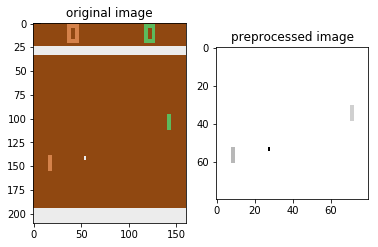

In [3]:
import matplotlib
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()



# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F



# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
        self.conv1 = nn.Conv2d(2, 4, kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(8, 16, kernel_size=2, stride=2)
        #self.Pool = nn.MaxPool2d(2, stride=2)
        self.size=16*10*10
        self.fc1 = nn.Linear(self.size, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 3)
        
        self.apply(self.weights_init_normal)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # flatten the tensor
        x = x.view(-1,self.size)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

    def weights_init_normal(self, m):
        '''Takes in a module and initializes all linear layers with weight
           values taken from a normal distribution.'''
        # for every Linear layer in a model
        if type(m) == nn.Linear:
            y = m.in_features
        # m.weight.data shoud be taken from a normal distribution
            m.weight.data.normal_(0.0,1/np.sqrt(y))
        # m.bias.data should be 0
            m.bias.data.fill_(0)


# run your own policy!
policy= Policy().to(device)

# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-3)

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress


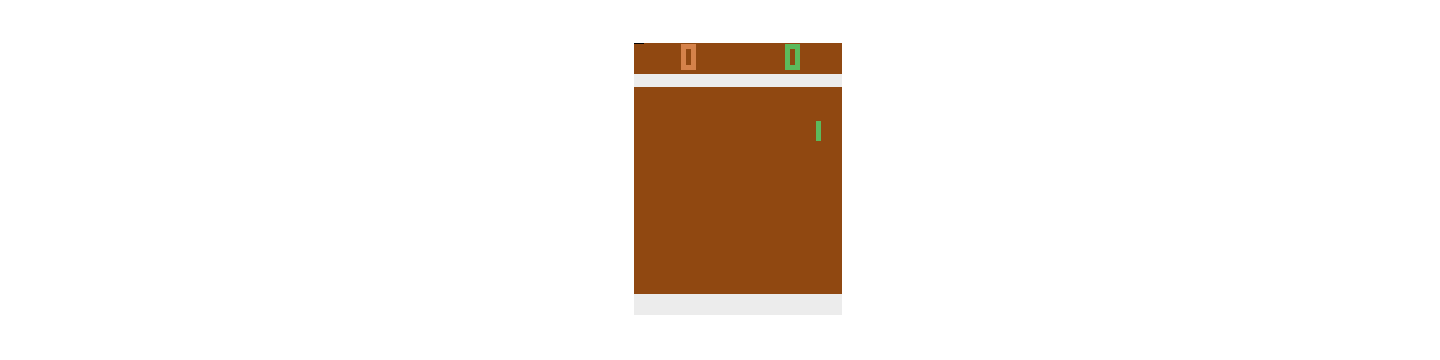
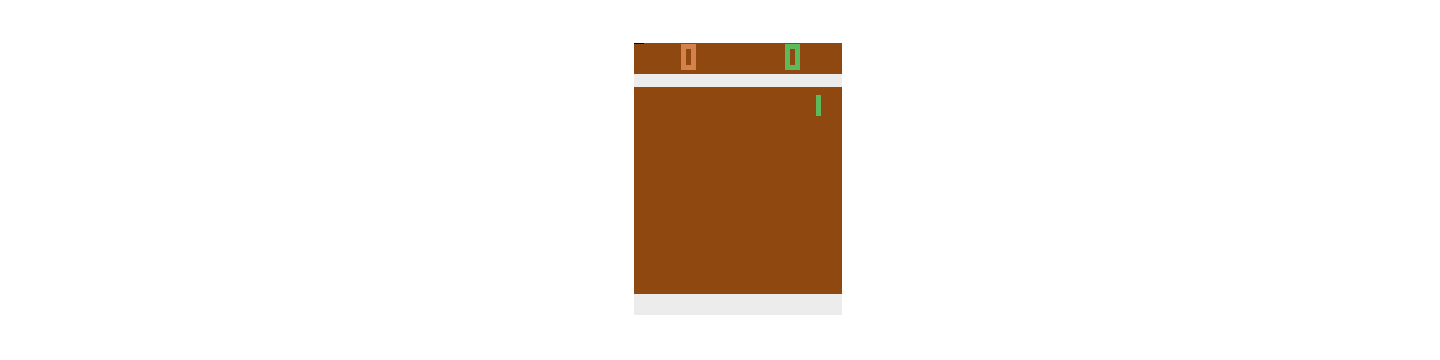
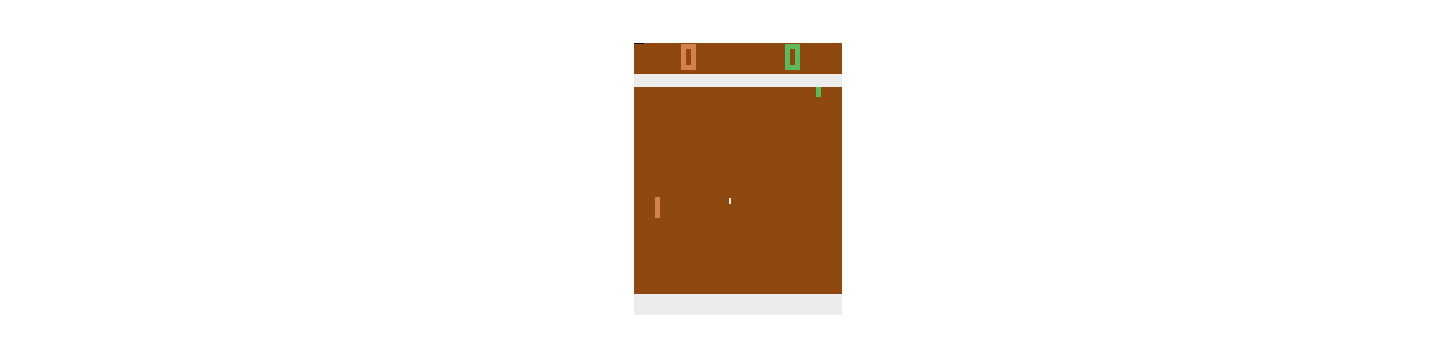
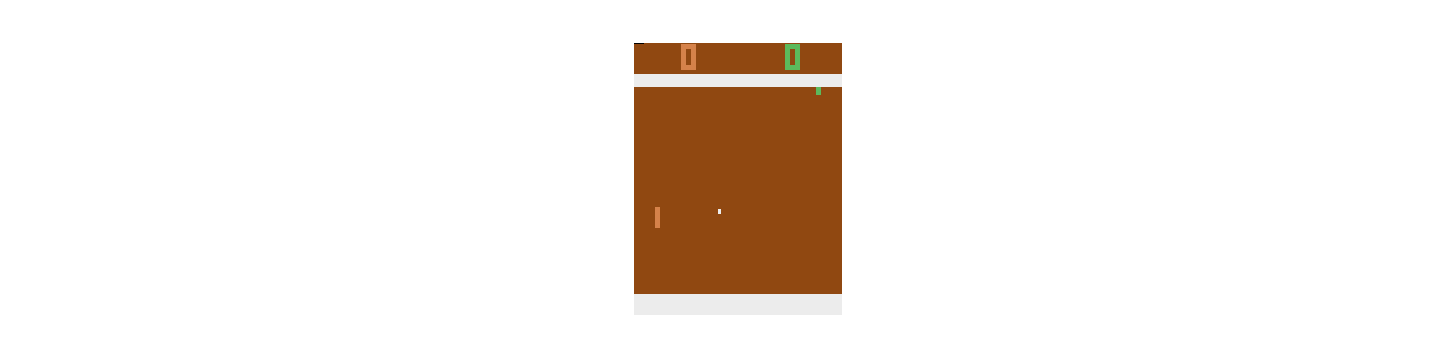
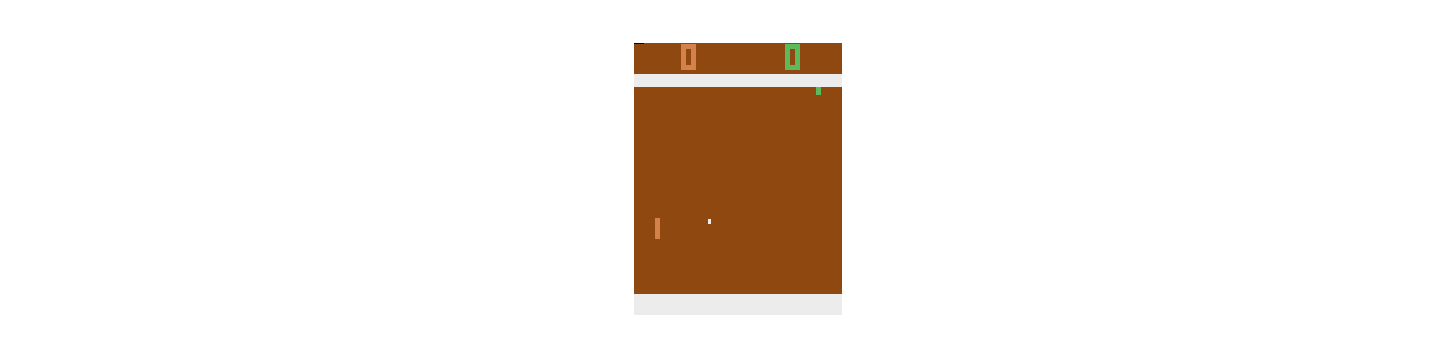
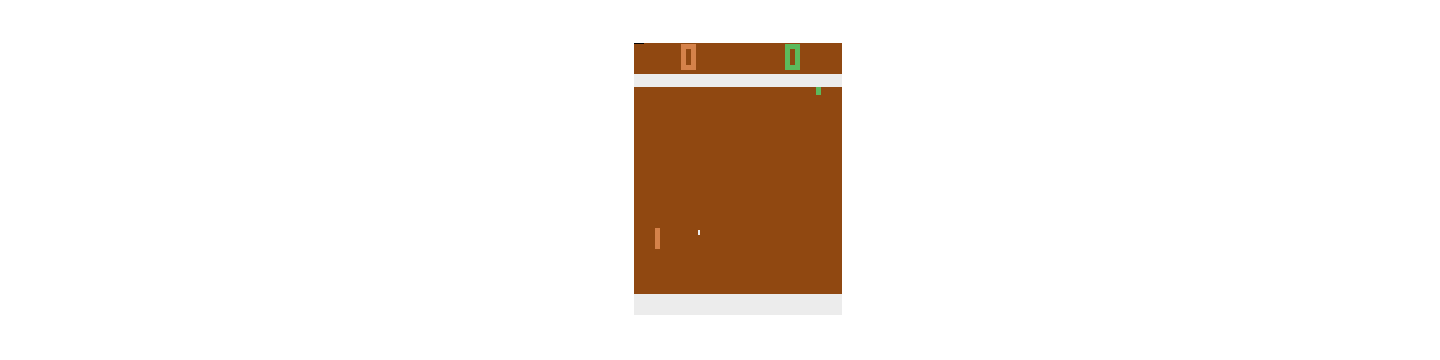
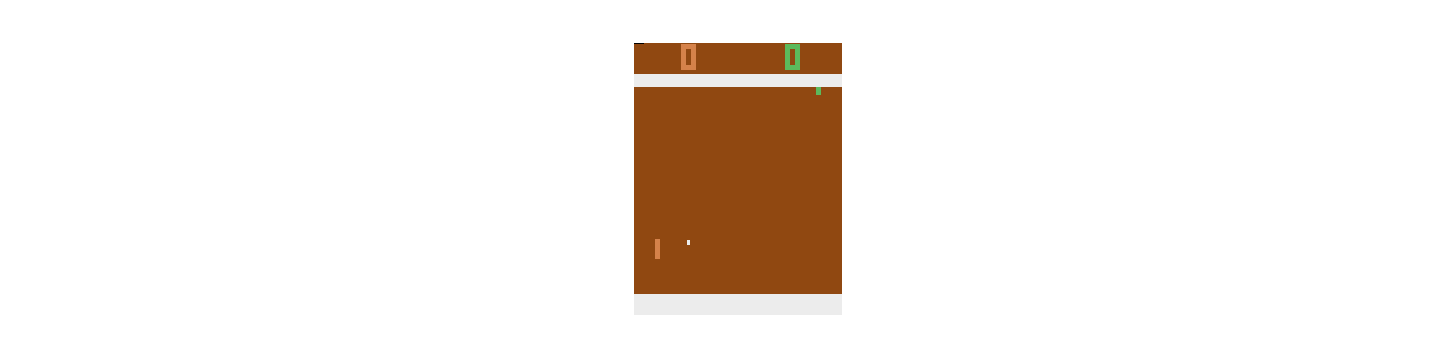
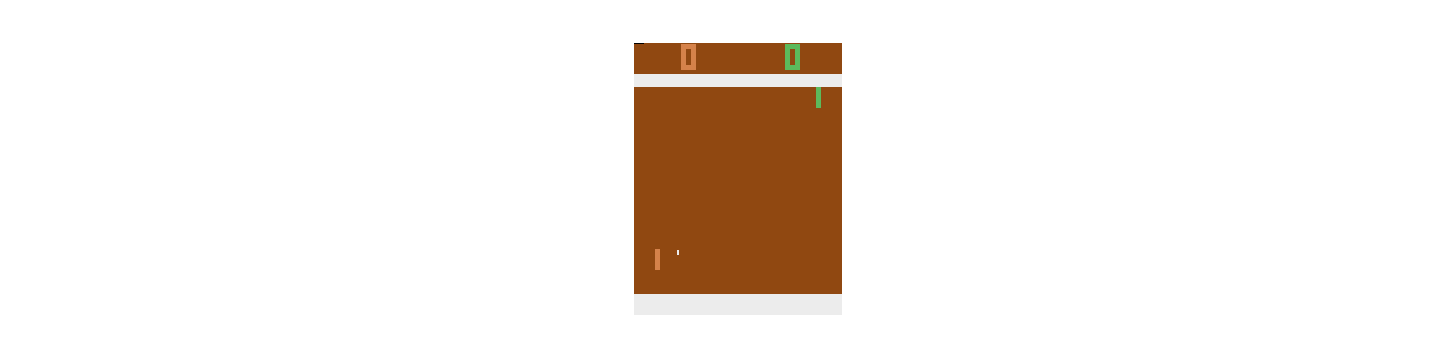
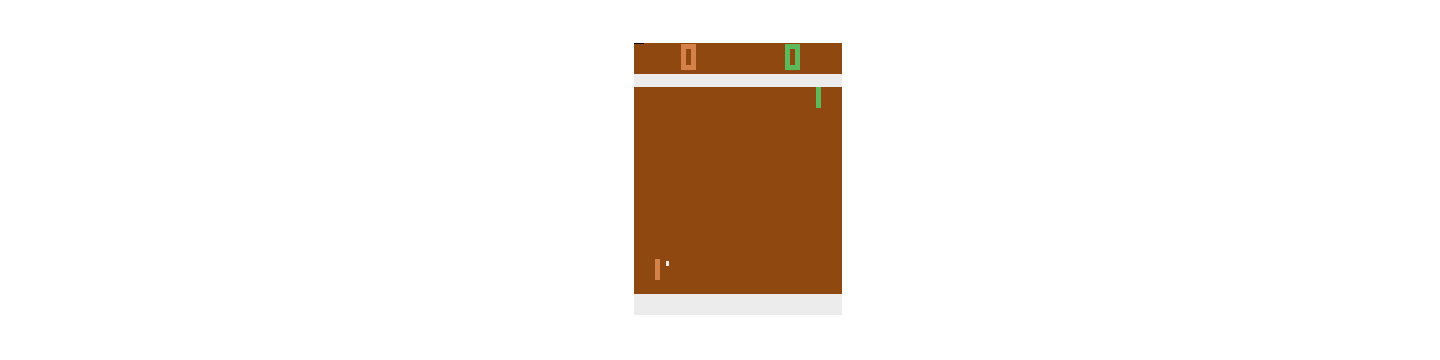
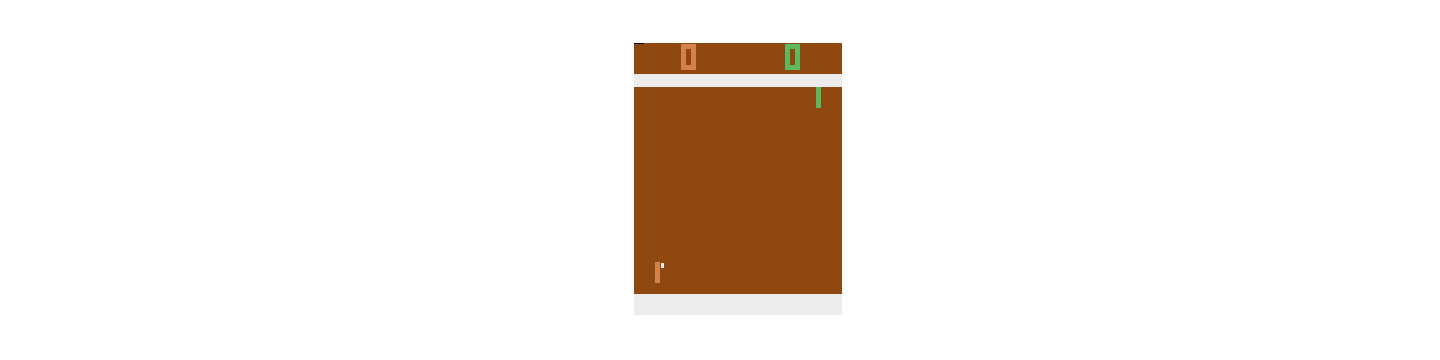
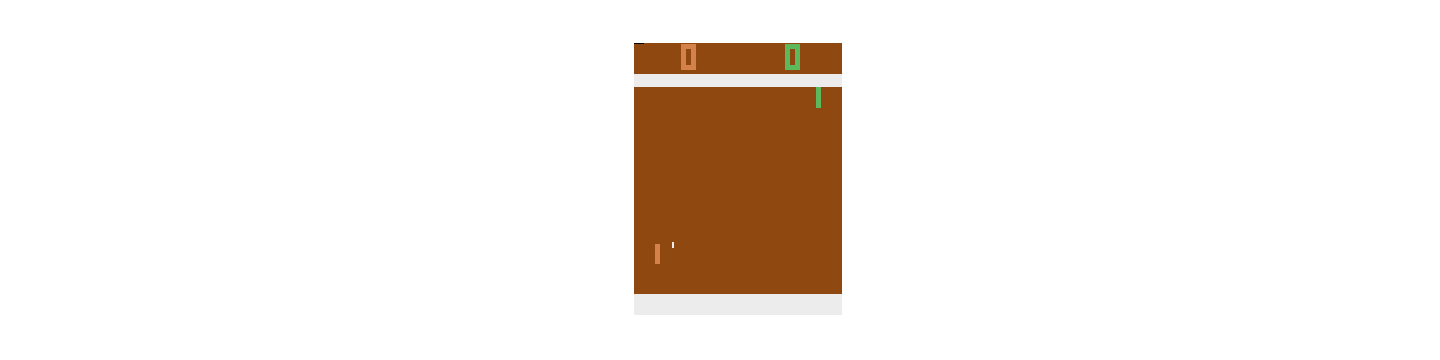
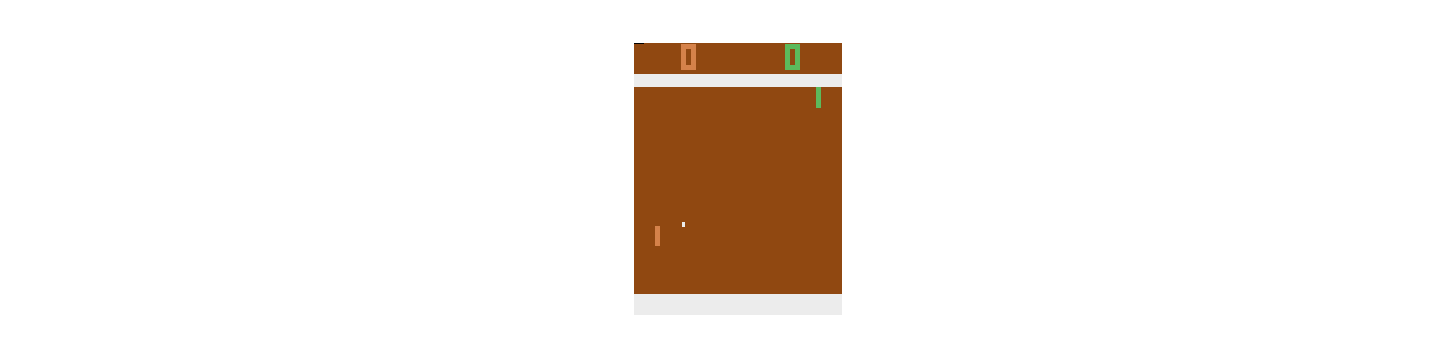
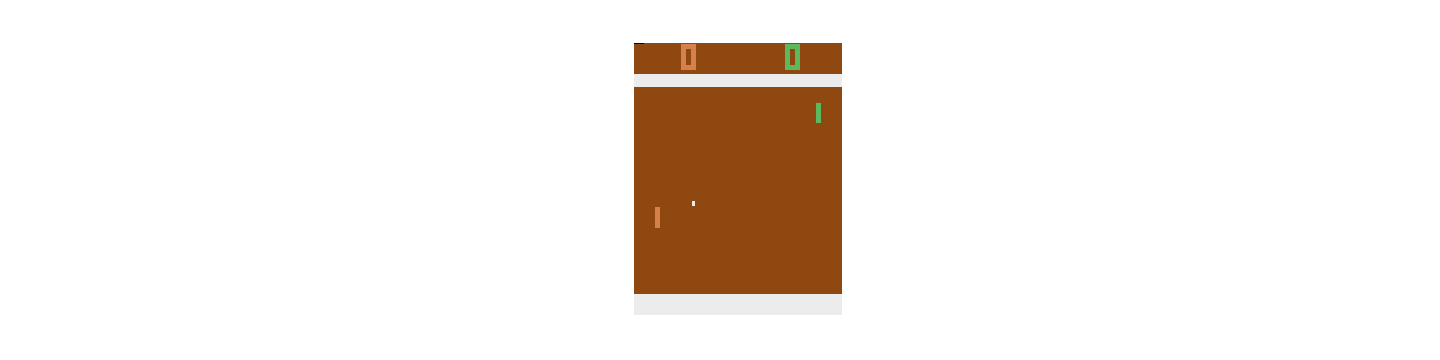
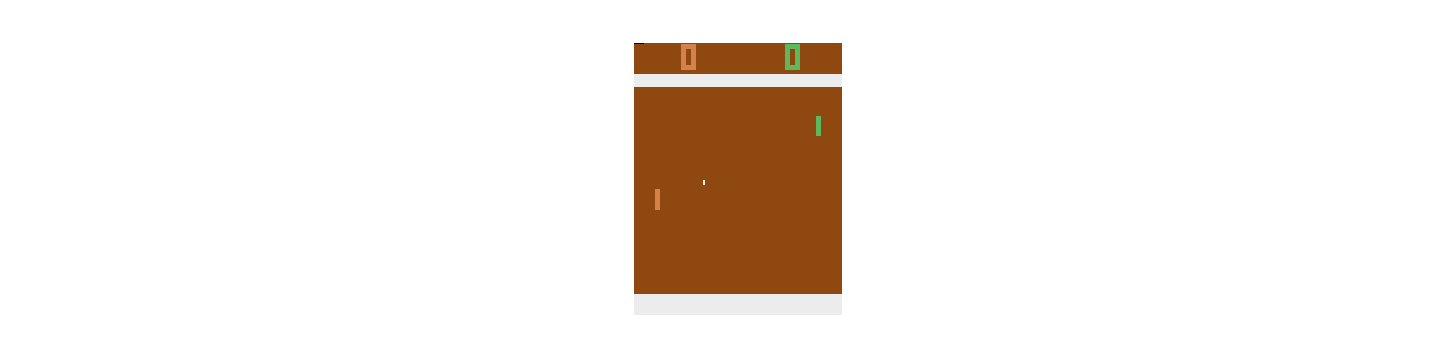
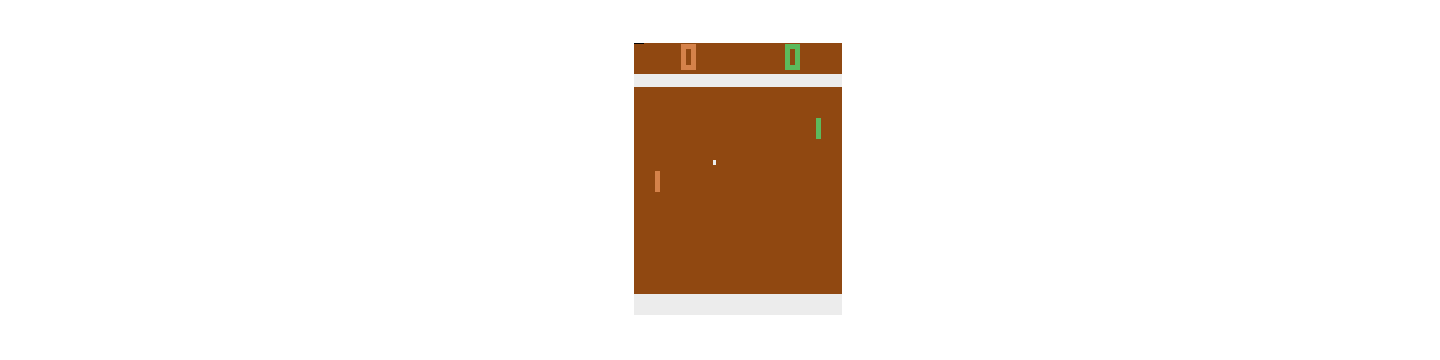
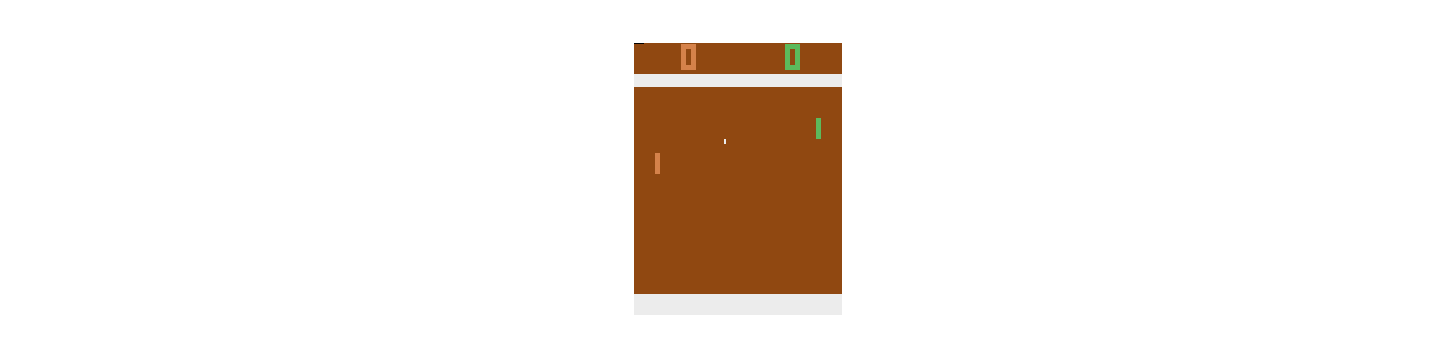
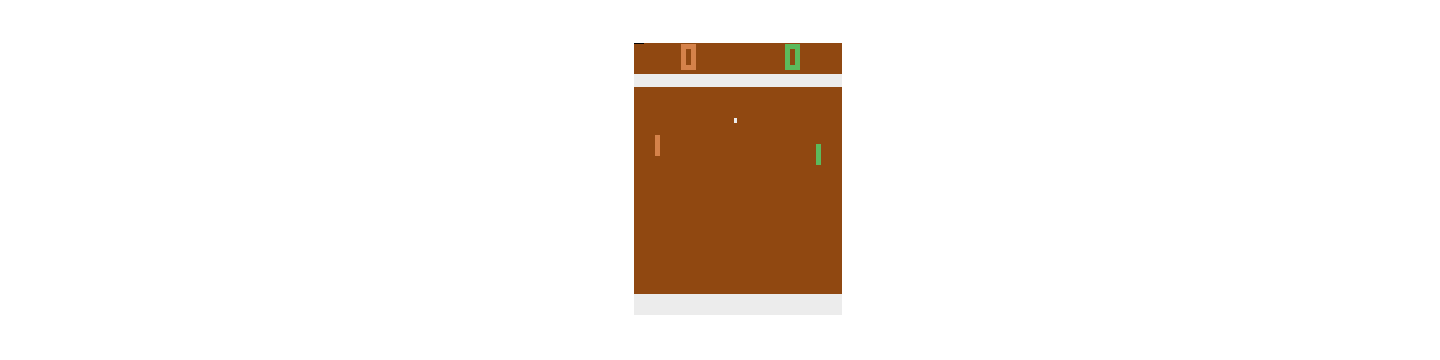
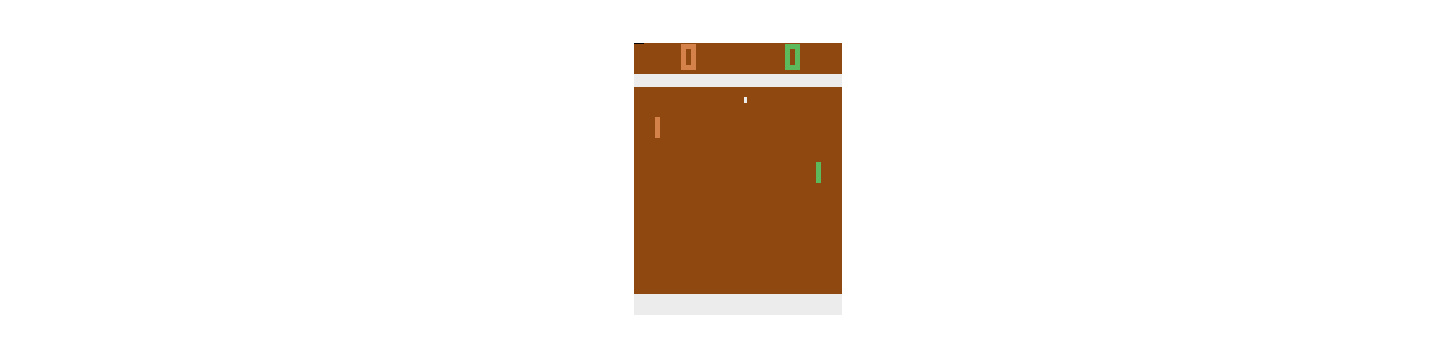
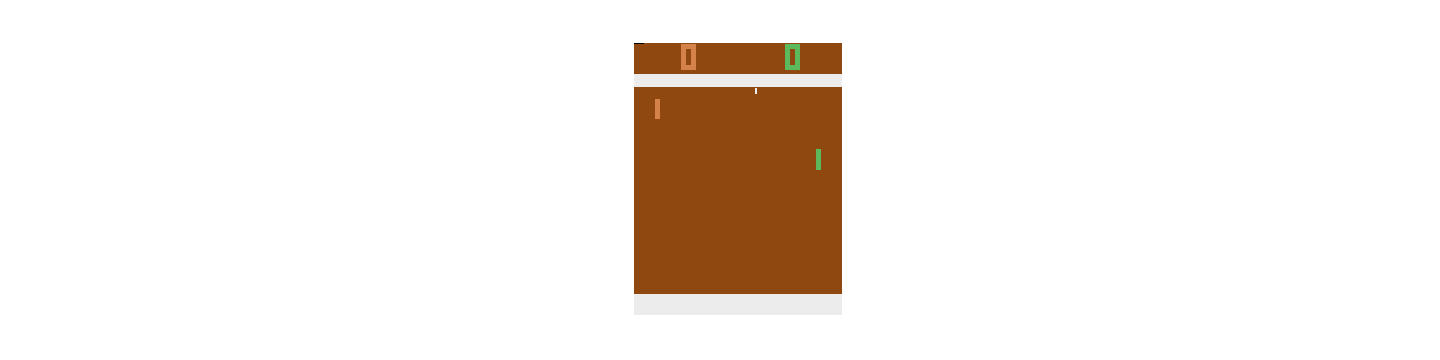
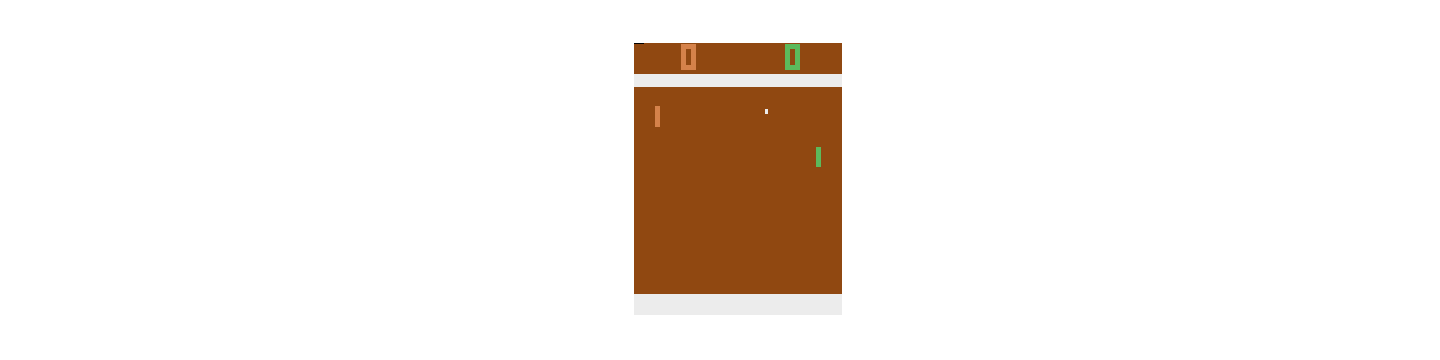
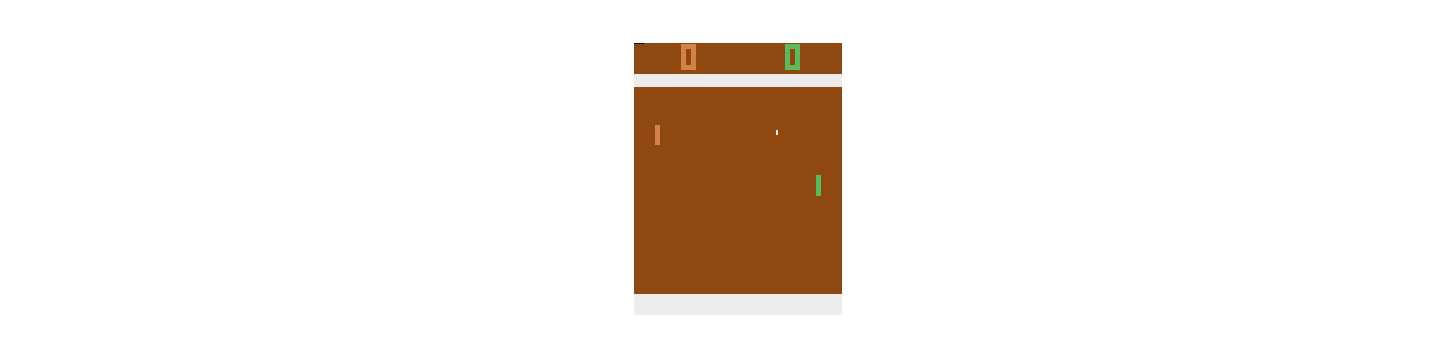
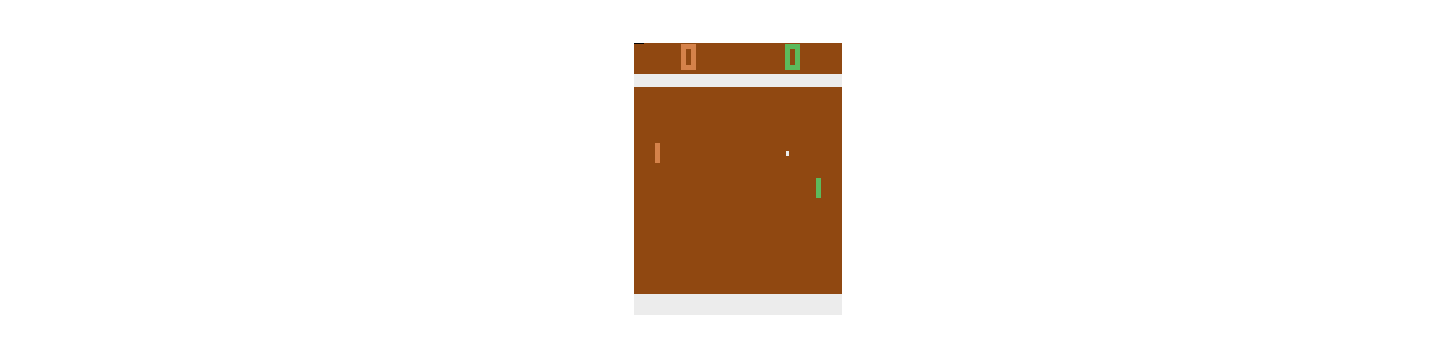
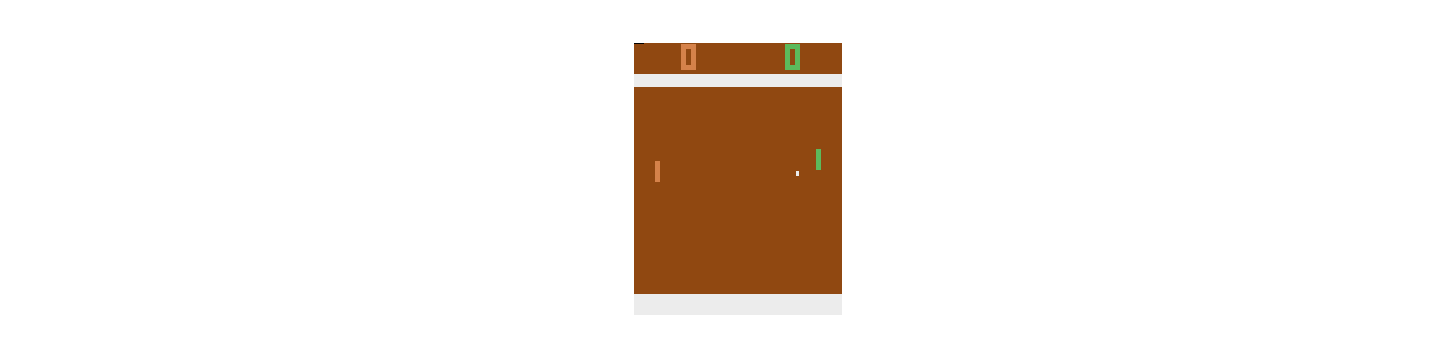
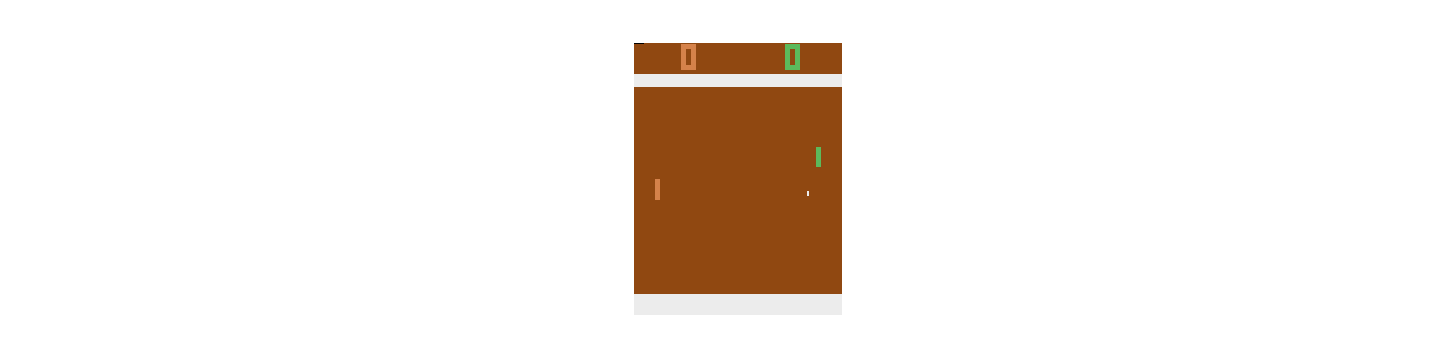
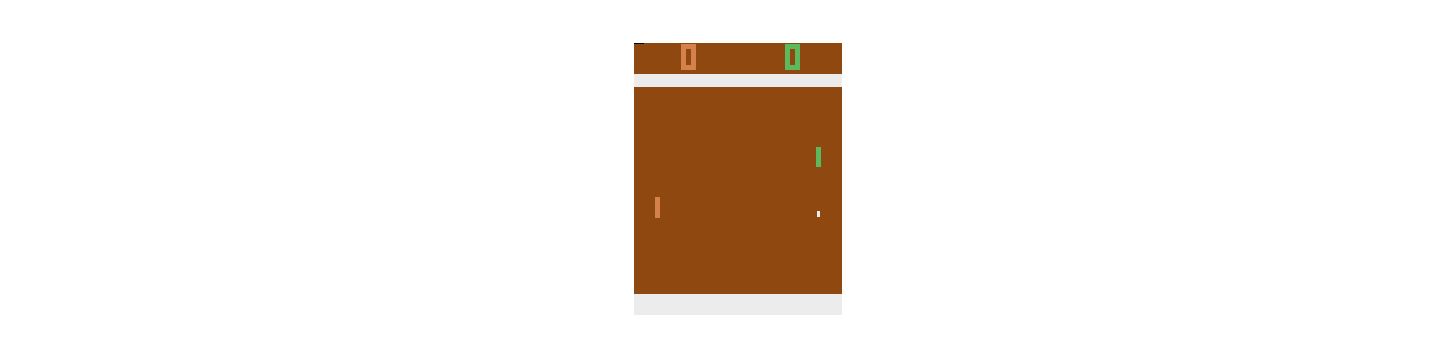
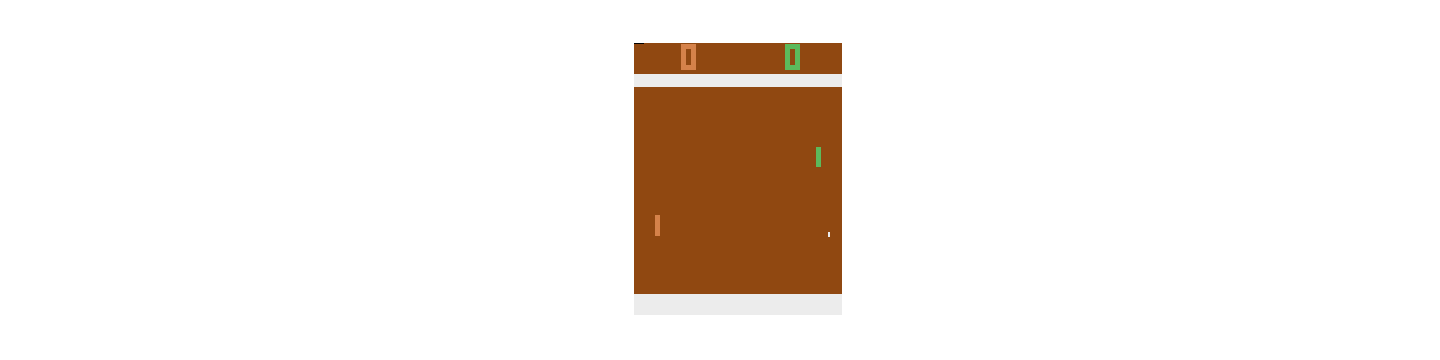
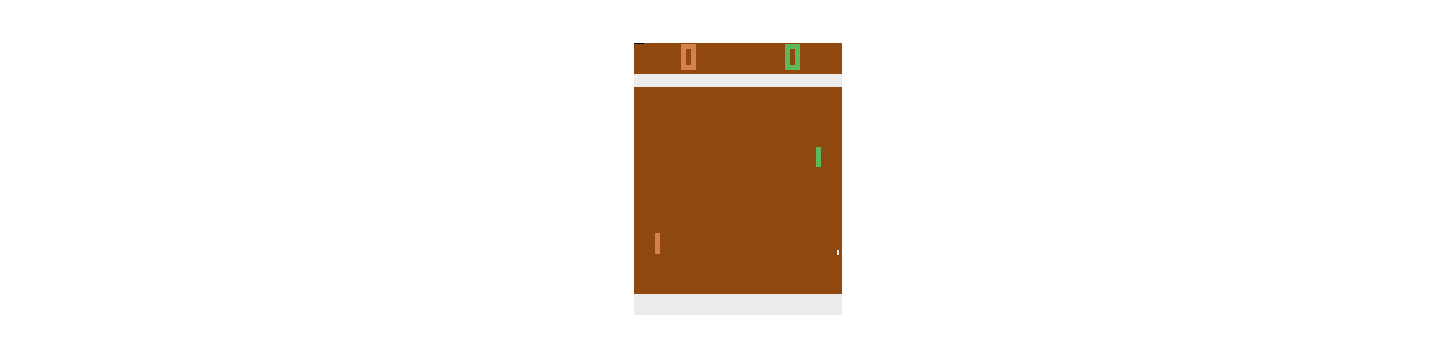
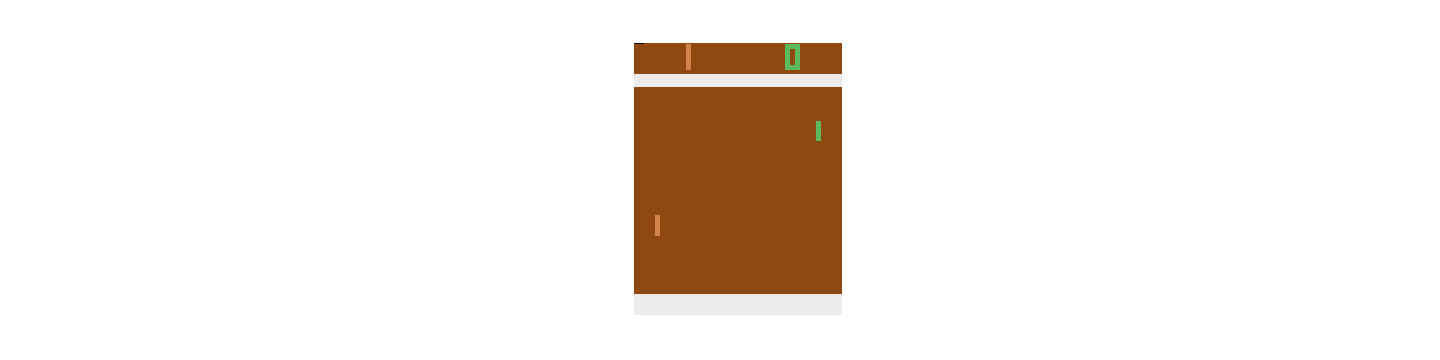
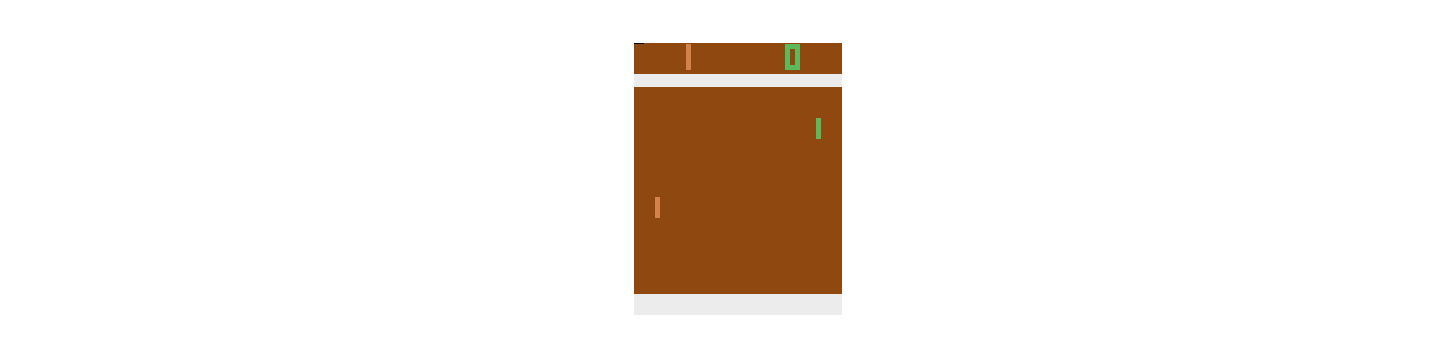
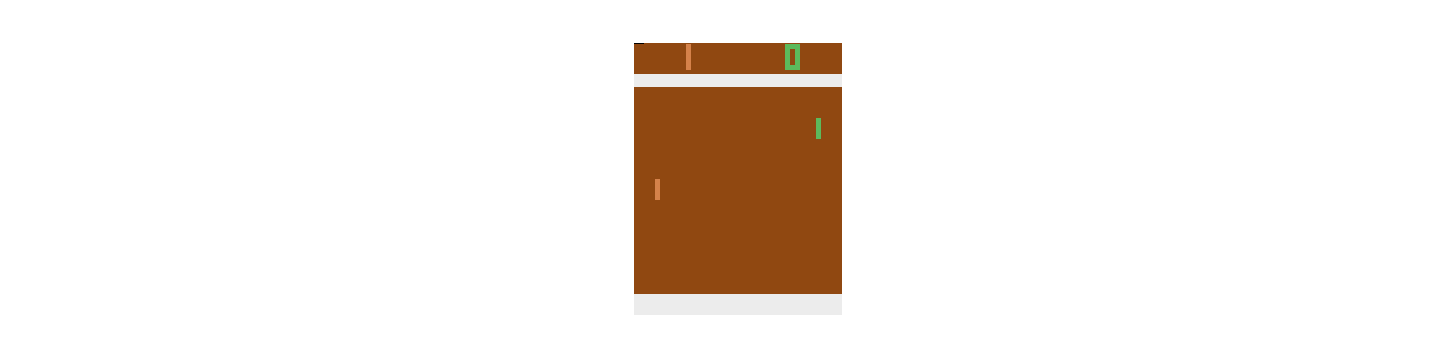
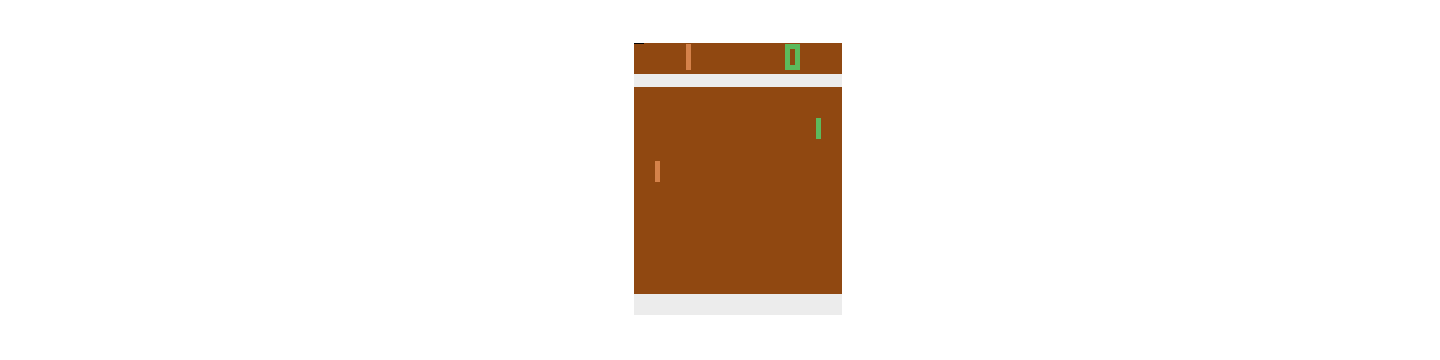
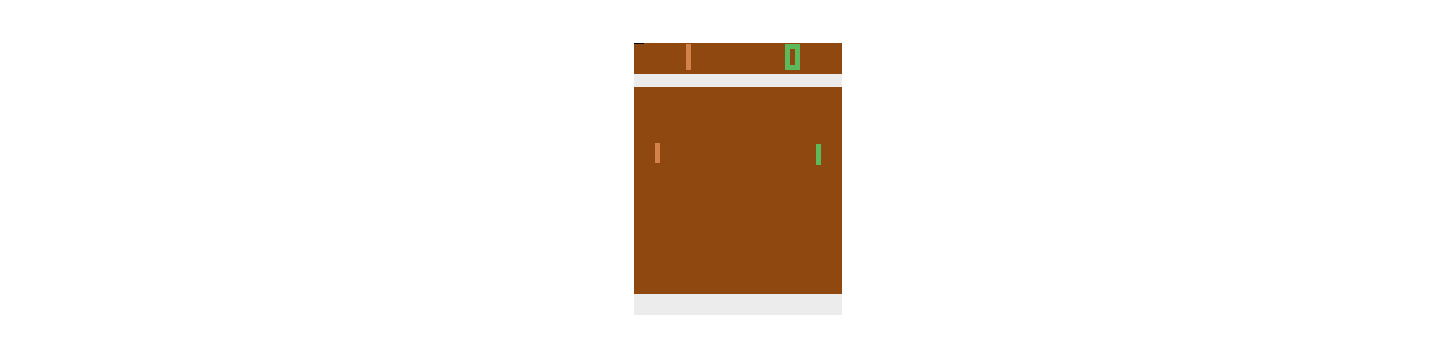
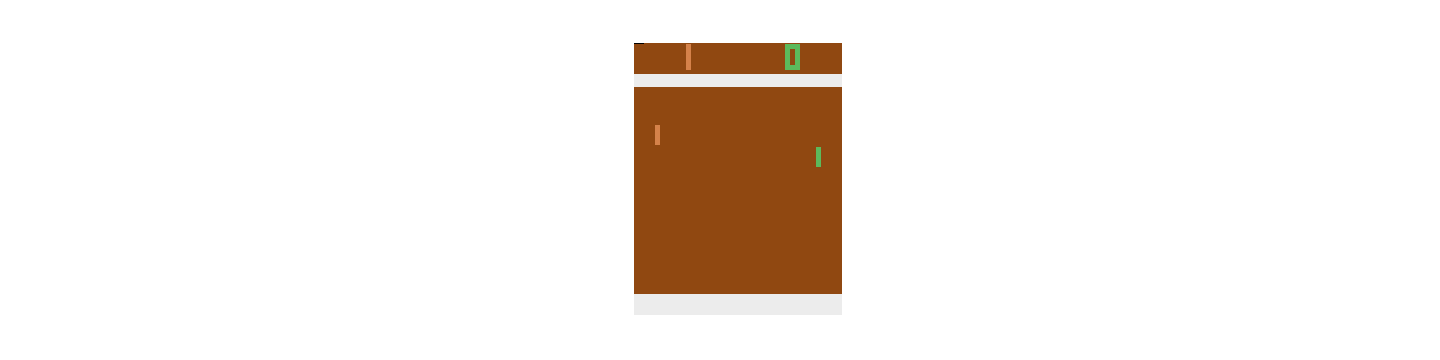
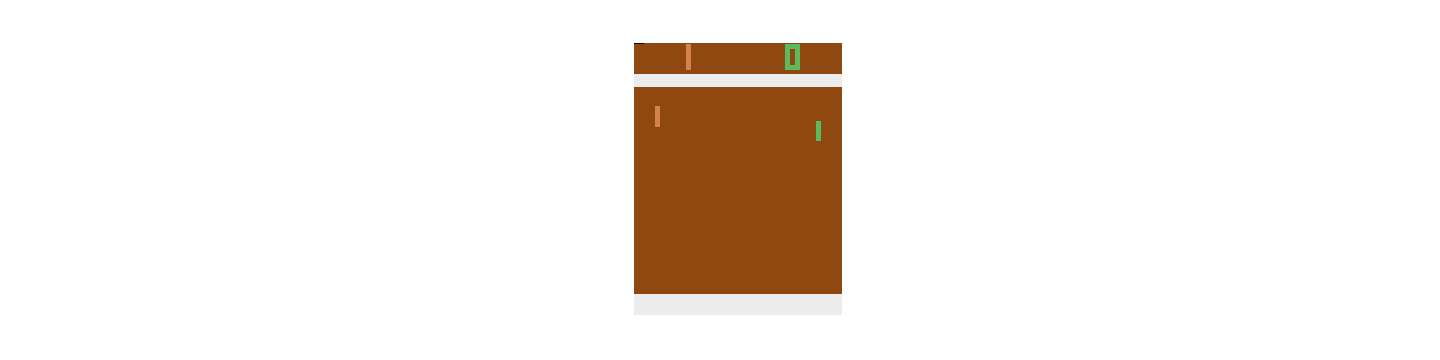
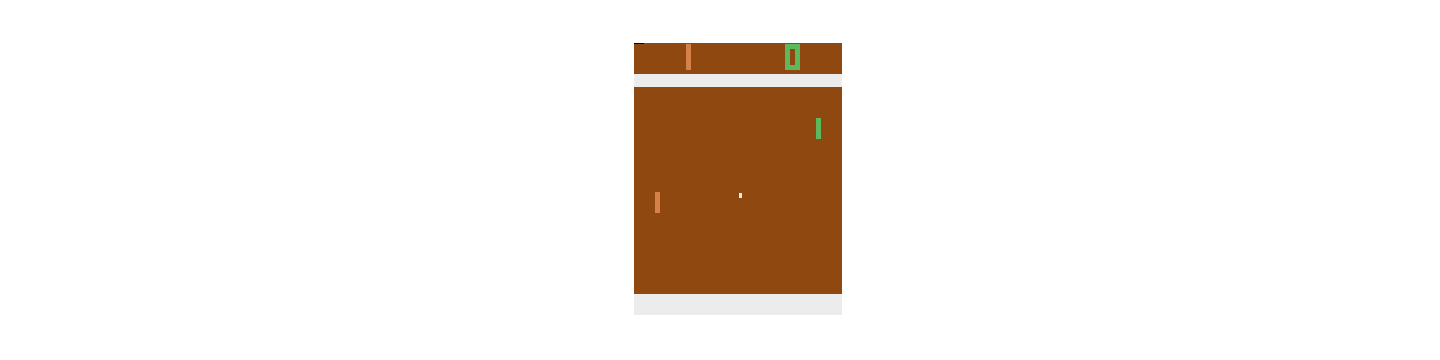
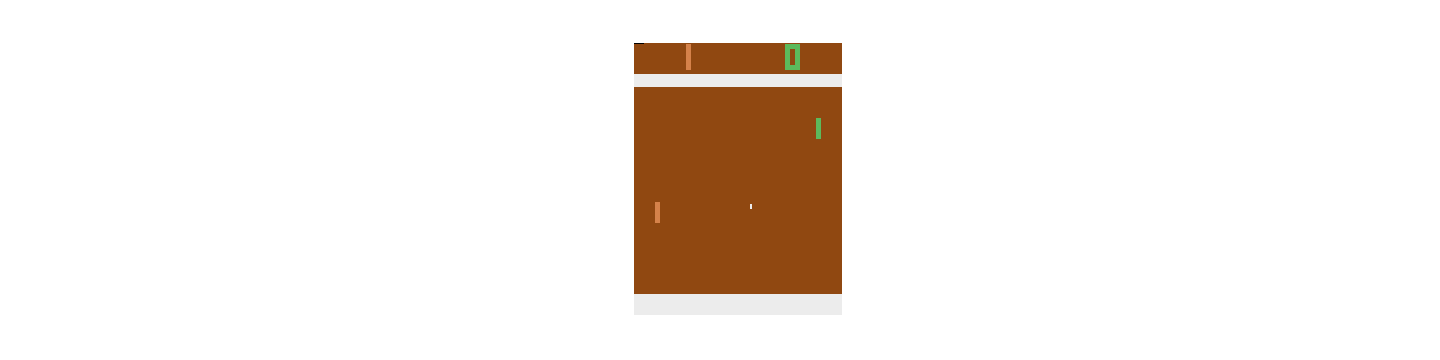
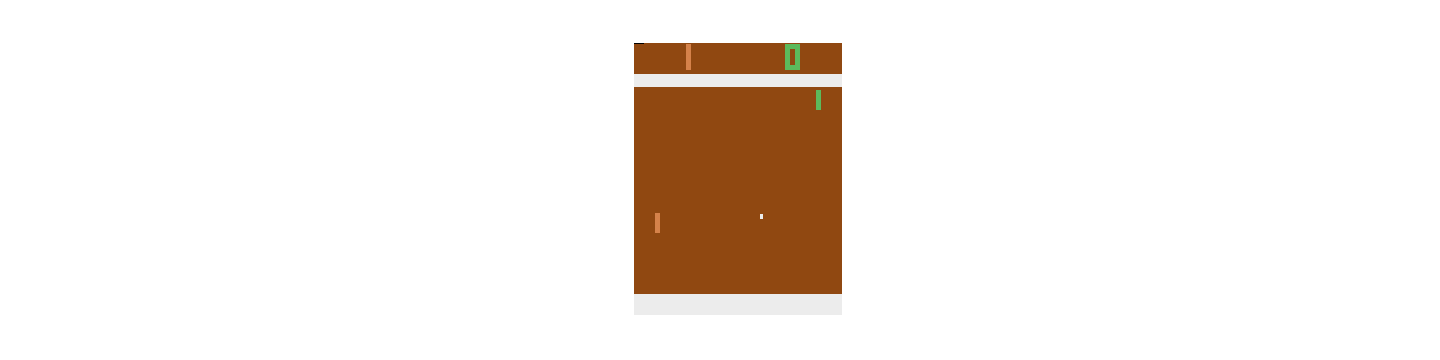
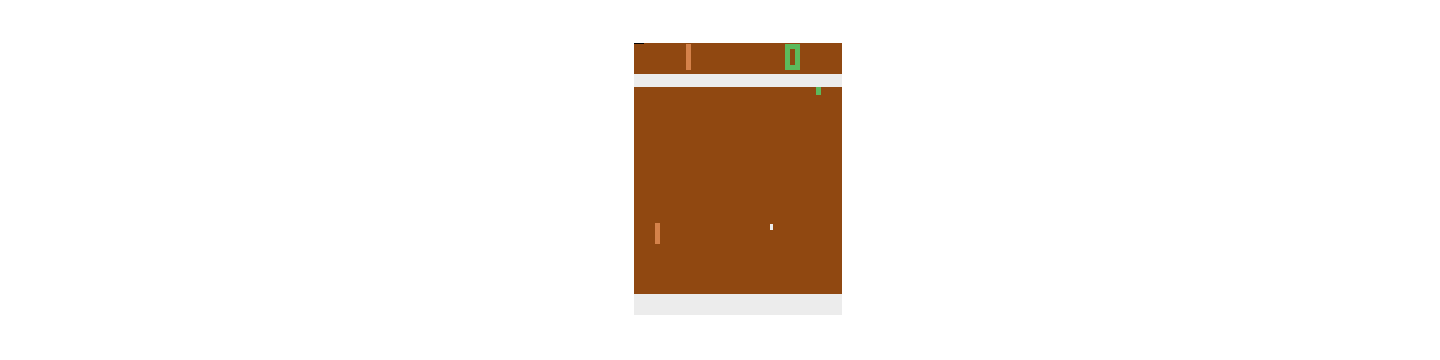
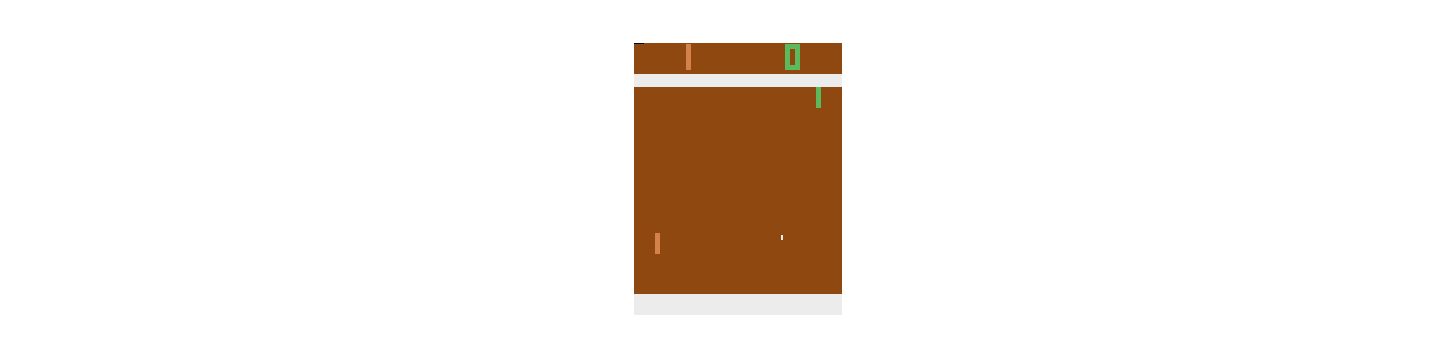
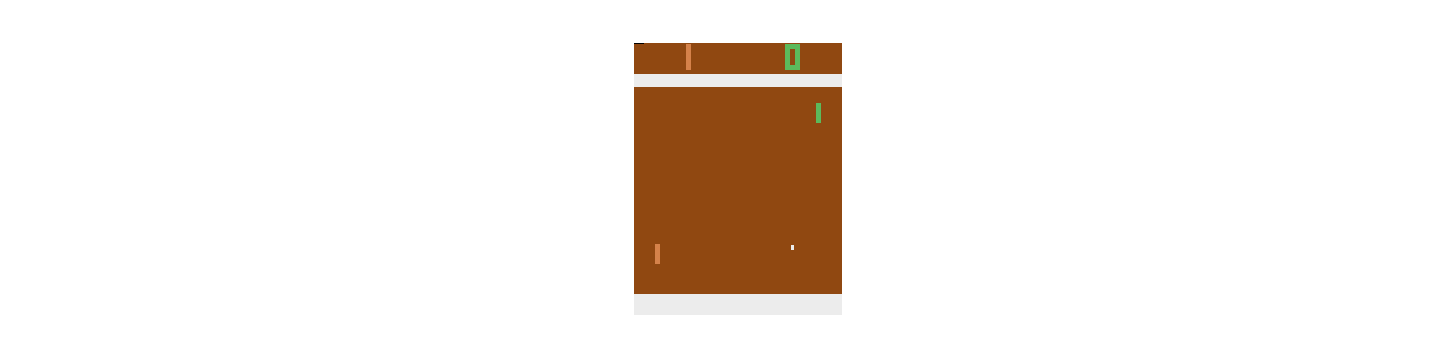
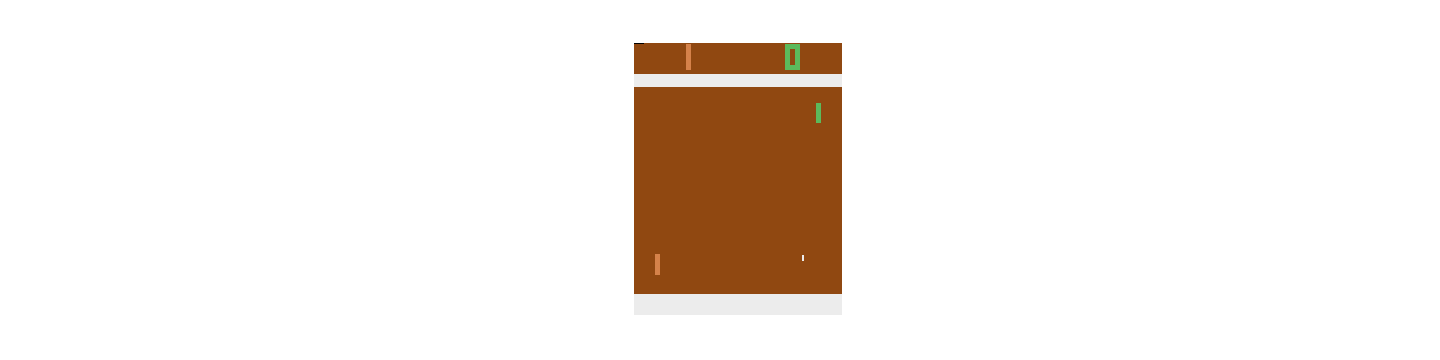
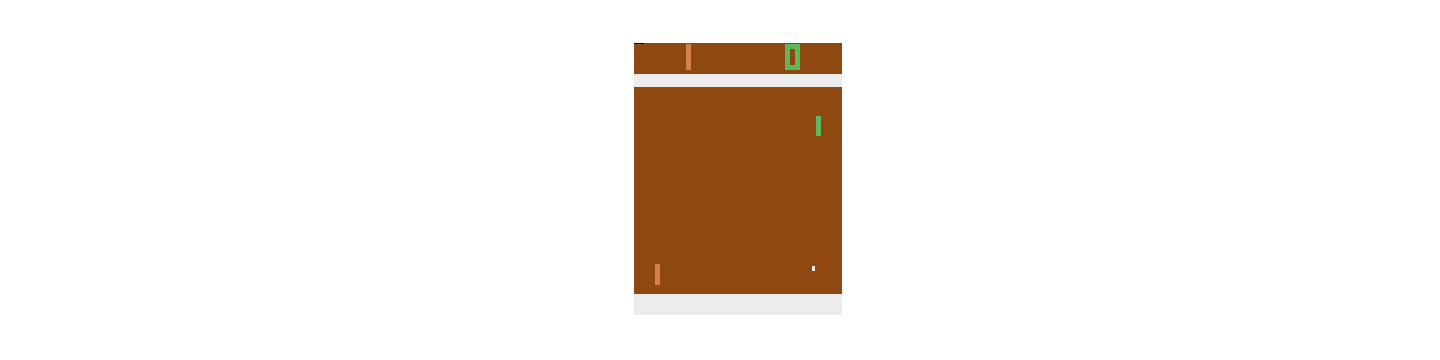
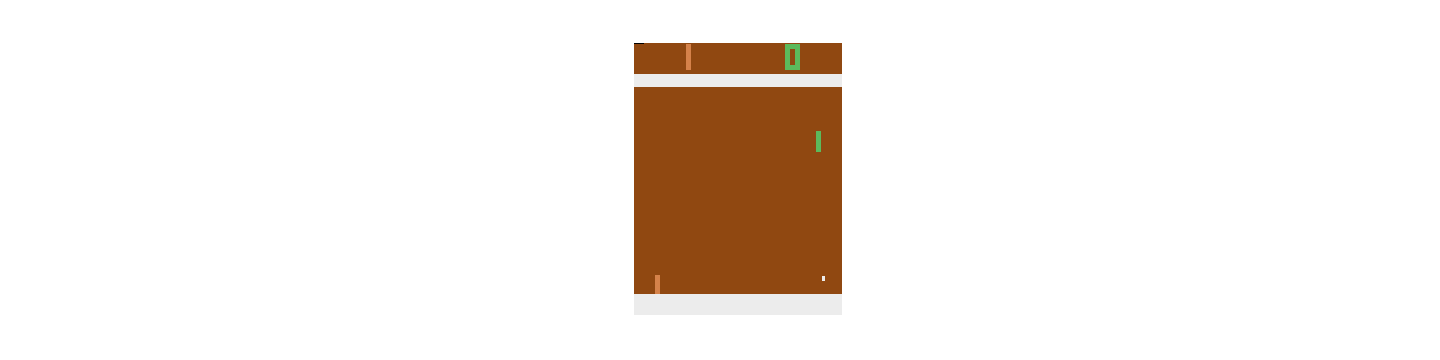
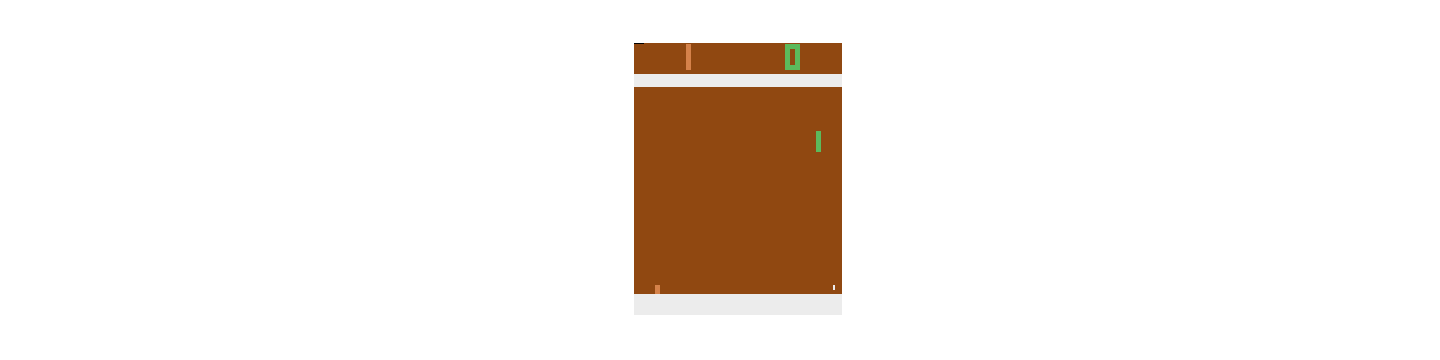
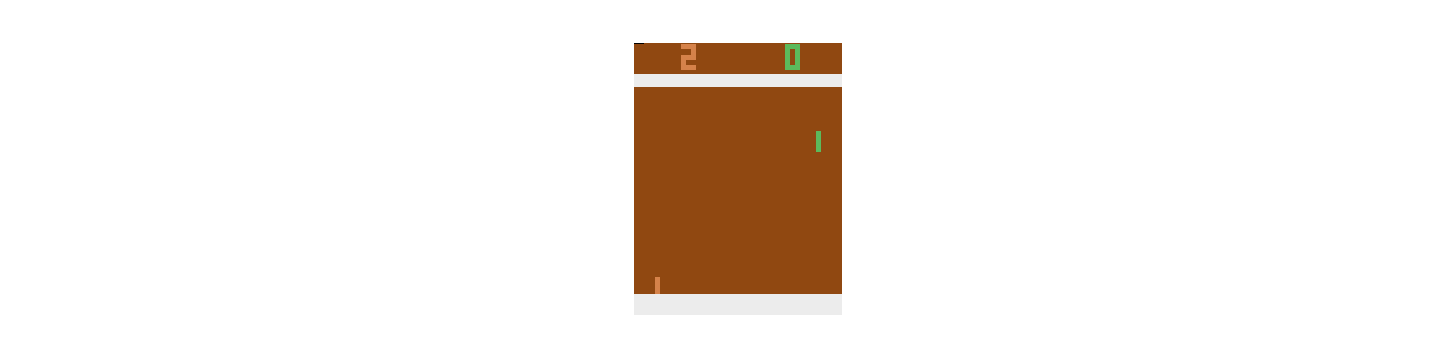
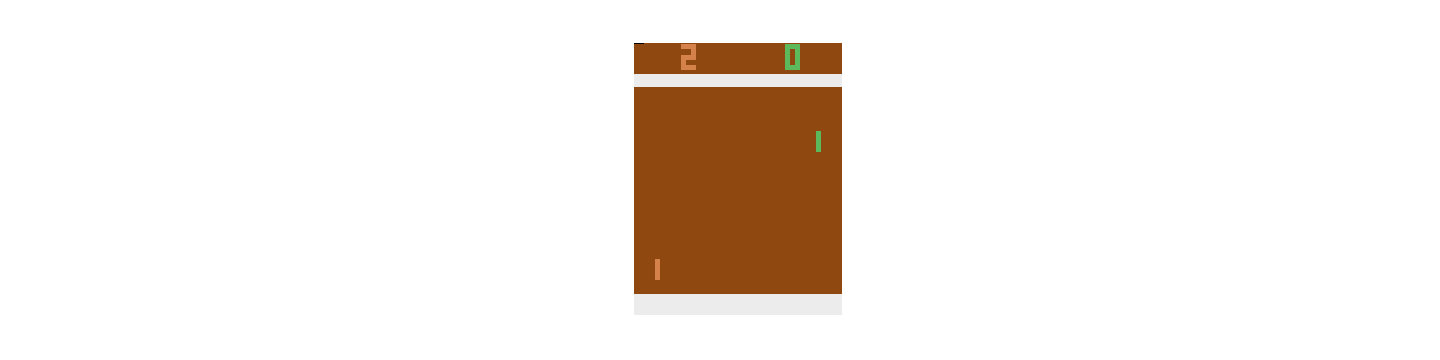
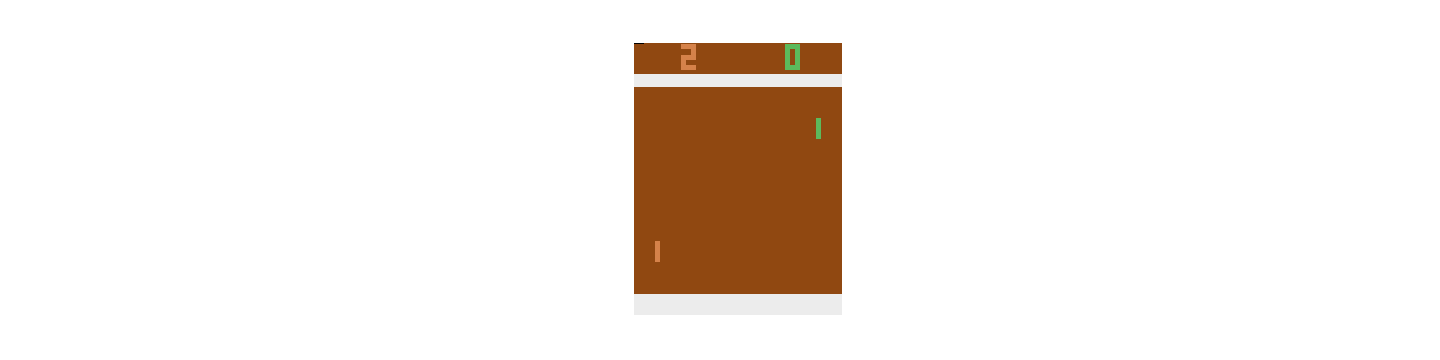
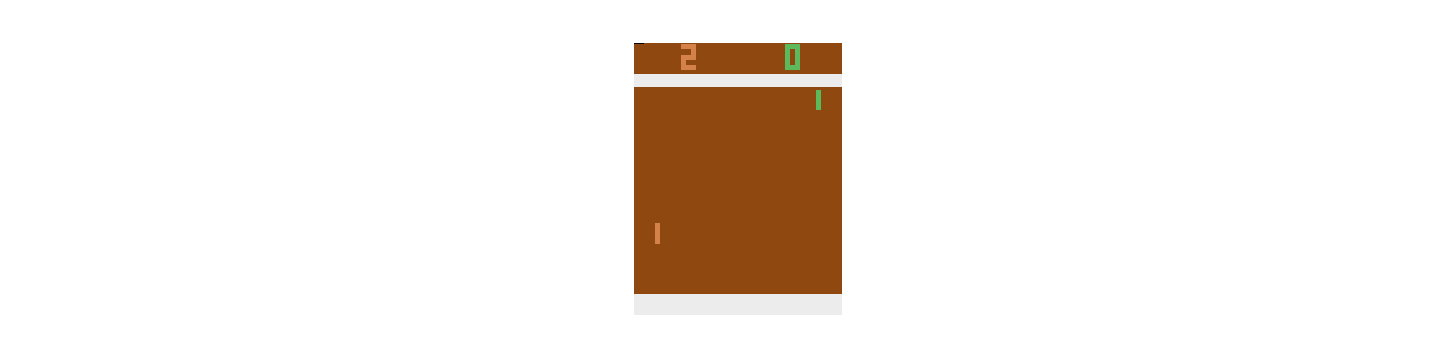
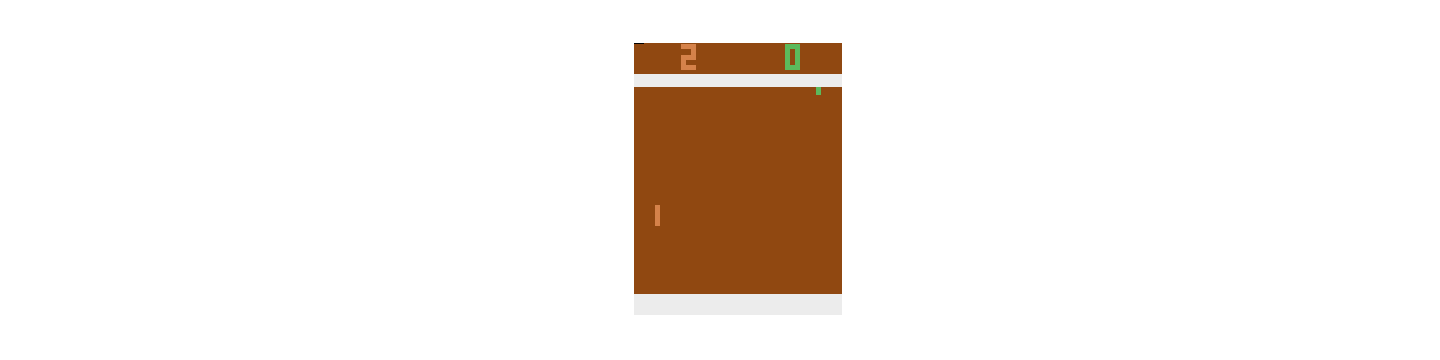
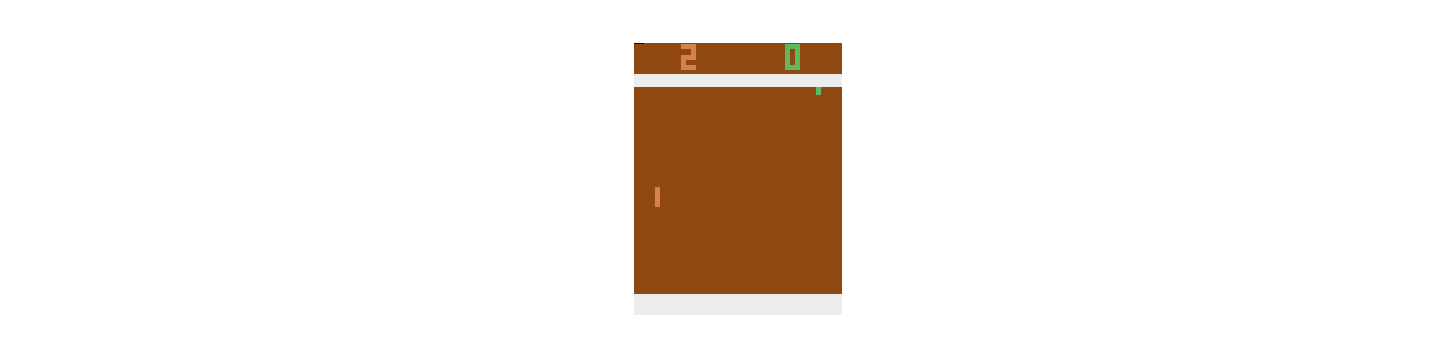
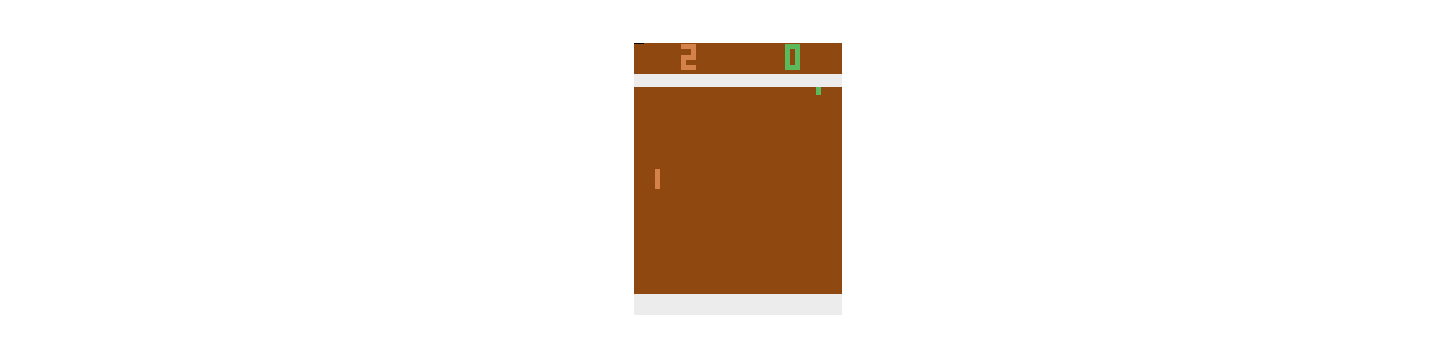
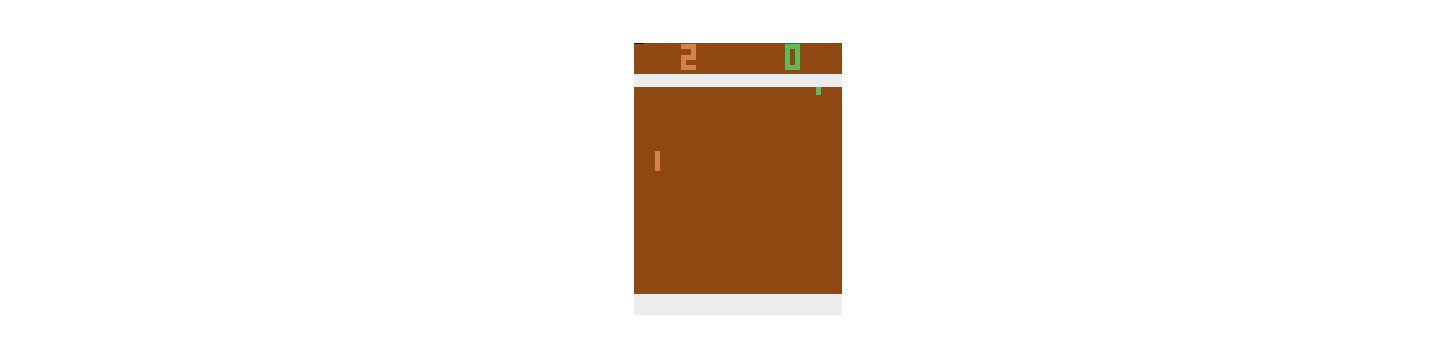
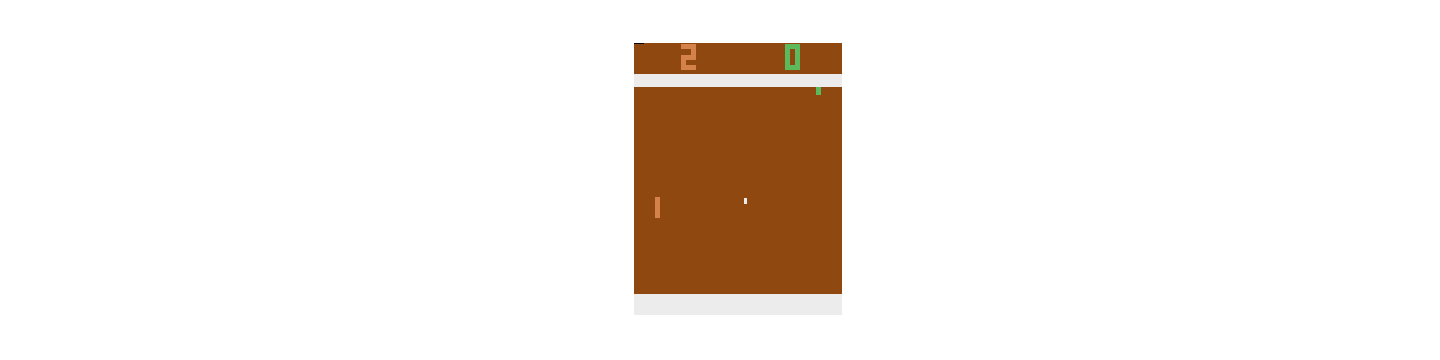
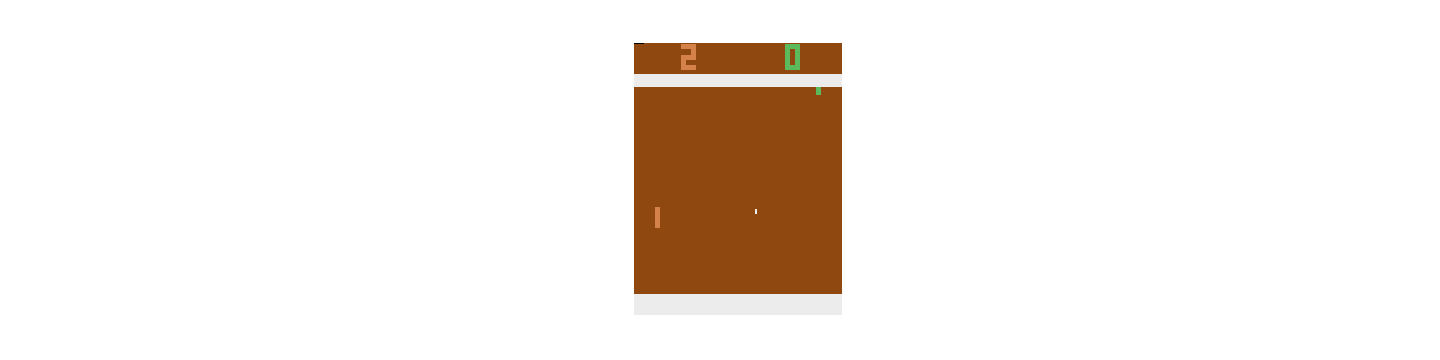
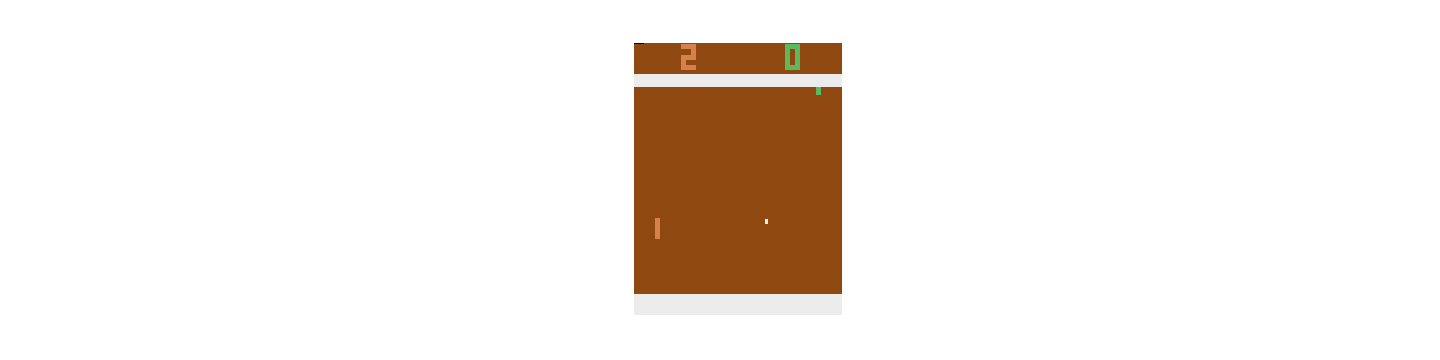
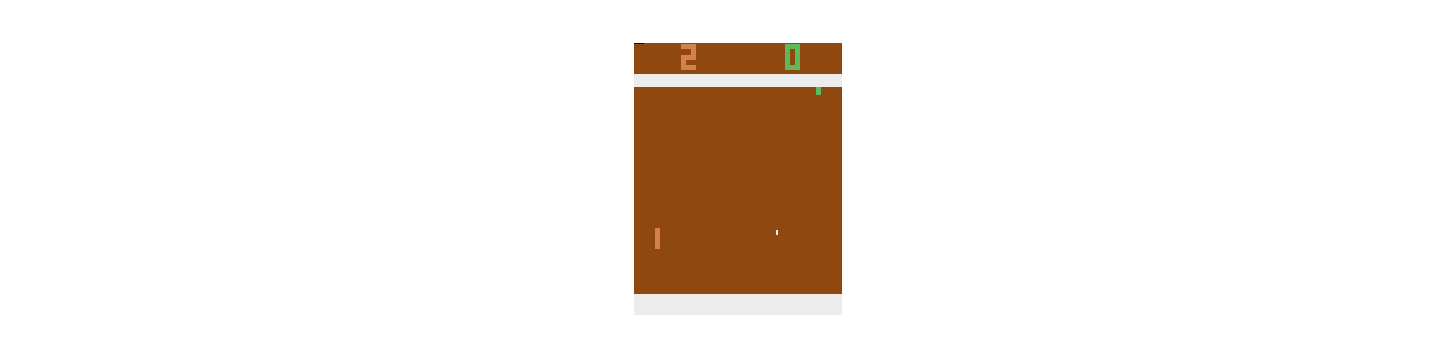
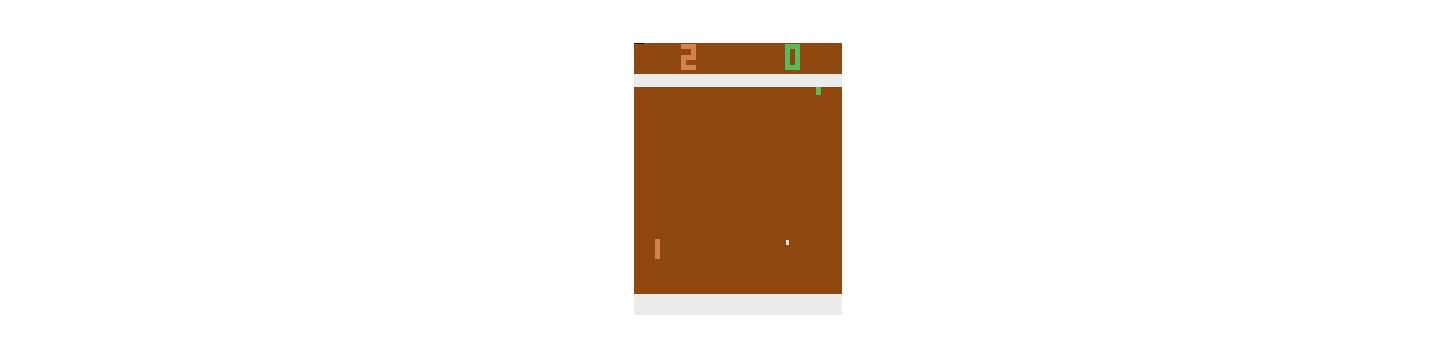
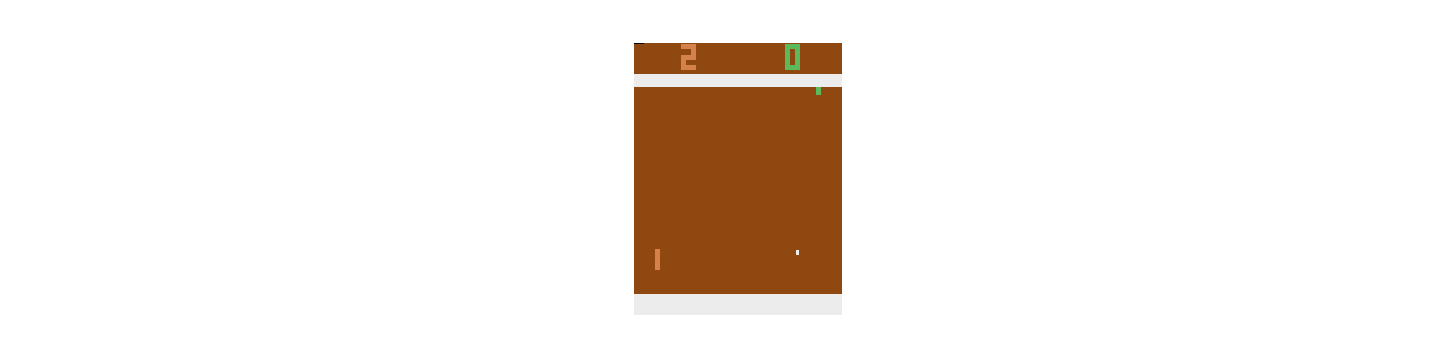
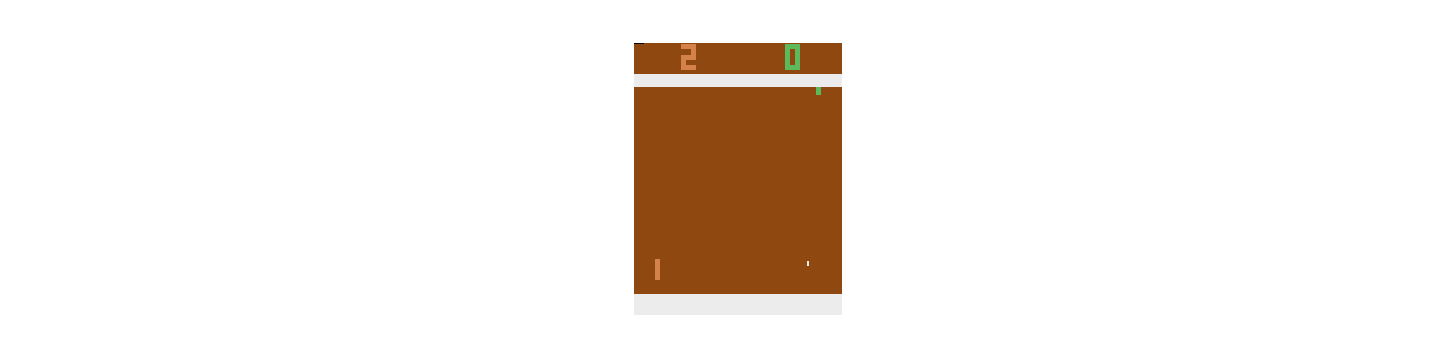
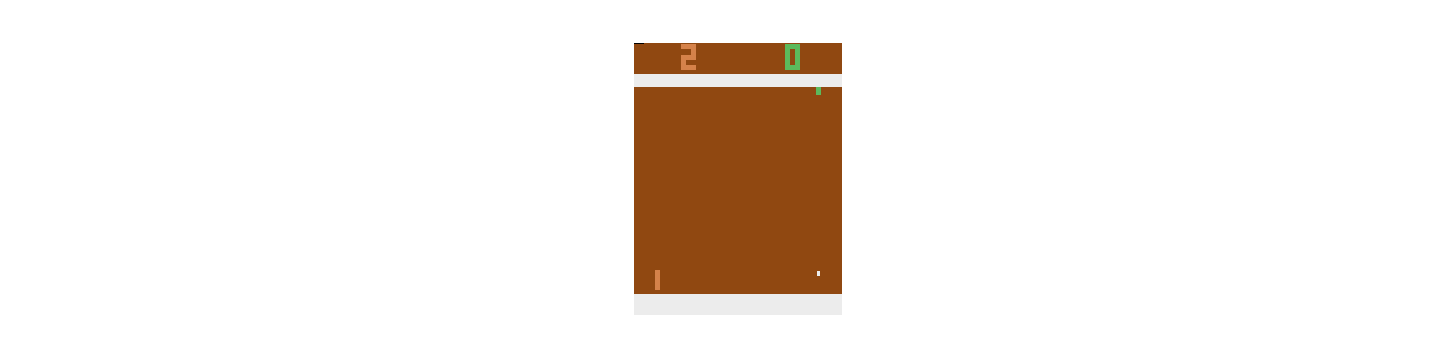
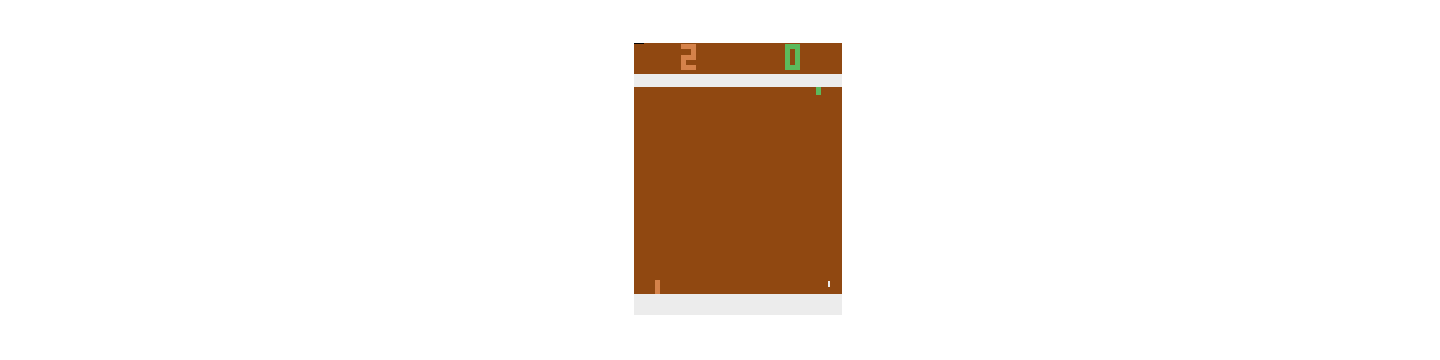
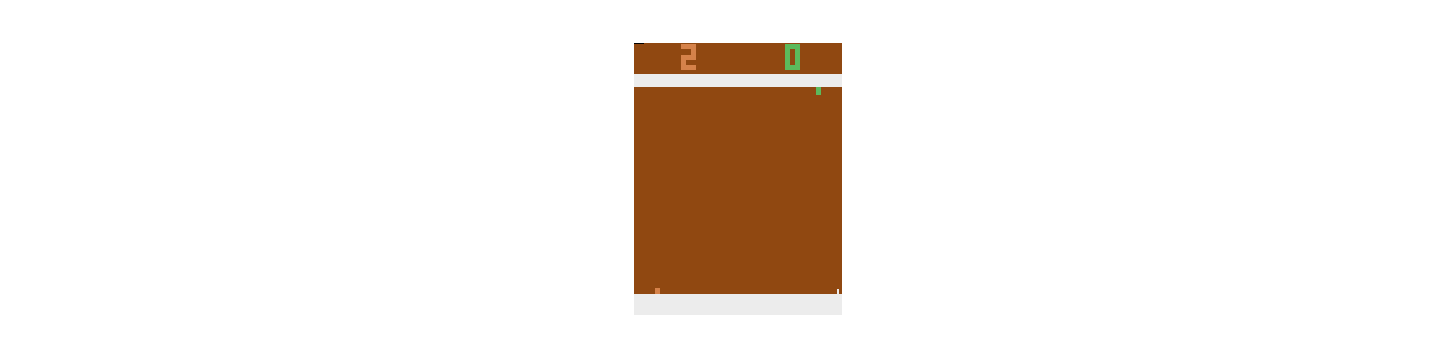
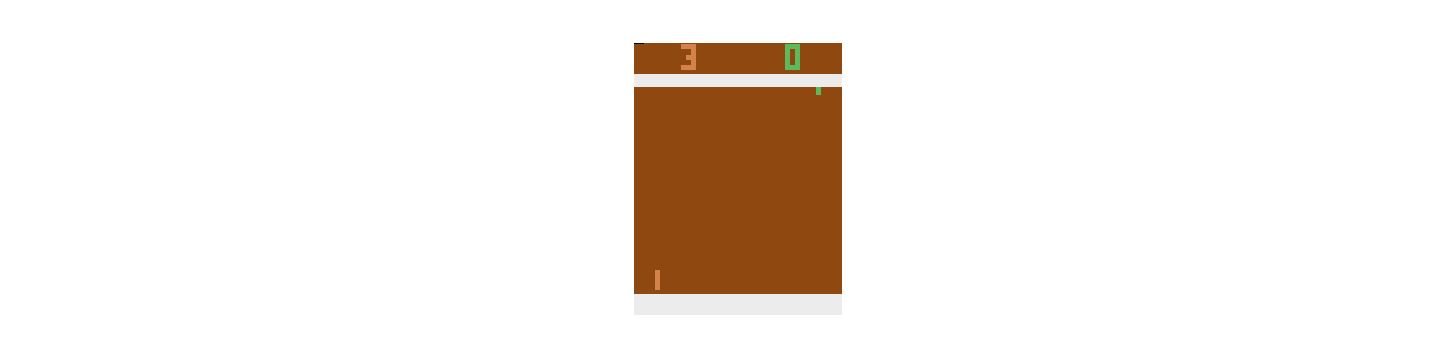
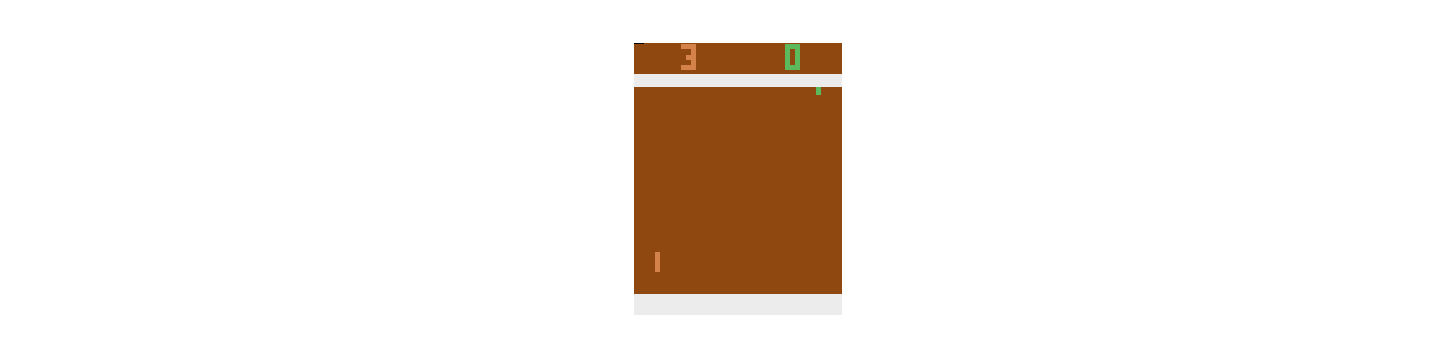
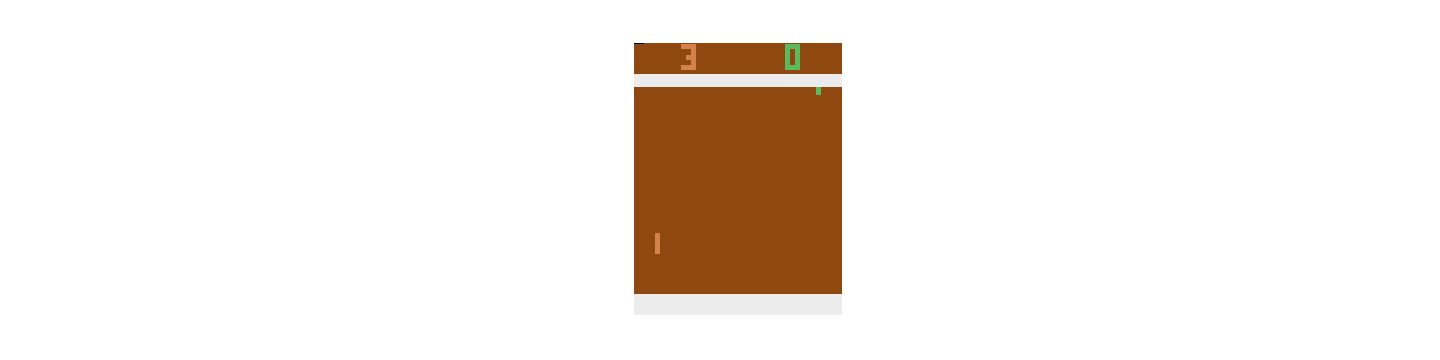
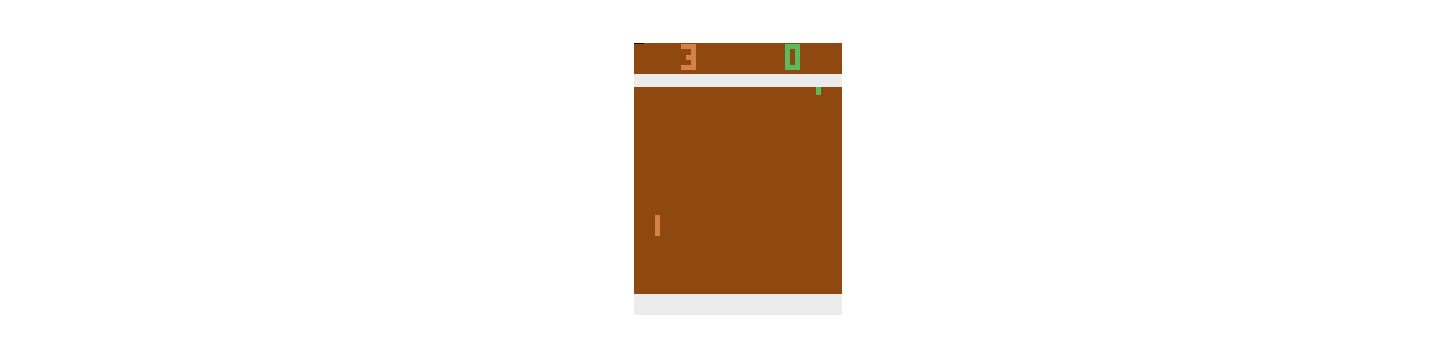
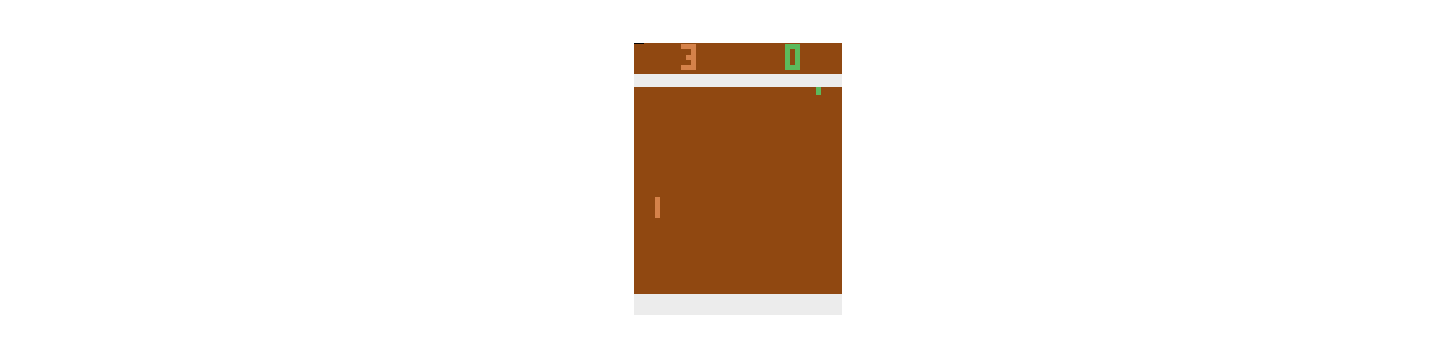
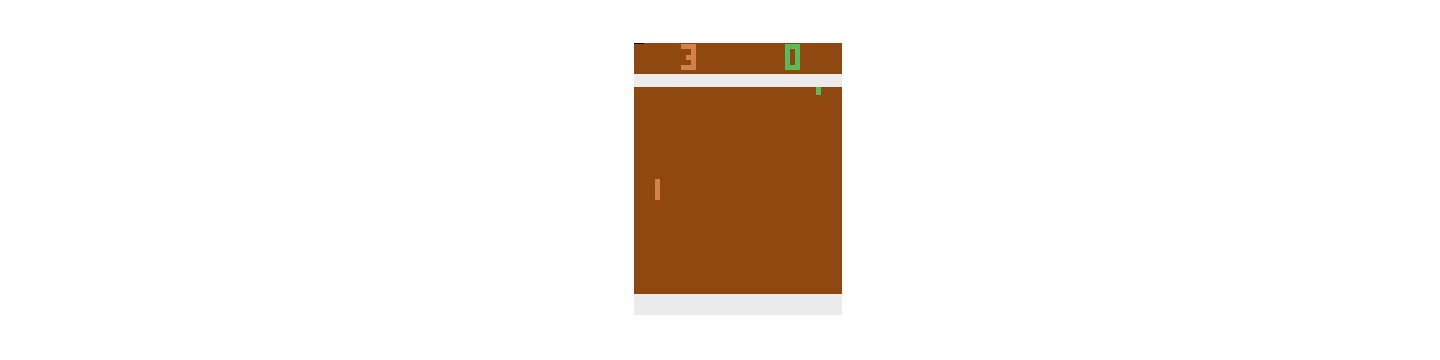
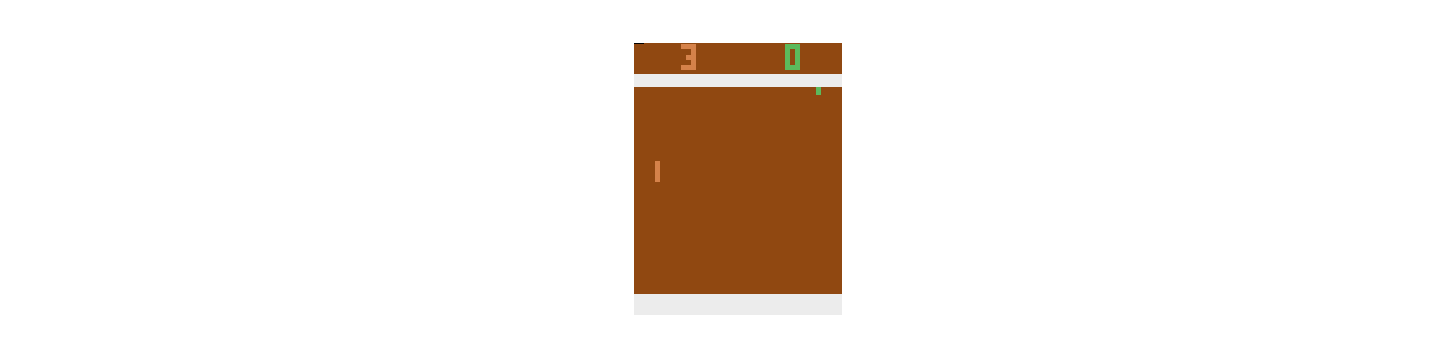
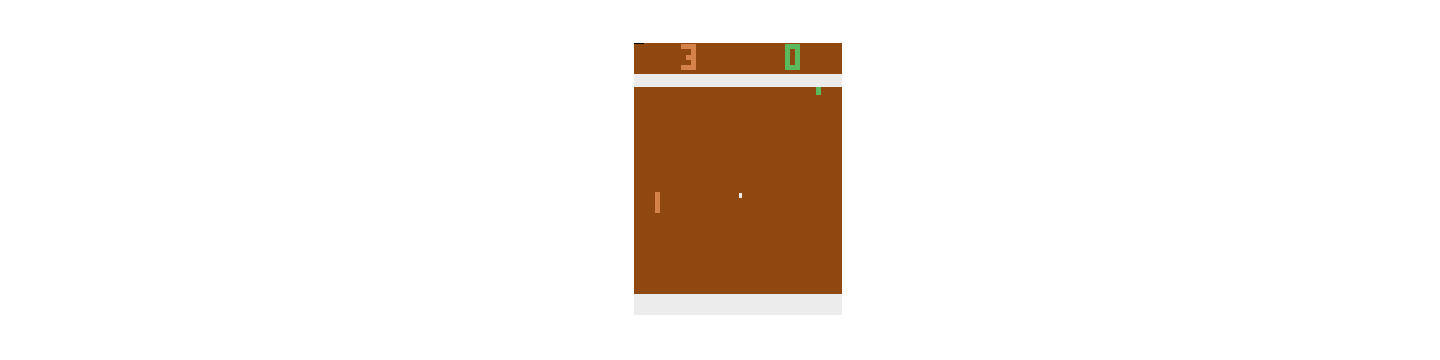
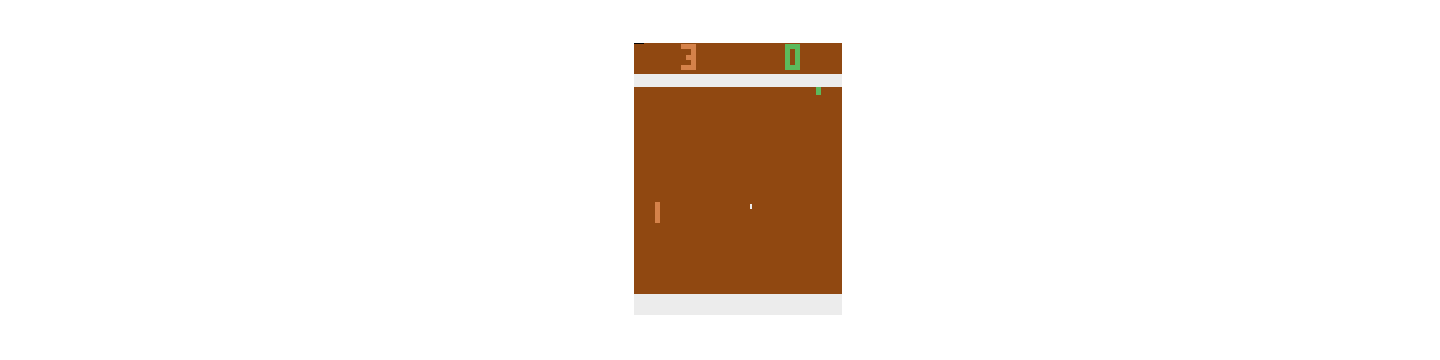
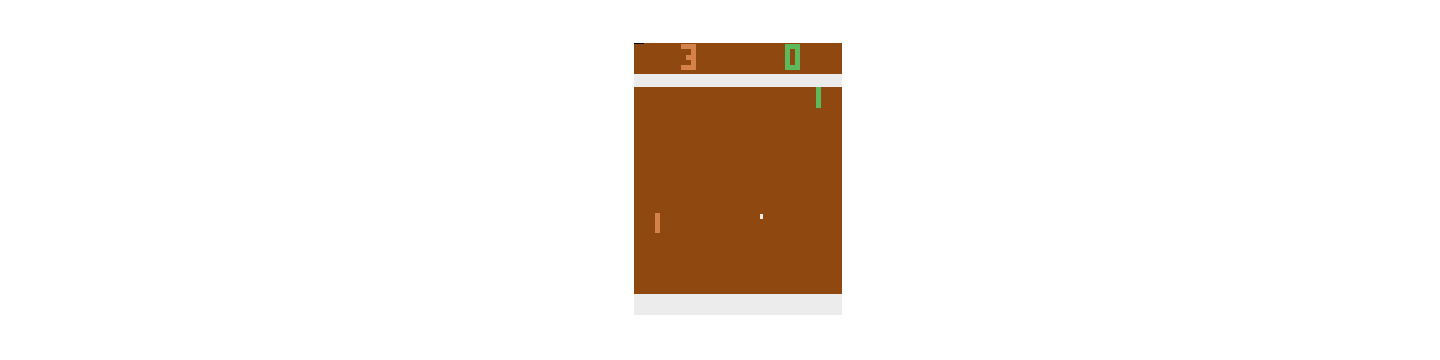
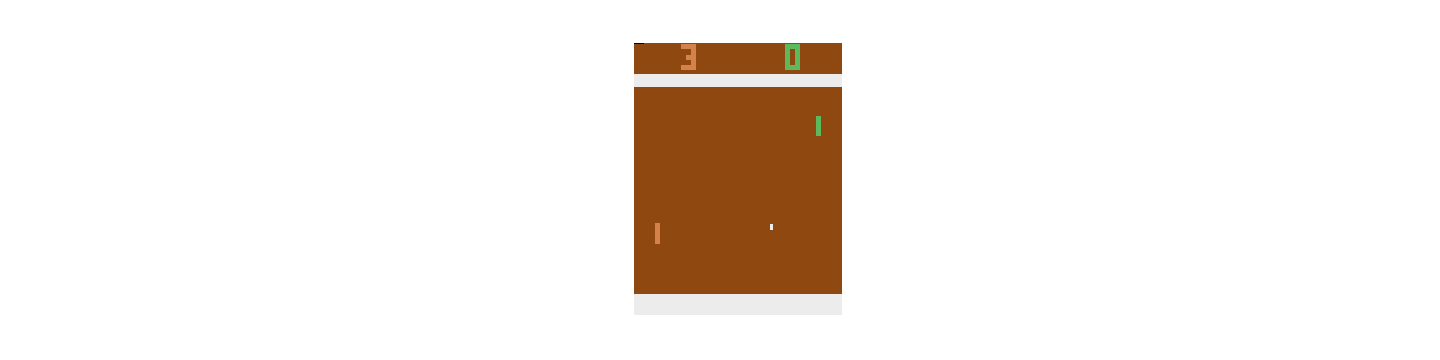
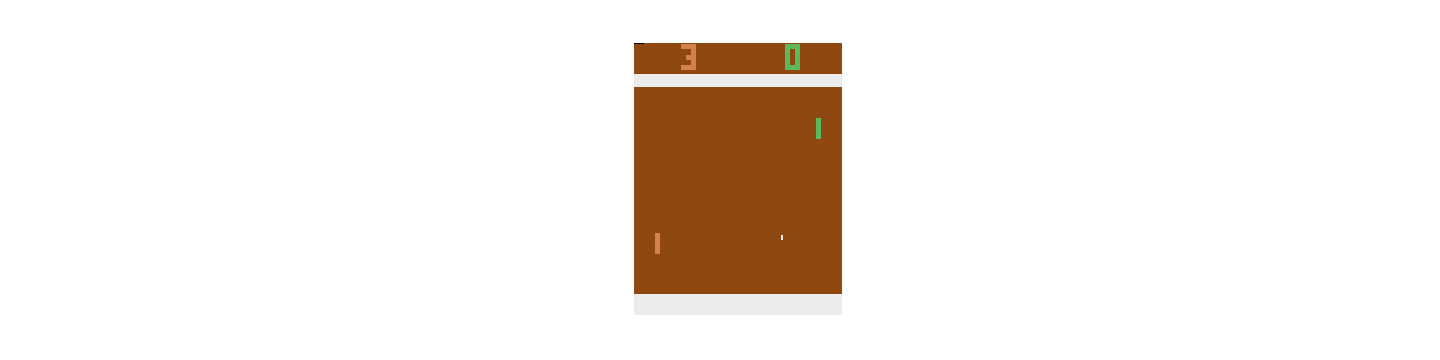
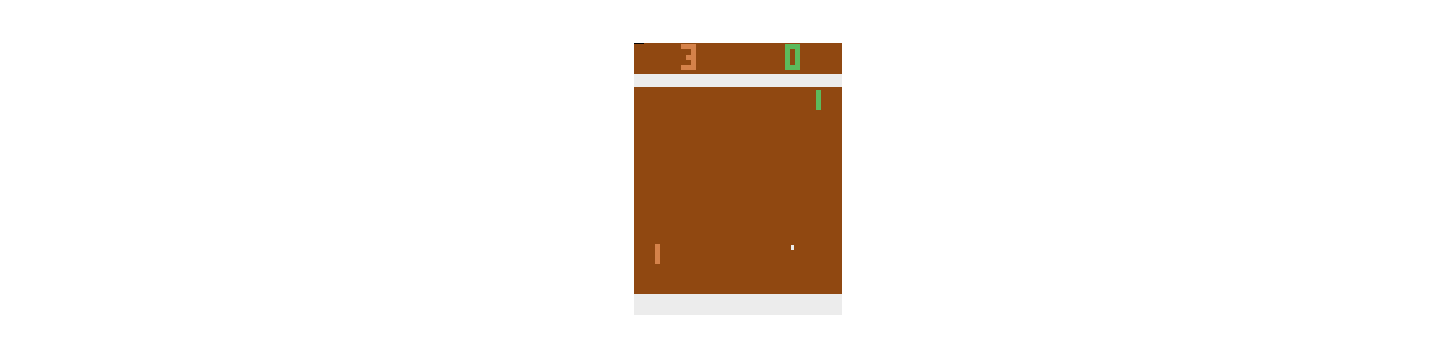
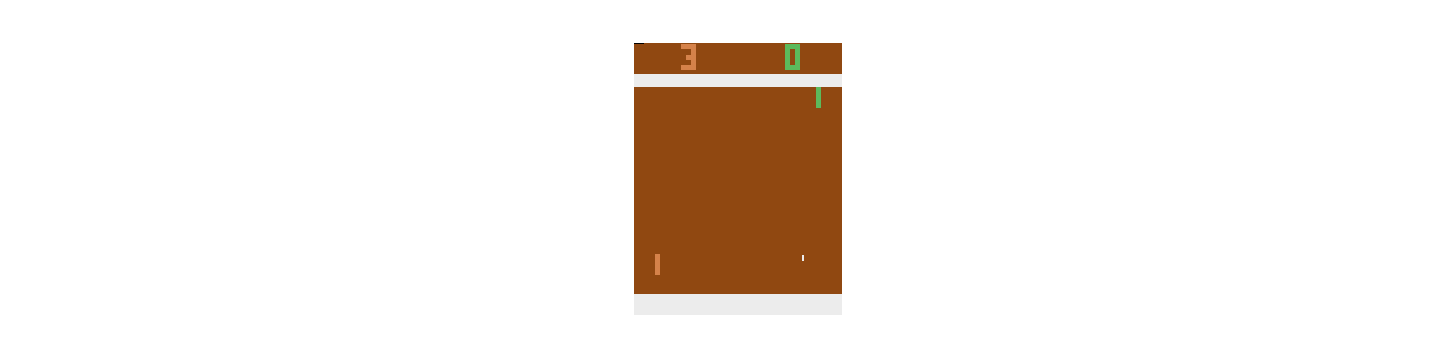
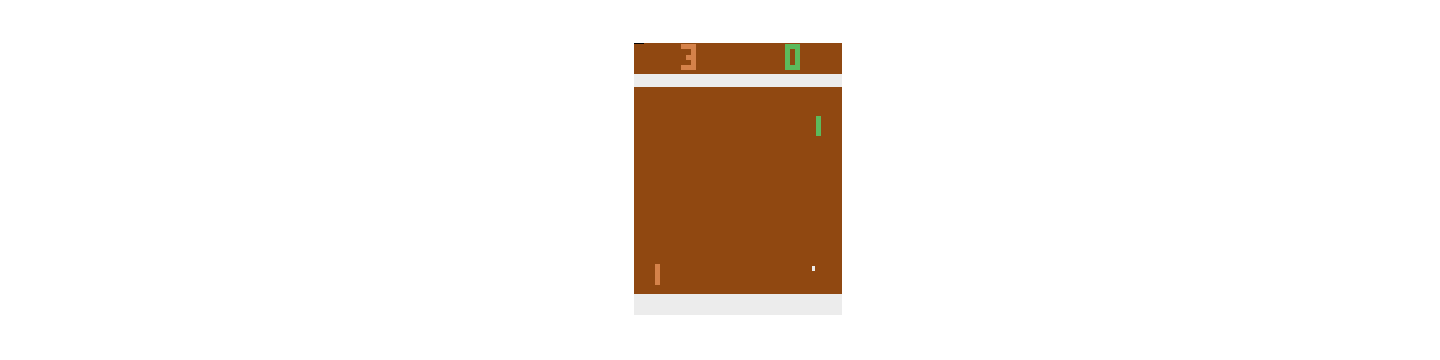
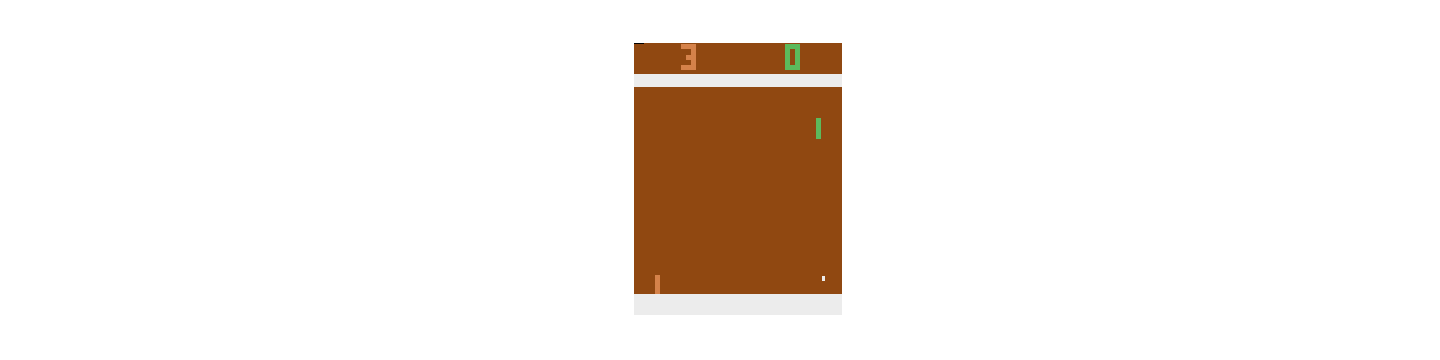
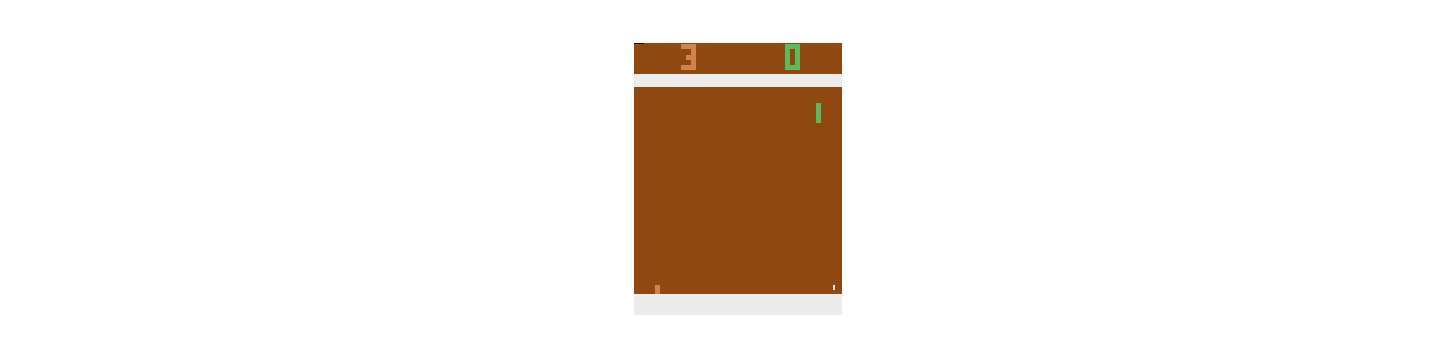
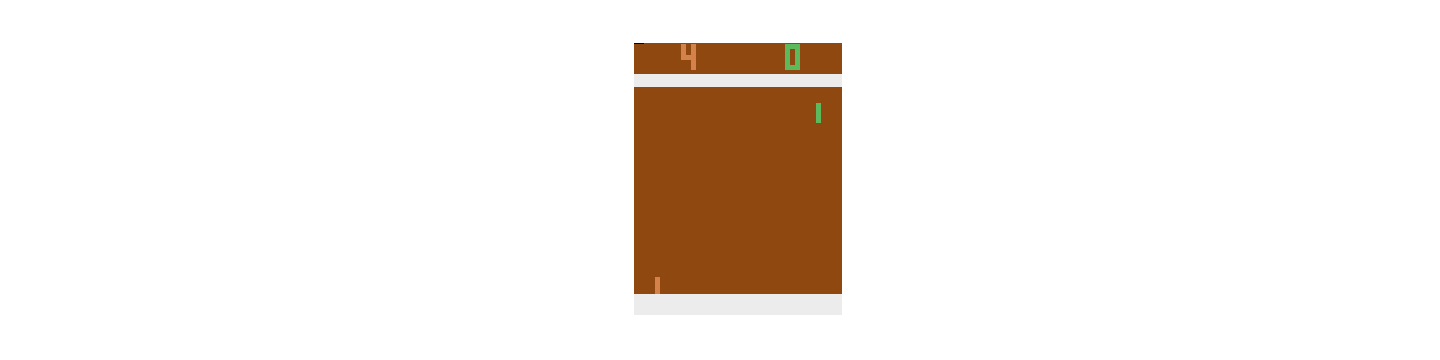
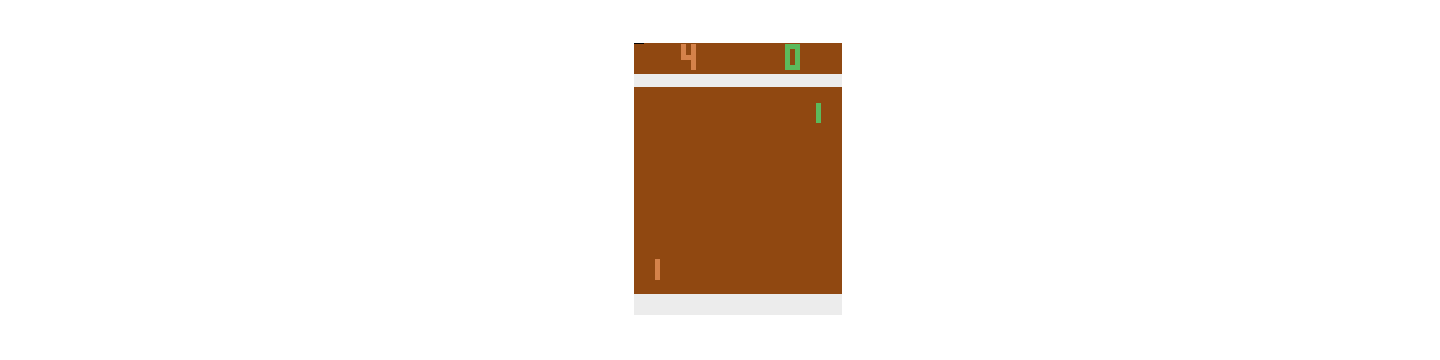
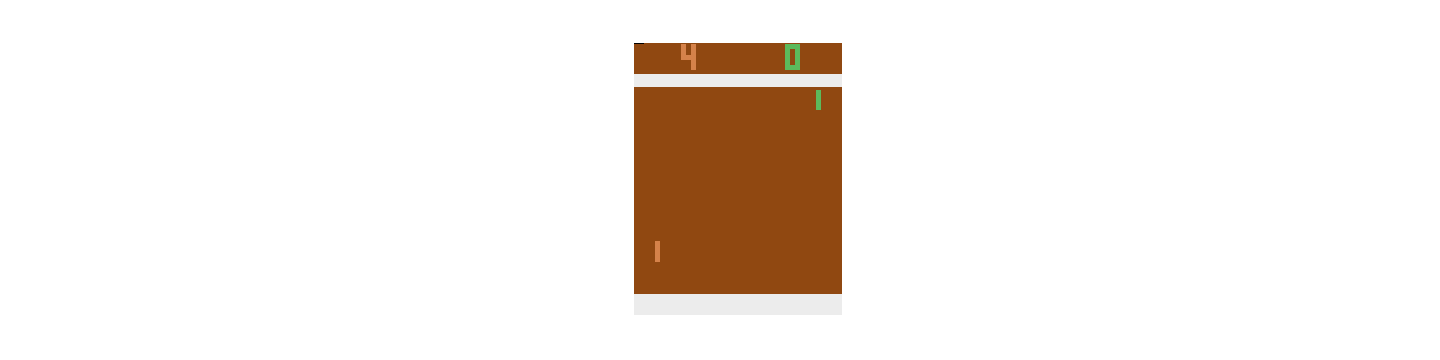
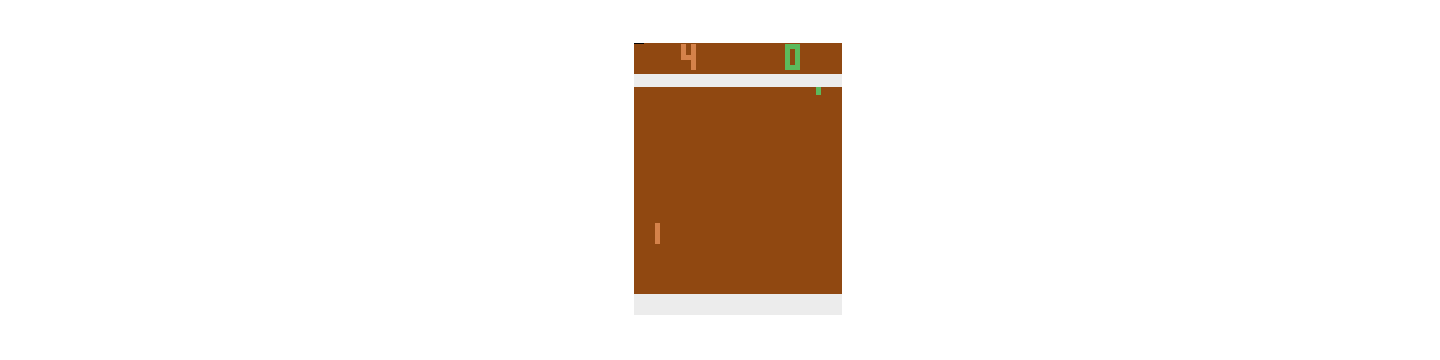
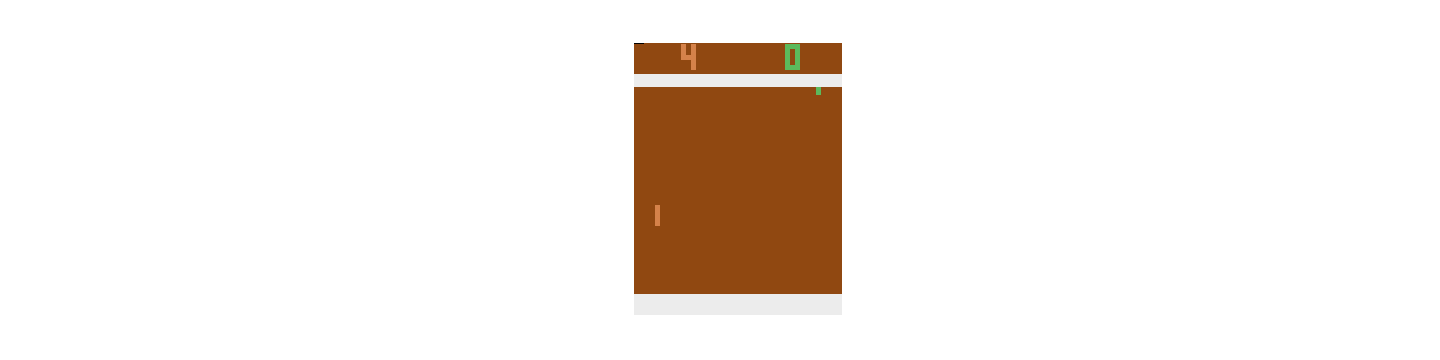
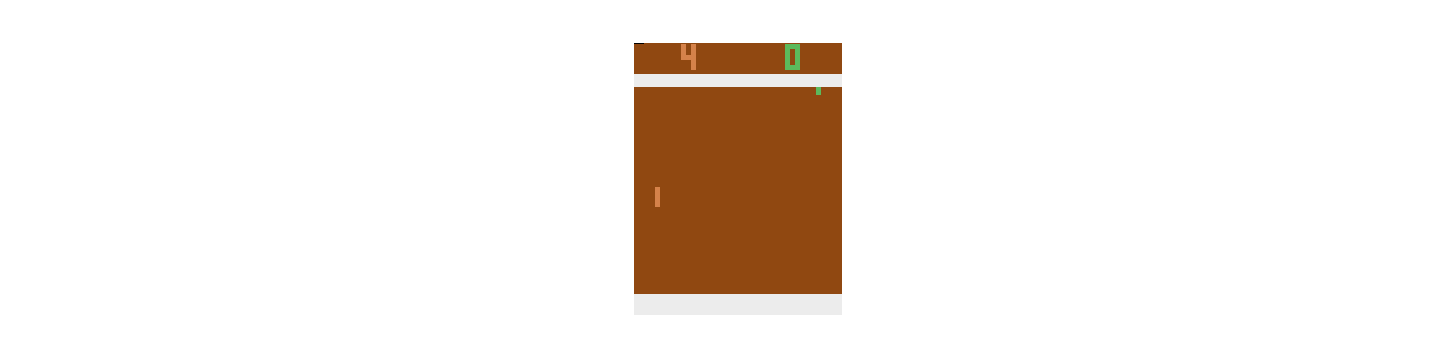
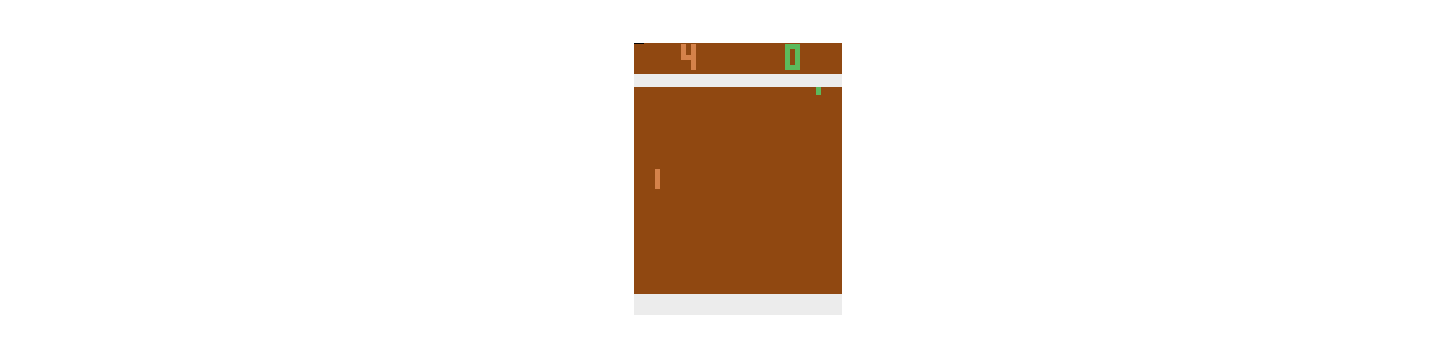
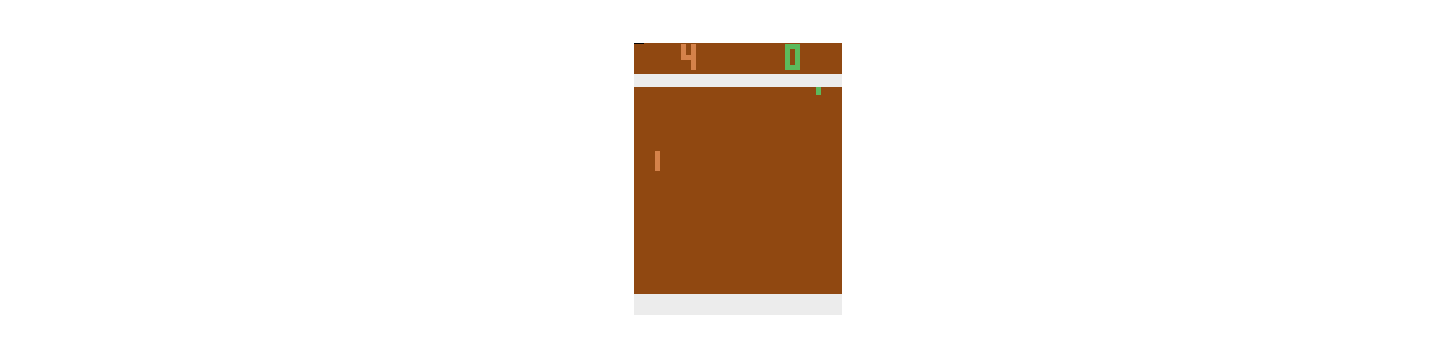
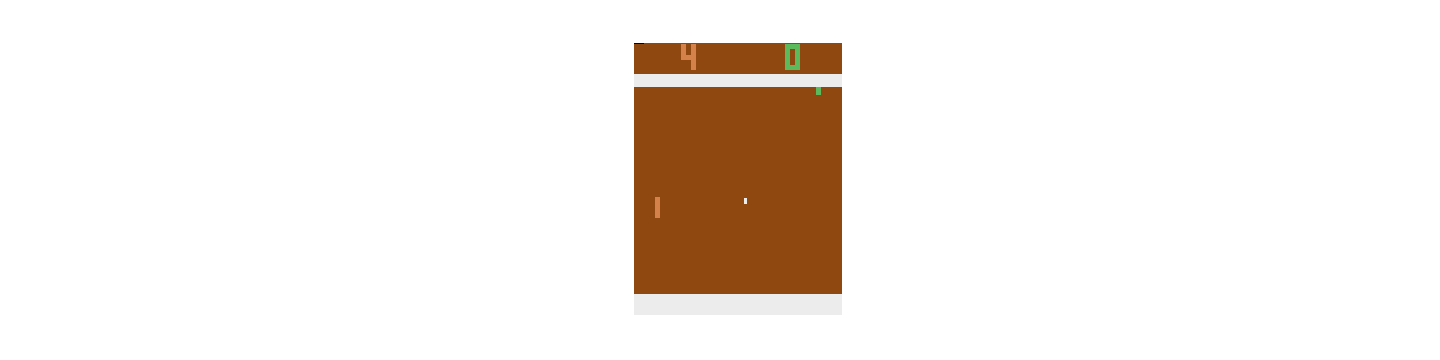
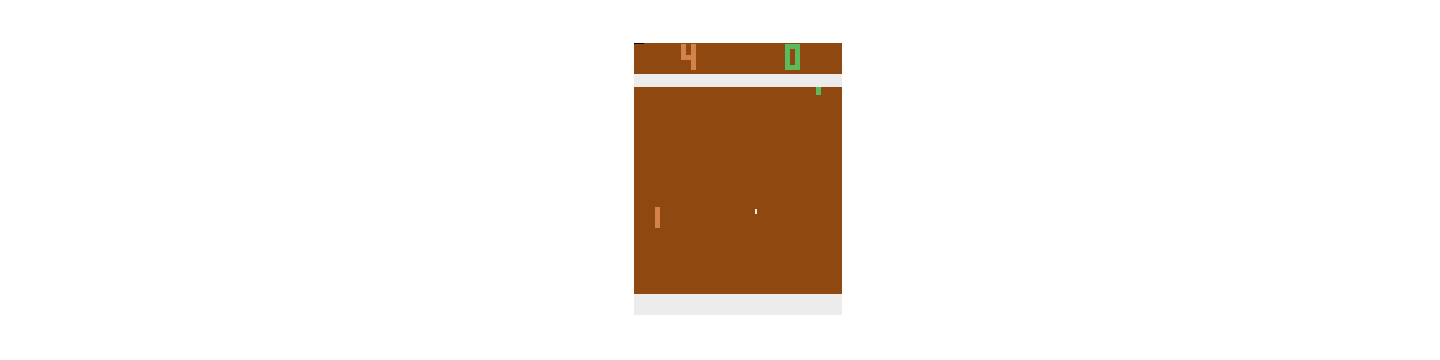
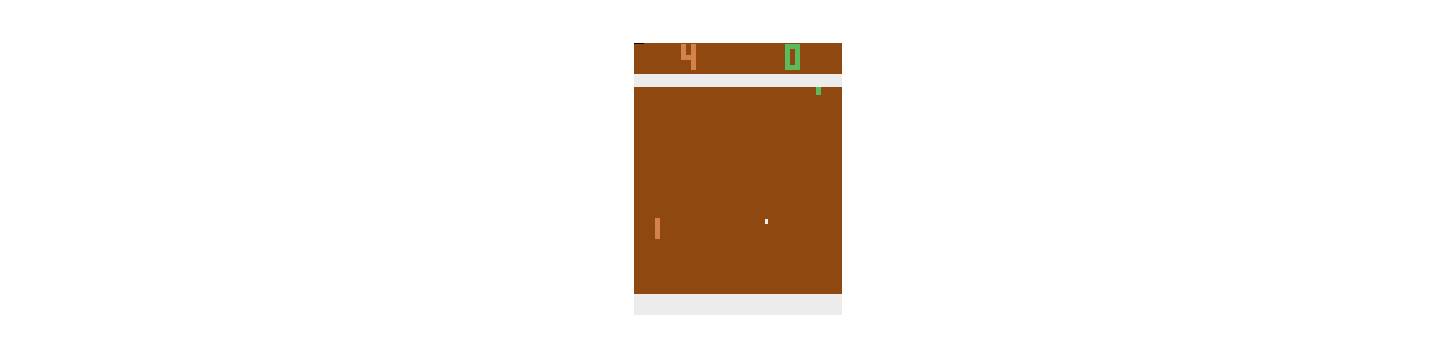
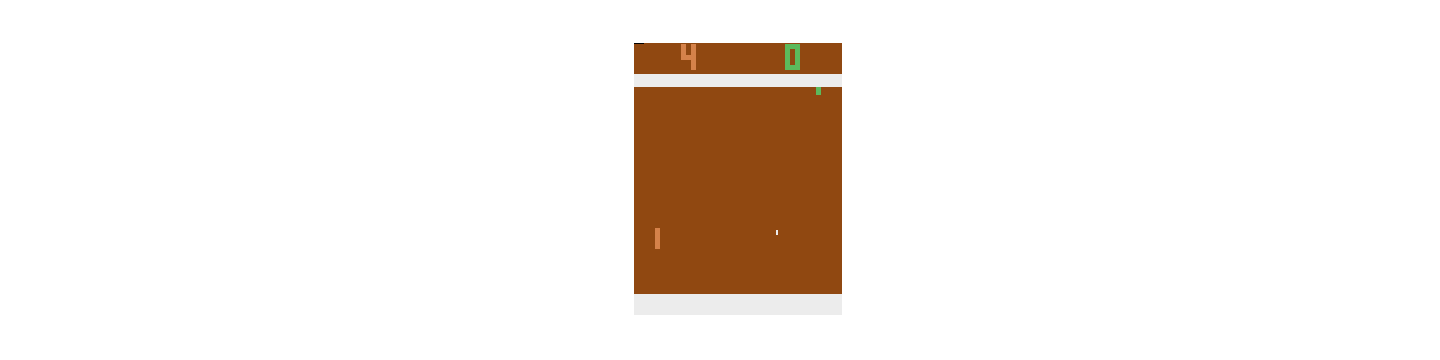
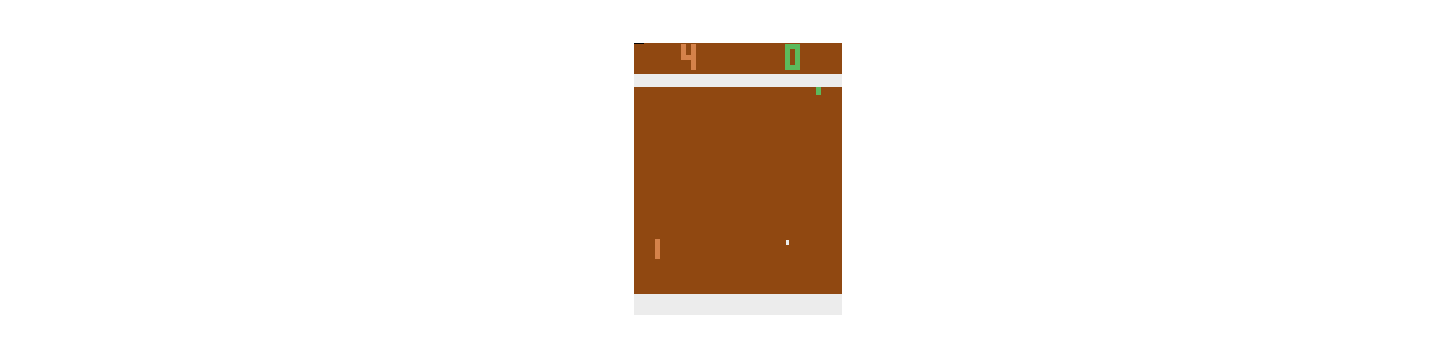
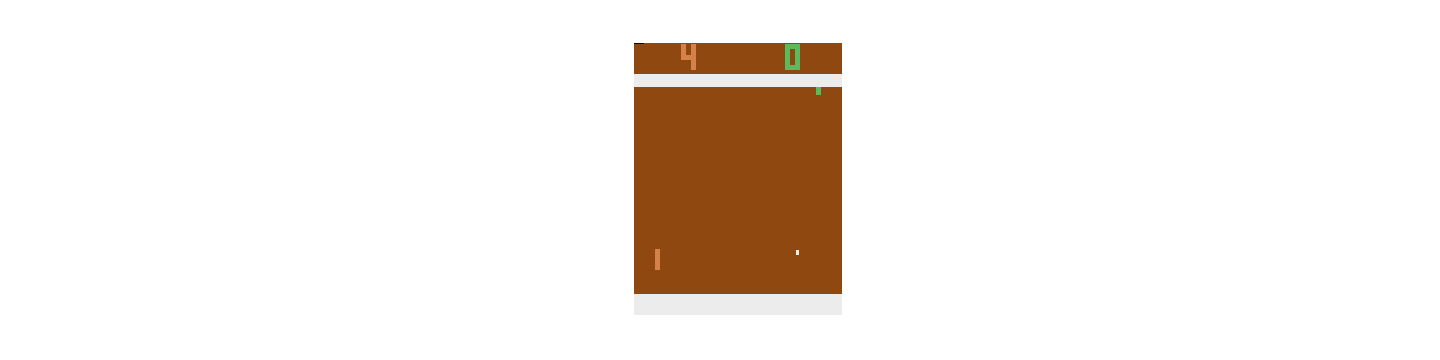
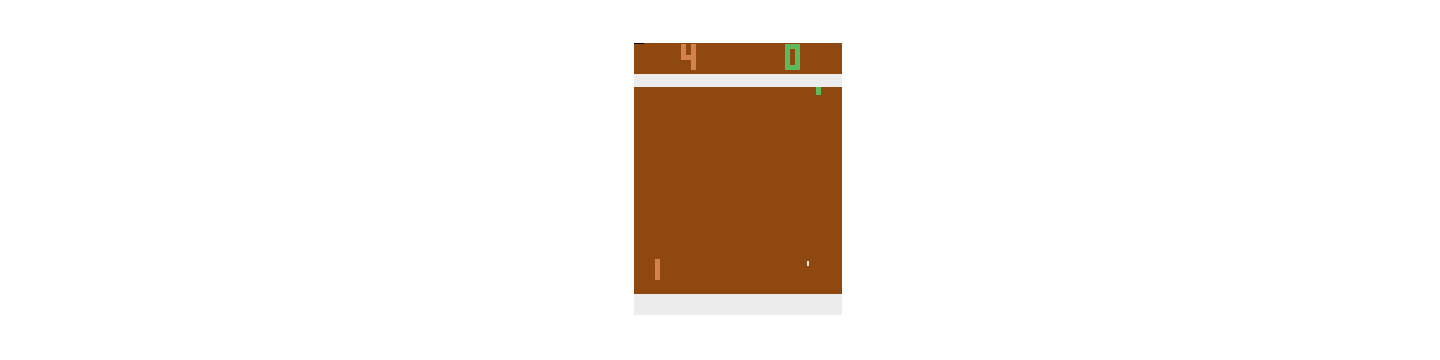
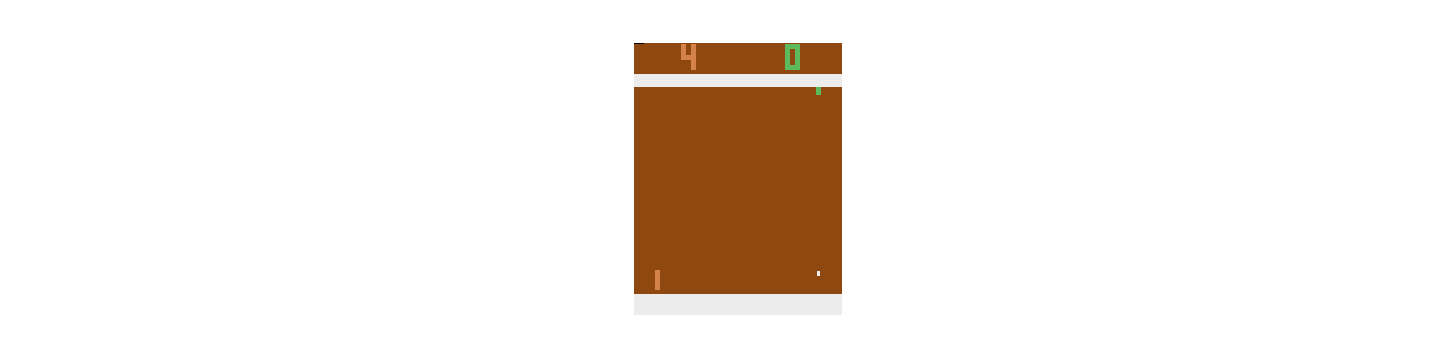
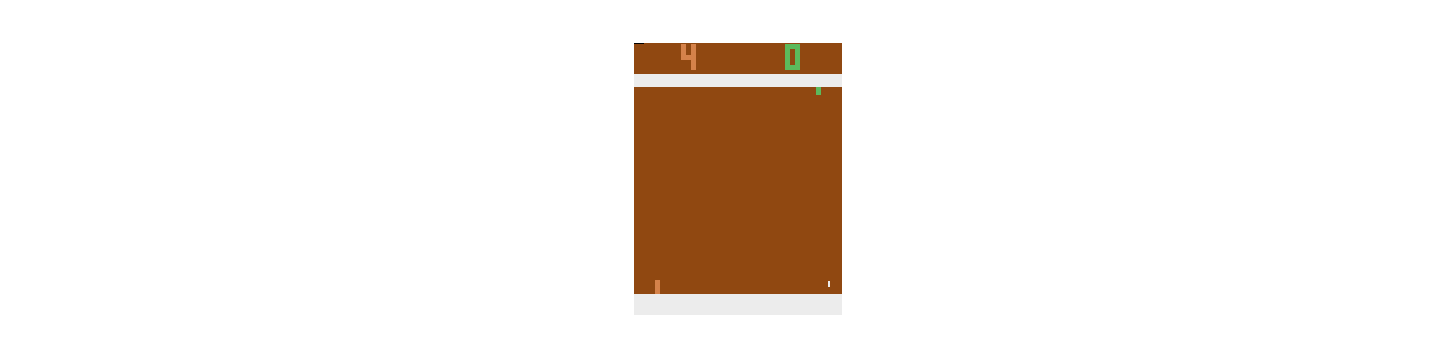
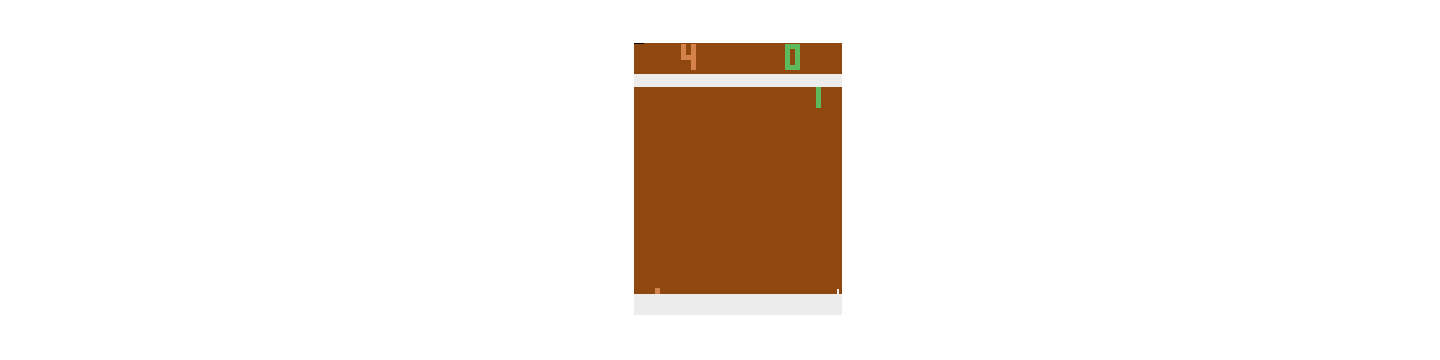
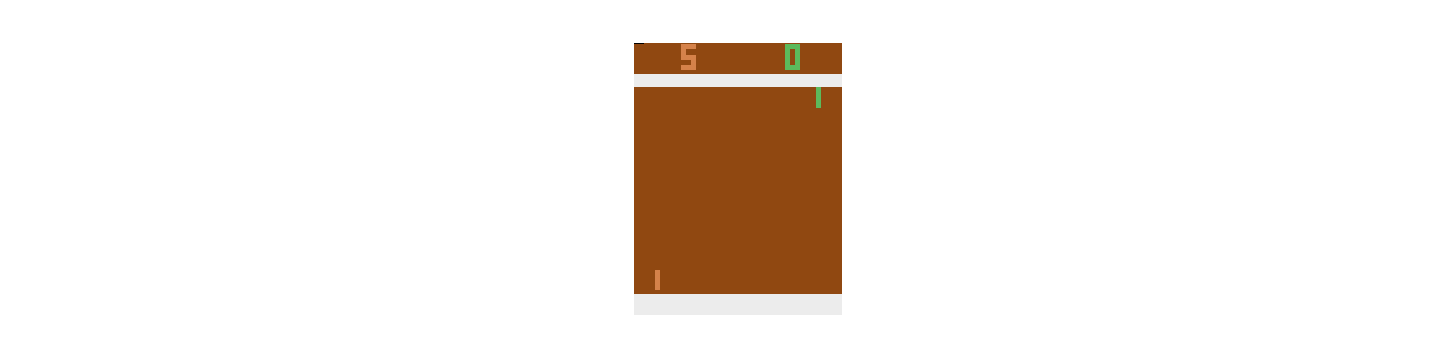
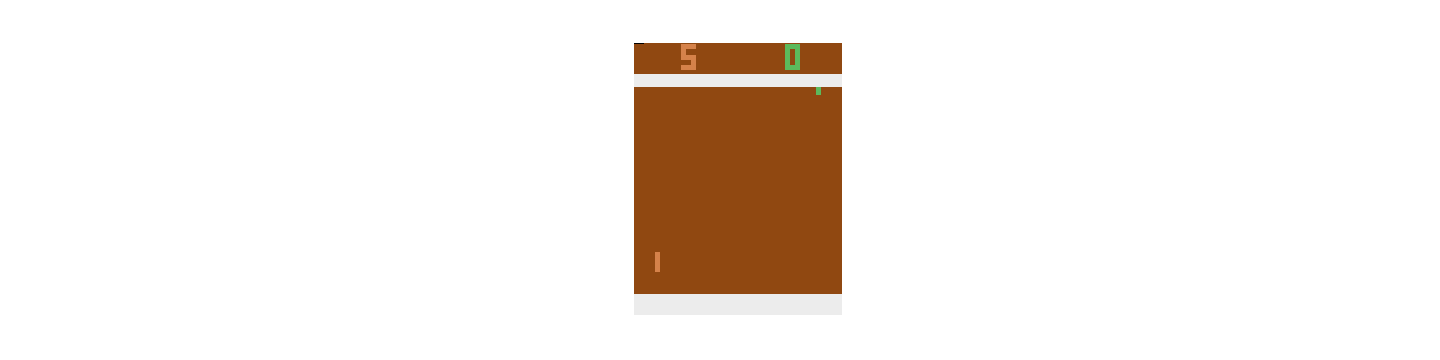
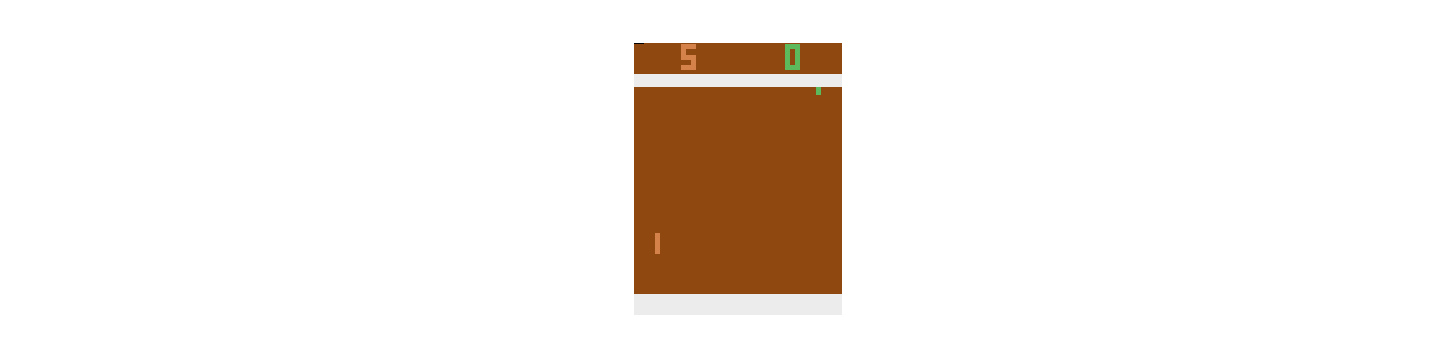
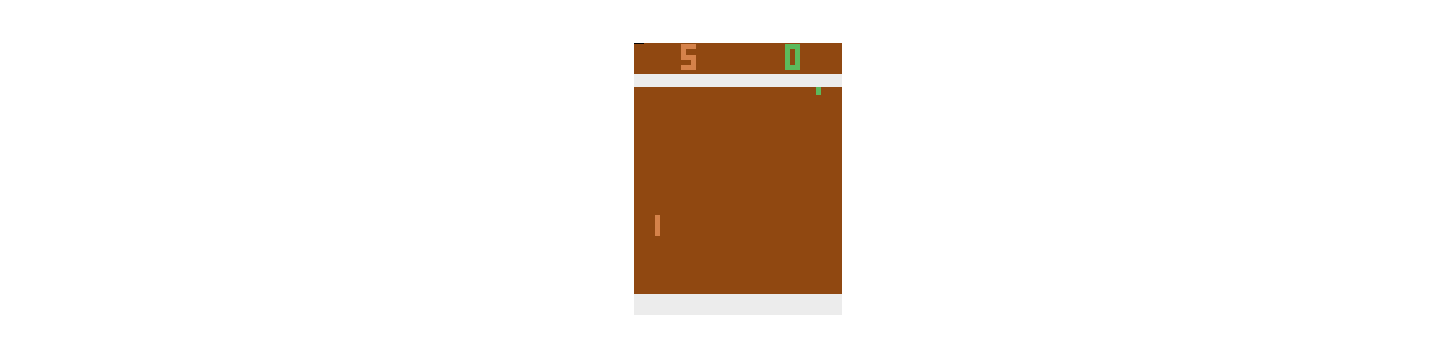
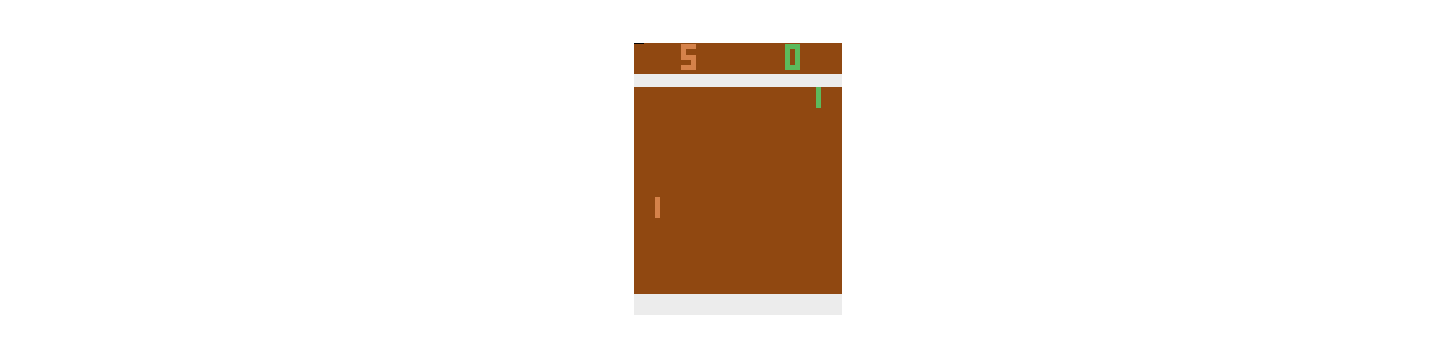
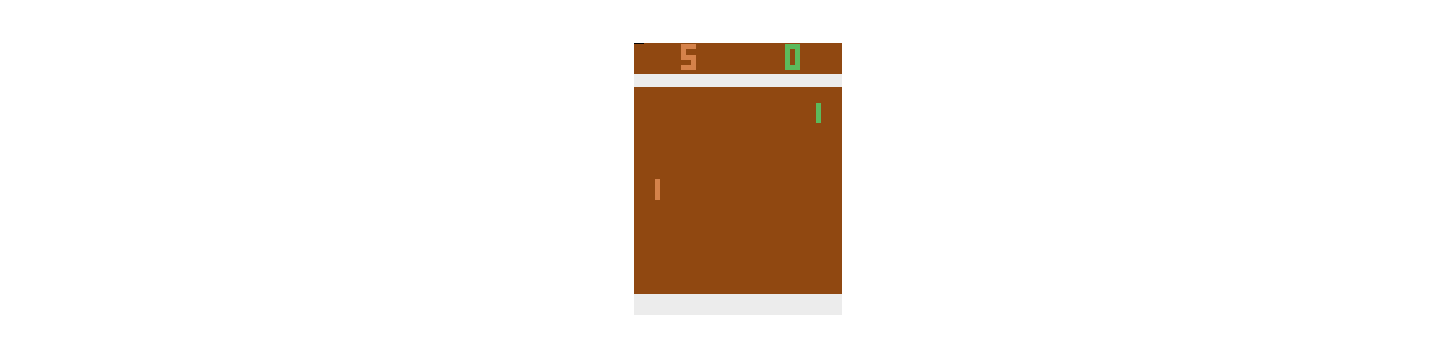
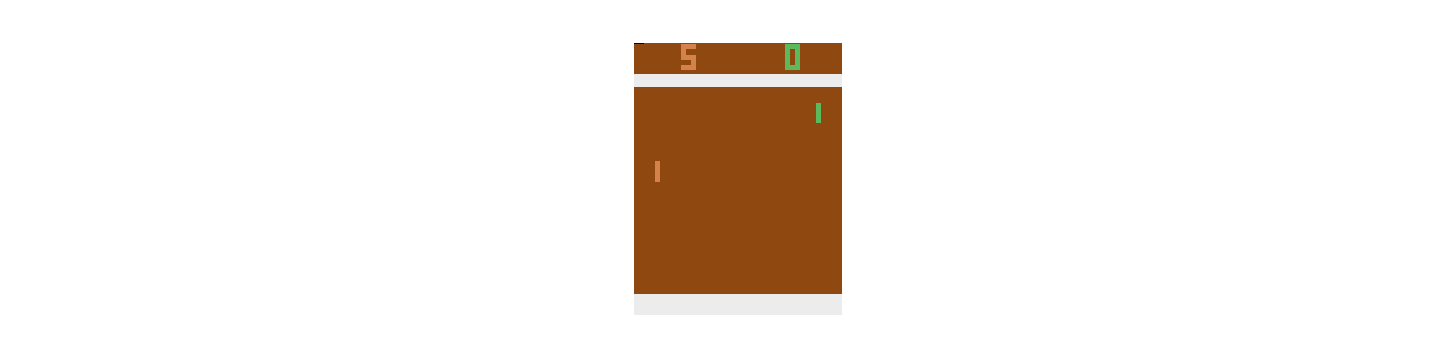
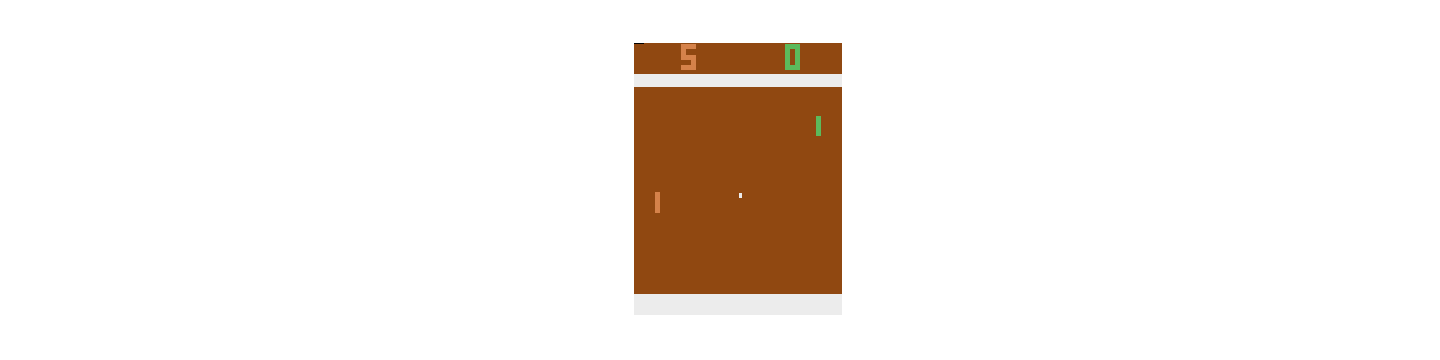
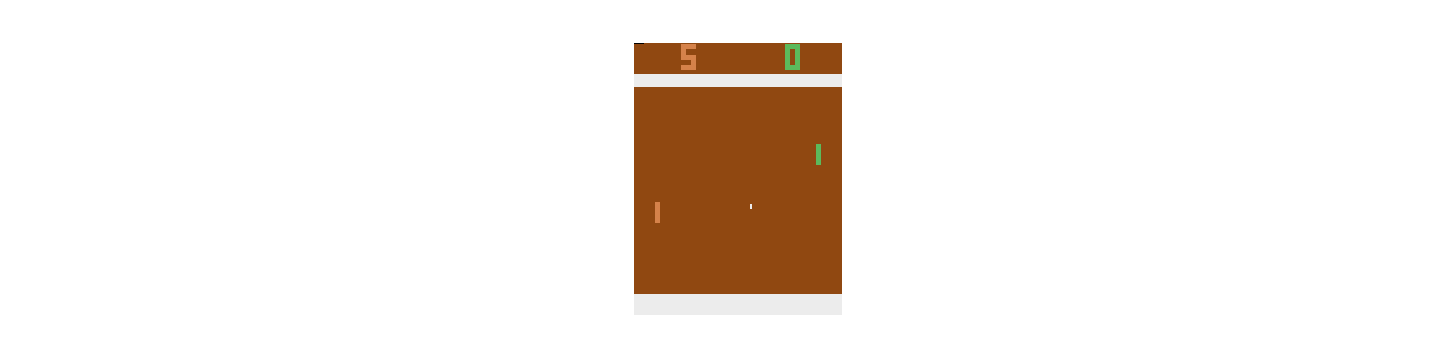
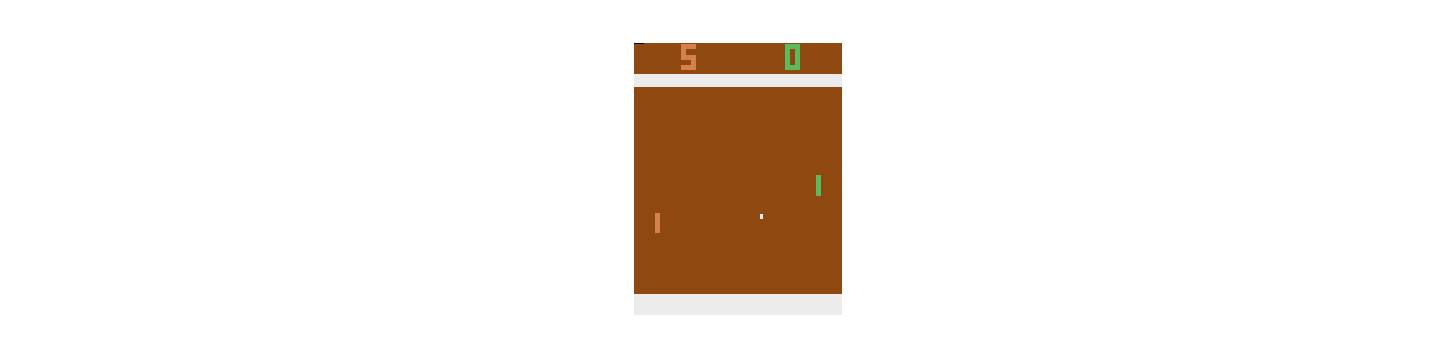
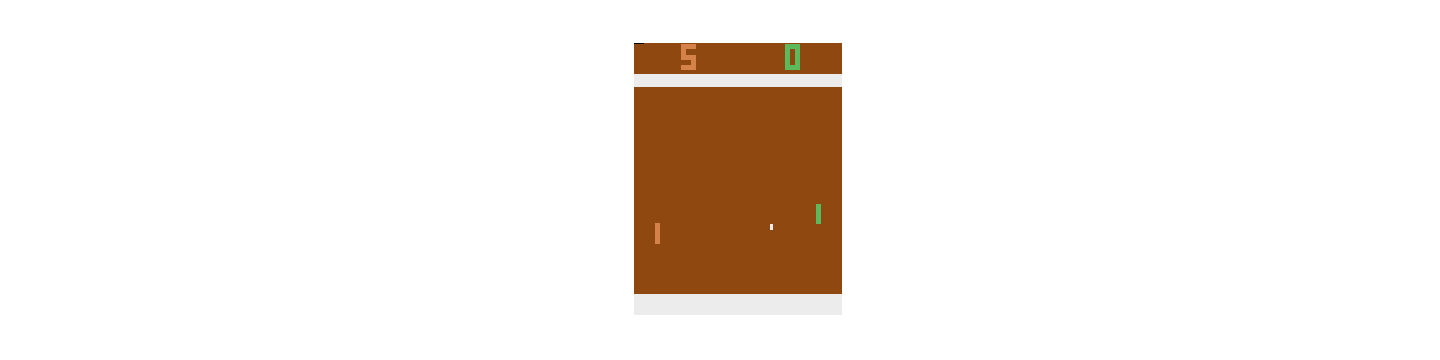
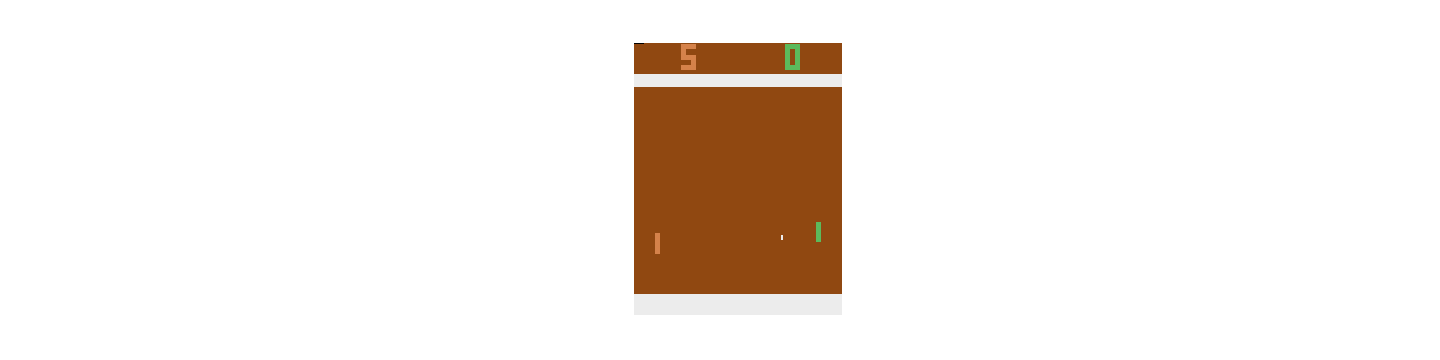
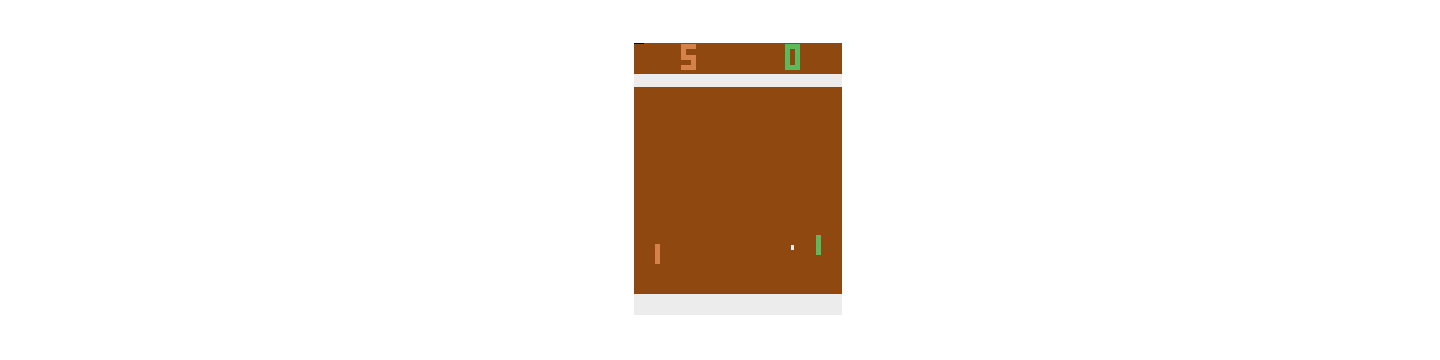
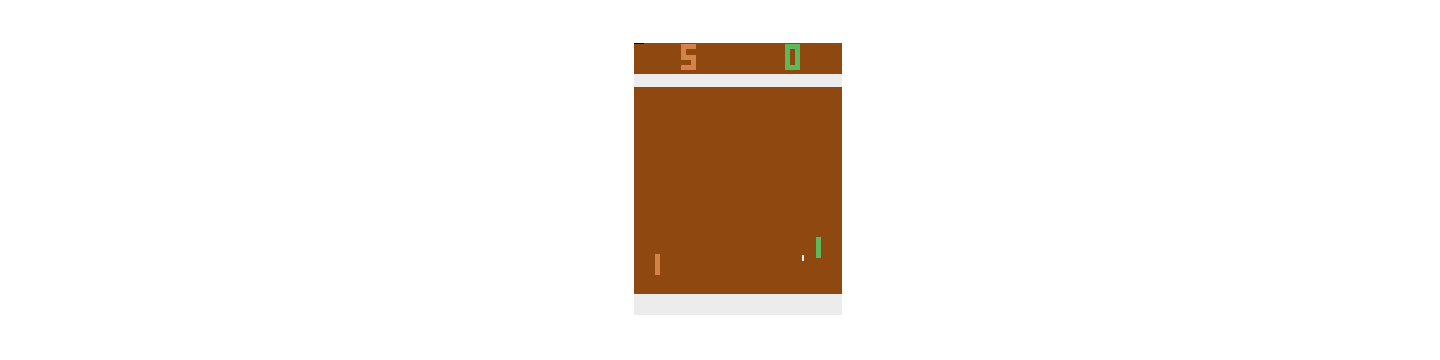
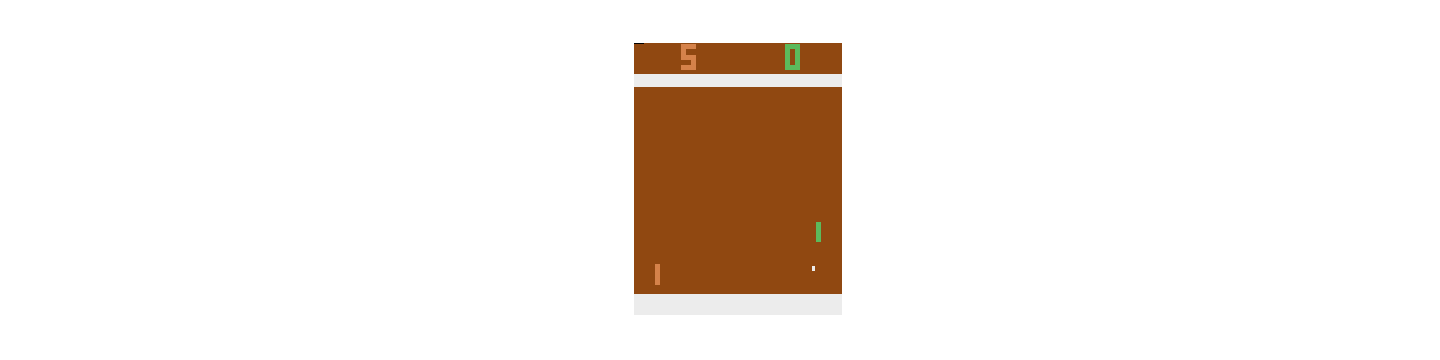
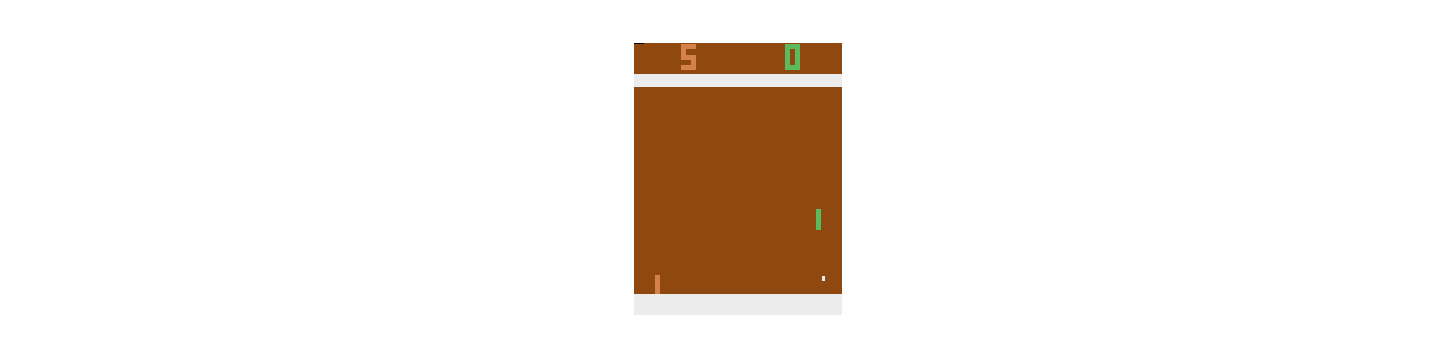
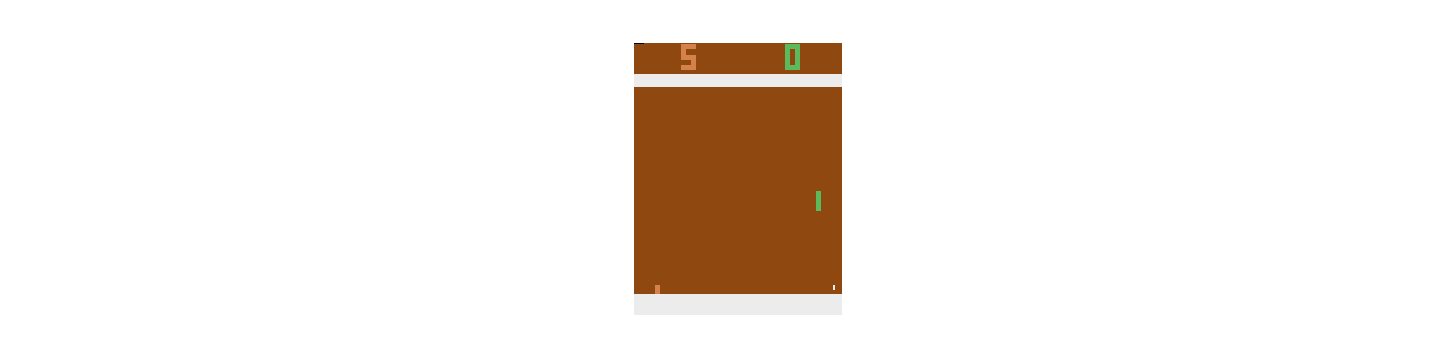
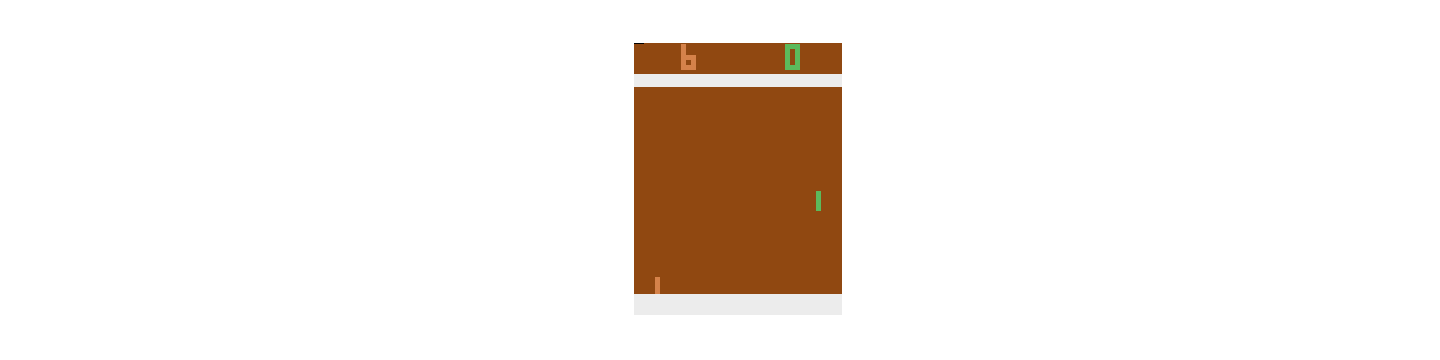
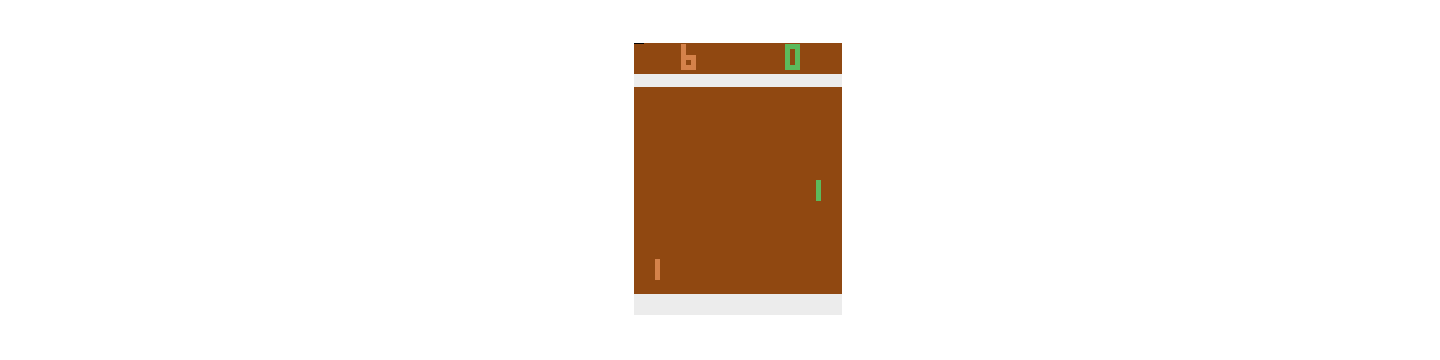
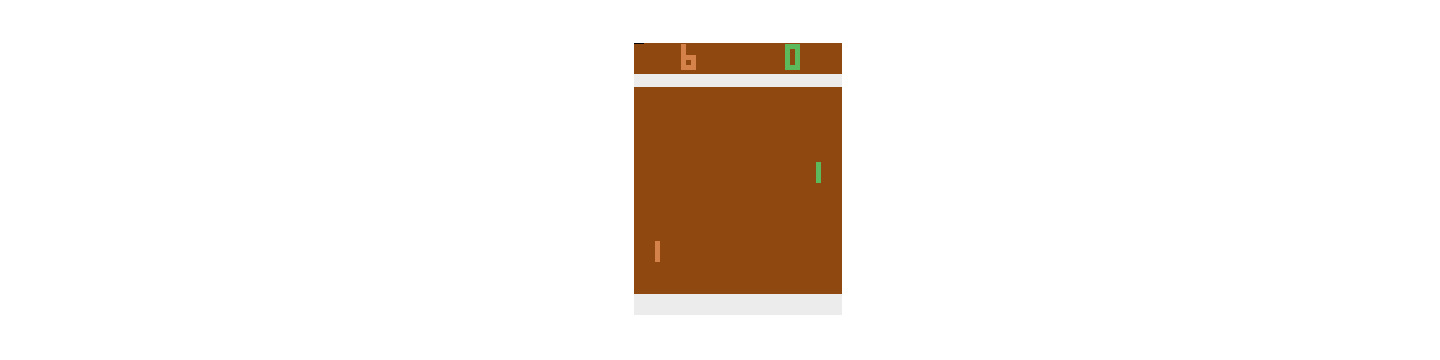
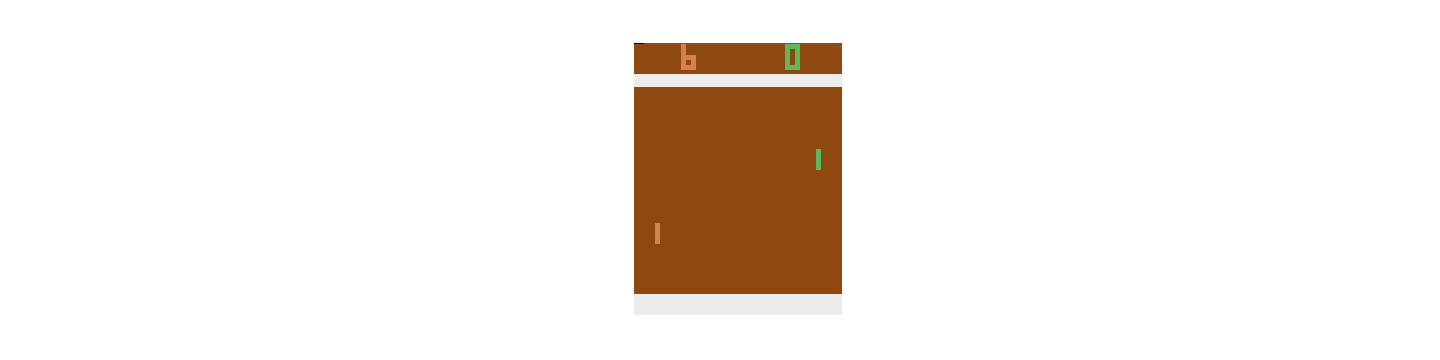
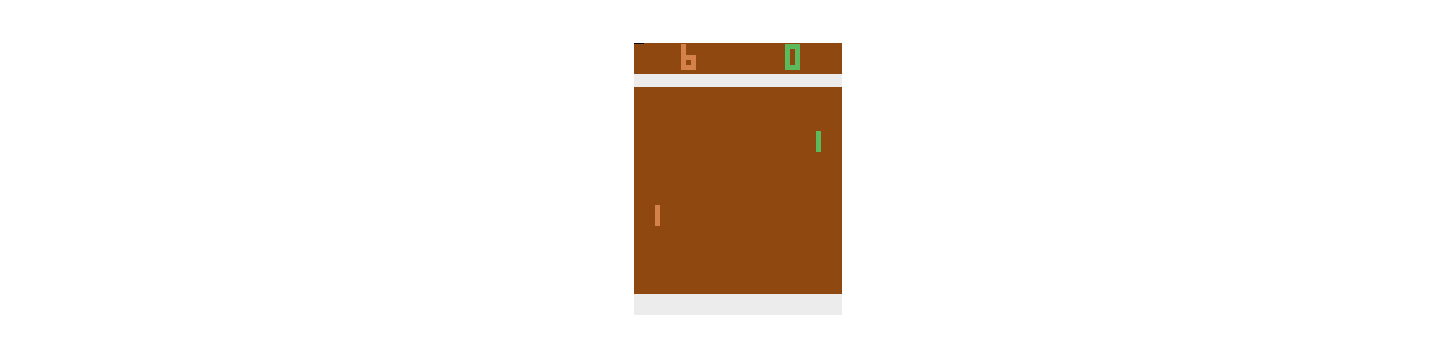
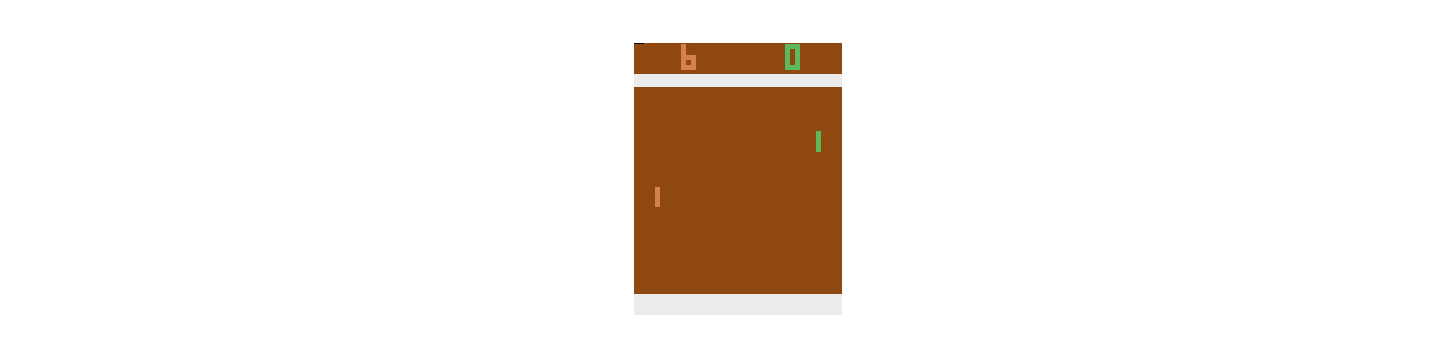
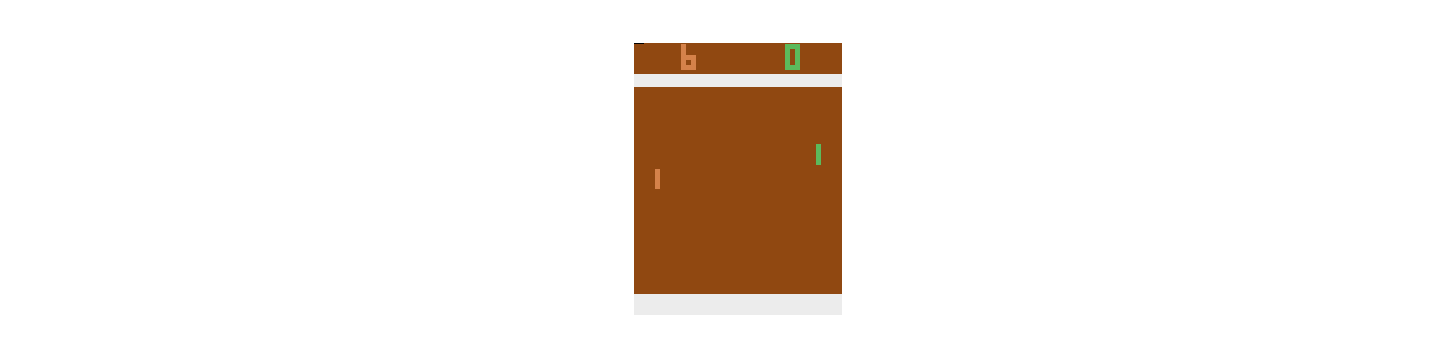
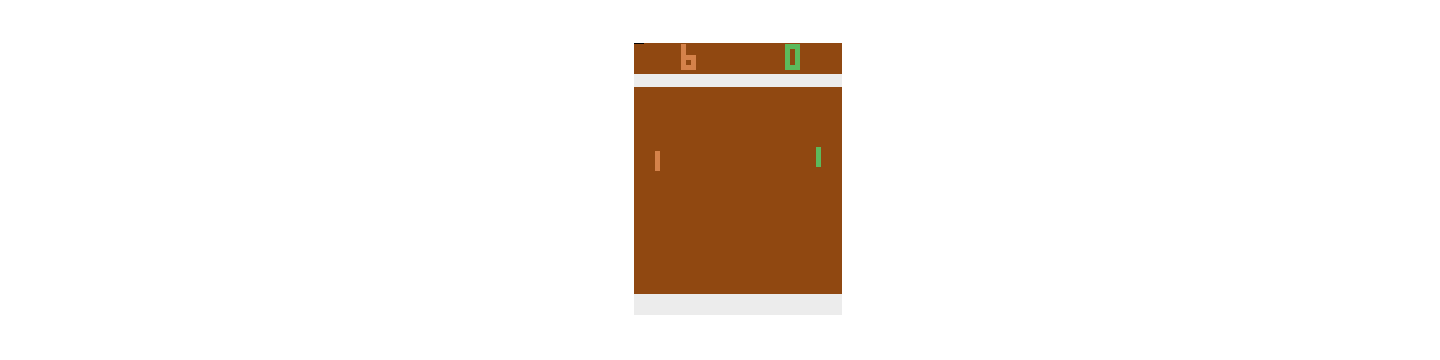
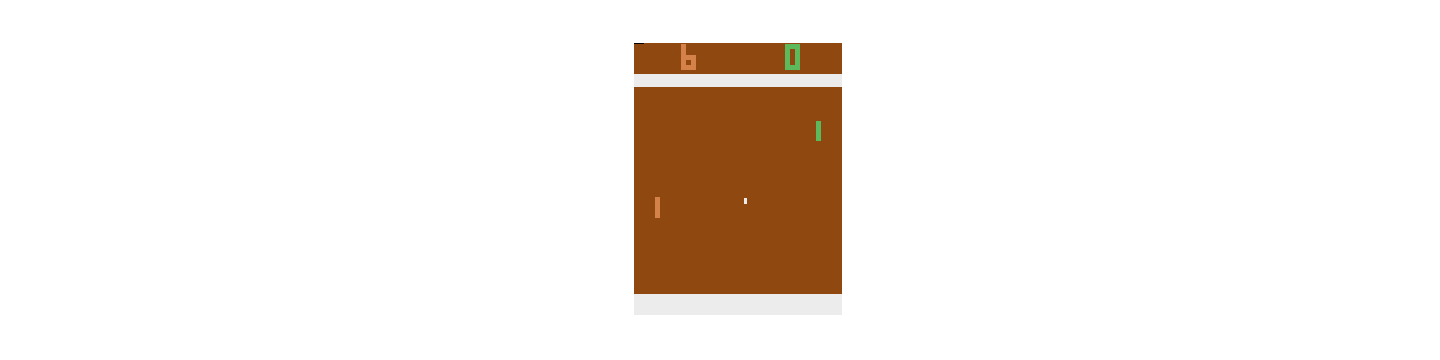
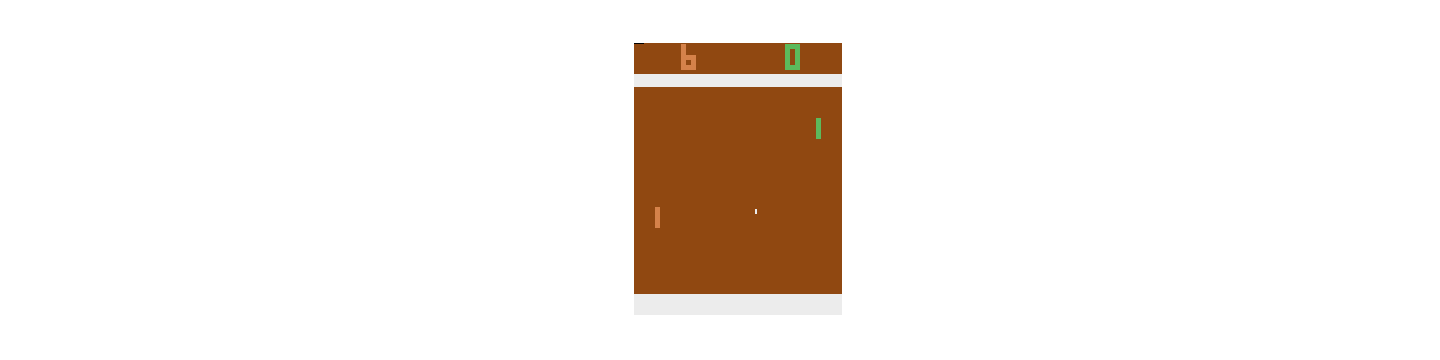
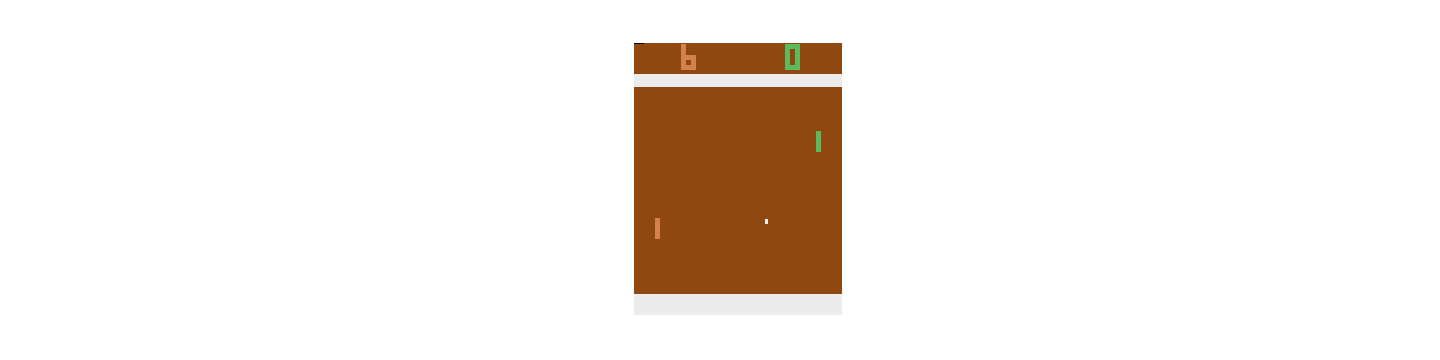
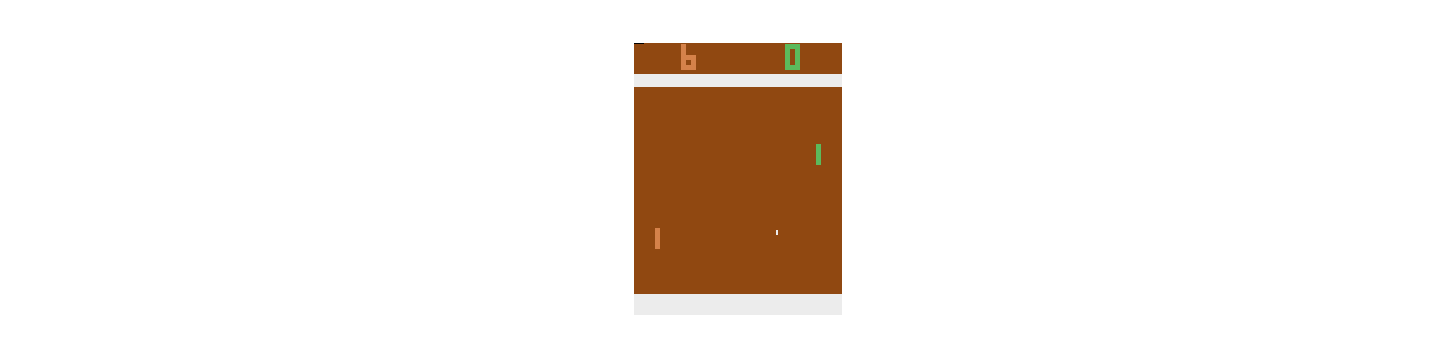
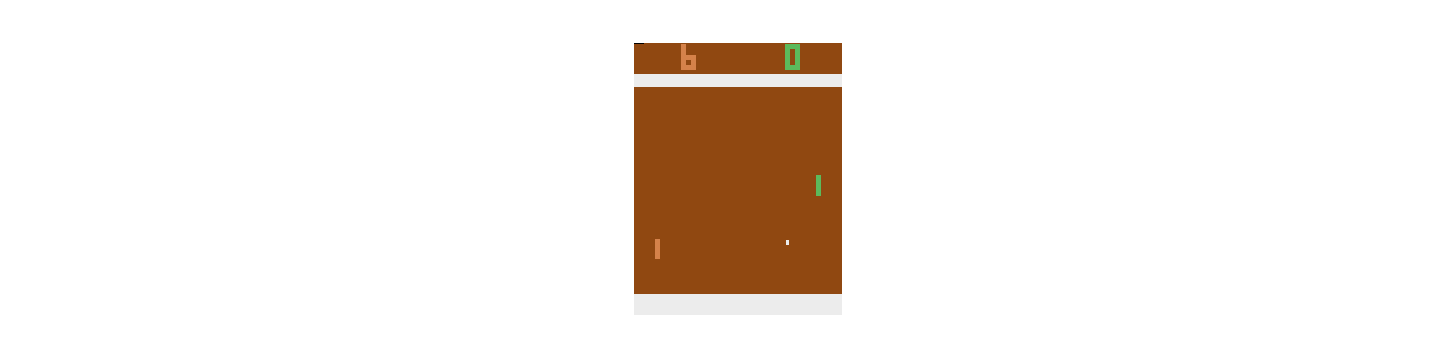
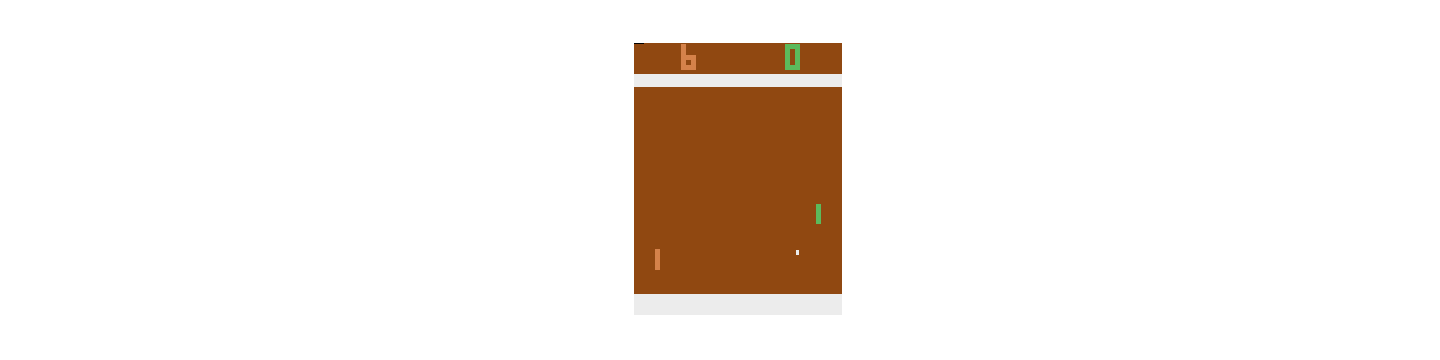
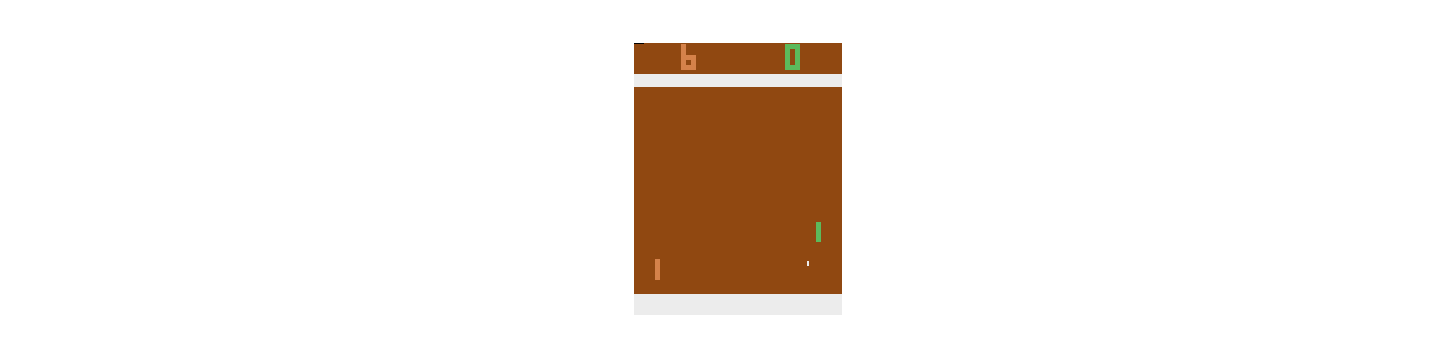
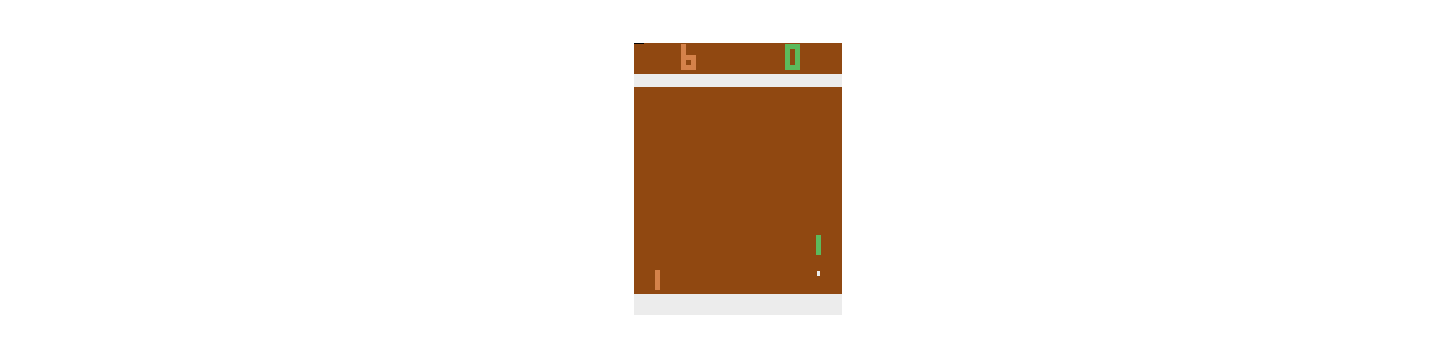
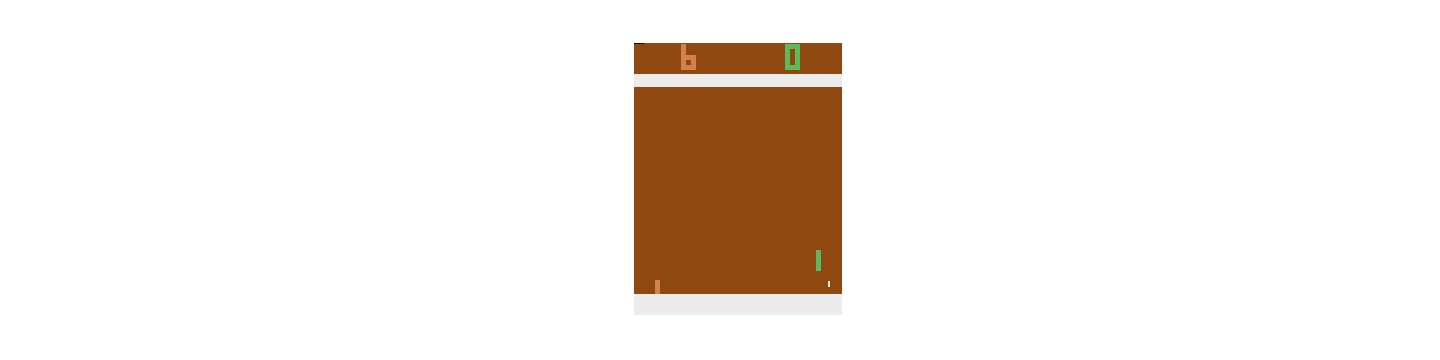
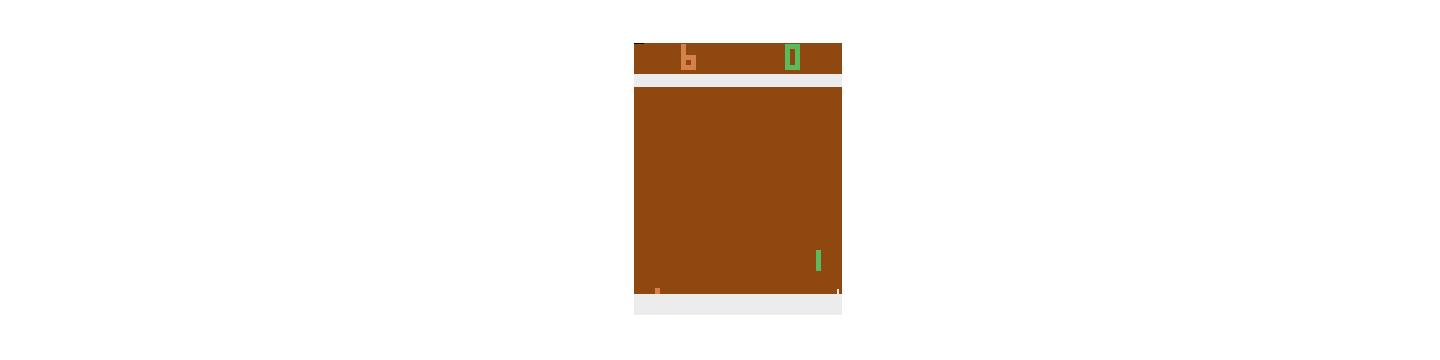
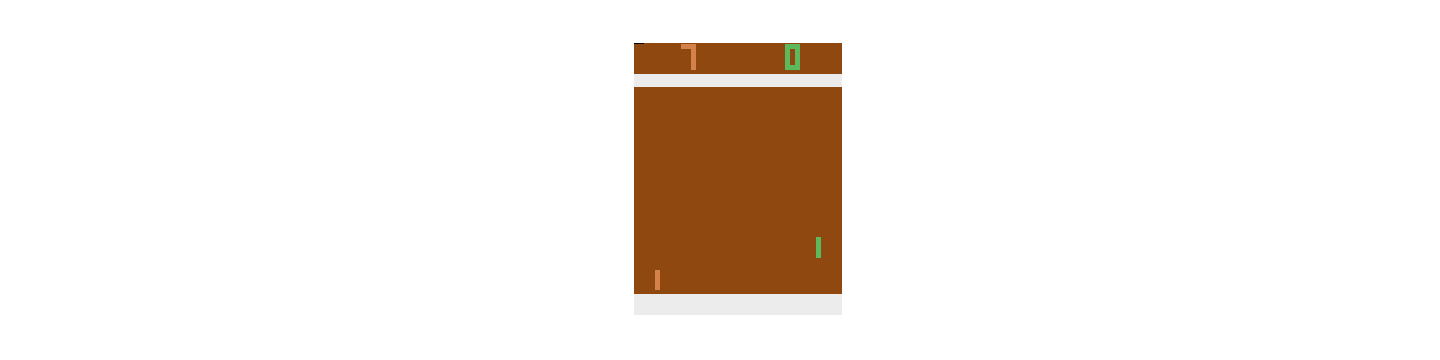
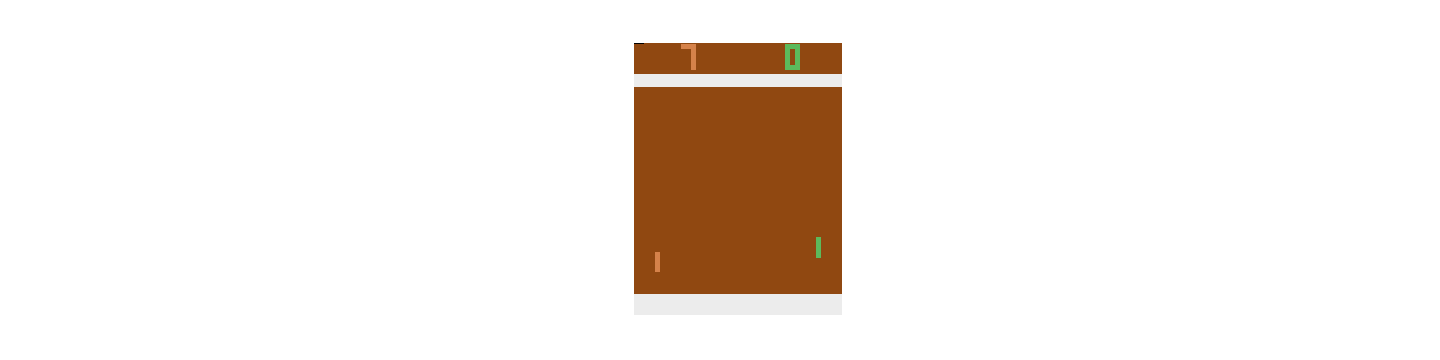
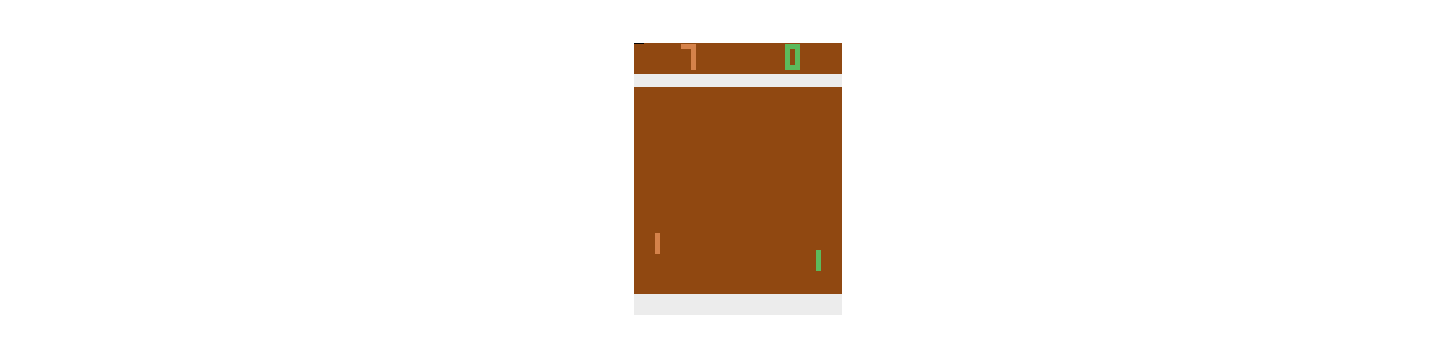
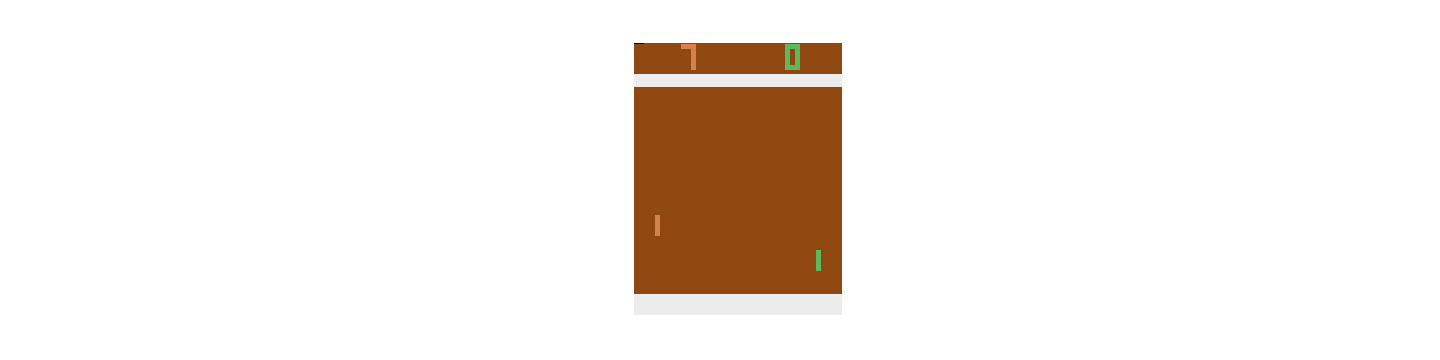
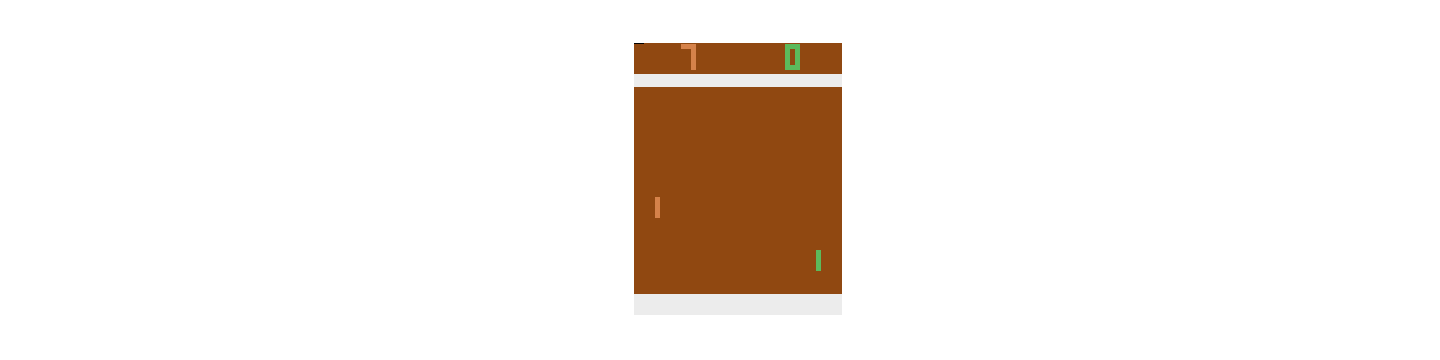
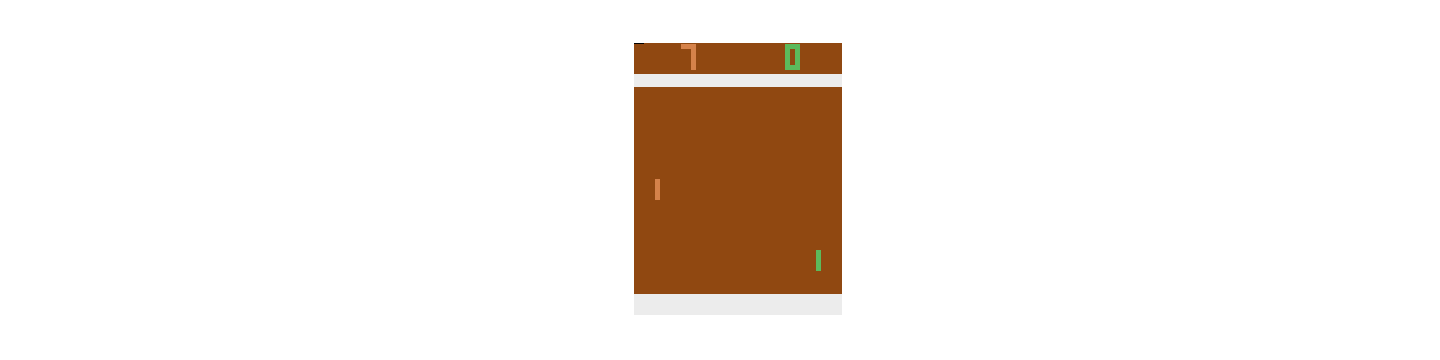
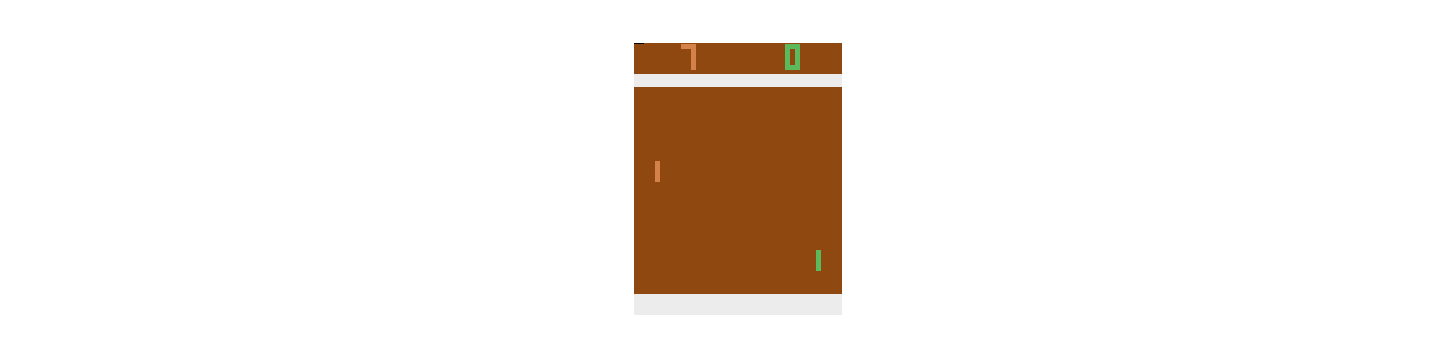
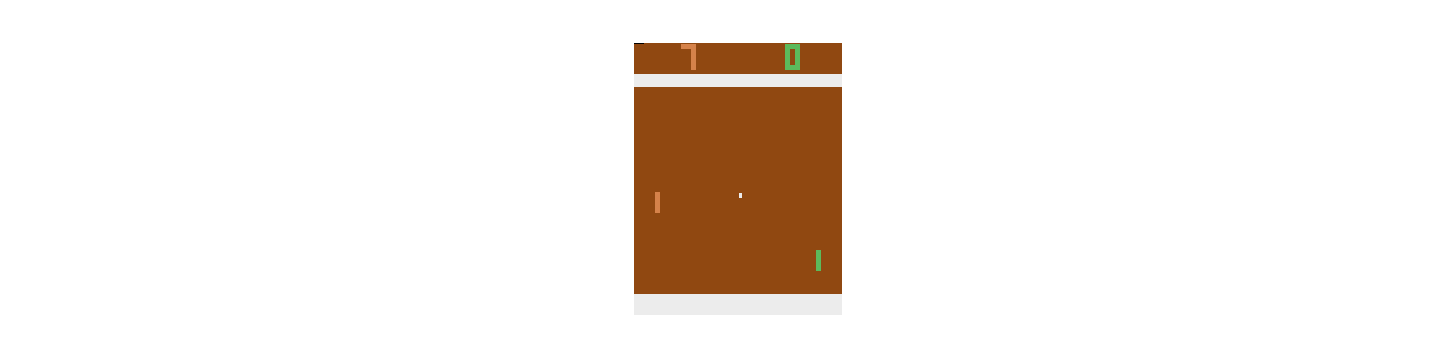
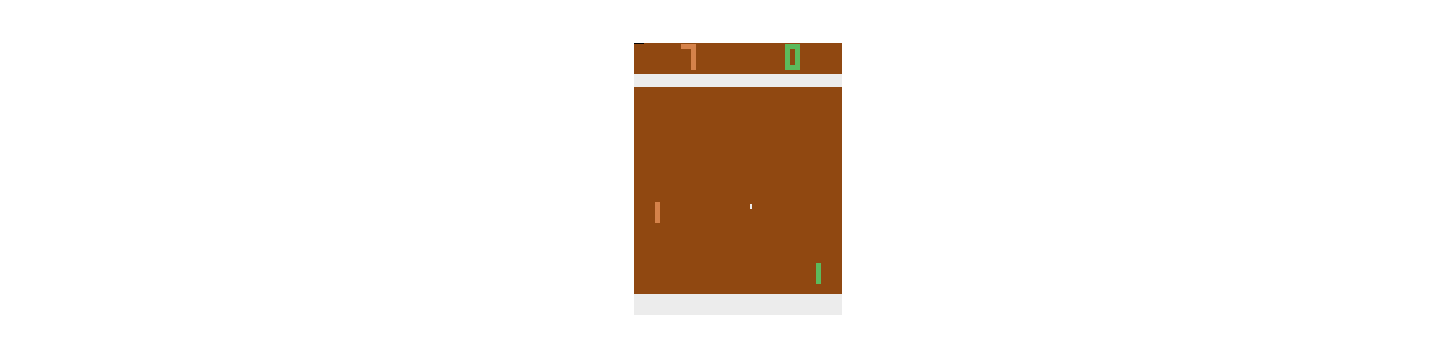
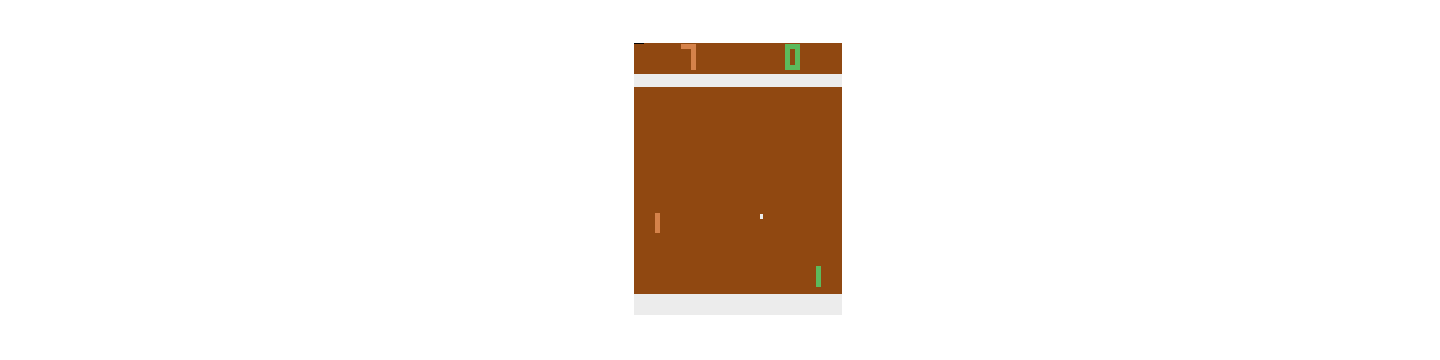
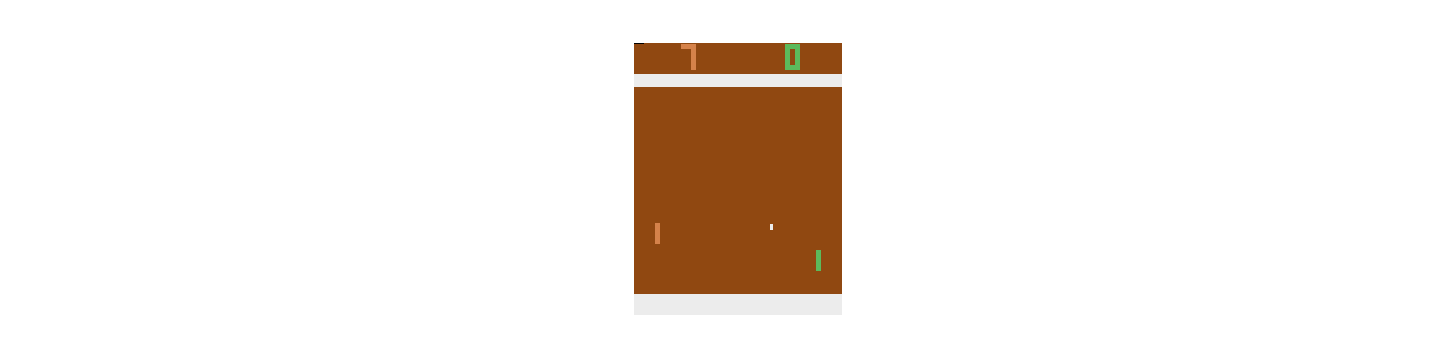
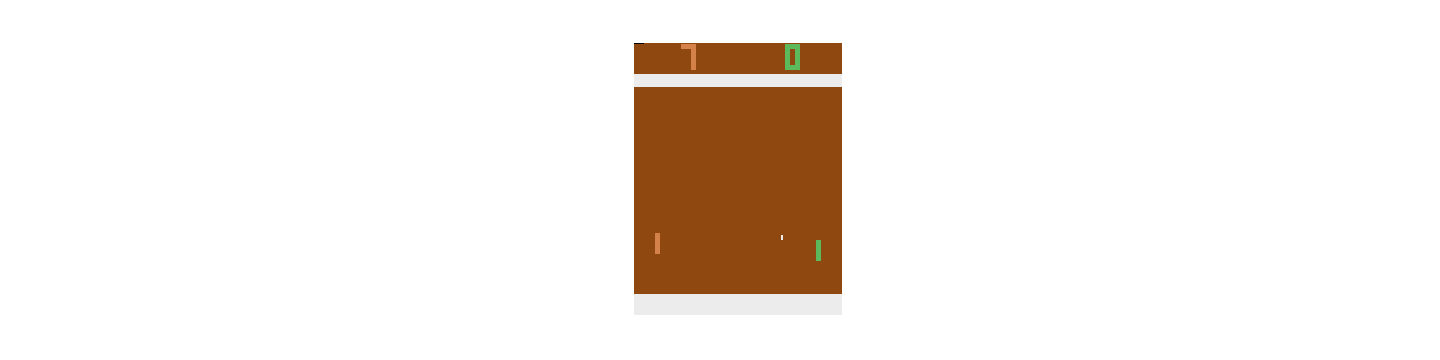
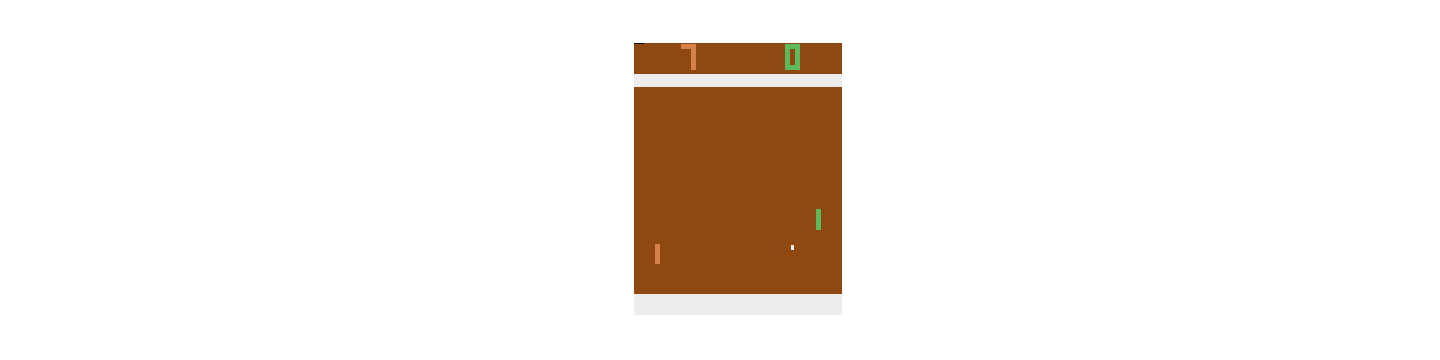
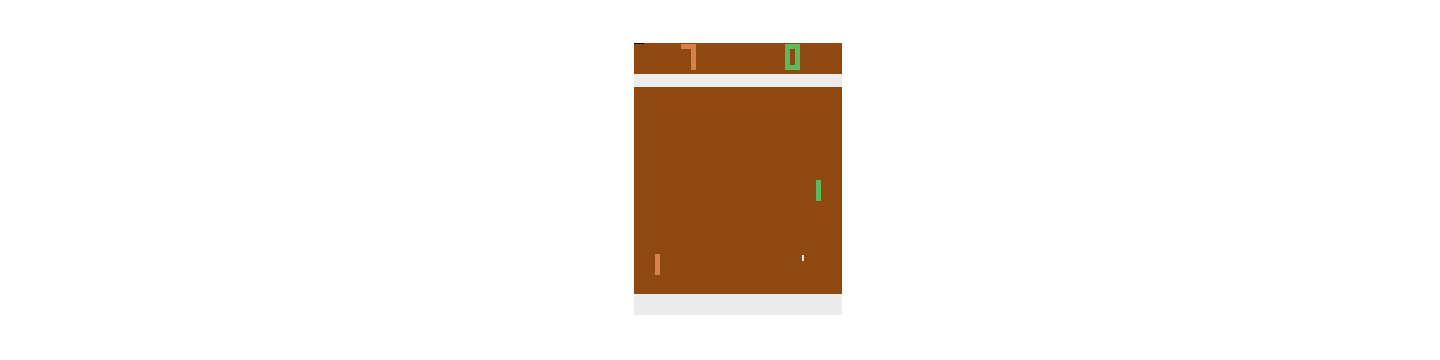
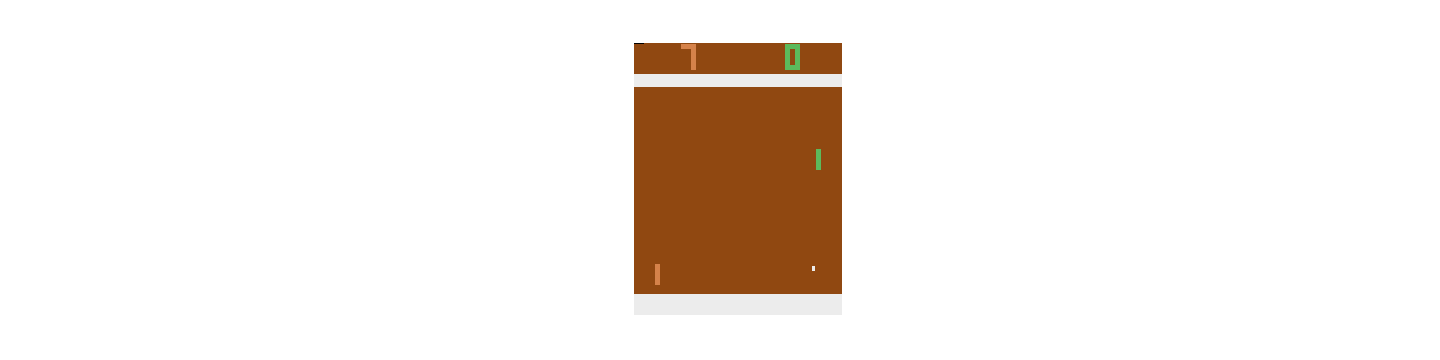
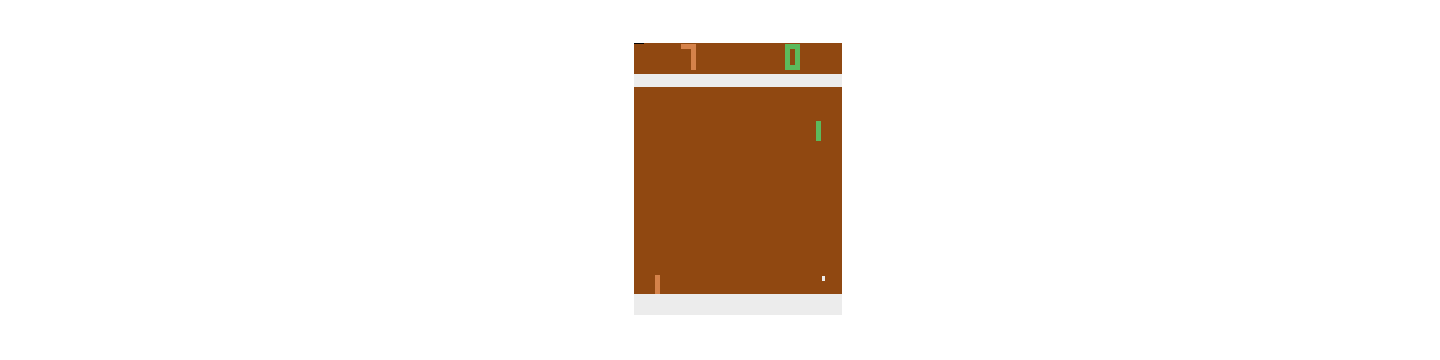
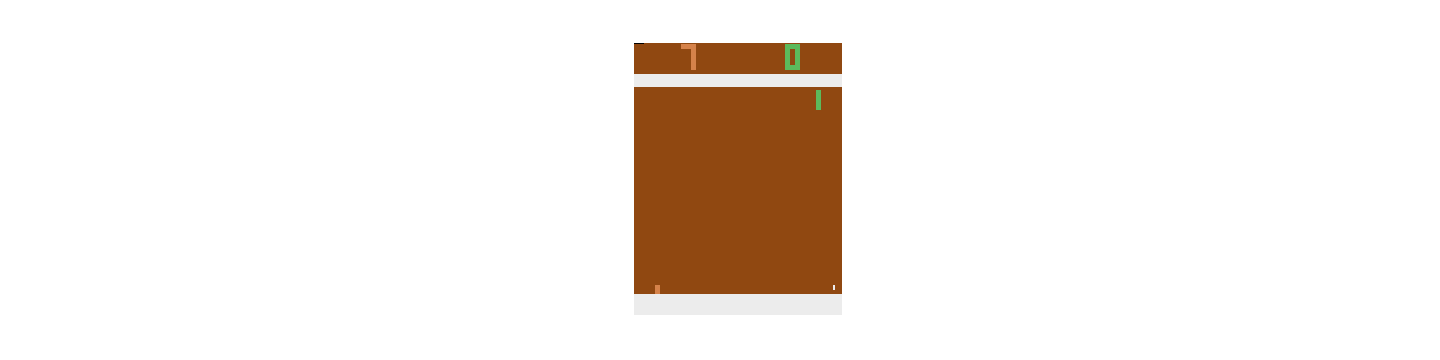
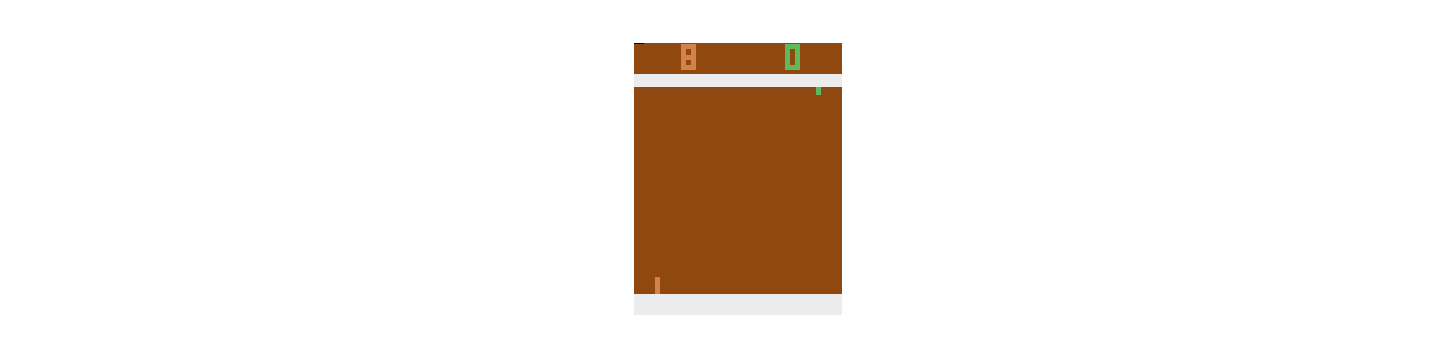
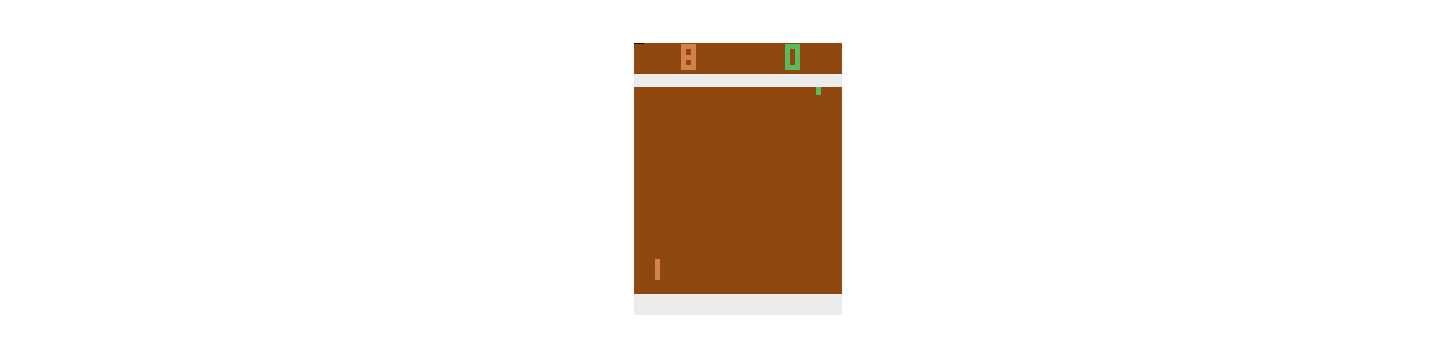
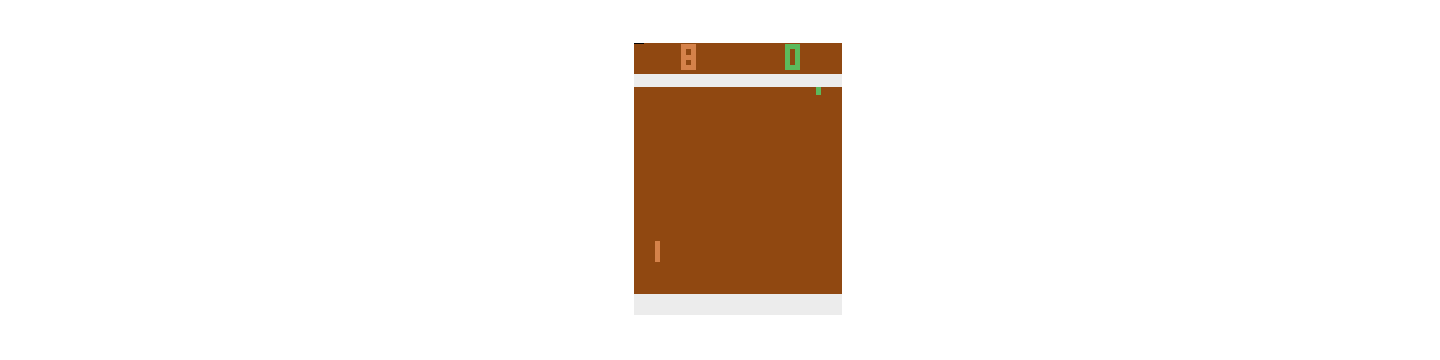
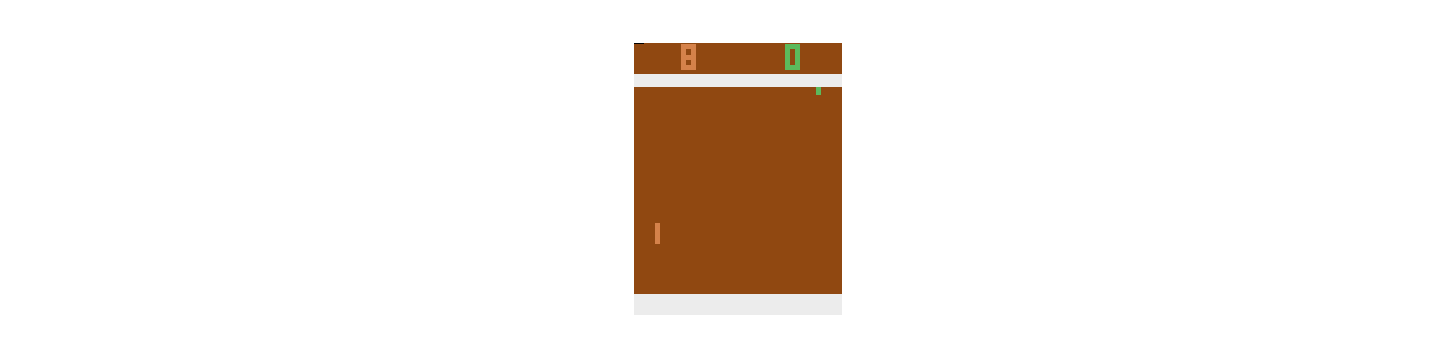
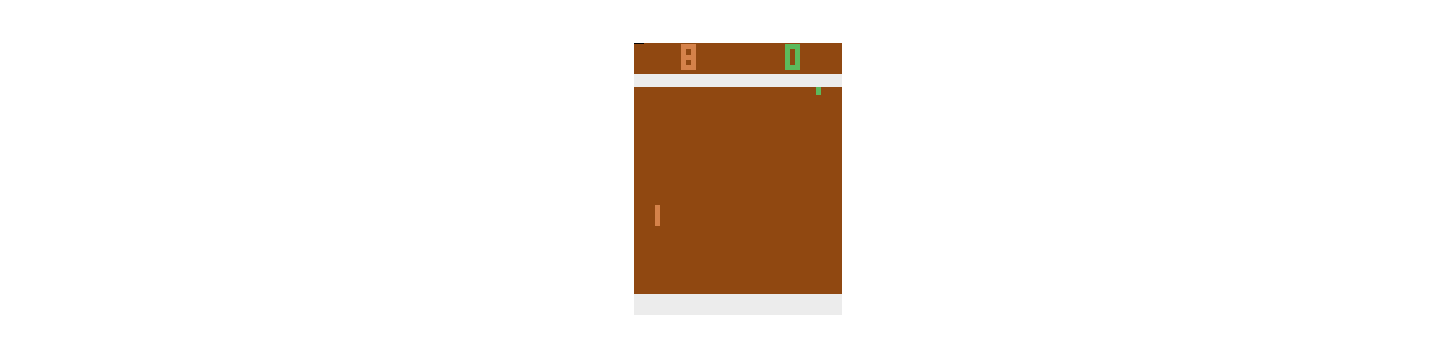
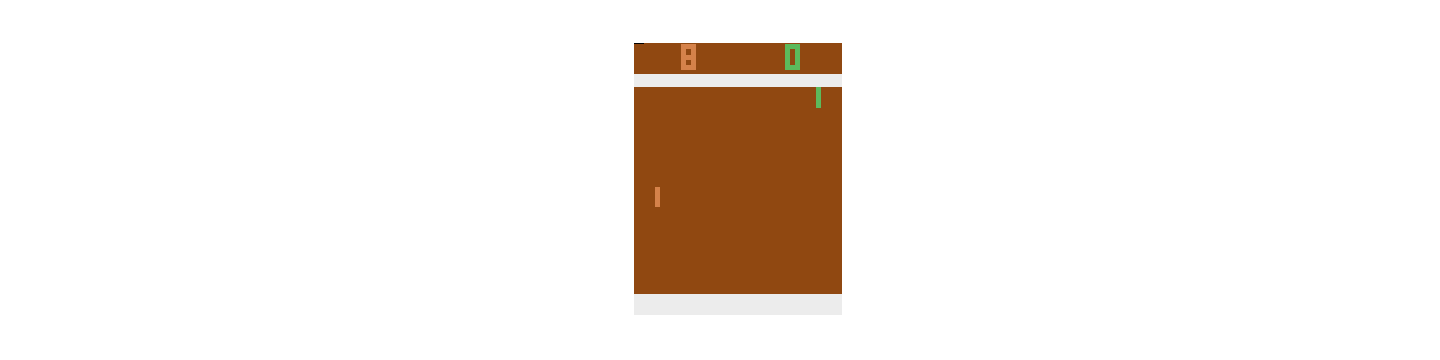
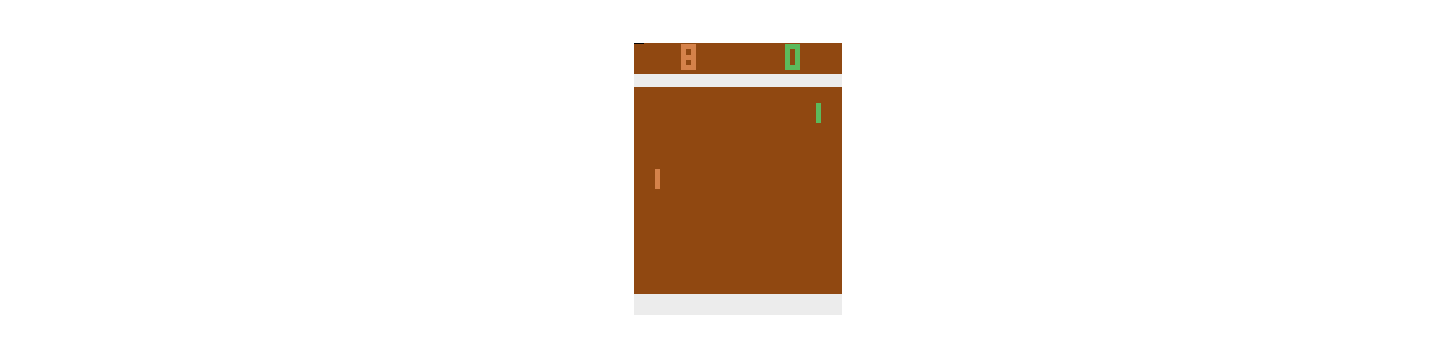
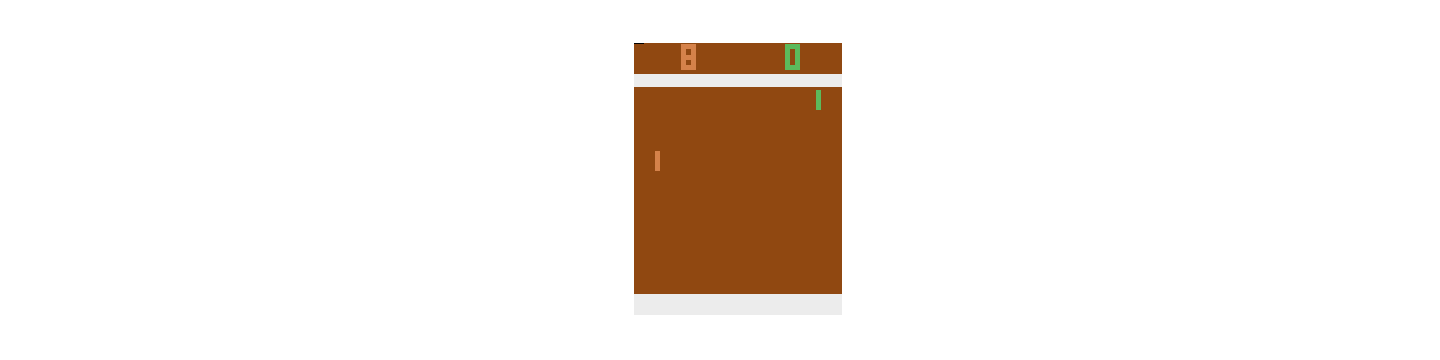
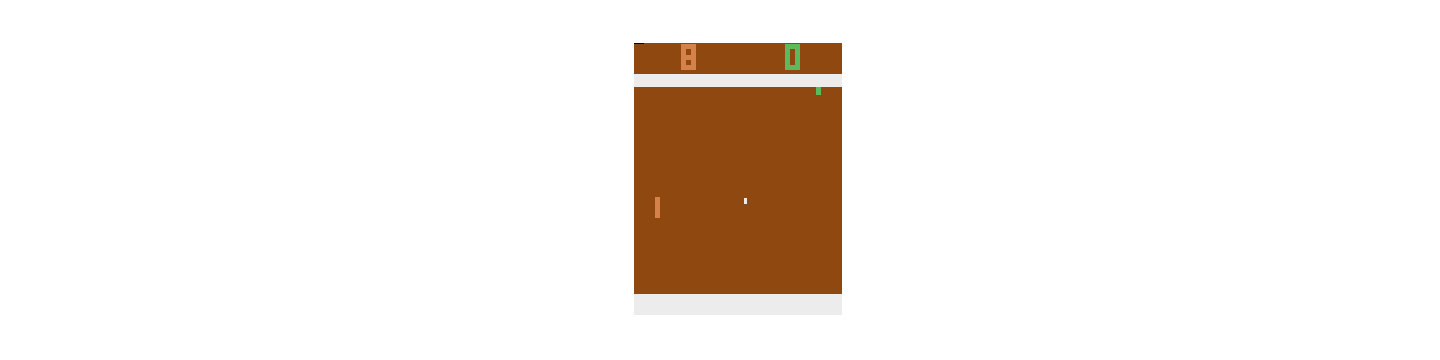
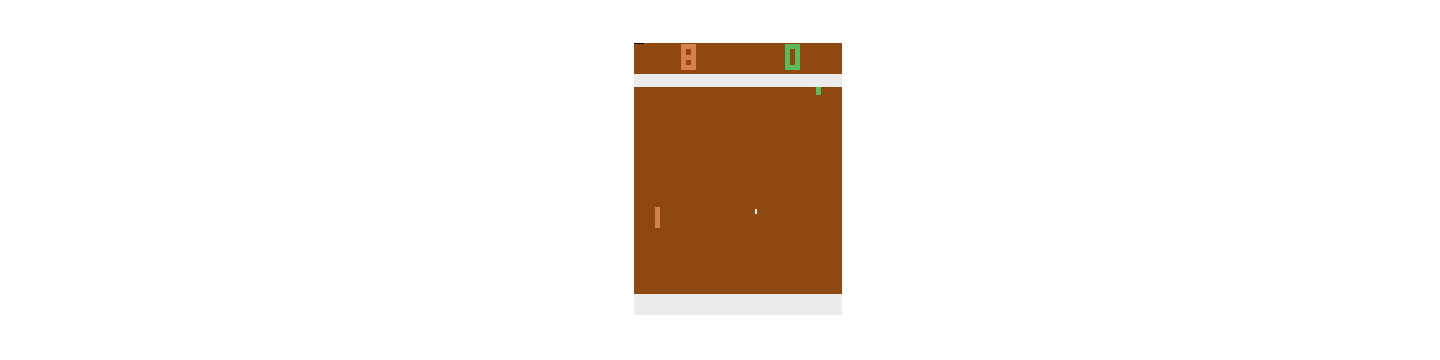
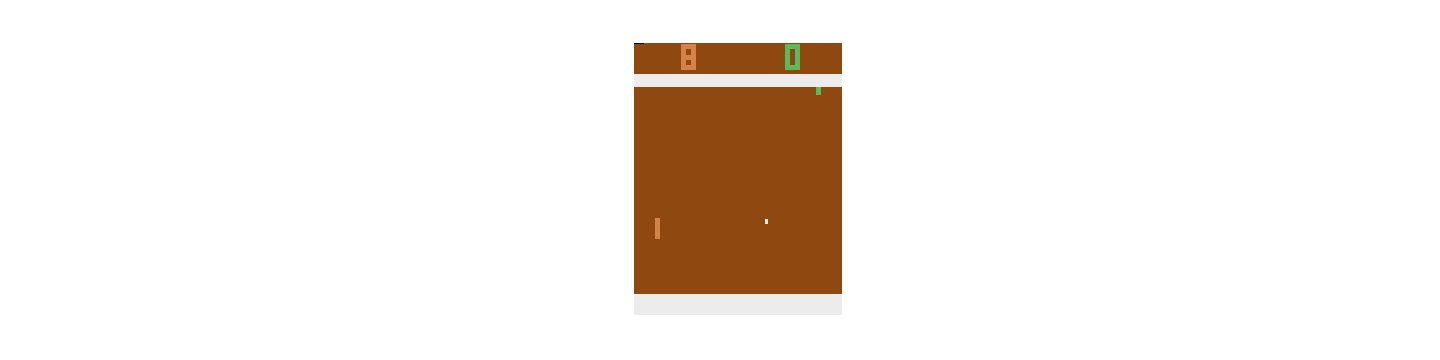
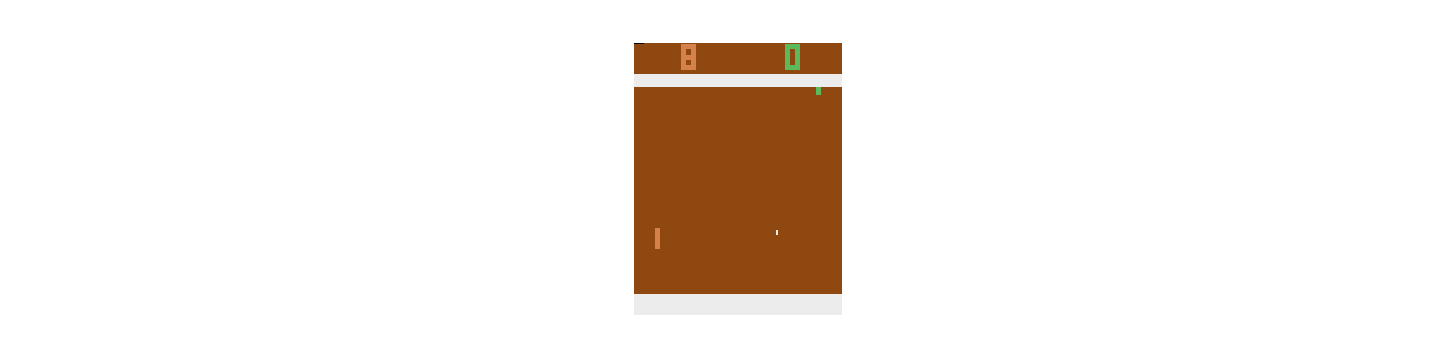
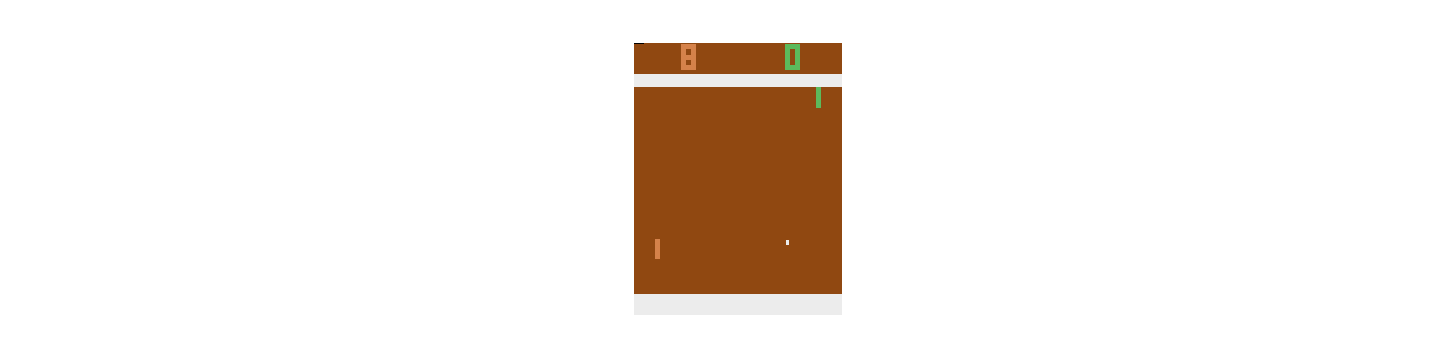
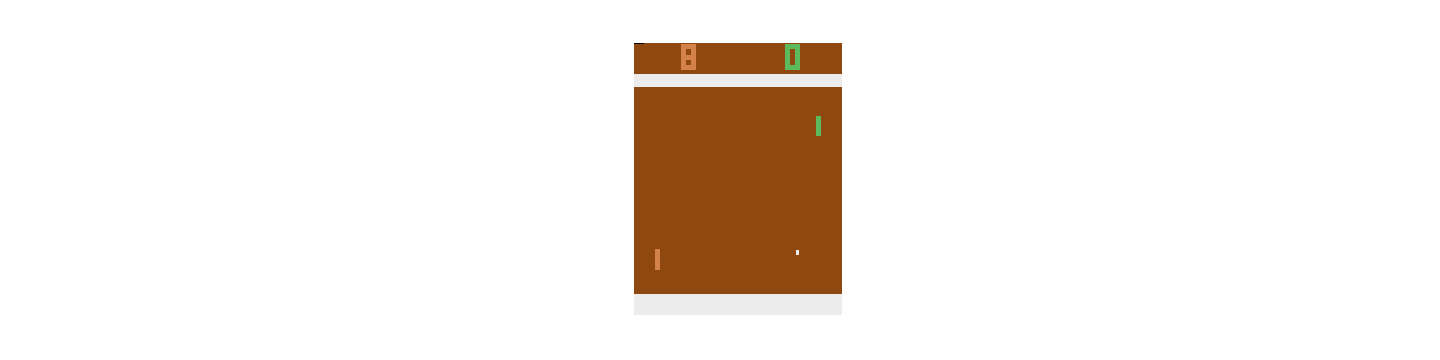
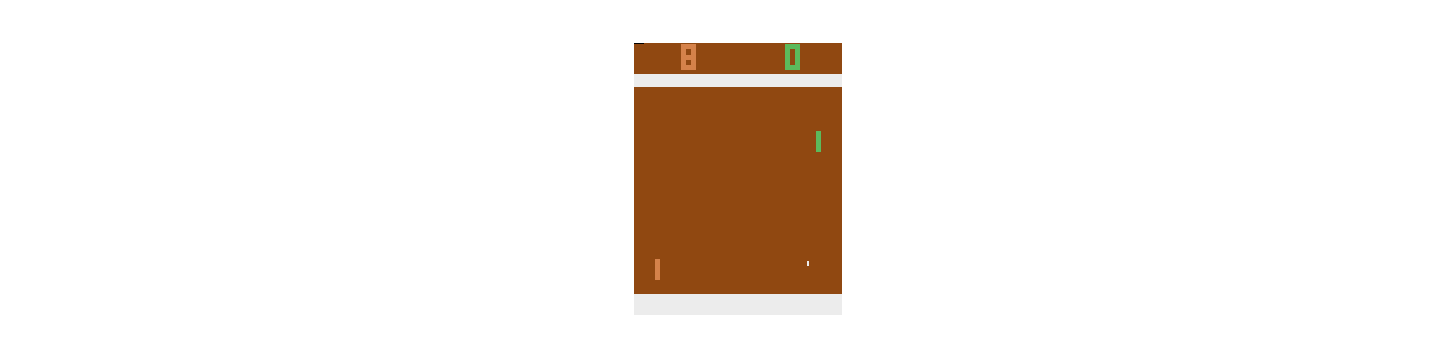
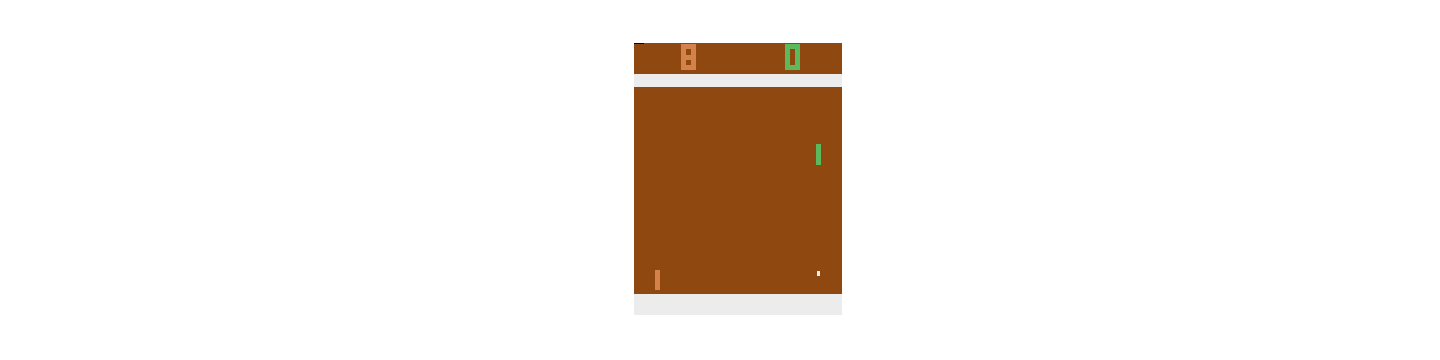
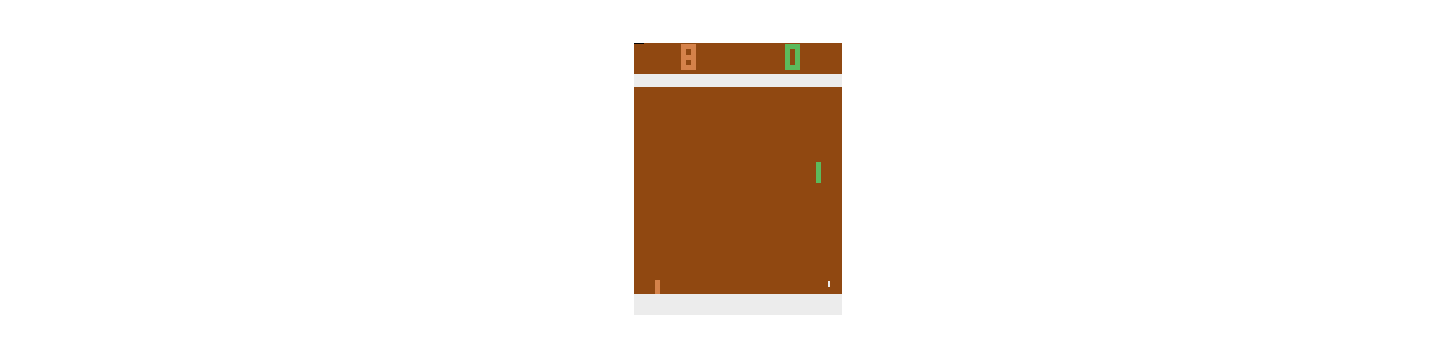
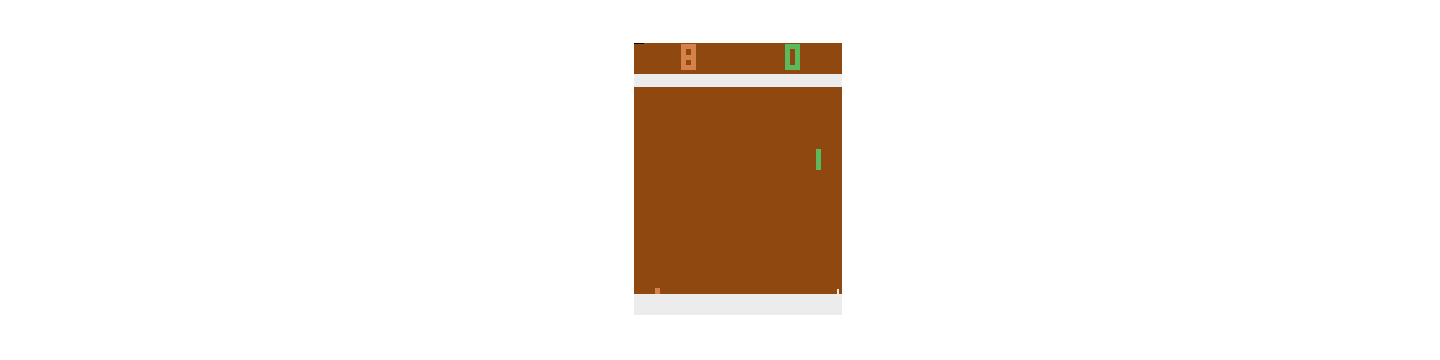
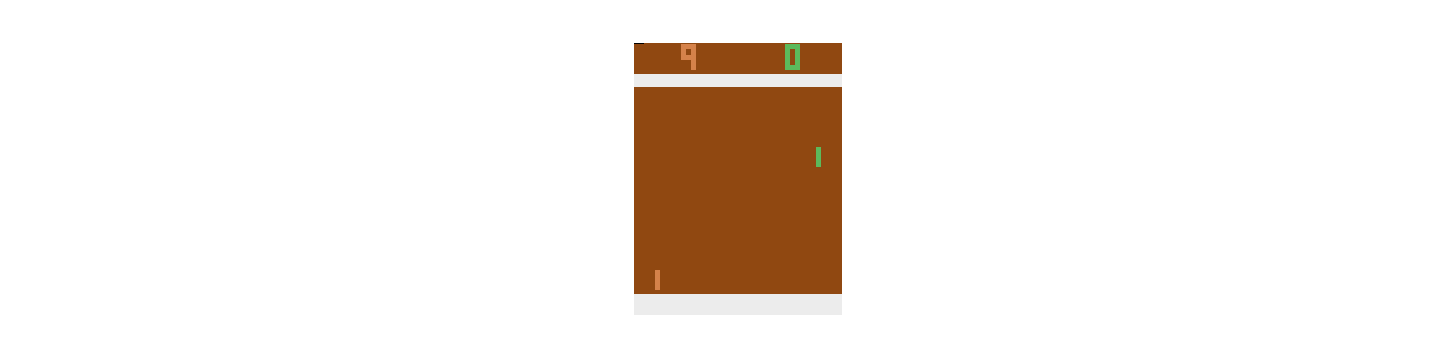
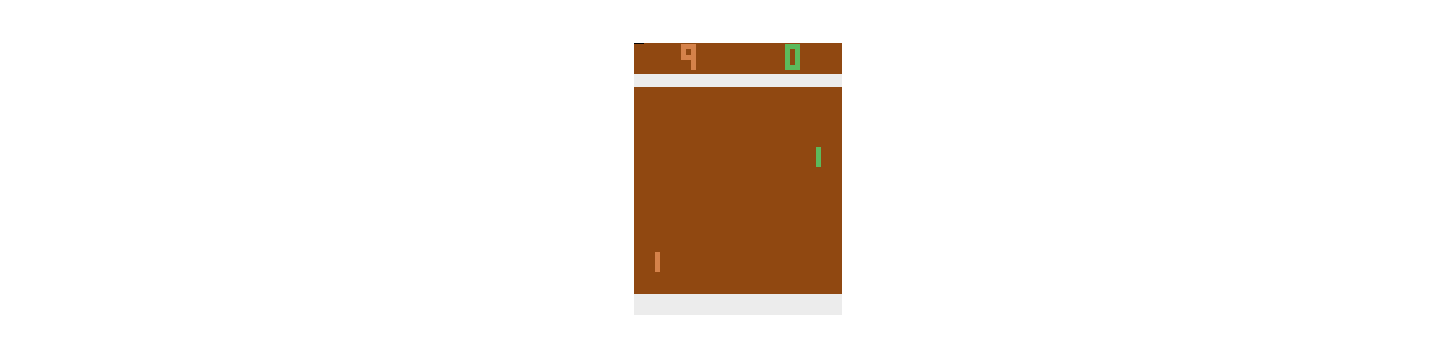
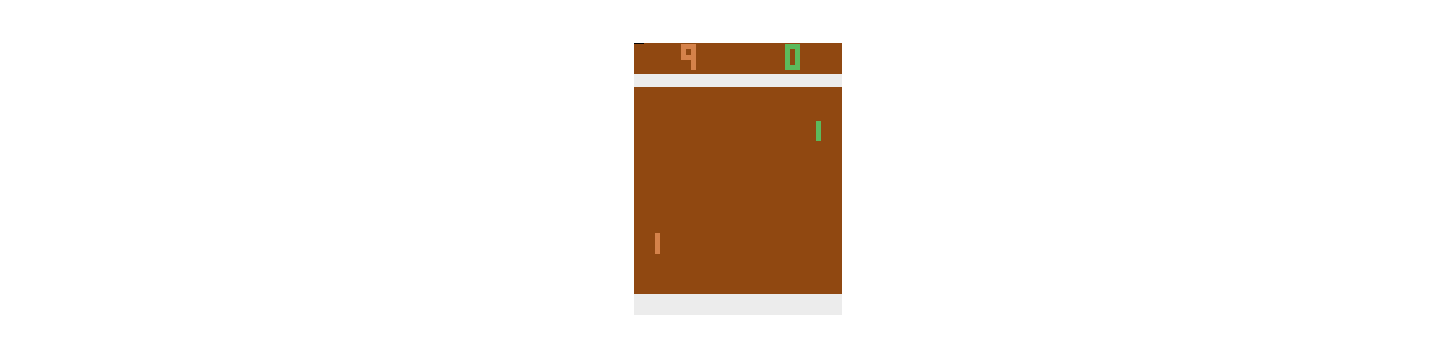
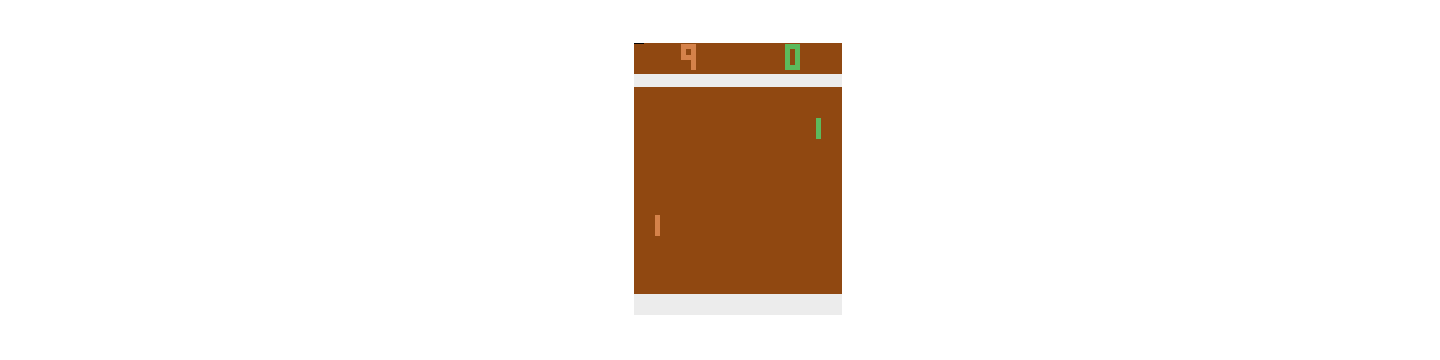
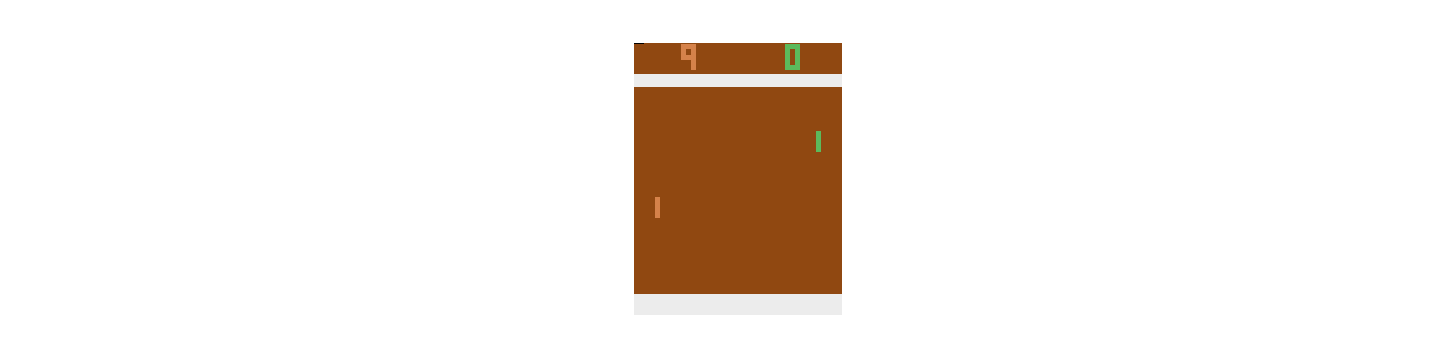
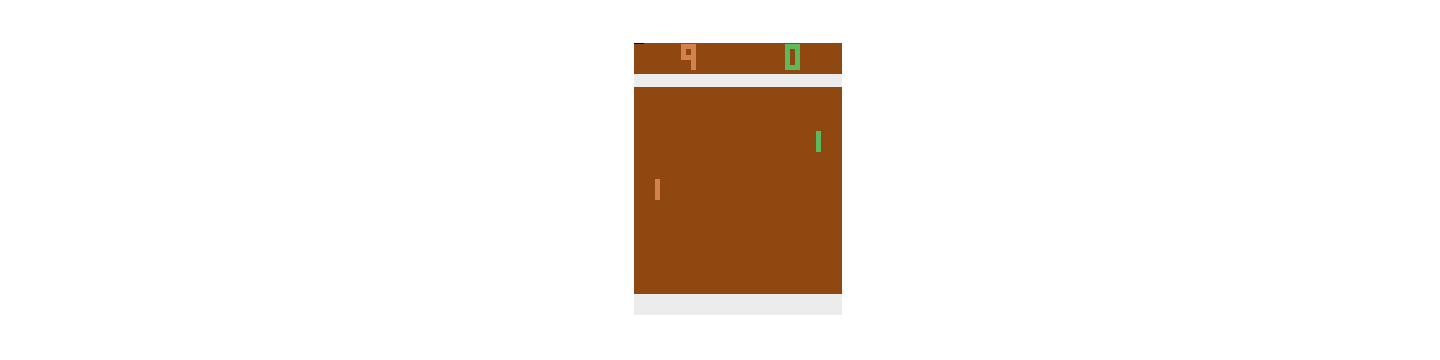
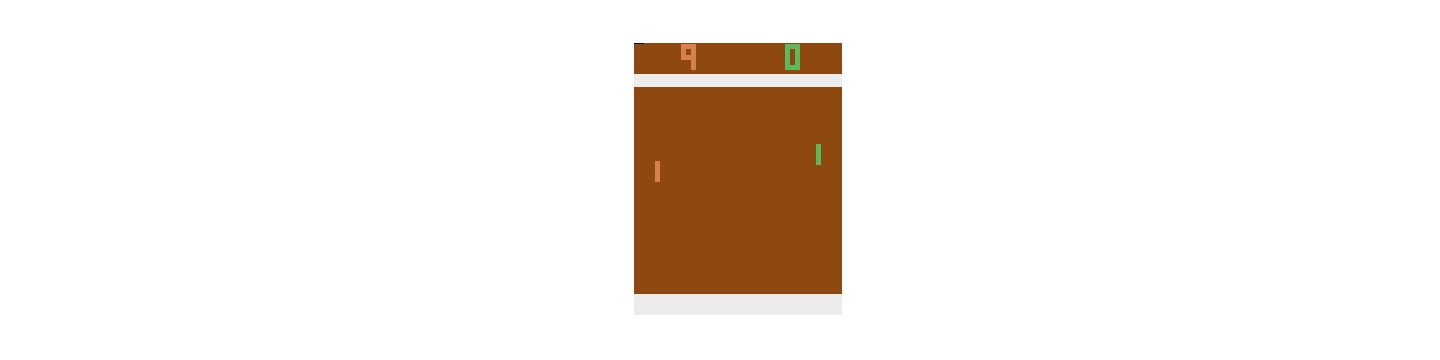
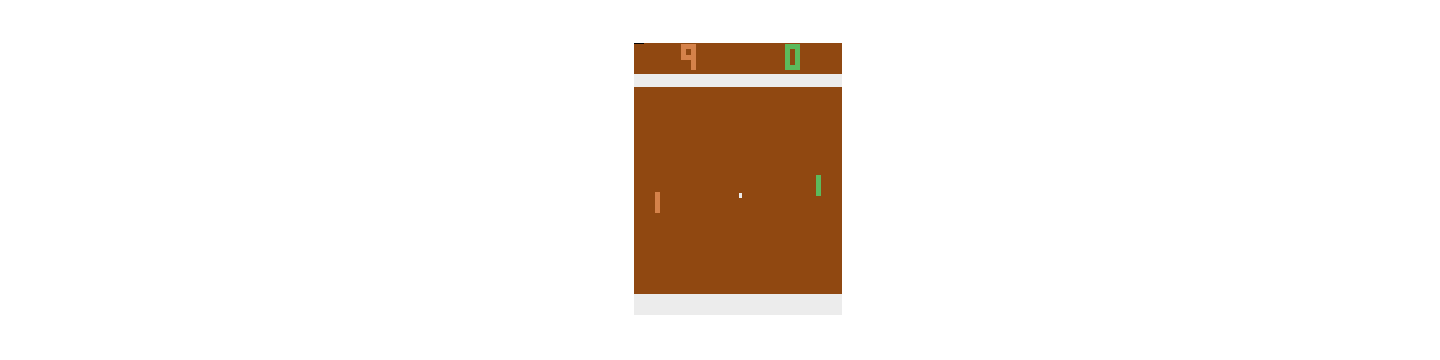
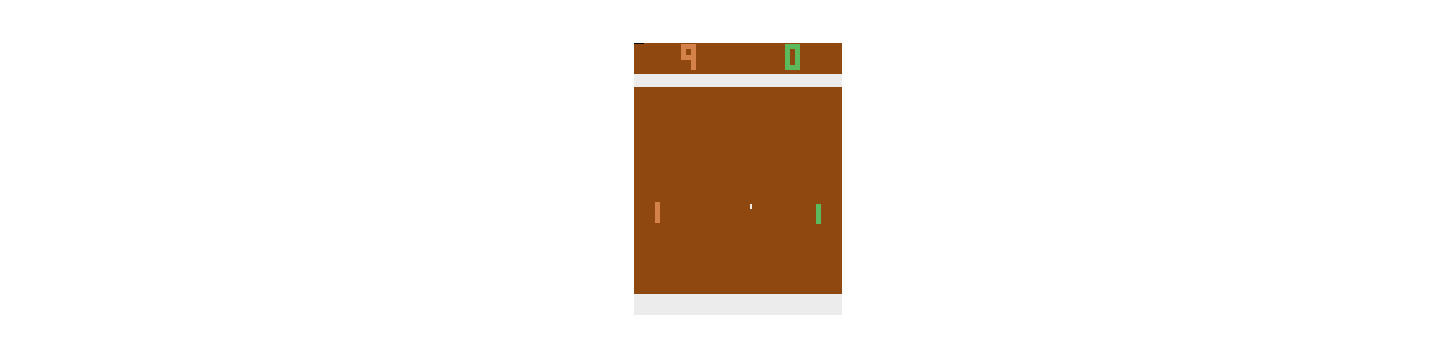
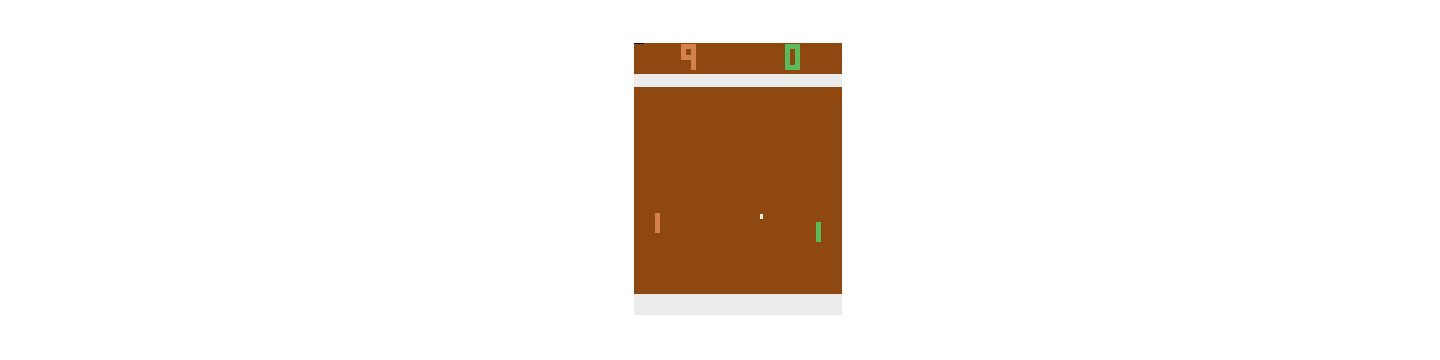
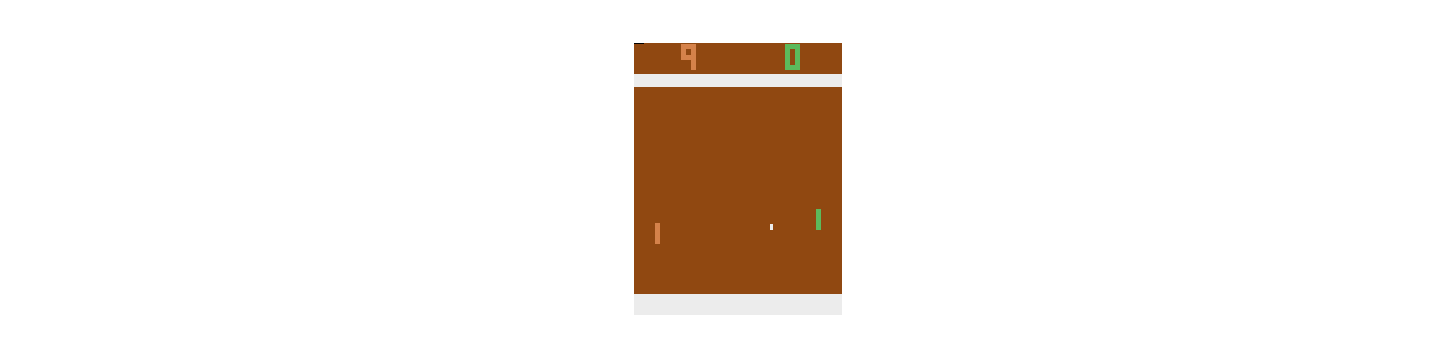
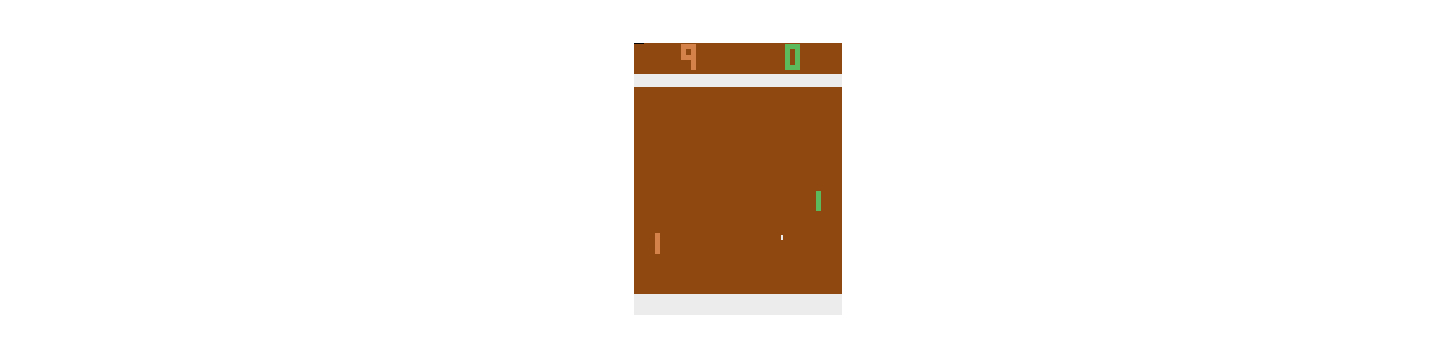
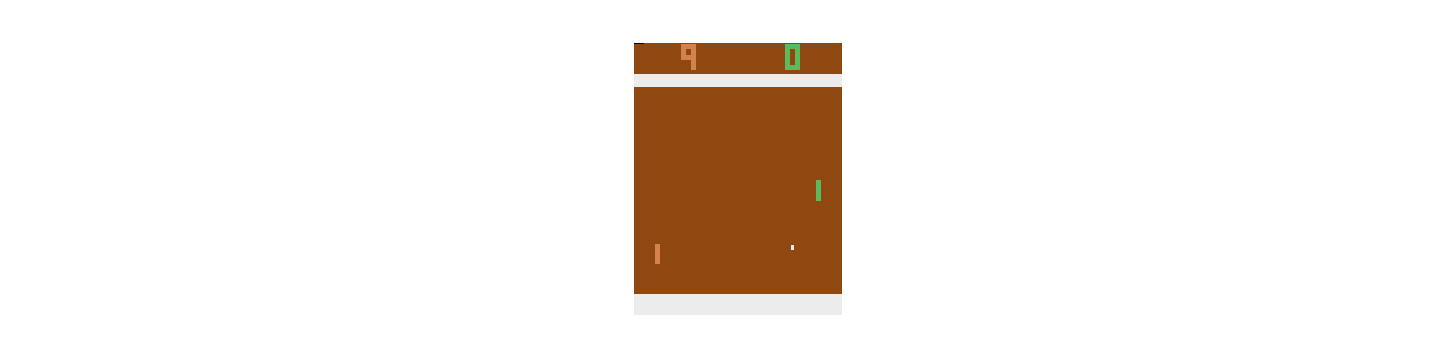
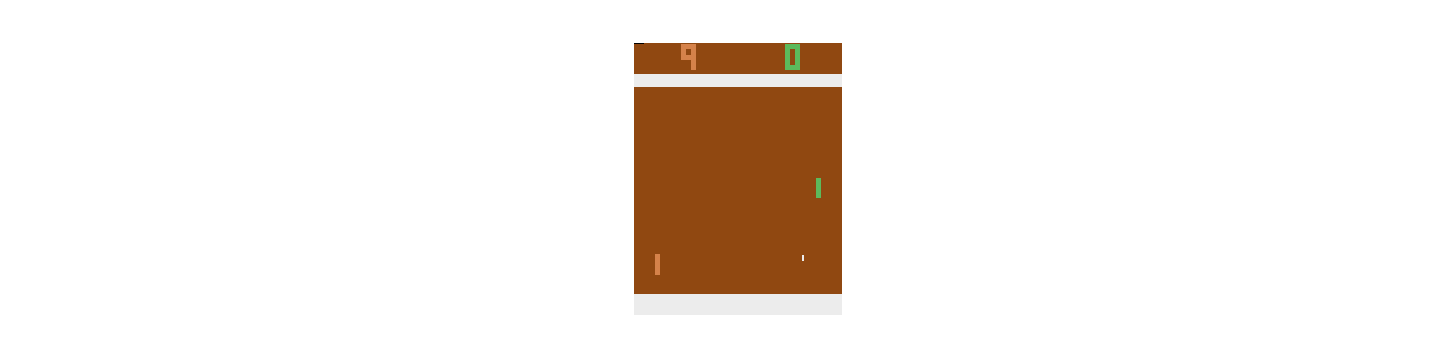
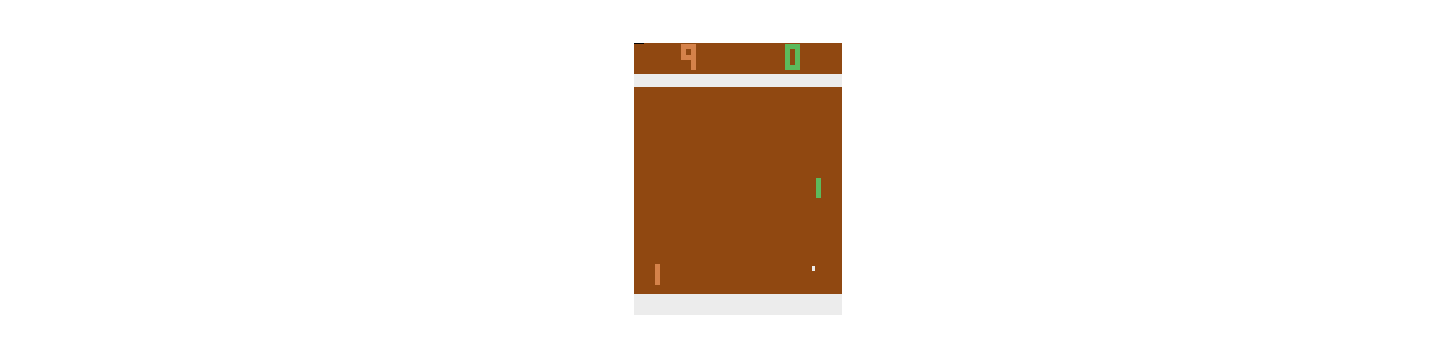
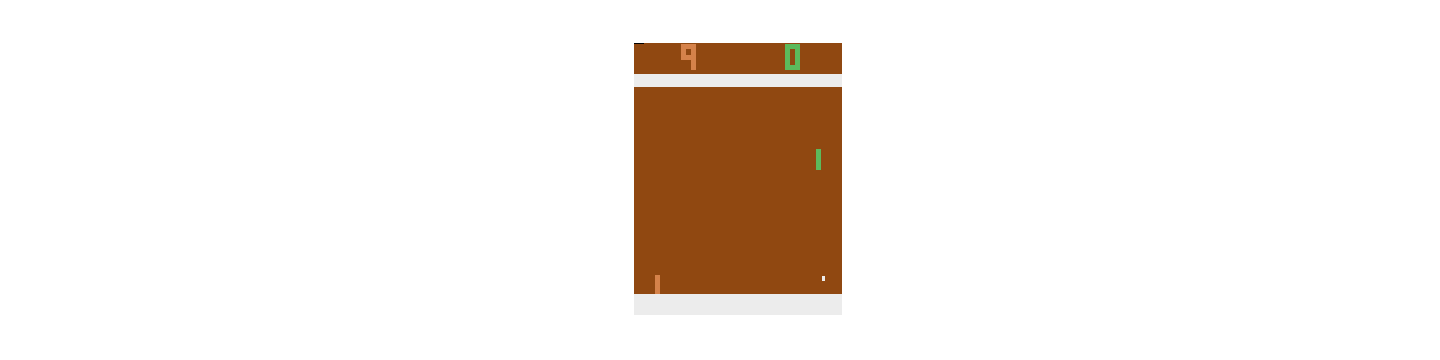
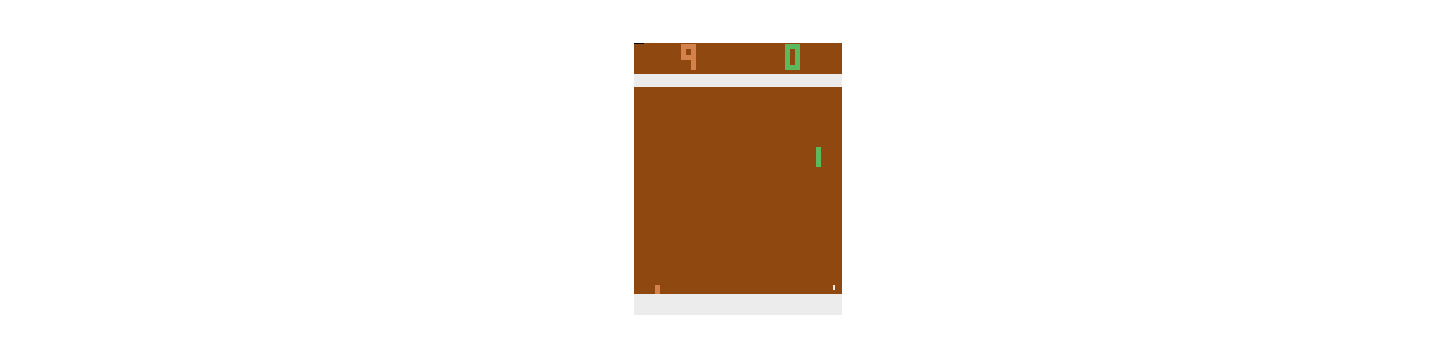
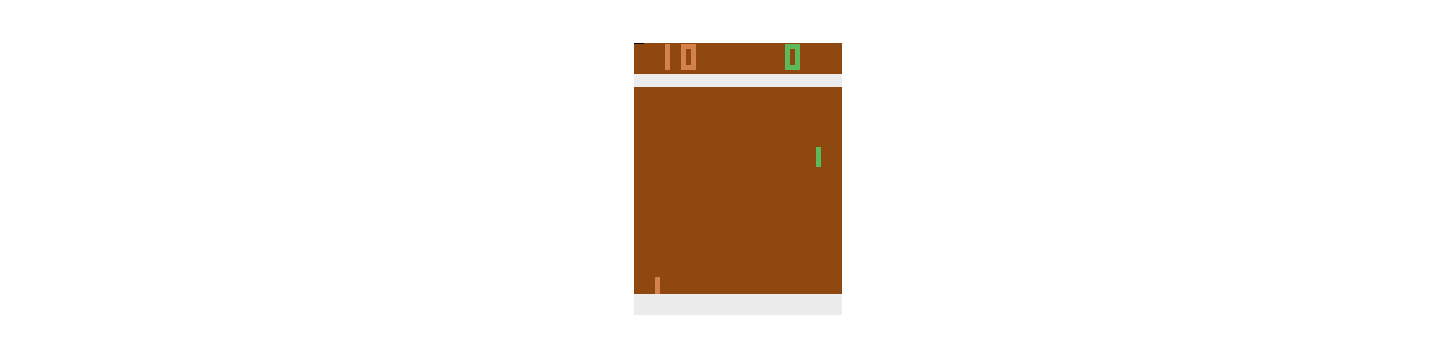
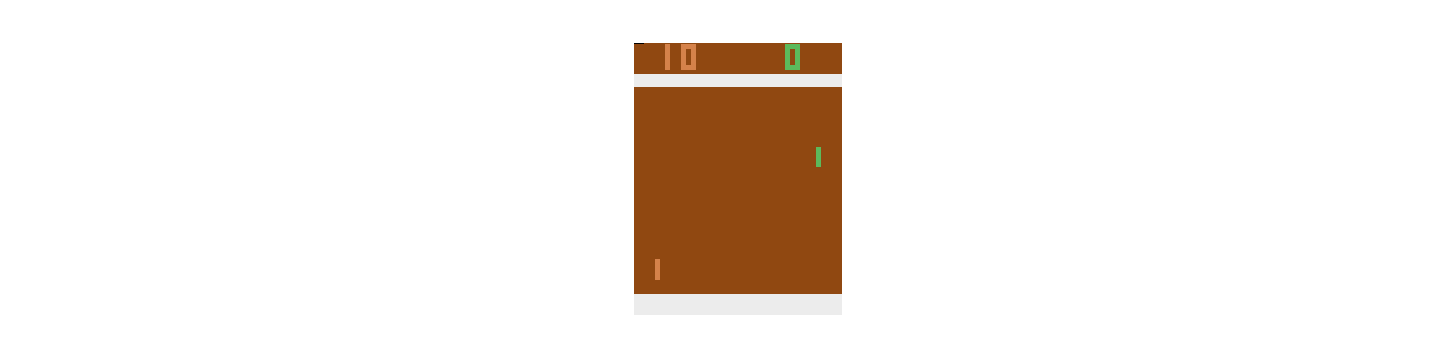
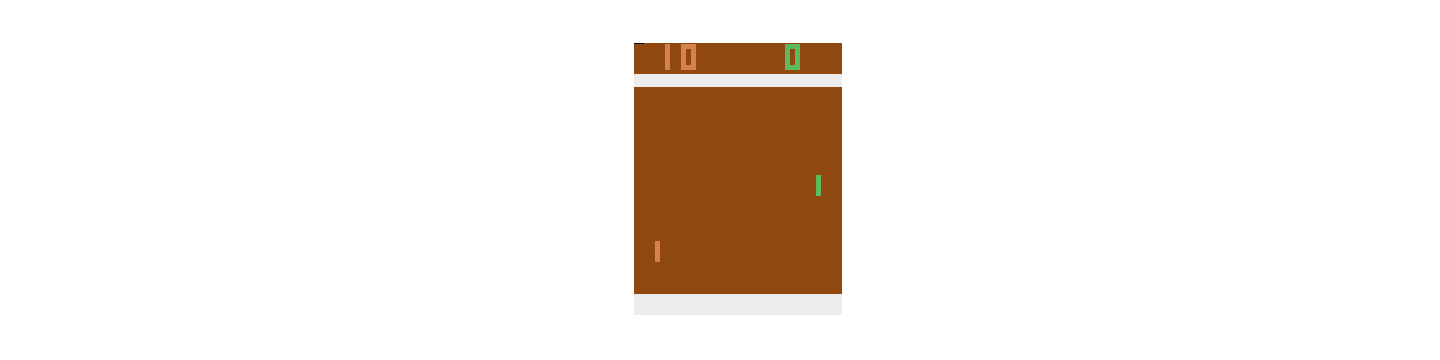
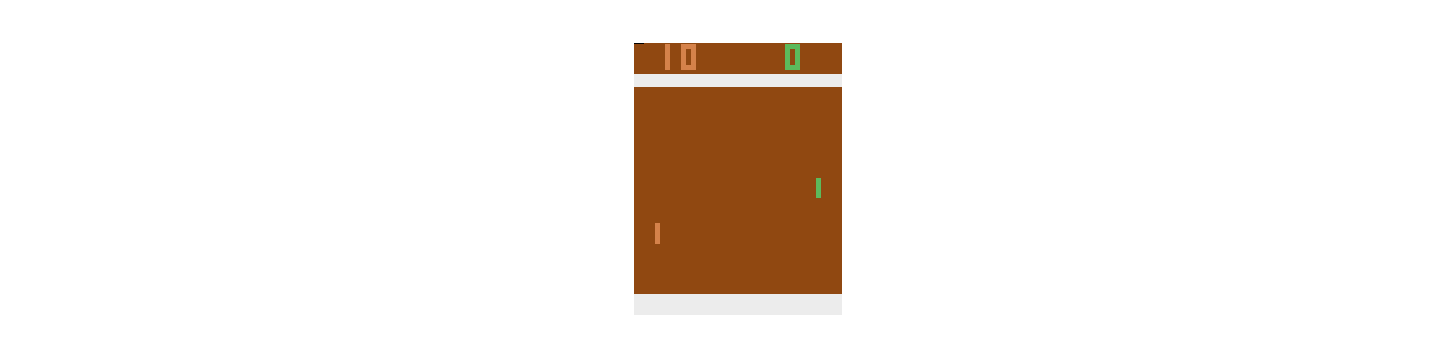
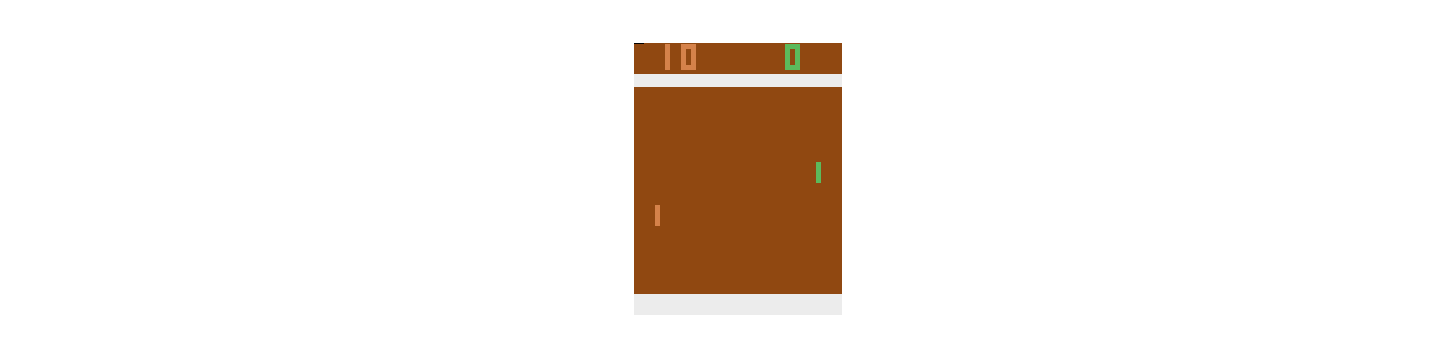
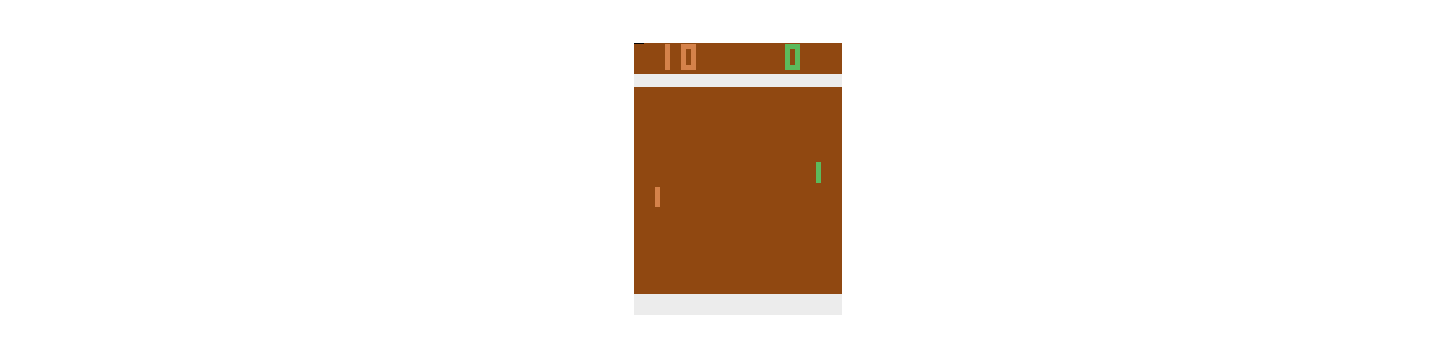
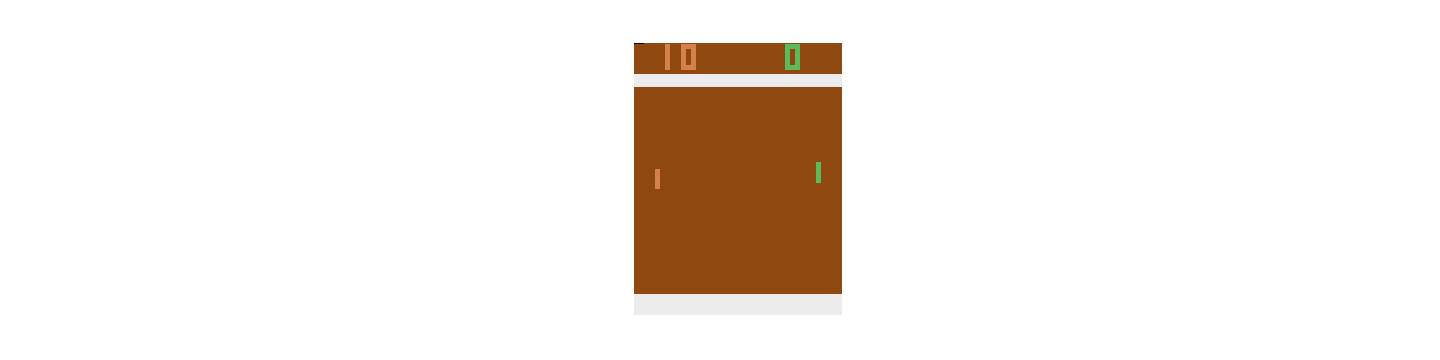
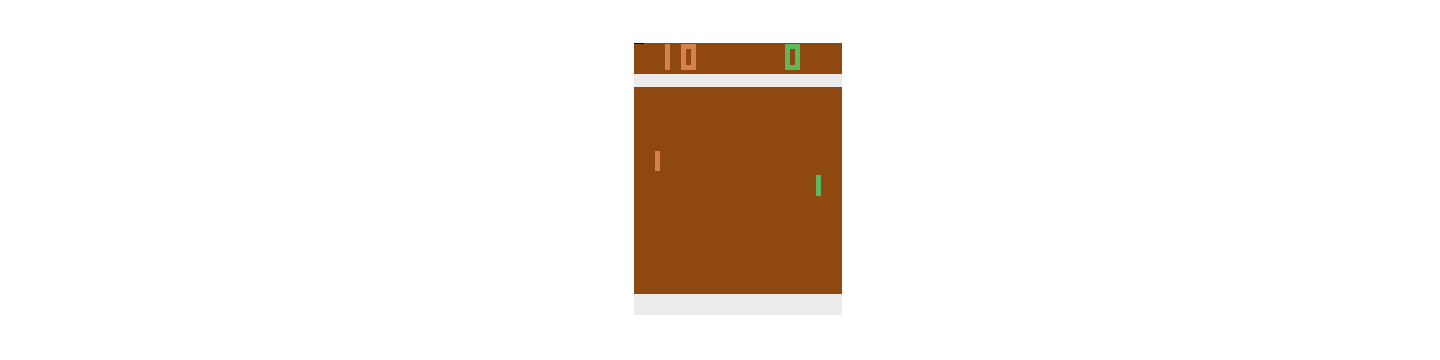
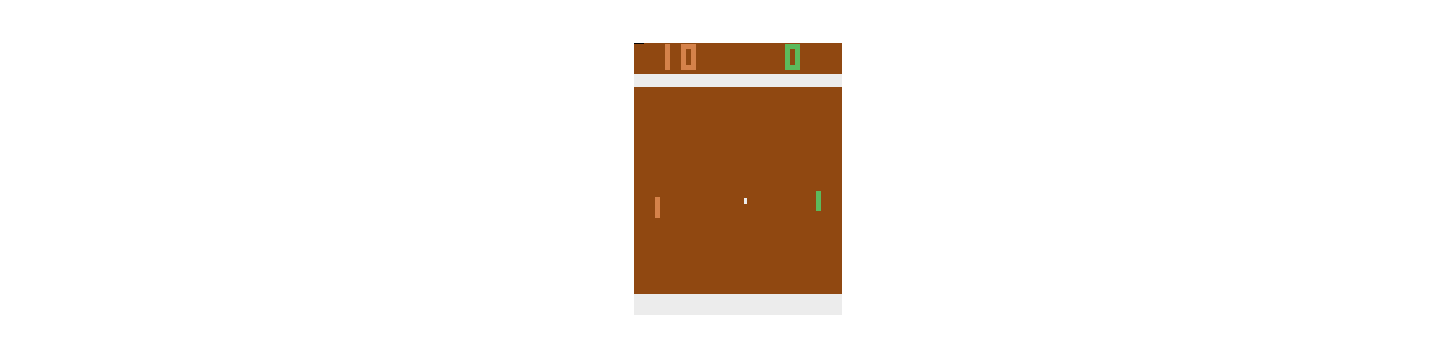
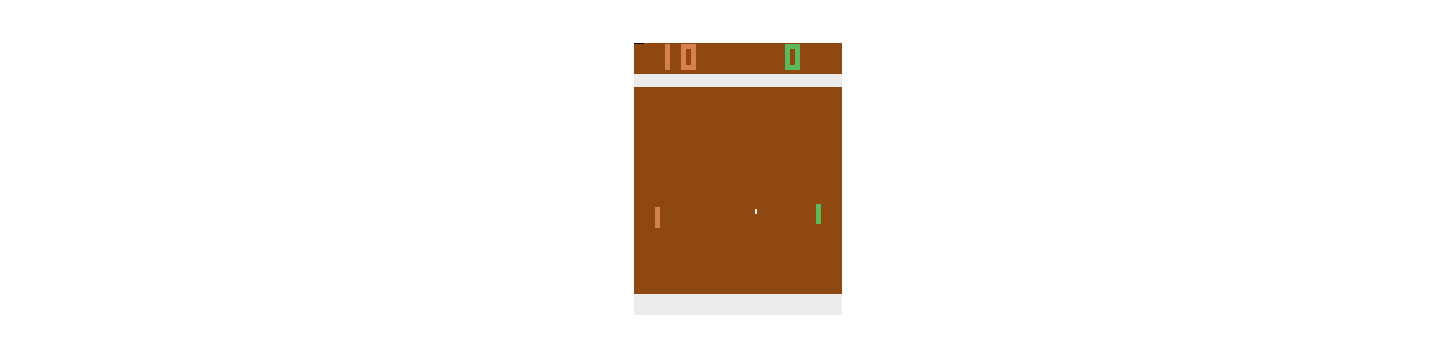
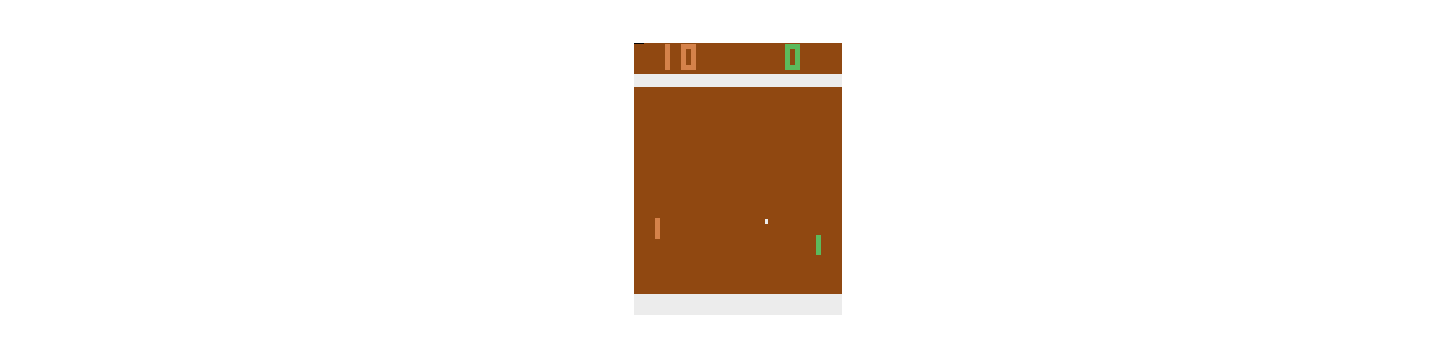
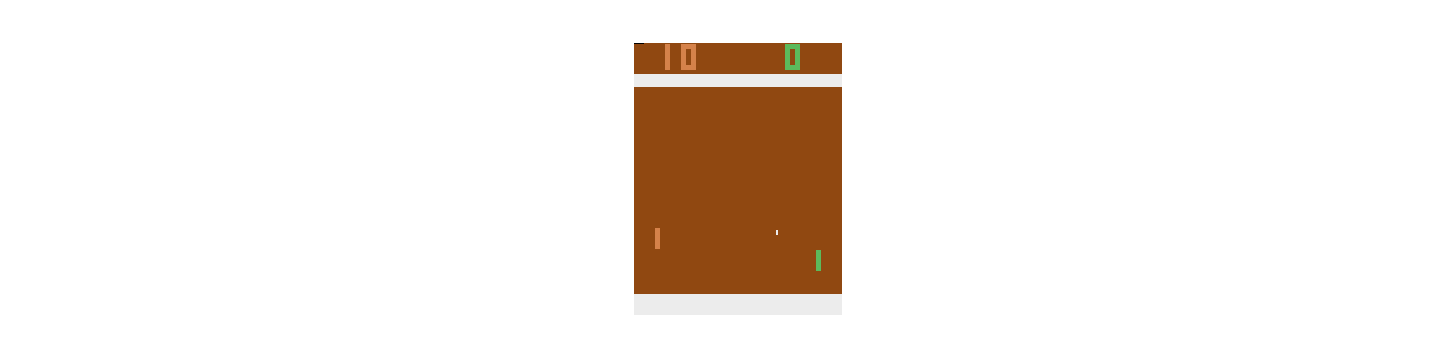
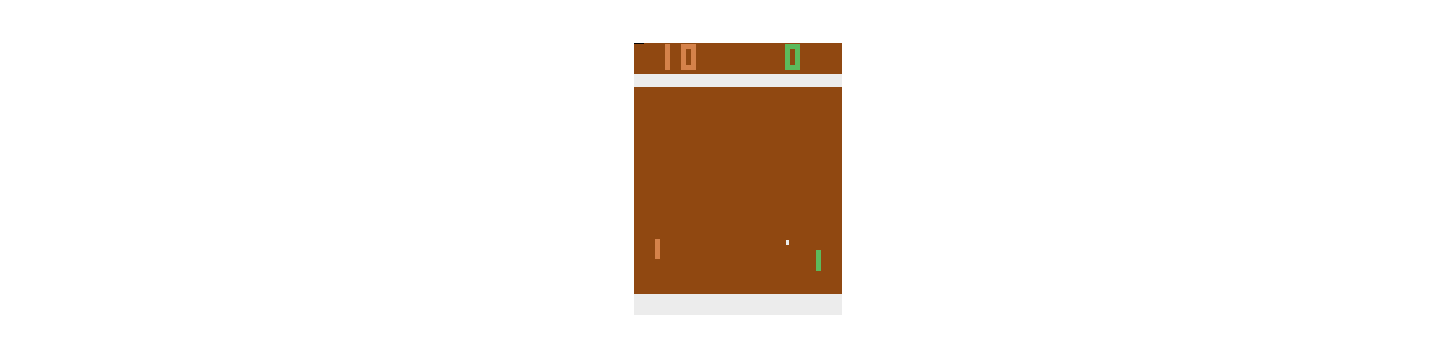
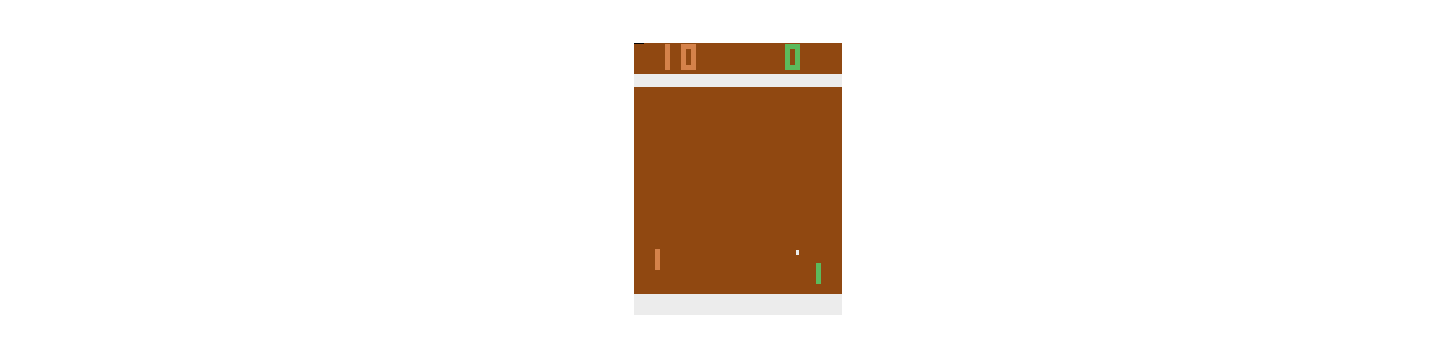
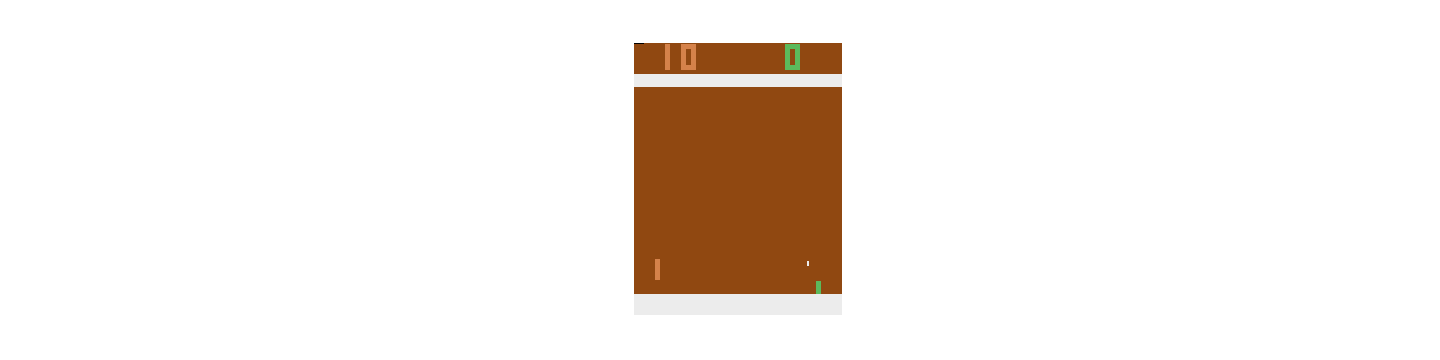
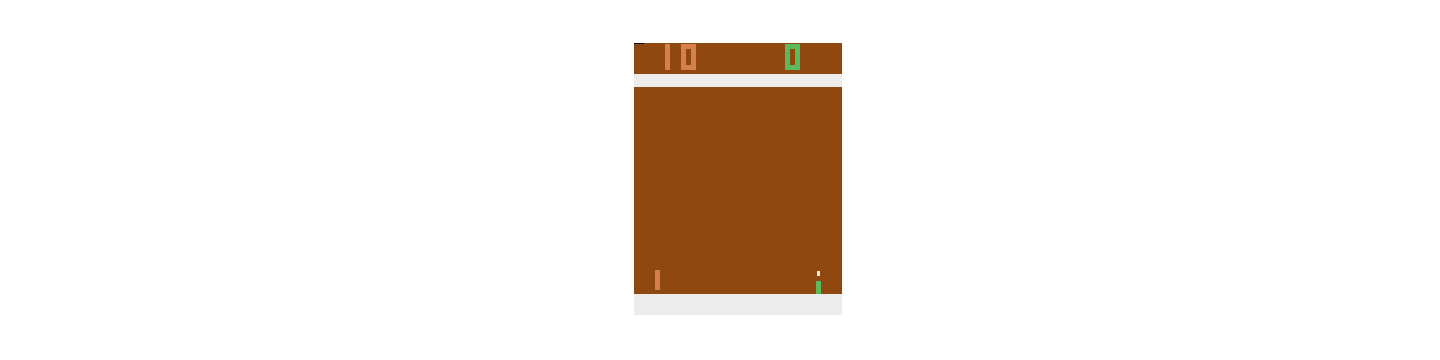

In [5]:
pong_utils.play(env, policy, time=50) 
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(what I call scalar function is the same as policy_loss up to a negative sign)

### PPO
Later on, you'll implement the PPO algorithm as well, and the scalar function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

In [6]:
def clipped_surrogate(policy, old_probs, states, actions, rewards,
                      discount = 0.995, epsilon=0.1, beta=0.01):

    discount = discount**np.arange(len(rewards))
    rewards = np.asarray(rewards)*discount[:,np.newaxis]
    #mean_rewards = np.mean(rewards, axis=0)
    # convert rewards to future rewards
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10
    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]
    
    # convert everything into pytorch tensors and move to gpu if available
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)
    
    # convert states to policy (or probability)
    new_probs = pong_utils.states_to_prob(policy, states)
    #print(new_probs, new_probs.shape)
    filterd_new_probs = torch.zeros_like(old_probs)
    for t in range(len(new_probs)):
        for p in range(len(new_probs[t])):
            #print(new_probs[t][p], t, p)
            if actions[t][p].item() == 0: 
                filterd_new_probs[t][p] = new_probs[t][p][0]
            elif actions[t][p].item() == 4: 
                filterd_new_probs[t][p] = new_probs[t][p][1]
            else:
                filterd_new_probs[t][p] = new_probs[t][p][2]                    
                
    # ratio for clipping
    ratio = filterd_new_probs/old_probs
    # clipped function
    clip = torch.clamp(ratio, 1-epsilon, 1+epsilon)
    clipped_surrogate = torch.min(ratio*rewards, clip*rewards)

    # include a regularization term
    # this steers new_policy towards 0.5
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(filterd_new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-filterd_new_probs)*torch.log(1.0-old_probs+1.e-10))

    
    # this returns an average of all the entries of the tensor
    # effective computing L_sur^clip / T
    # averaged over time-step and number of trajectories
    # this is desirable because we have normalized our rewards
    return torch.mean(clipped_surrogate + beta*entropy)


# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [7]:
from workspace_utils import active_session

In [8]:
from parallelEnv import parallelEnv
import numpy as np
# keep track of how long training takes
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 700

# widget bar to display progress
!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()


envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
epsilon = 0.1
beta = .01
tmax = 300
SGD_epoch = 5

# keep track of progress
mean_rewards = []
max_mean = -np.inf

with active_session():

    for e in range(episode):
        
        policy.train()

        # collect trajectories
        old_probs, states, actions, rewards = \
            pong_utils.collect_trajectories(envs, policy, tmax=tmax)

        total_rewards = np.sum(rewards, axis=0)


        # gradient ascent step
        for _ in range(SGD_epoch):

            # uncomment to utilize your own clipped function!
            L = -clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)

            optimizer.zero_grad()
            L.backward()
            optimizer.step()
            del L

        # the clipping parameter reduces as time goes on
        epsilon*=.999

        # the regulation term also reduces
        # this reduces exploration in later runs
        beta*=.995

        current_mean = np.mean(total_rewards)
        # get the average reward of the parallel environments
        mean_rewards.append(current_mean)

        if current_mean > max_mean:
            max_mean = current_mean
            torch.save(policy.state_dict(), 'PPO.pth')
            
        # display some progress every 20 iterations
        if (e+1)%20 ==0 :
            print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
            print(total_rewards)

        # update progress widget bar
        timer.update(e+1)
    
    timer.finish()

Episode: 20, score: -12.375000
[-14. -14. -12. -10. -13.  -9. -13. -14.]


Episode: 40, score: -13.000000
[-14. -14. -14. -14.  -9. -12. -13. -14.]


Episode: 60, score: -13.375000
[-15.  -7. -15. -13. -14. -15. -13. -15.]


Episode: 80, score: -13.000000
[-14. -14. -11. -12. -13. -13. -14. -13.]


Episode: 100, score: -13.125000
[-14. -12. -14. -14. -10. -12. -14. -15.]


Episode: 120, score: -13.375000
[-14. -13. -14. -15. -14. -14. -14.  -9.]


Episode: 140, score: -12.750000
[-13. -11. -11. -14. -13. -15. -11. -14.]


Episode: 160, score: -13.000000
[-12. -15. -11. -14. -14. -11. -14. -13.]


Episode: 180, score: -12.875000
[-14. -13. -14. -12. -12. -12. -13. -13.]


Episode: 200, score: -13.125000
[-14. -14. -13. -14. -14. -14.  -8. -14.]


Episode: 220, score: -13.125000
[-14. -11. -11. -15. -15. -15. -14. -10.]


Episode: 240, score: -12.500000
[-13. -15.  -7. -12. -14. -13. -14. -12.]


Episode: 260, score: -13.125000
[-14. -14. -13. -12. -10. -13. -15. -14.]


Episode: 280, score: -11.625000
[-12. -11. -11. -13. -12. -10. -14. -10.]


Episode: 300, score: -10.000000
[-13. -12.  -5. -10. -12.  -7. -13.  -8.]


Episode: 320, score: -8.000000
[ -8. -10.  -8.  -7.  -9.  -6.  -9.  -7.]


Episode: 340, score: -6.125000
[  0.  -5. -10.  -9.  -7.  -4.  -3. -11.]


Episode: 360, score: -3.750000
[-8. -3. -2. -7. -2. -3. -5.  0.]


Episode: 380, score: -2.125000
[-2. -2. -2. -3. -3.  0. -3. -2.]


Episode: 400, score: -1.500000
[-2. -1. -4.  1.  0. -4. -2.  0.]


Episode: 420, score: 0.500000
[ 1. -1.  1. -4.  2.  2.  1.  2.]


Episode: 440, score: 1.750000
[-2.  0.  5.  0.  5.  3.  3.  0.]


Episode: 460, score: 2.750000
[ 1.  7.  5. -3.  3. -1.  5.  5.]


Episode: 480, score: 3.750000
[ 5.  5.  5.  3.  3.  2.  2.  5.]


Episode: 500, score: 0.500000
[ 0.  3.  5. -1.  3.  0.  0. -6.]


Episode: 520, score: 4.500000
[ 5.  5.  5.  2.  2.  7.  5.  5.]


Episode: 540, score: 3.875000
[ 5.  7.  0. -3.  5.  7.  5.  5.]


Episode: 560, score: 3.000000
[ 1.  7.  5.  1.  7.  1.  0.  2.]


Episode: 580, score: 5.375000
[ 2.  5.  5.  7.  5.  7.  7.  5.]


Episode: 600, score: 5.125000
[ 7.  7.  7. -5.  7.  5.  6.  7.]


Episode: 620, score: 3.750000
[ 1.  5.  7. -7.  5.  5.  7.  7.]


Episode: 640, score: 3.375000
[ 7.  5.  5.  5.  7. -2.  7. -7.]


Episode: 660, score: 5.500000
[ 7.  3.  7.  7. -1.  7.  7.  7.]


Episode: 680, score: 2.750000
[  7.   4.   5.   5.   0. -13.   7.   7.]


Episode: 700, score: 6.500000
[ 5.  7.  7.  7.  5.  7.  7.  7.]



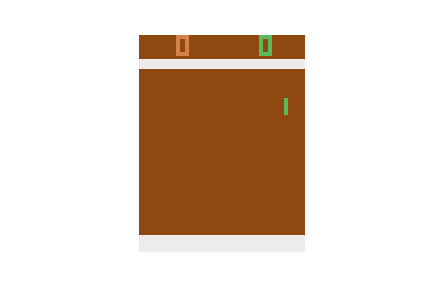
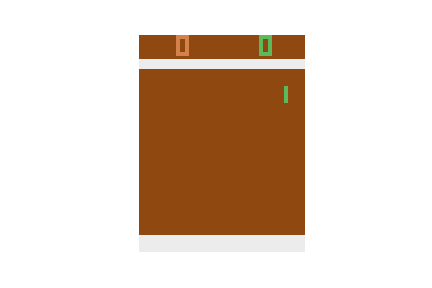
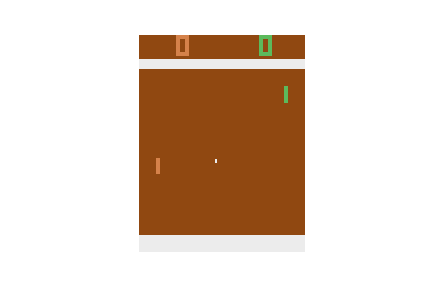
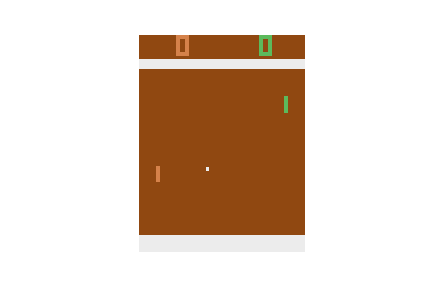
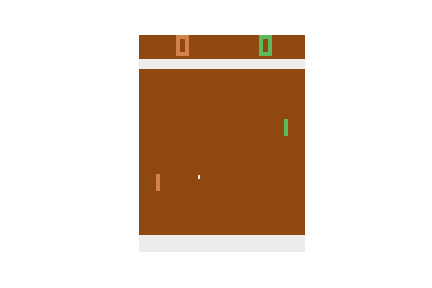
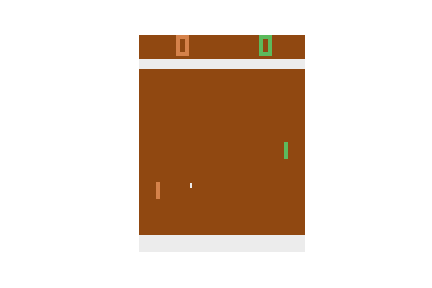
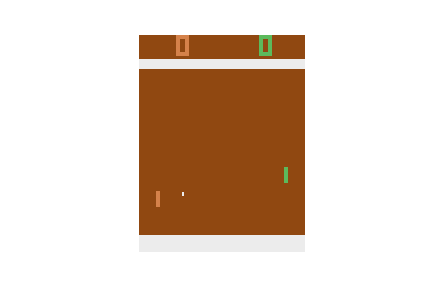
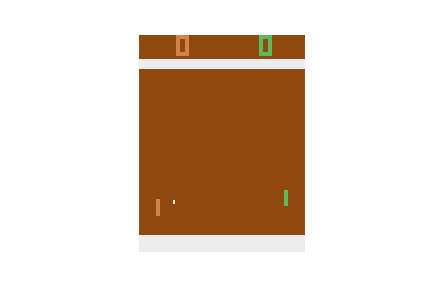
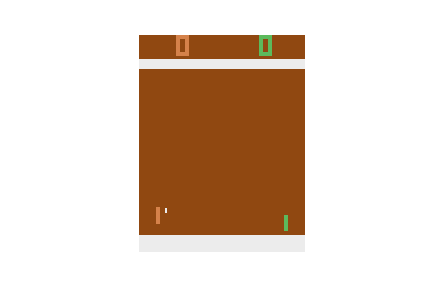
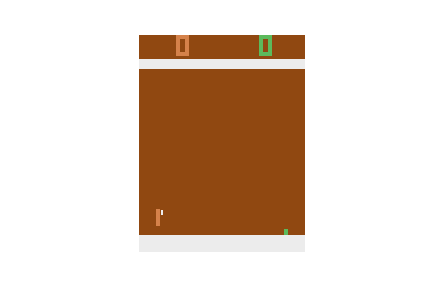
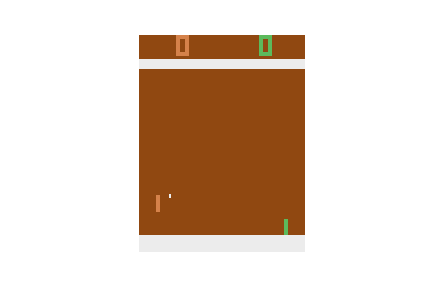
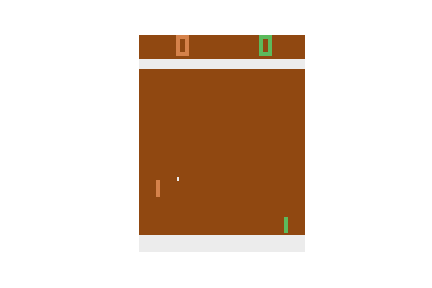
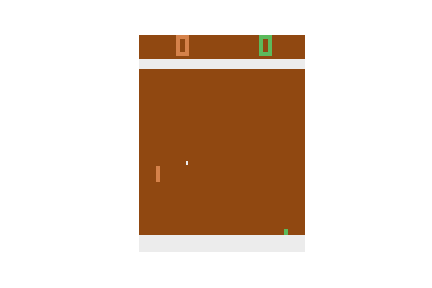
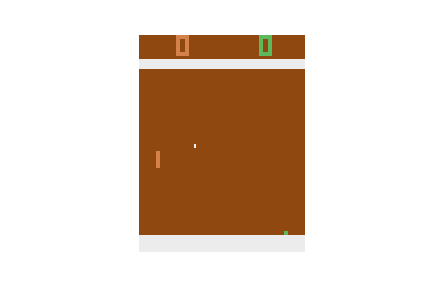
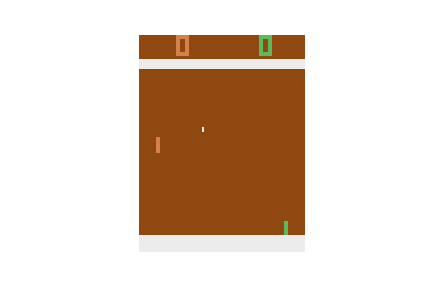
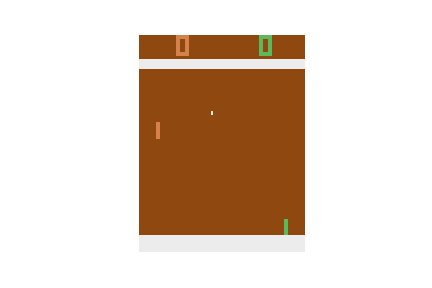
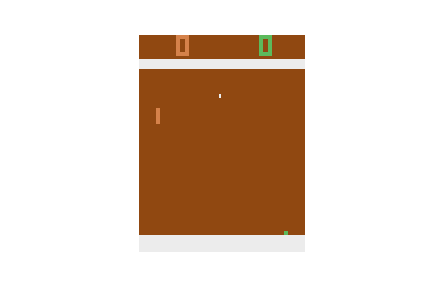
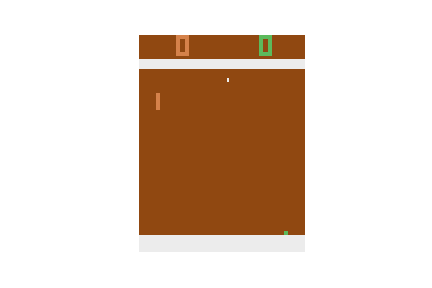
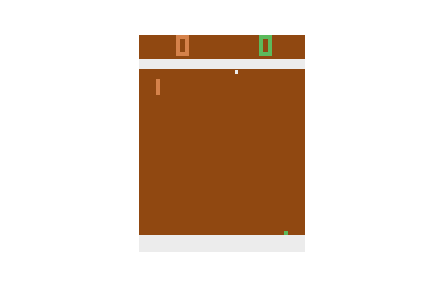
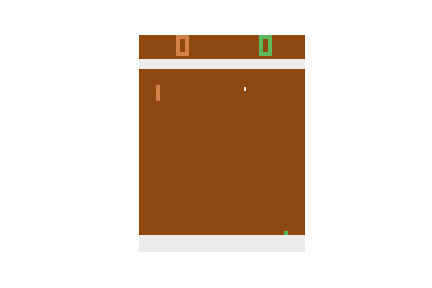
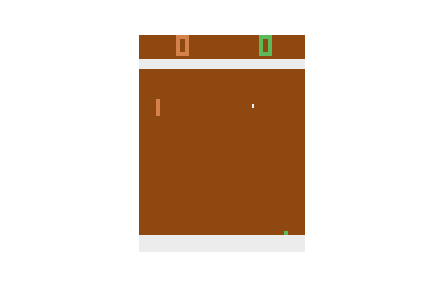
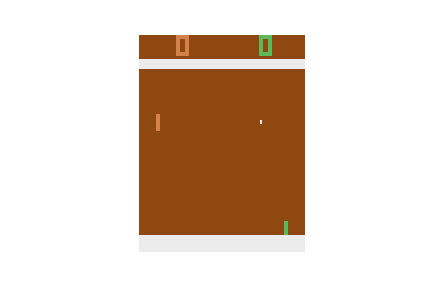
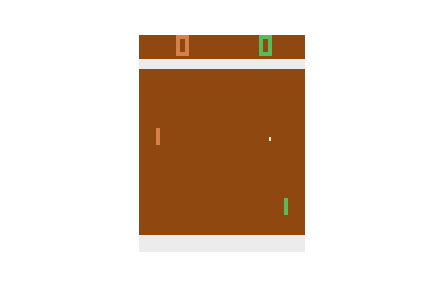
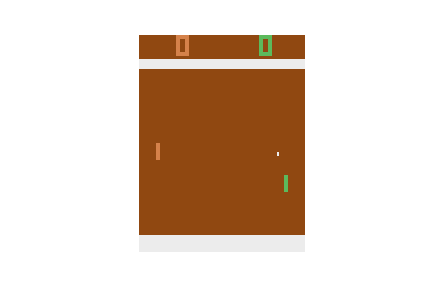
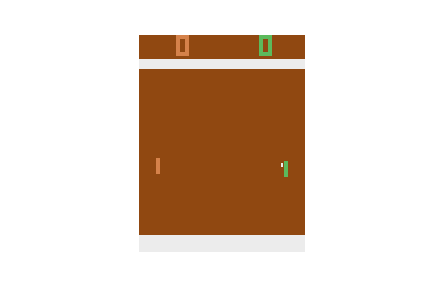
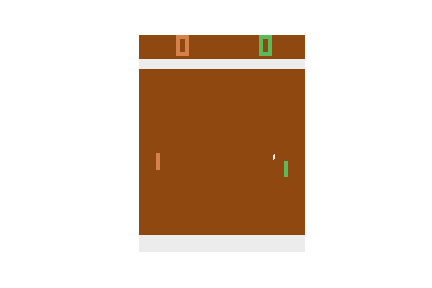
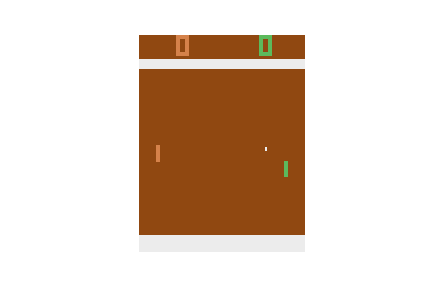
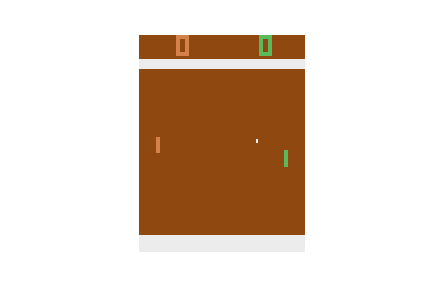
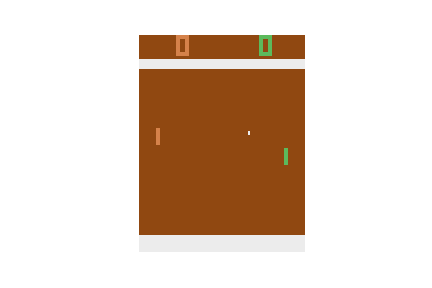
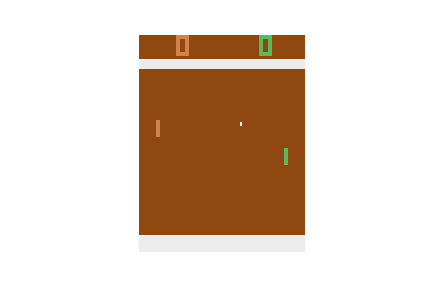
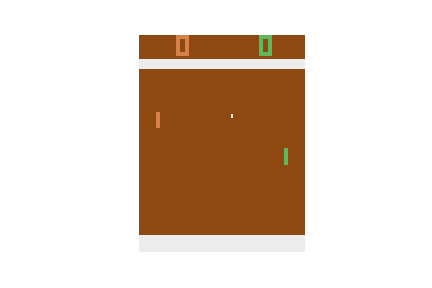
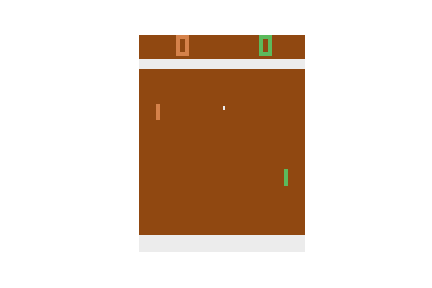
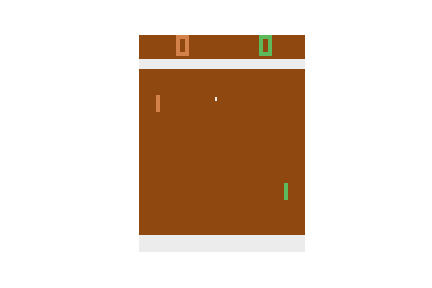
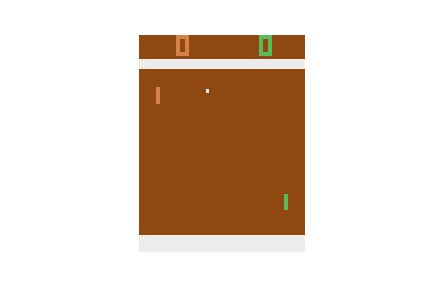
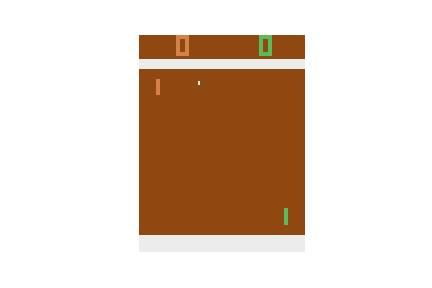
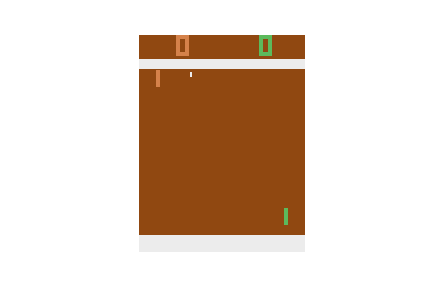
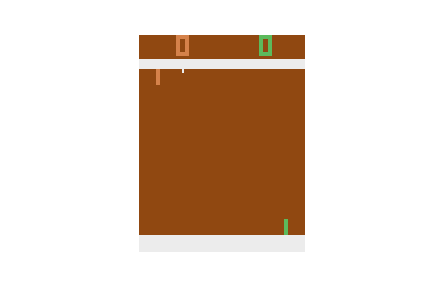
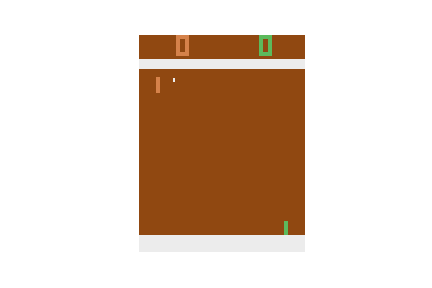
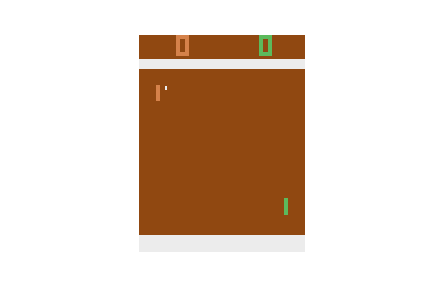
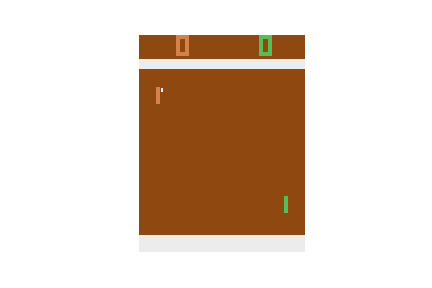
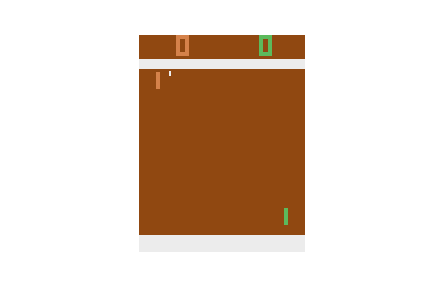
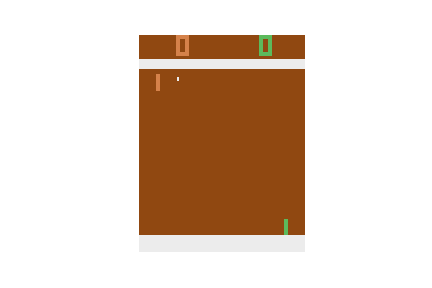
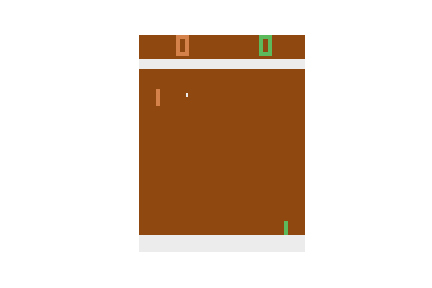
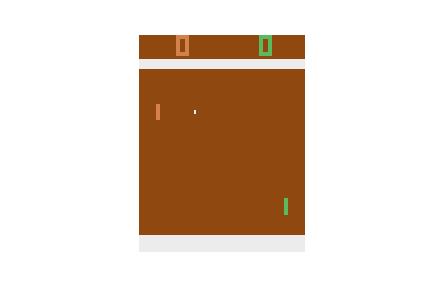
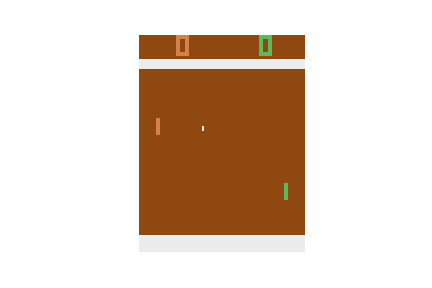
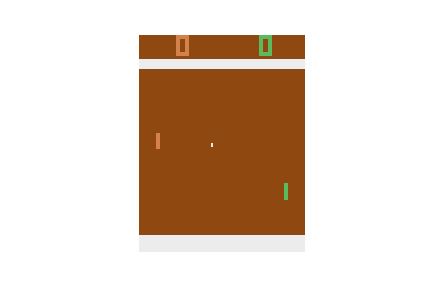
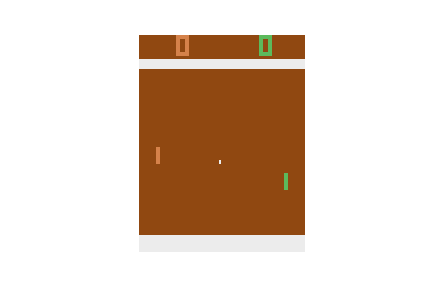
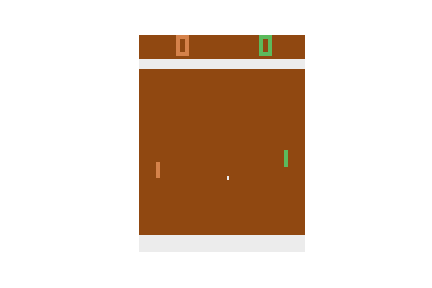
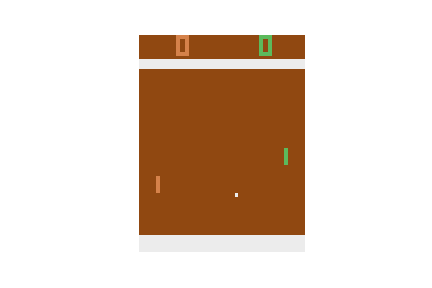
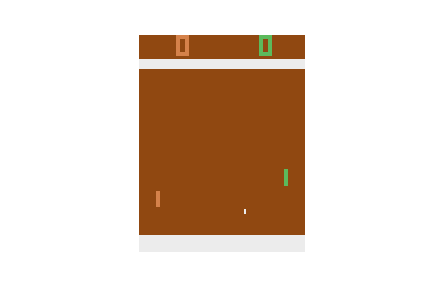
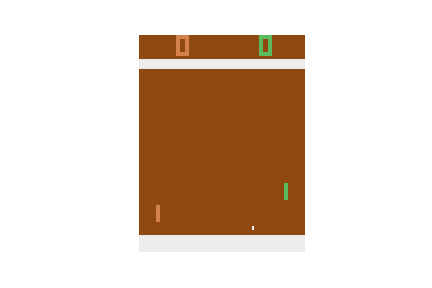
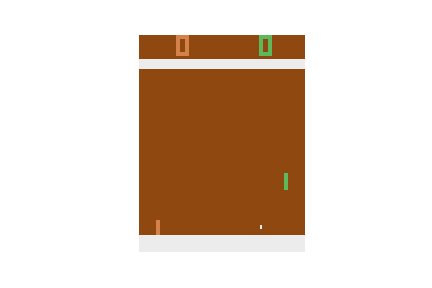
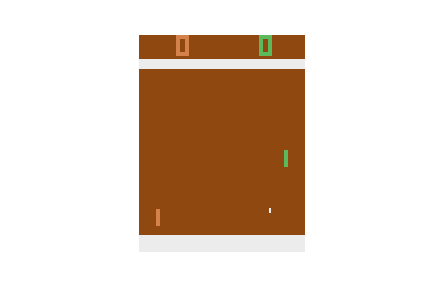
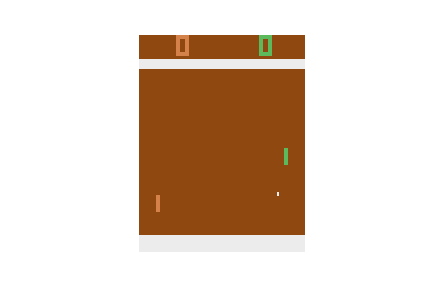
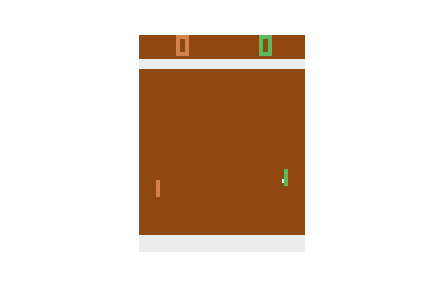
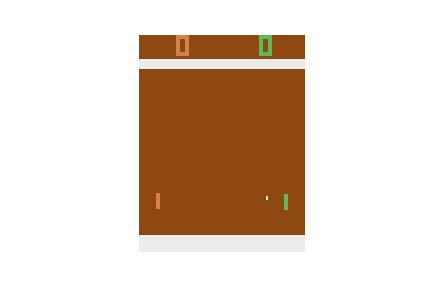
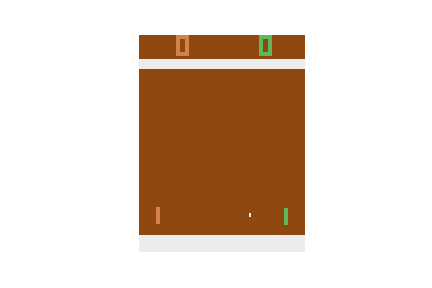
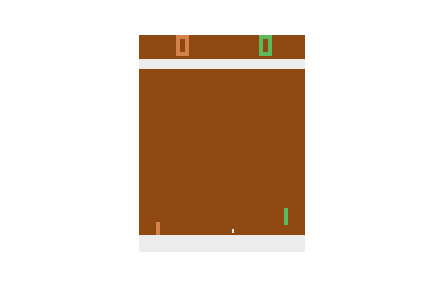
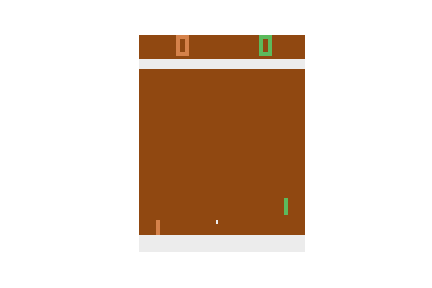
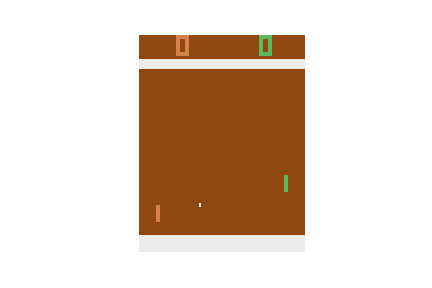
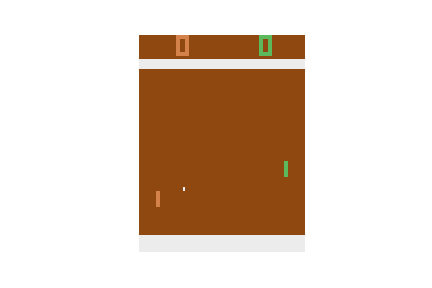
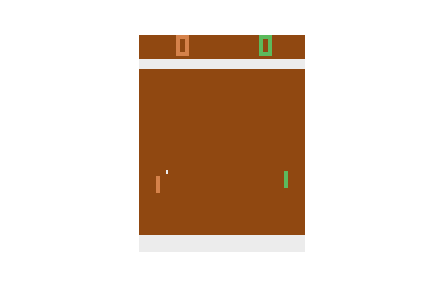
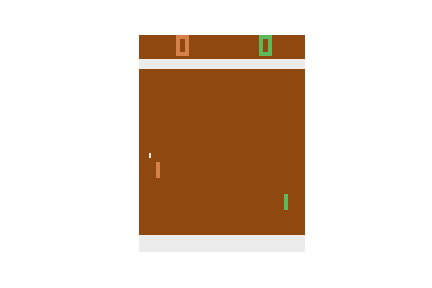
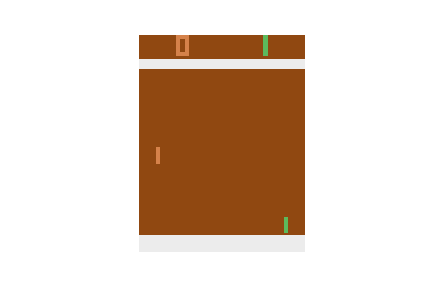
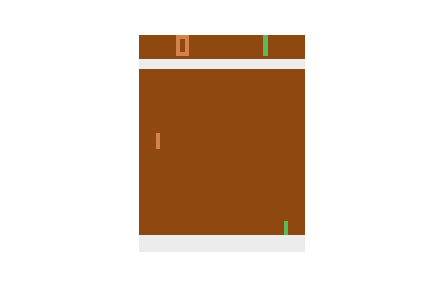
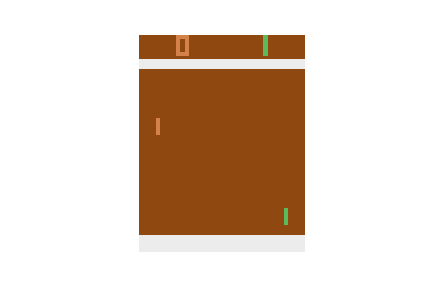
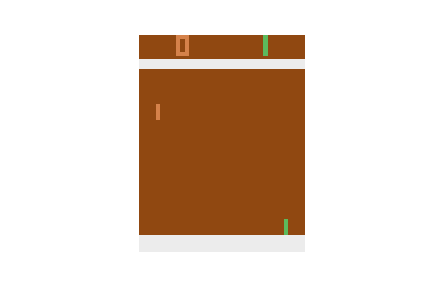
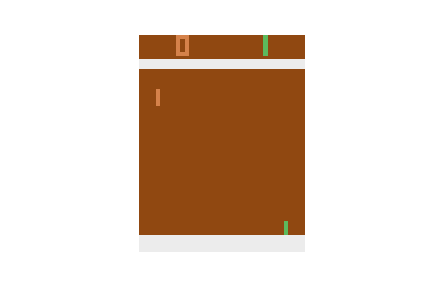
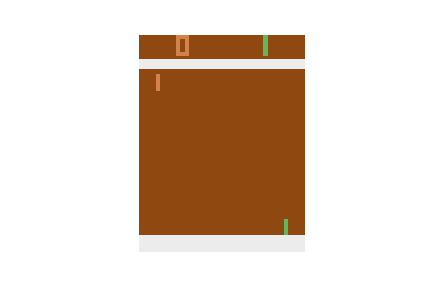
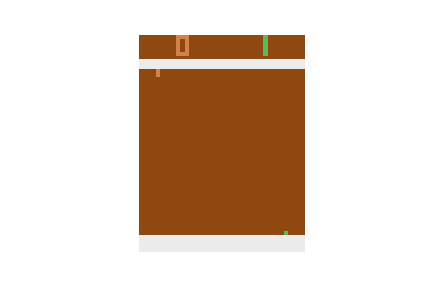
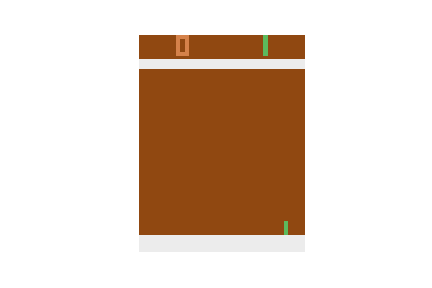
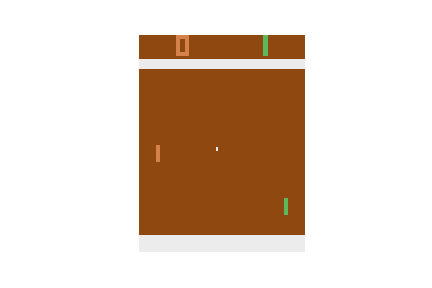
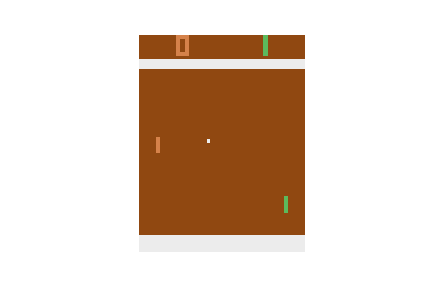
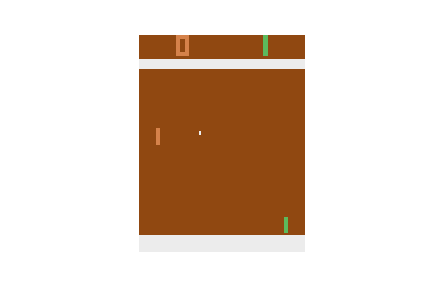
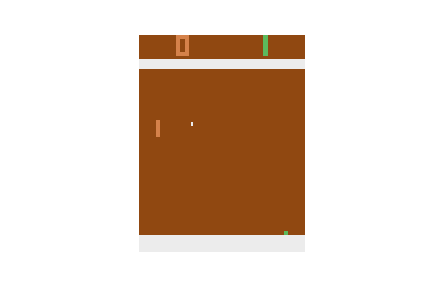
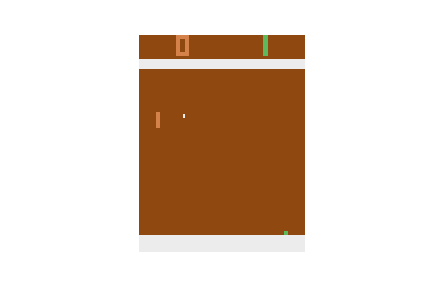
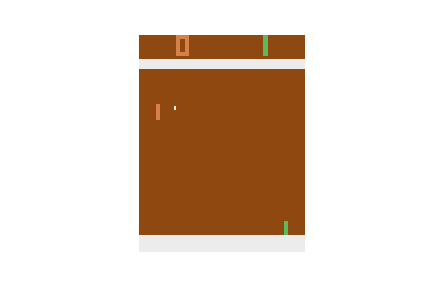
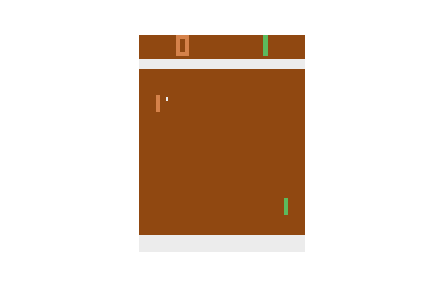
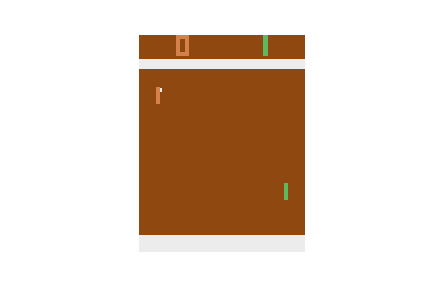
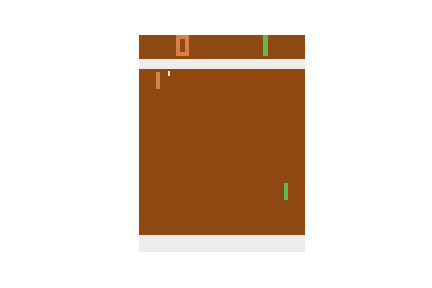
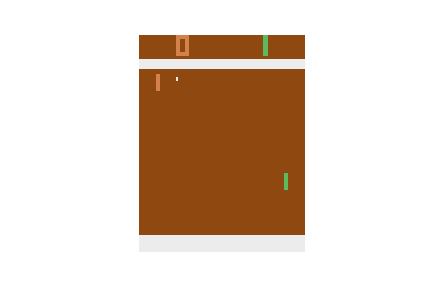
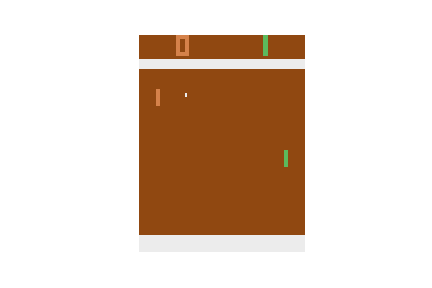
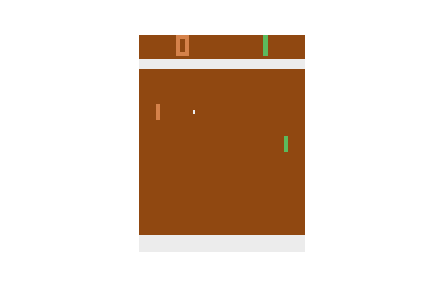
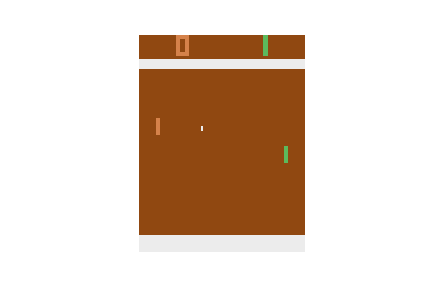
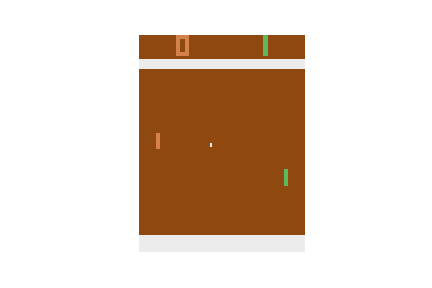
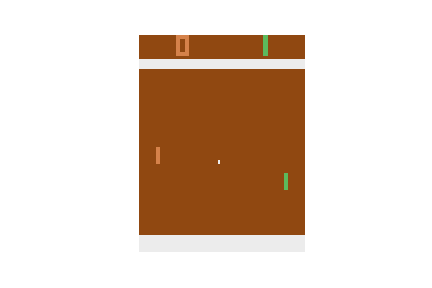
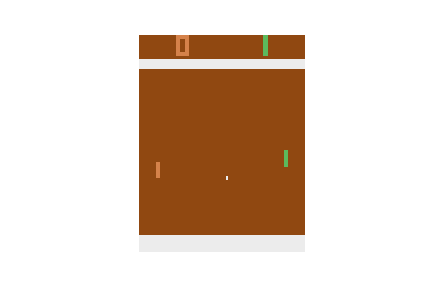
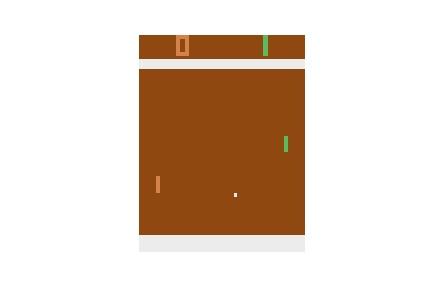
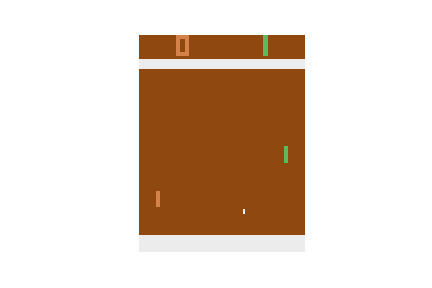
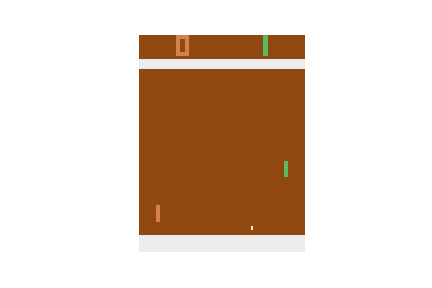
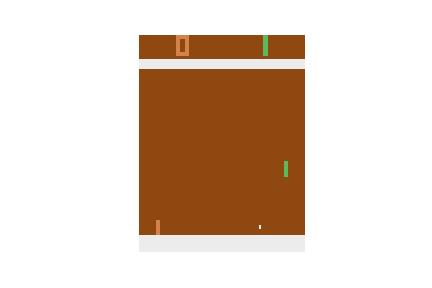
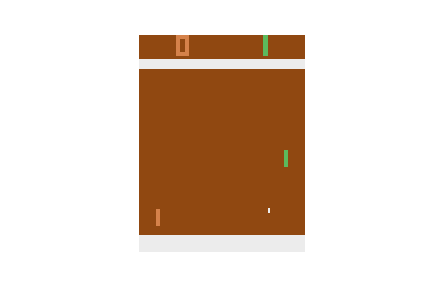
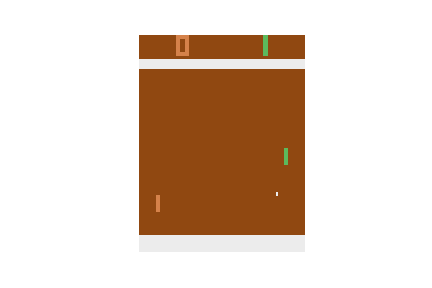
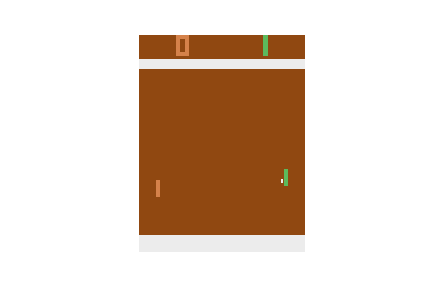
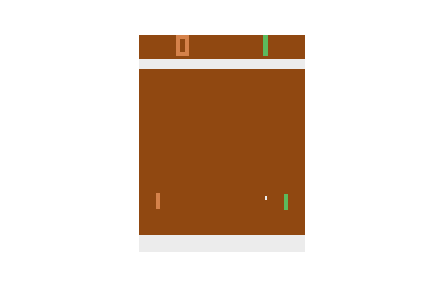
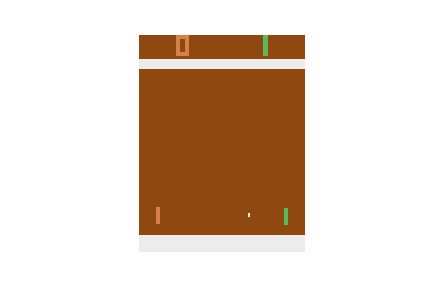
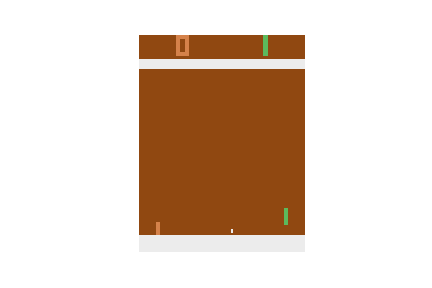
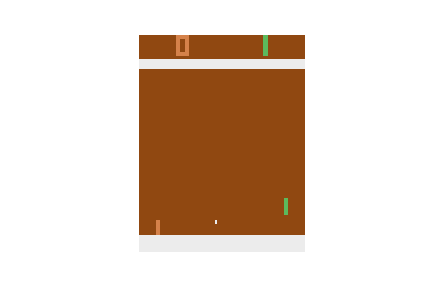
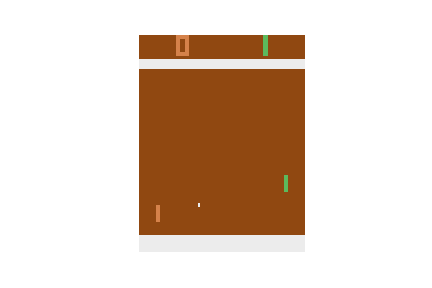
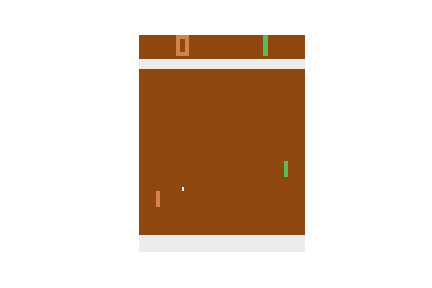
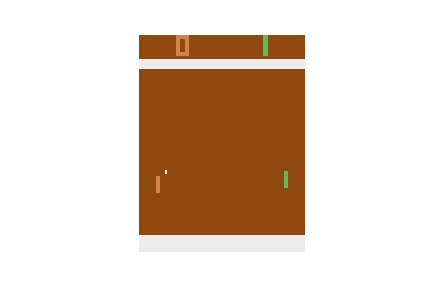
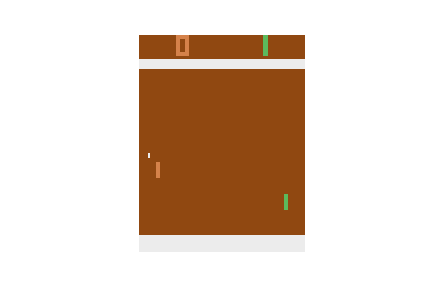
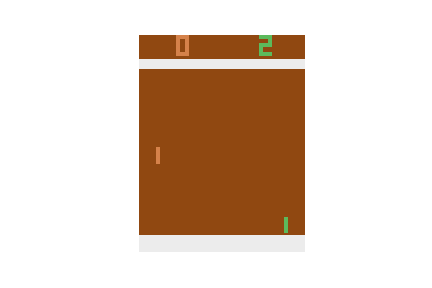
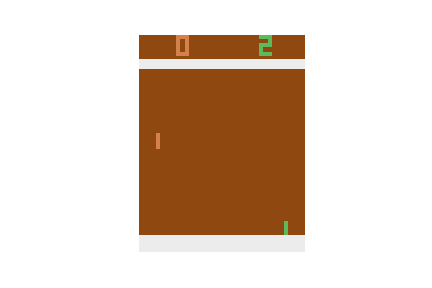
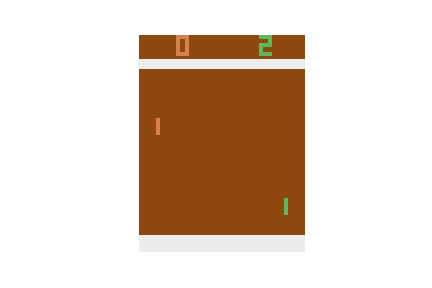
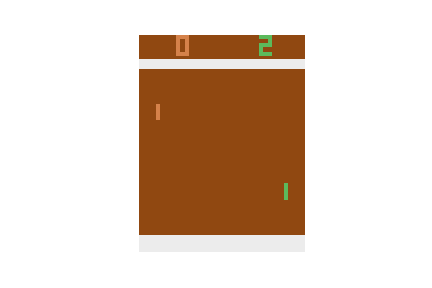
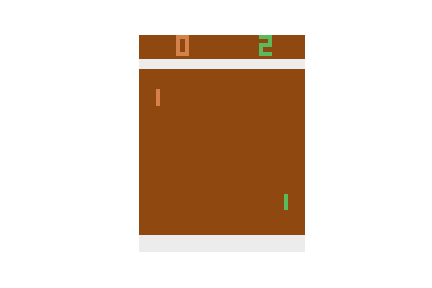
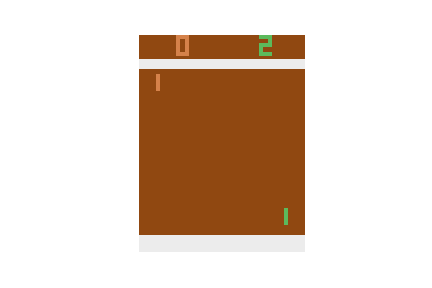
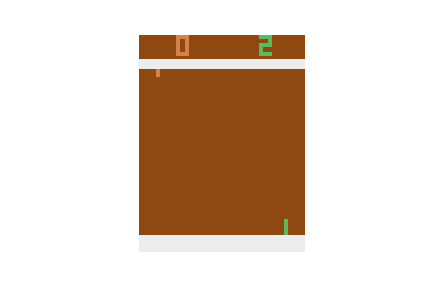
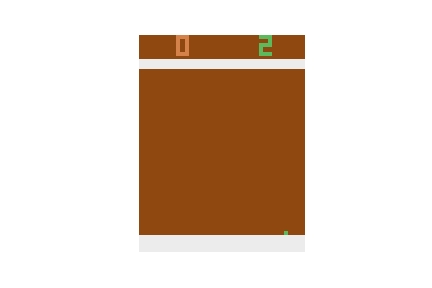
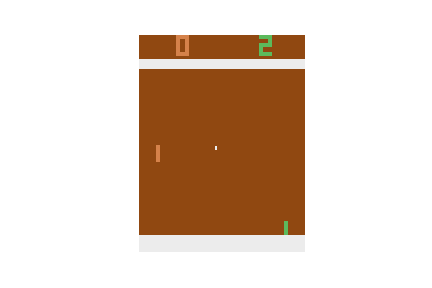
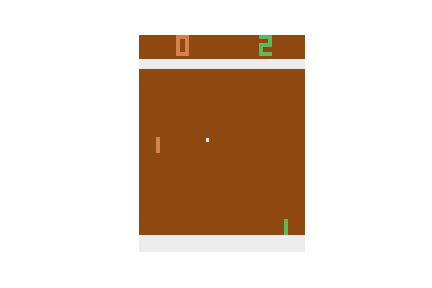
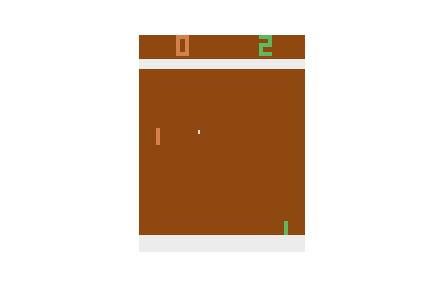
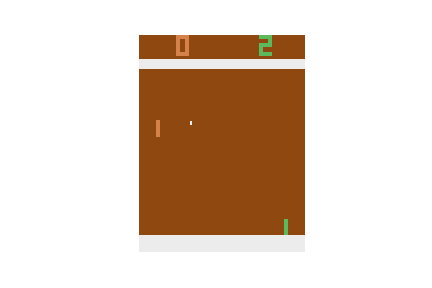
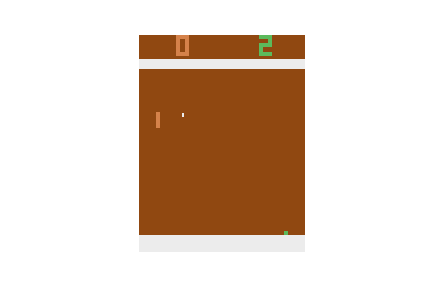
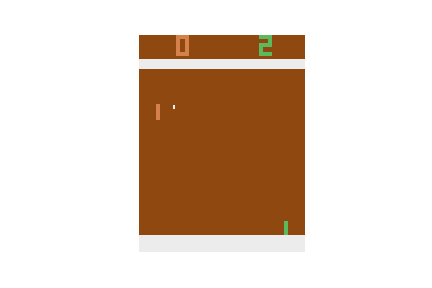
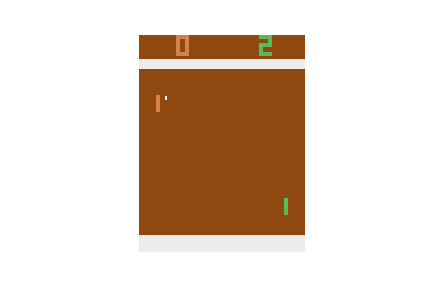
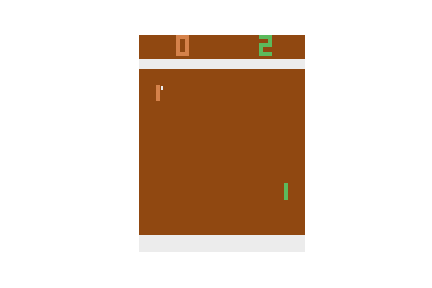
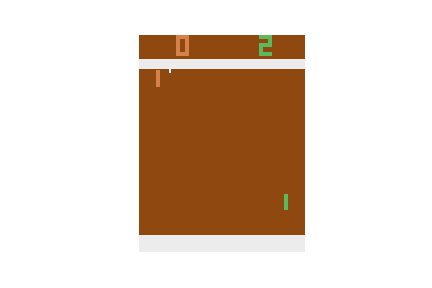
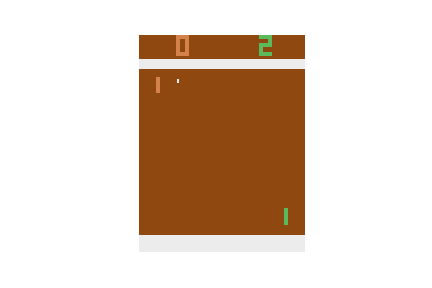
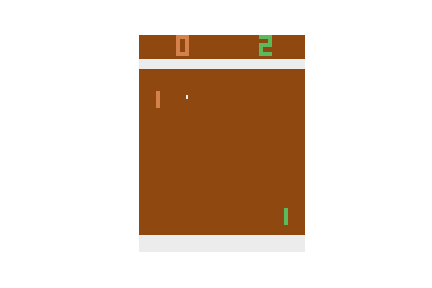
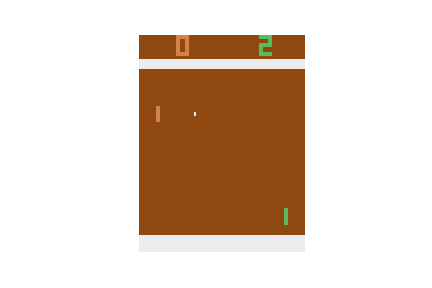
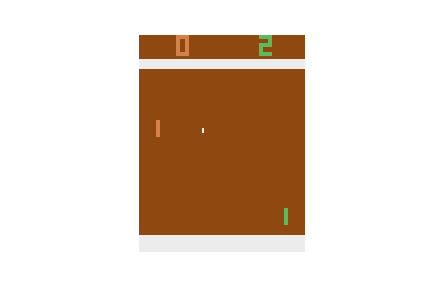
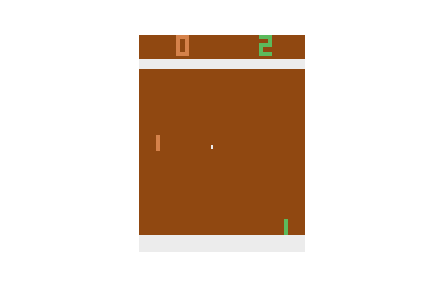
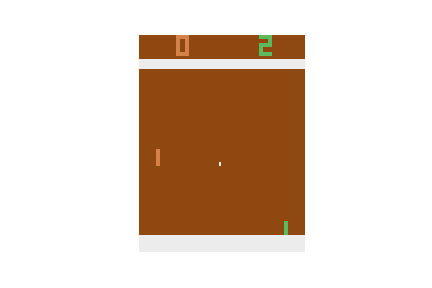
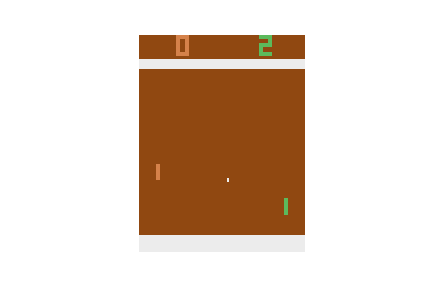
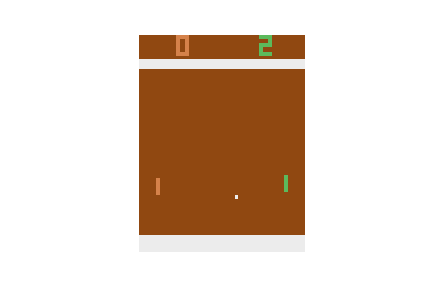
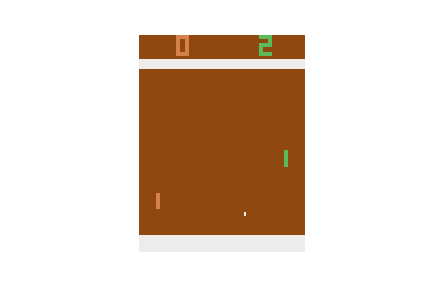
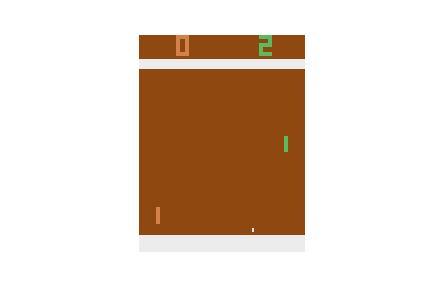
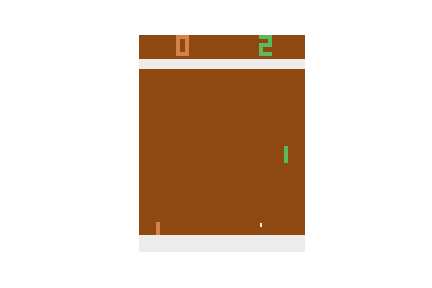
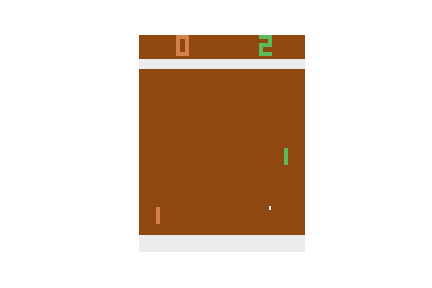
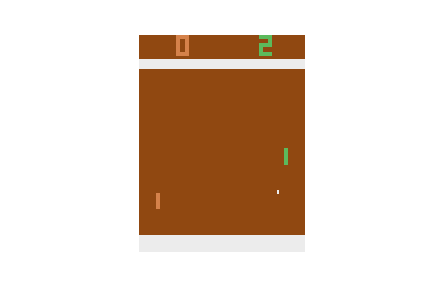
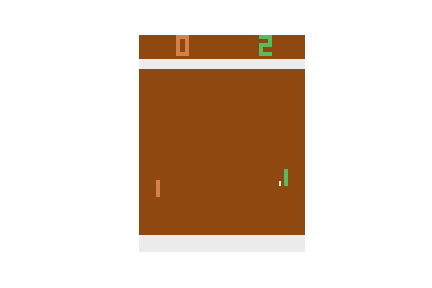
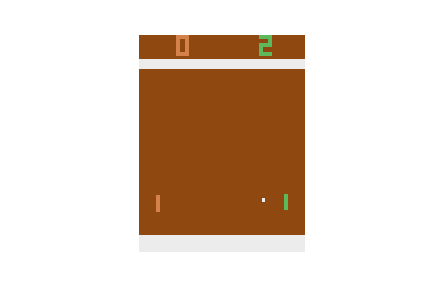
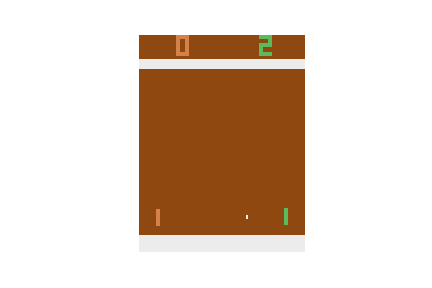
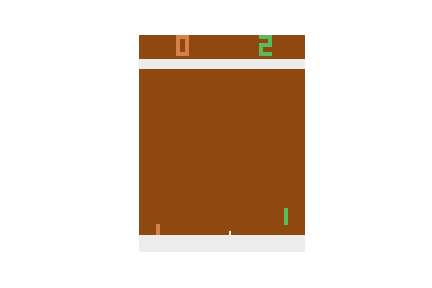
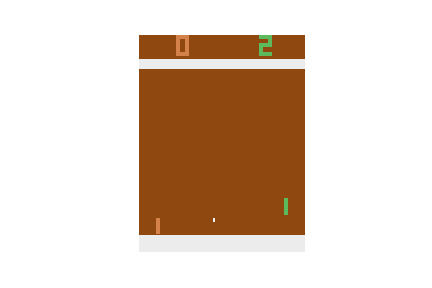
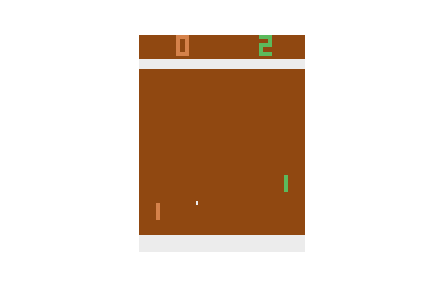
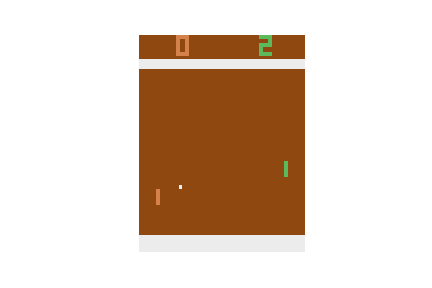
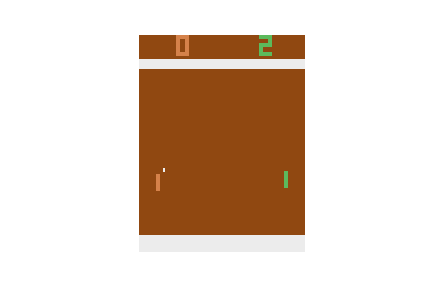
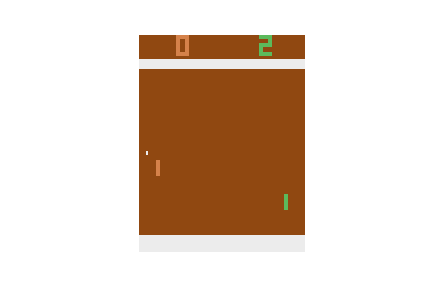
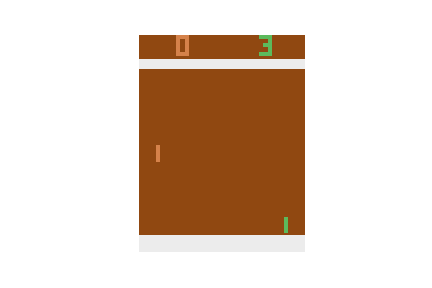
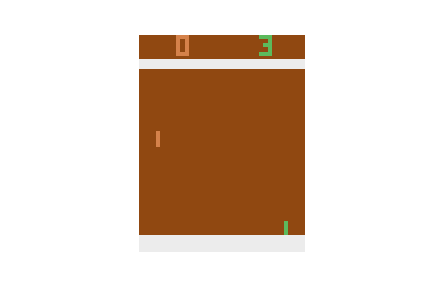
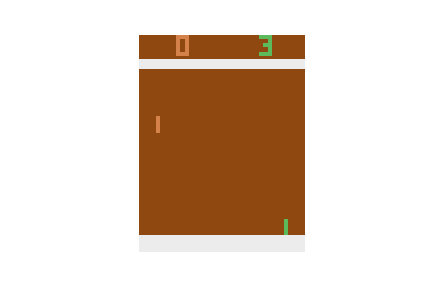
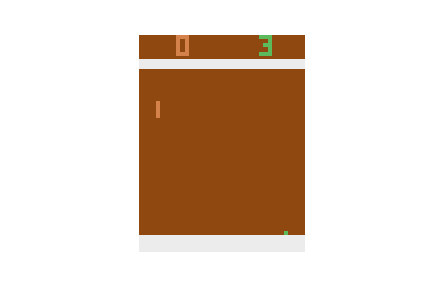
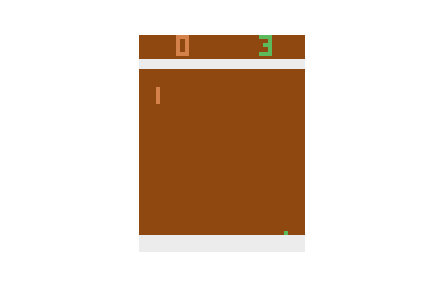
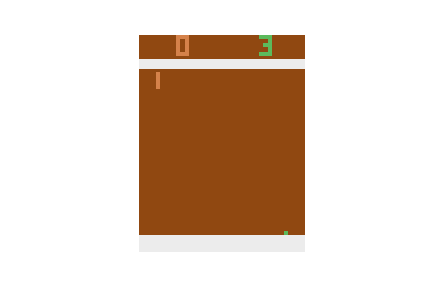
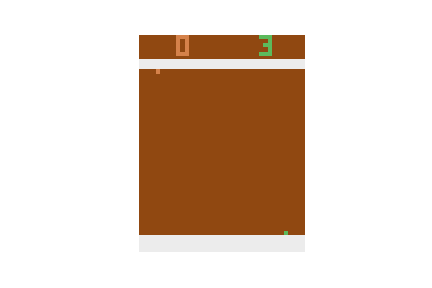
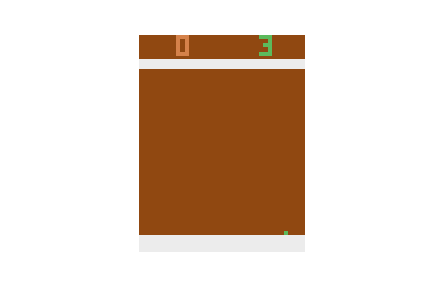
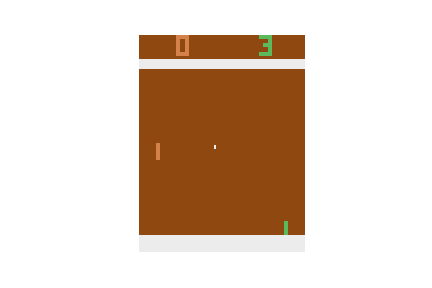
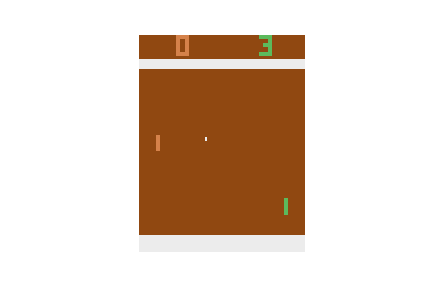
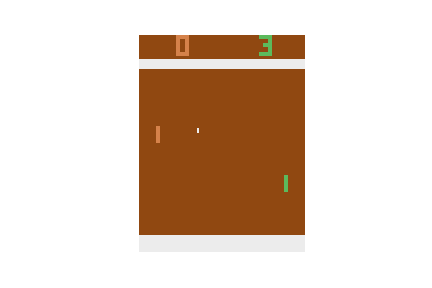
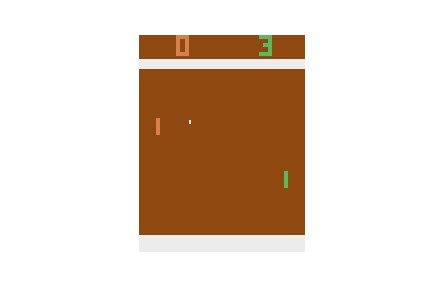
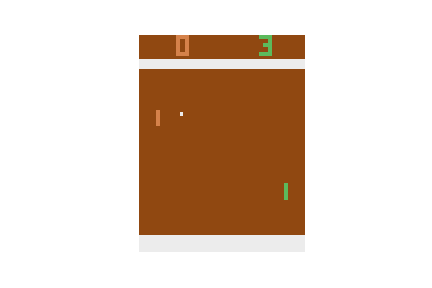
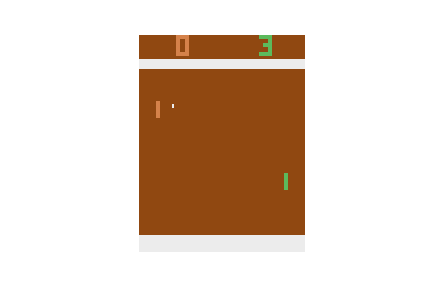
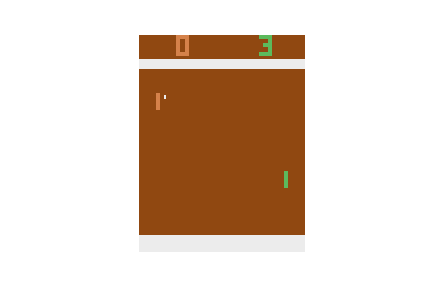
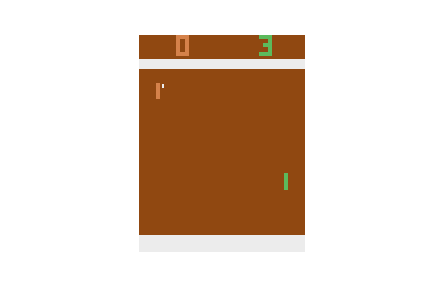
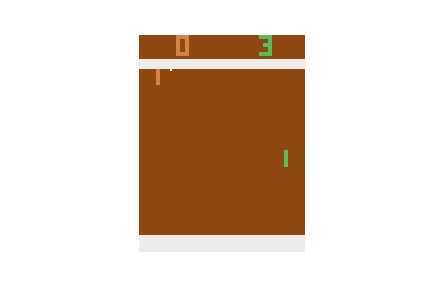
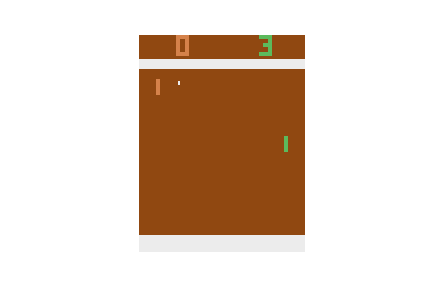
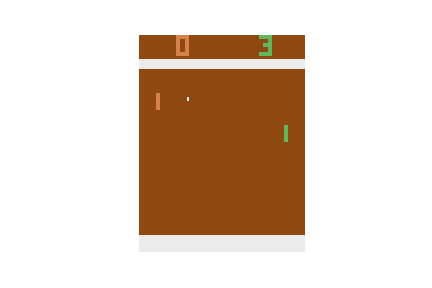
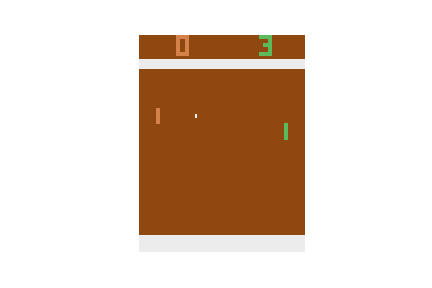
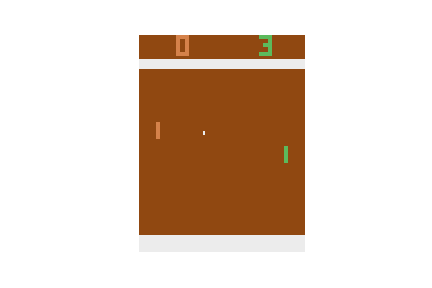
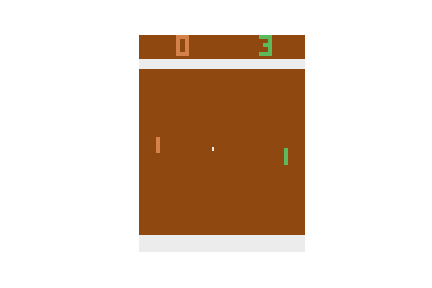
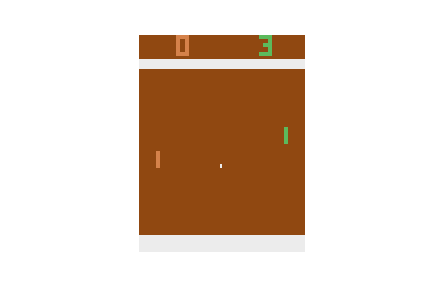
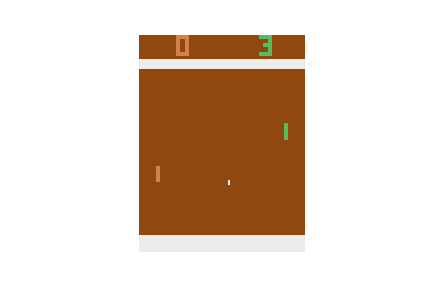
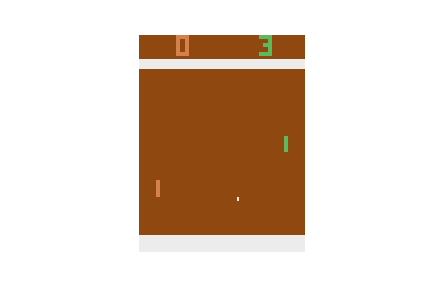
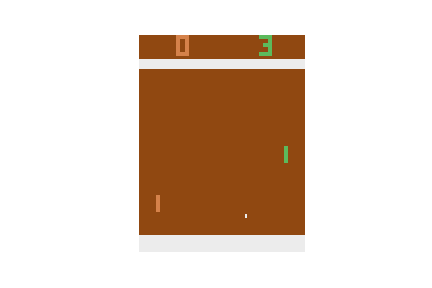
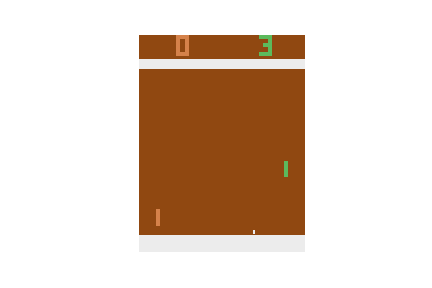
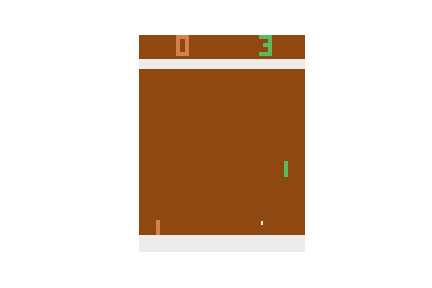
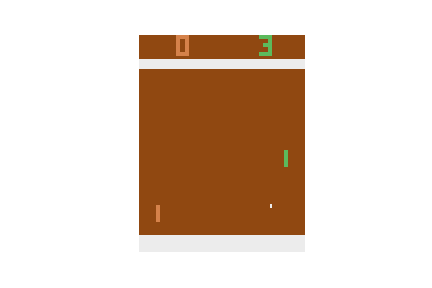
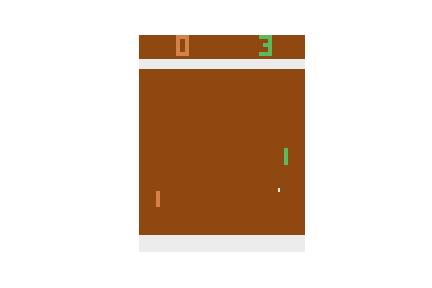
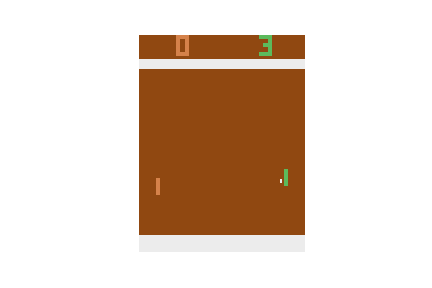
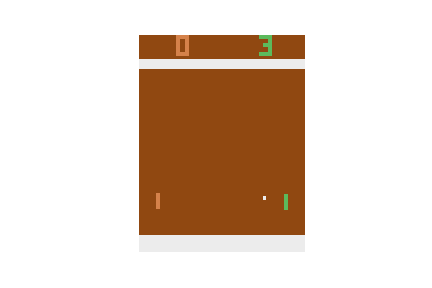
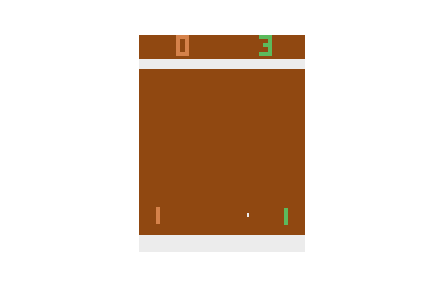
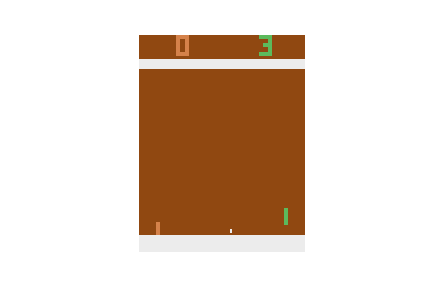
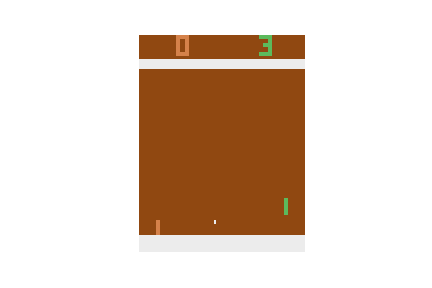
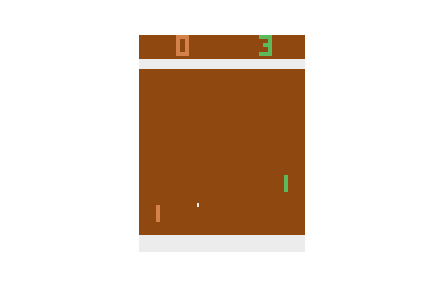
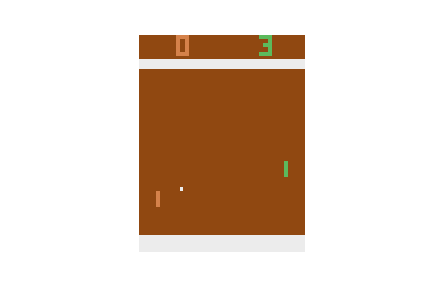
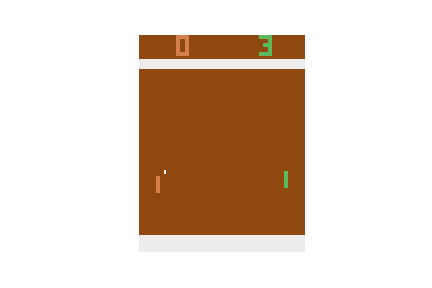
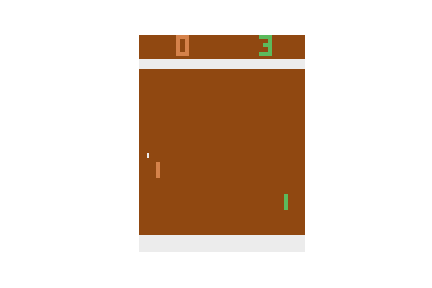
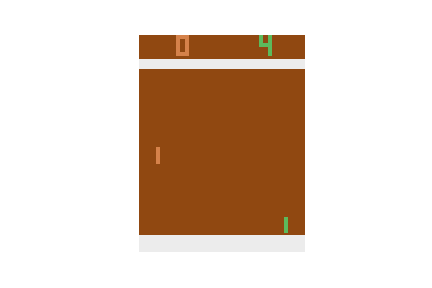
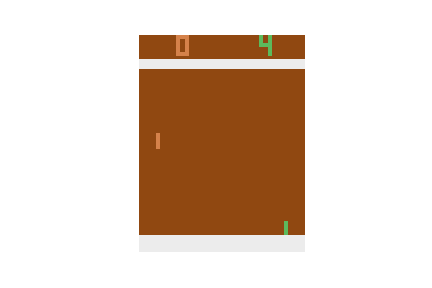
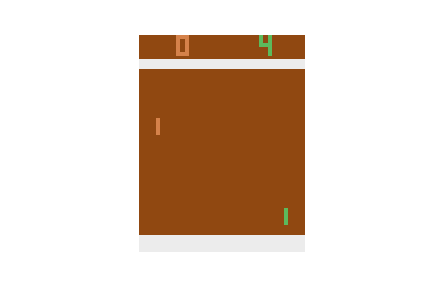
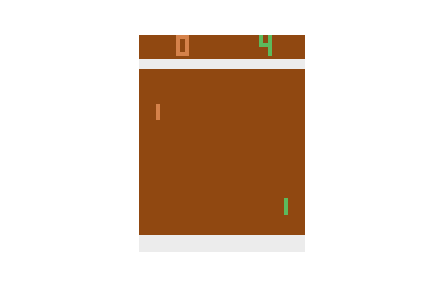
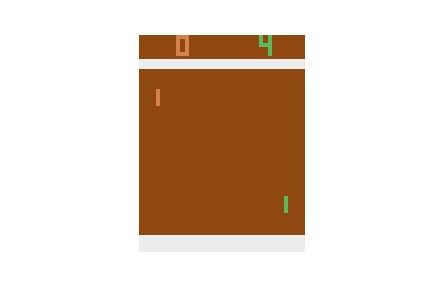
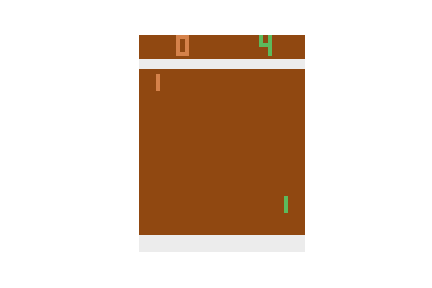
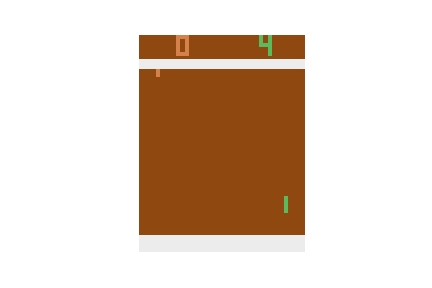
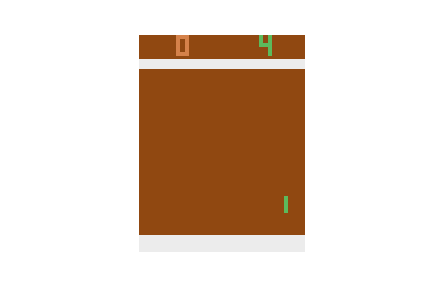
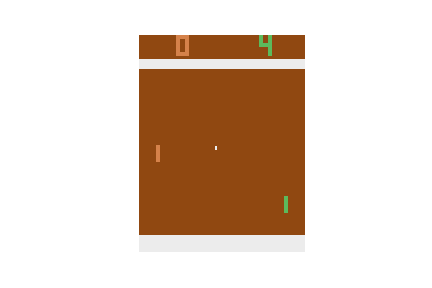
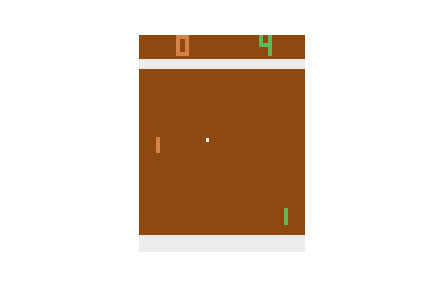
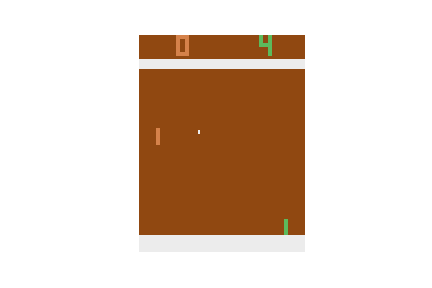
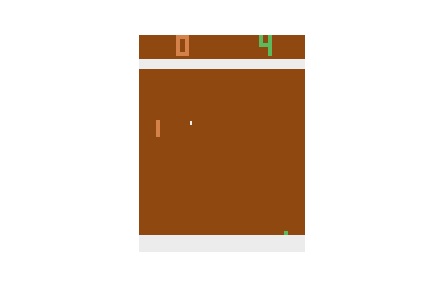
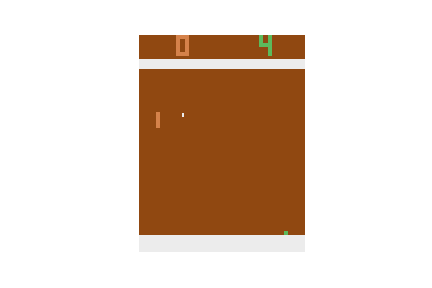
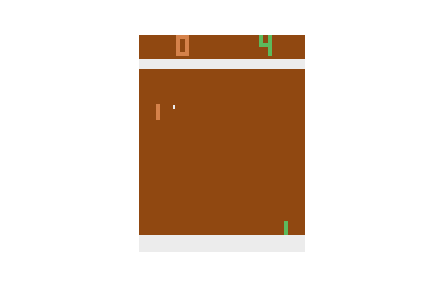
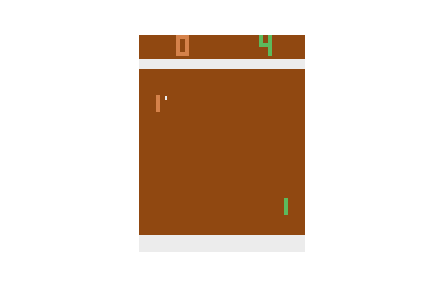
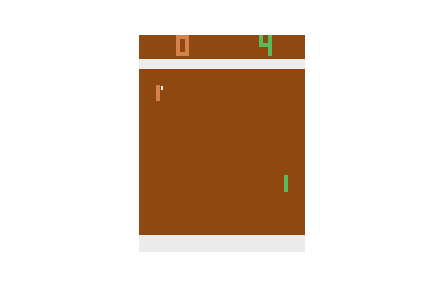
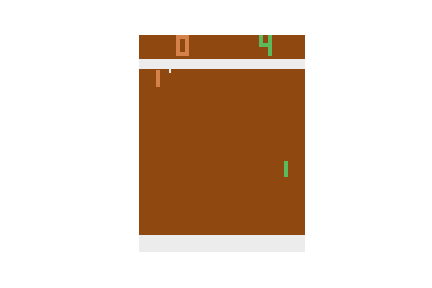
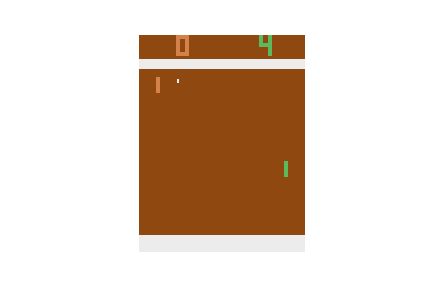
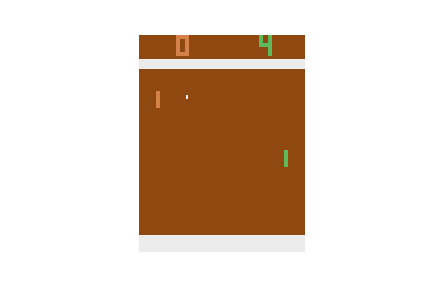
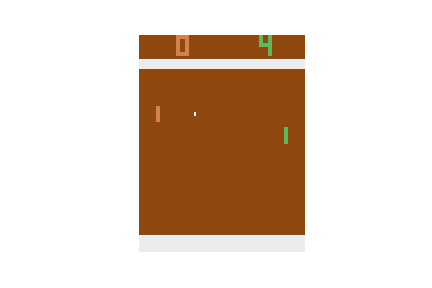
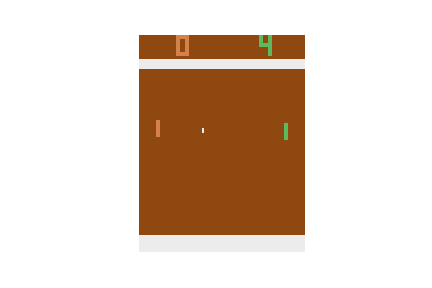
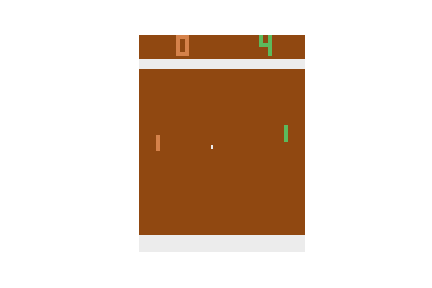
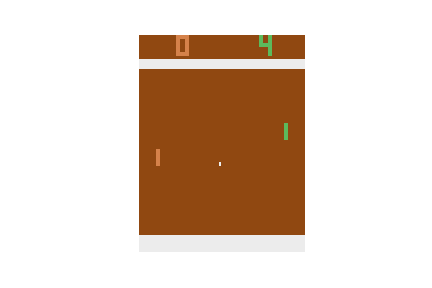
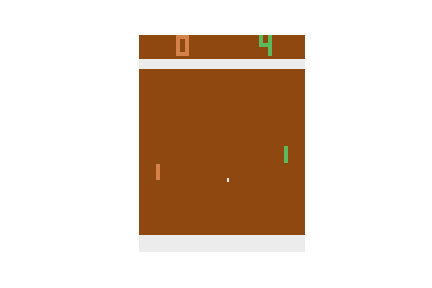
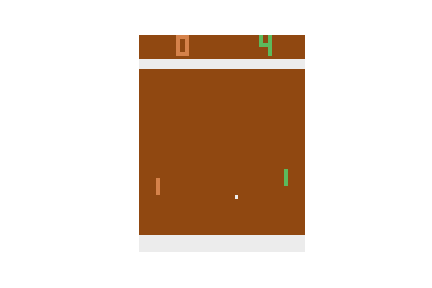
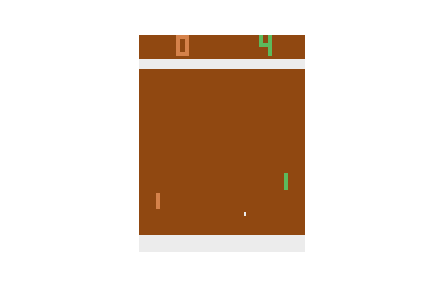
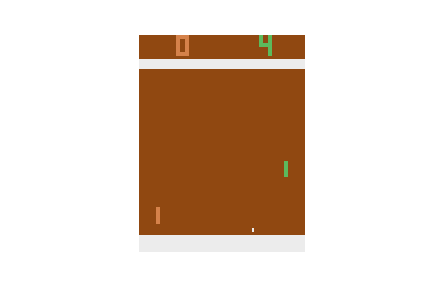
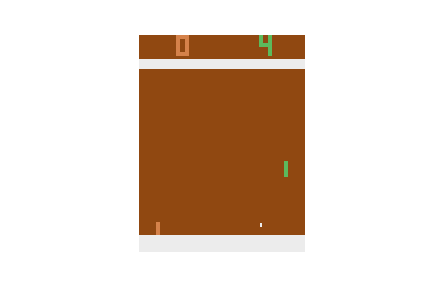
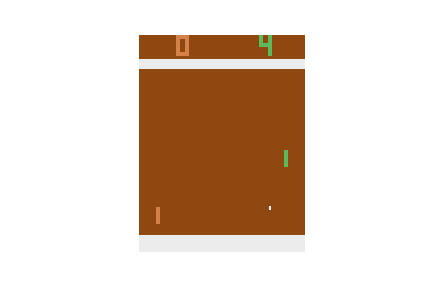
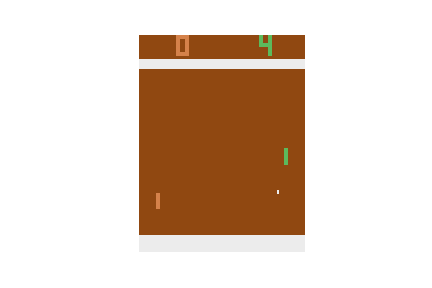
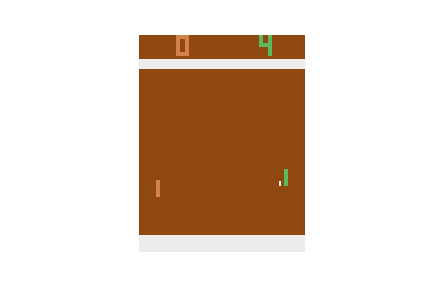
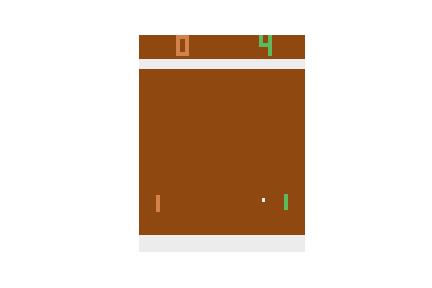
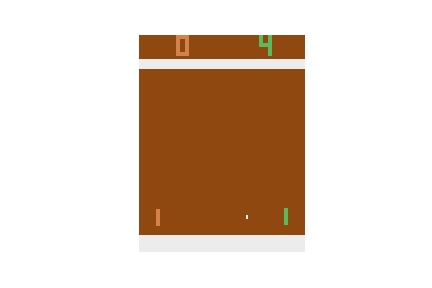
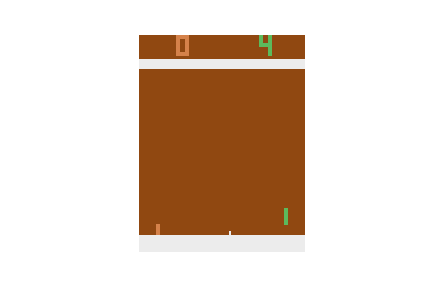
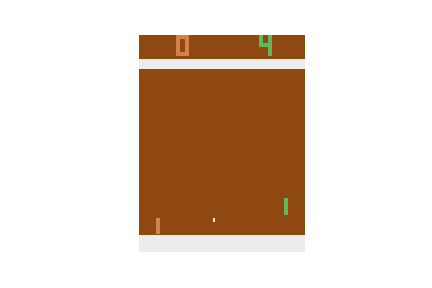
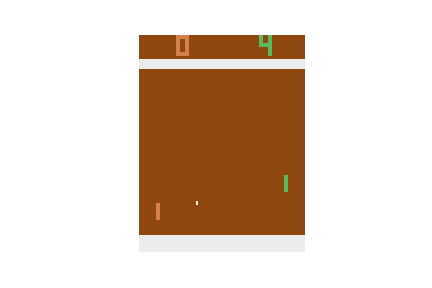
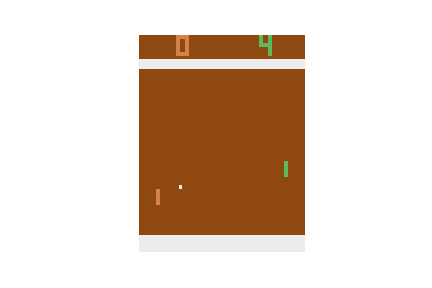
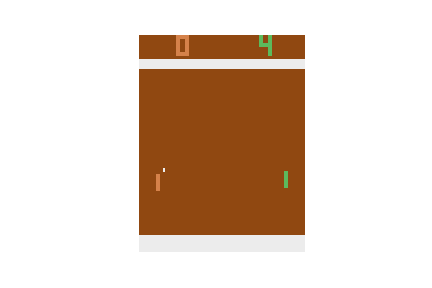
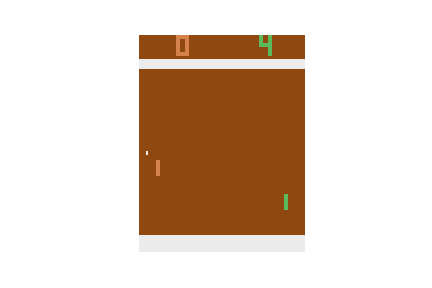
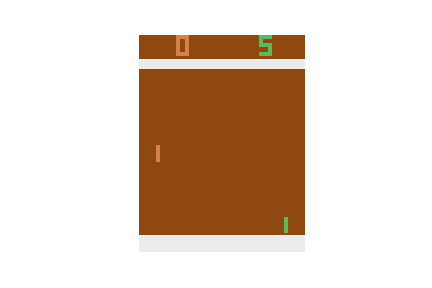
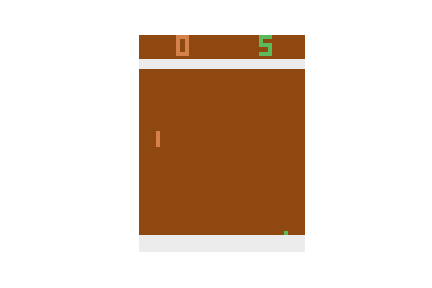
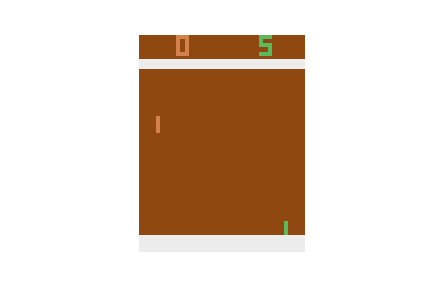
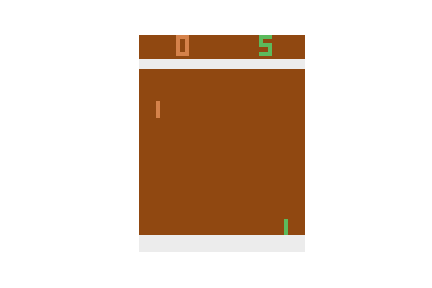
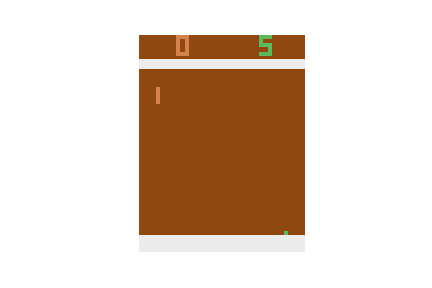
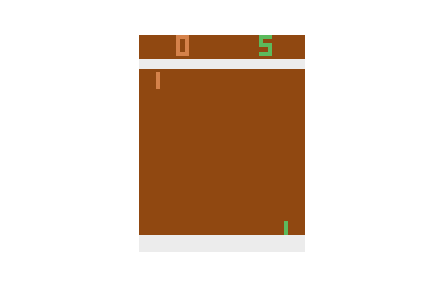
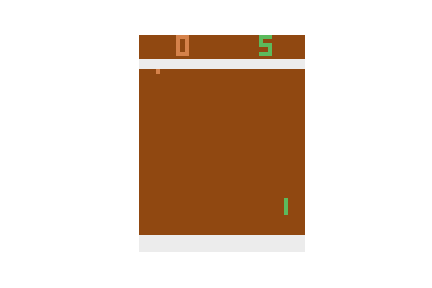
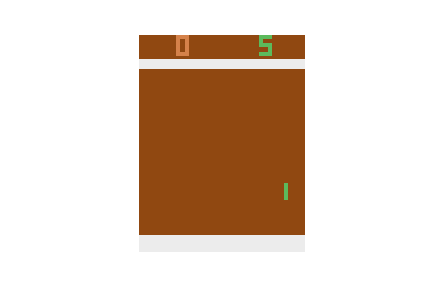
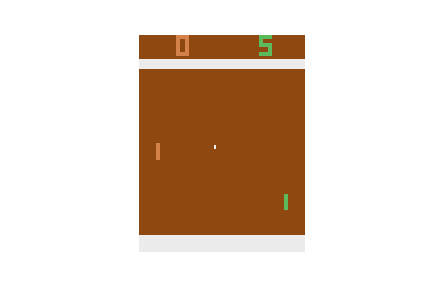
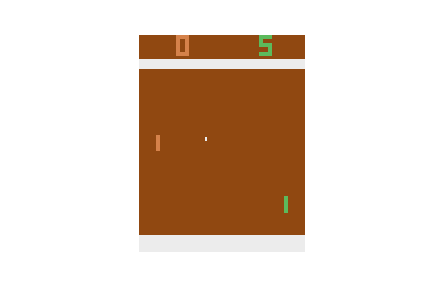
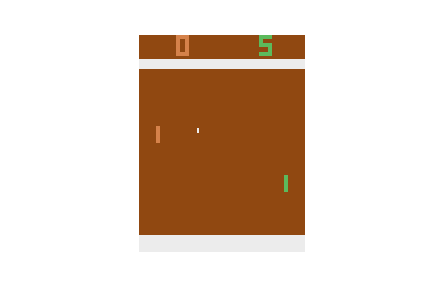
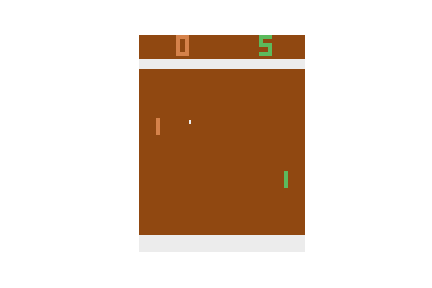
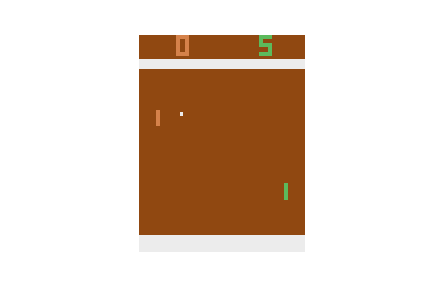
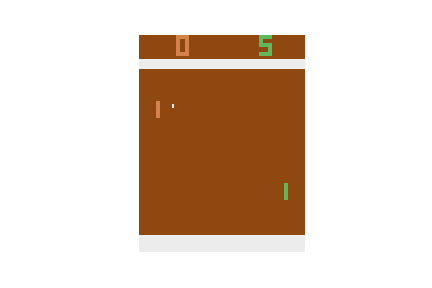
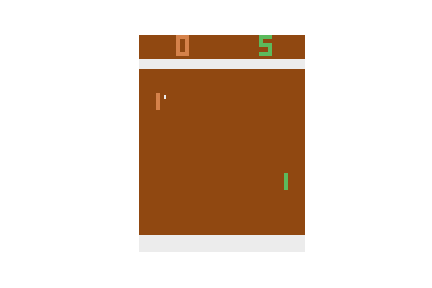
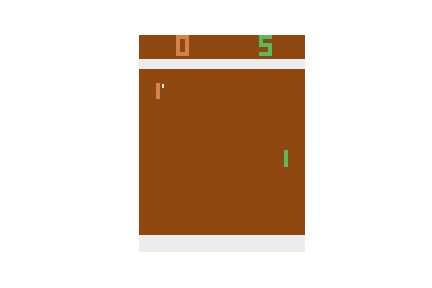
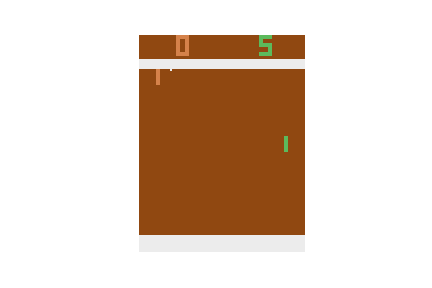
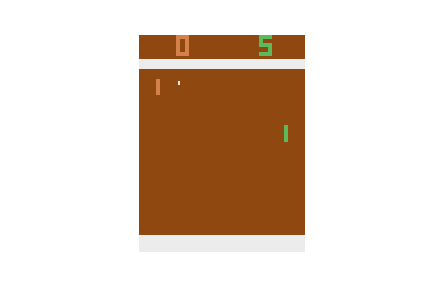
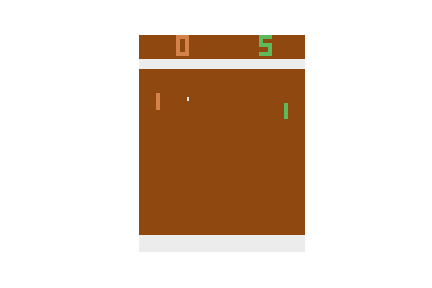
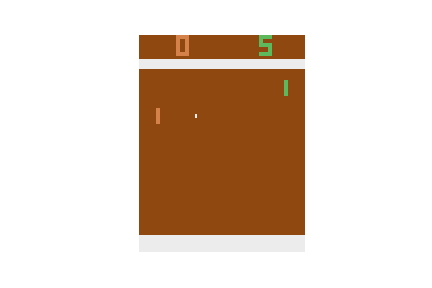
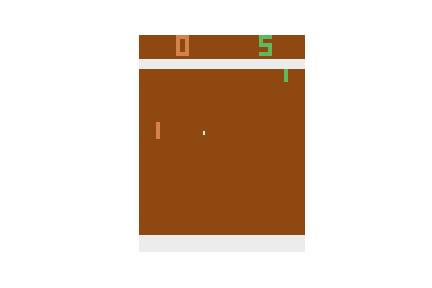
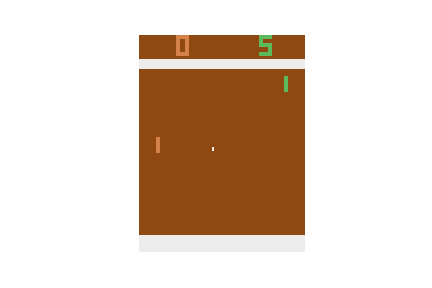
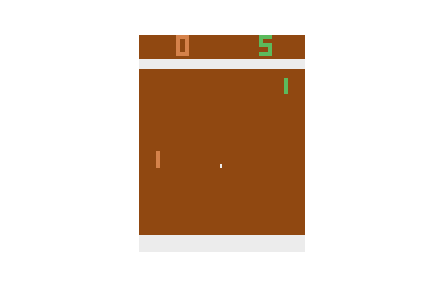
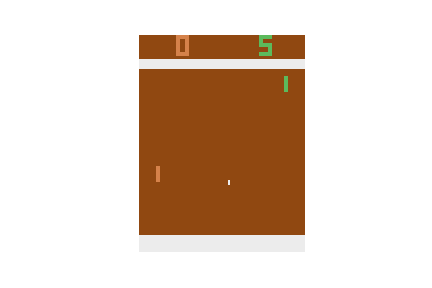
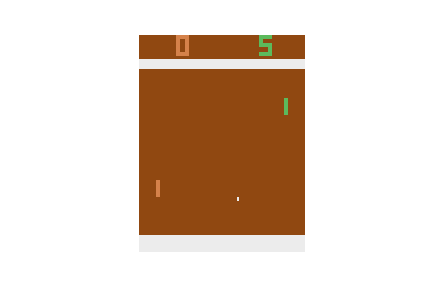
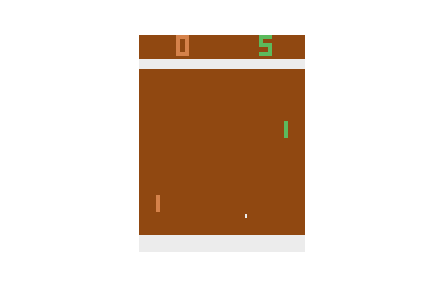
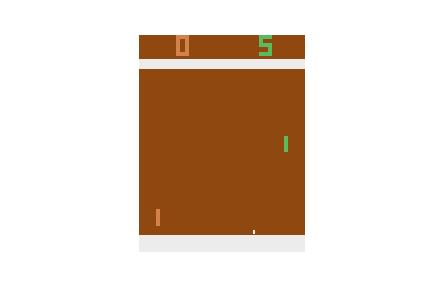
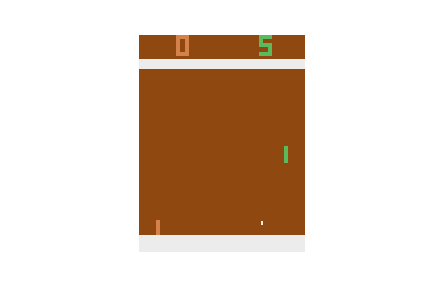
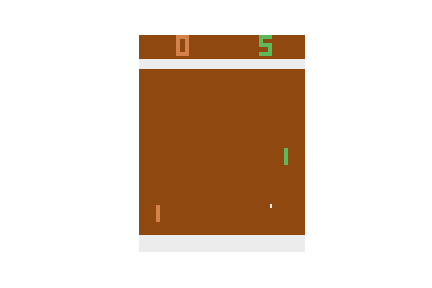
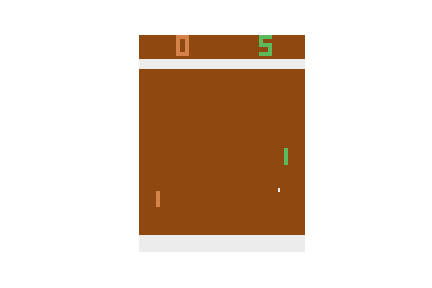
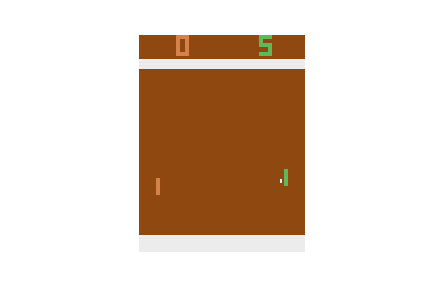
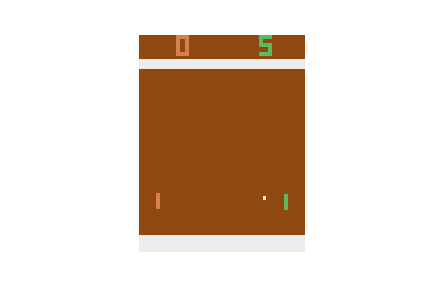
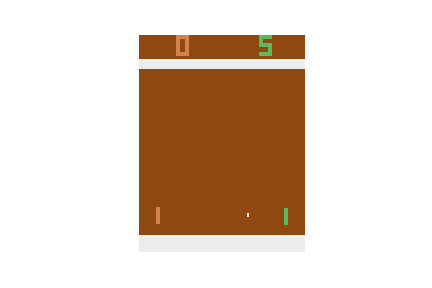
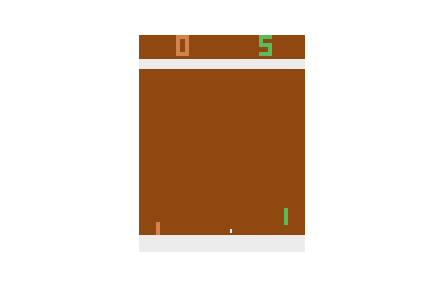
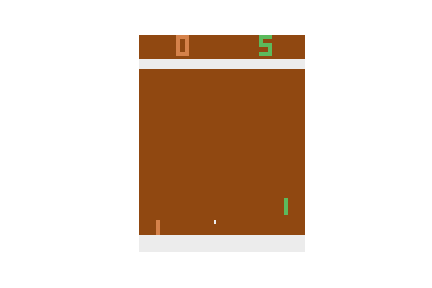
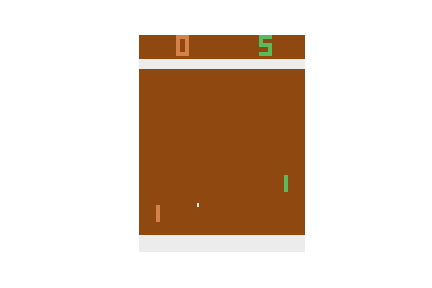
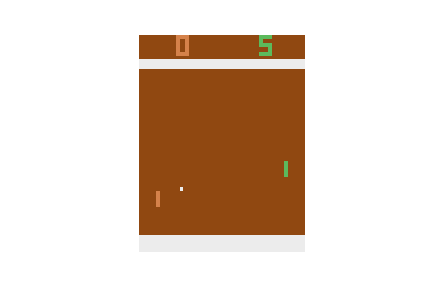
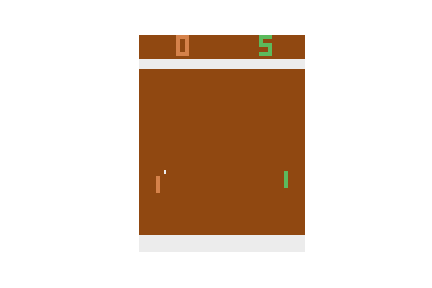
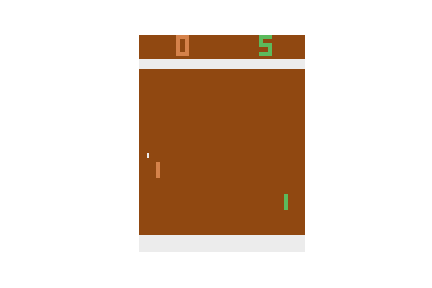
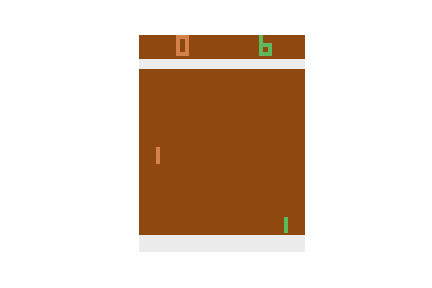
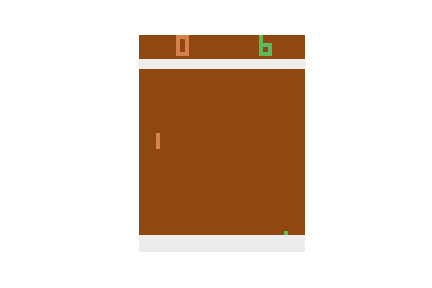
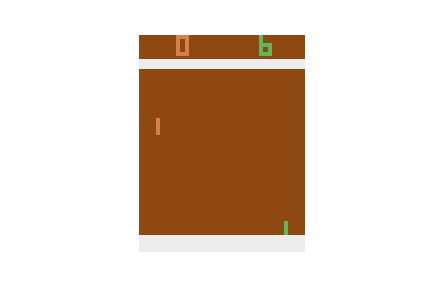
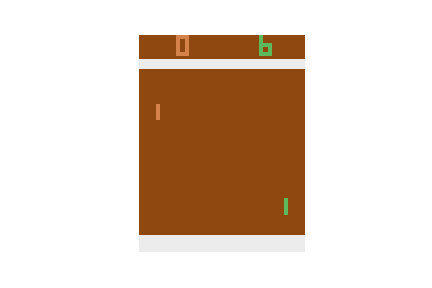
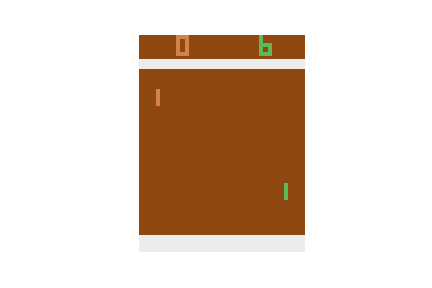
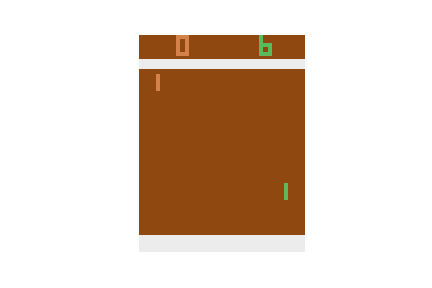
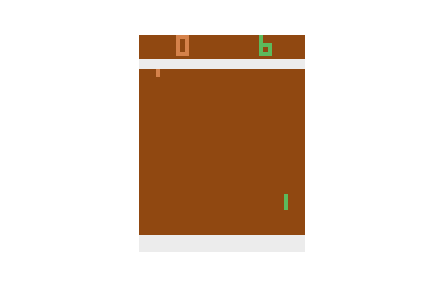
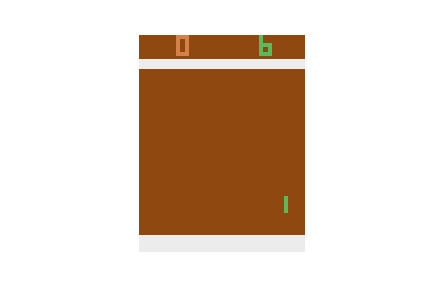
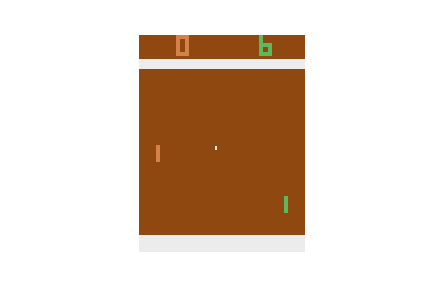
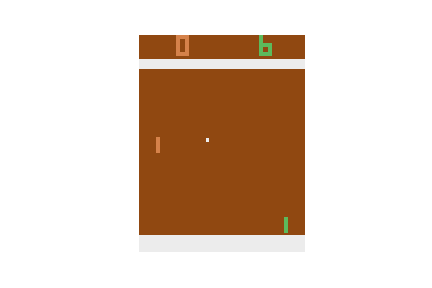
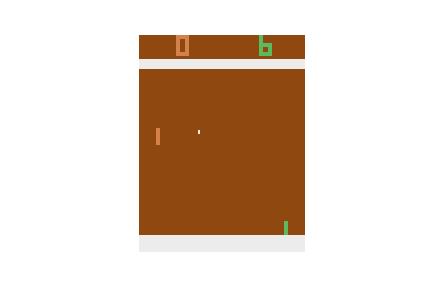
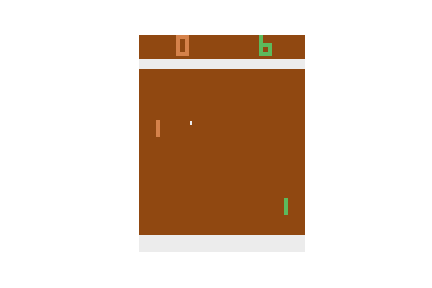
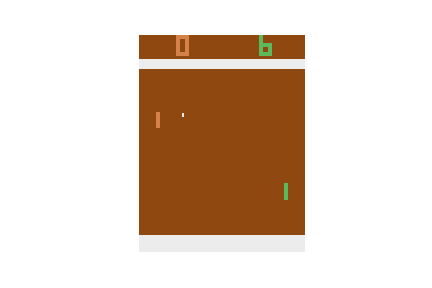
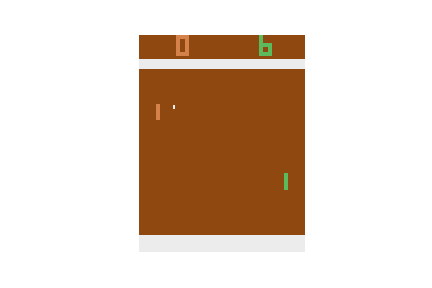
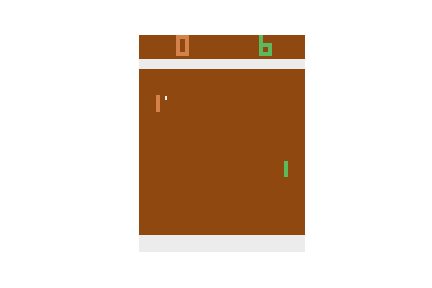
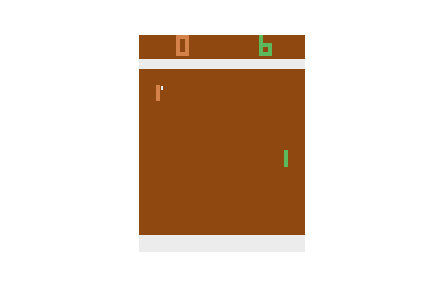
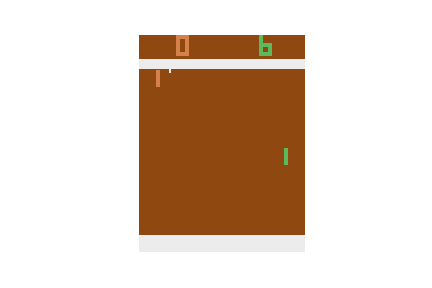
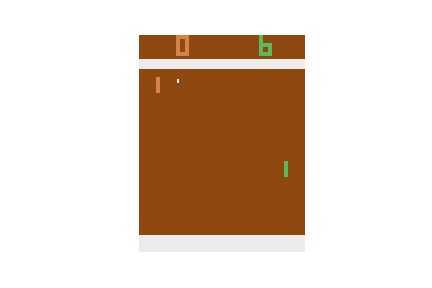
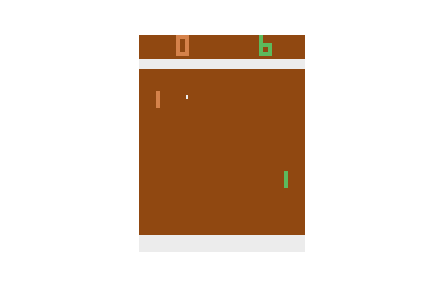
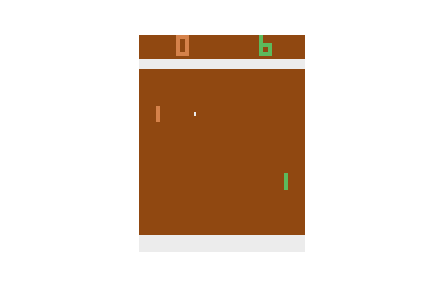
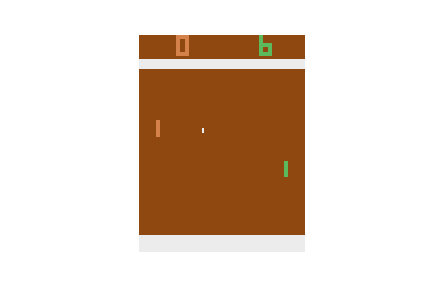
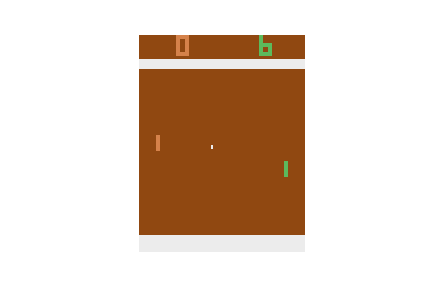
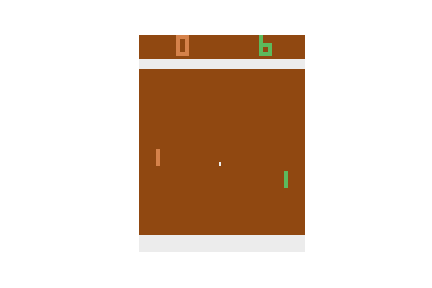
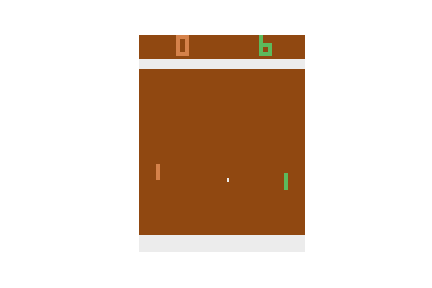
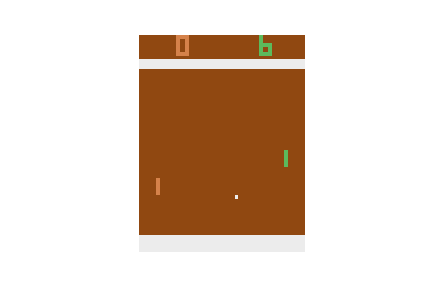
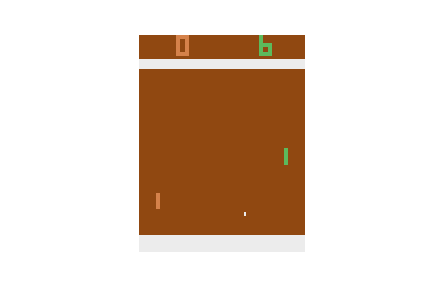
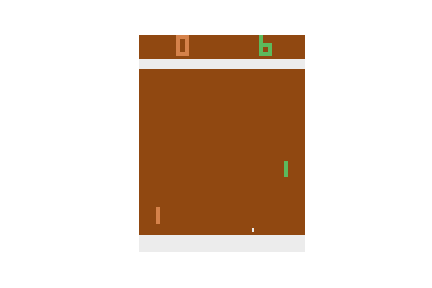
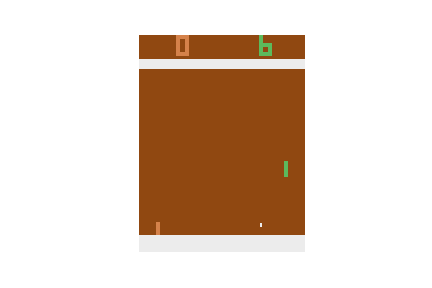
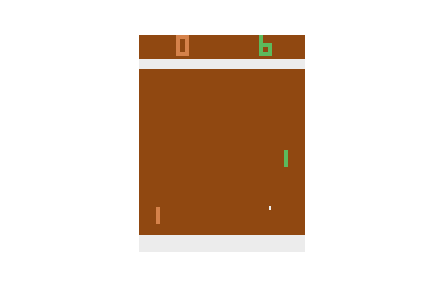
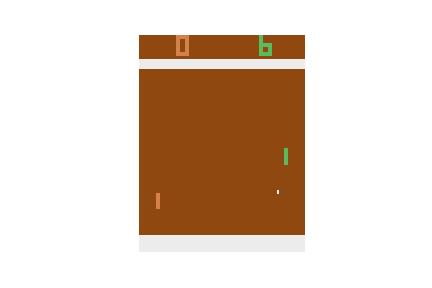
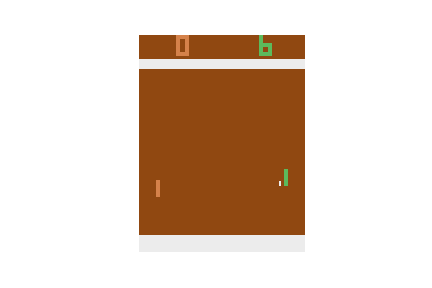
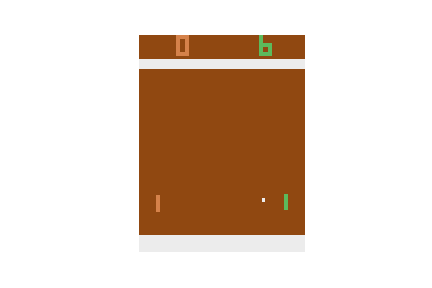
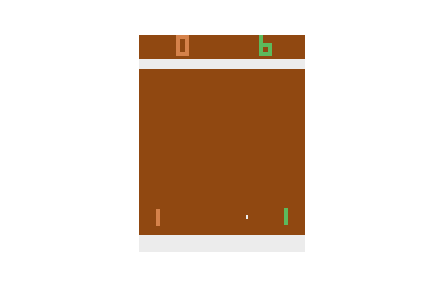
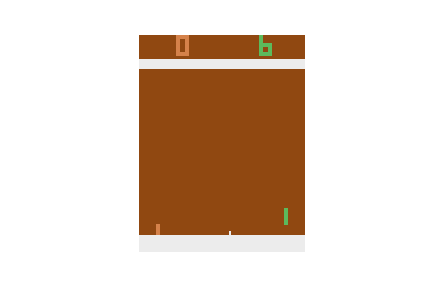
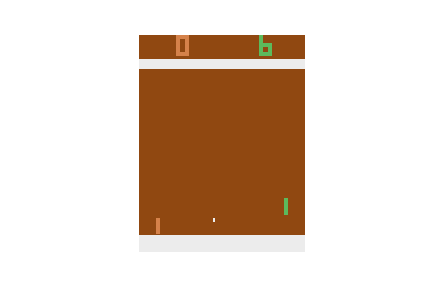
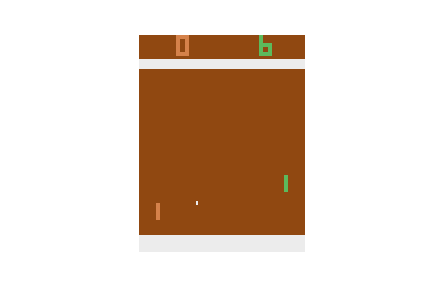
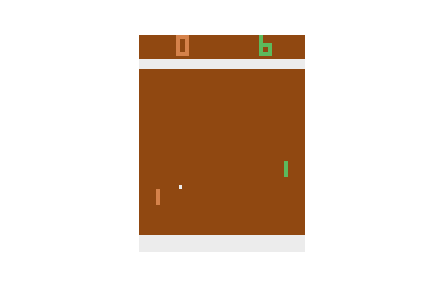
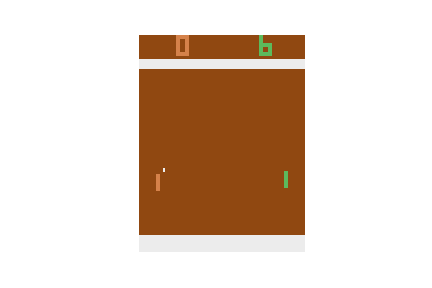
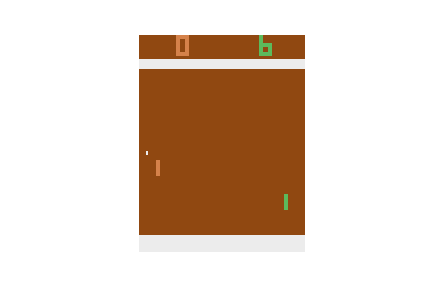
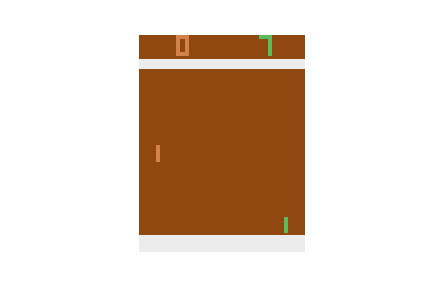
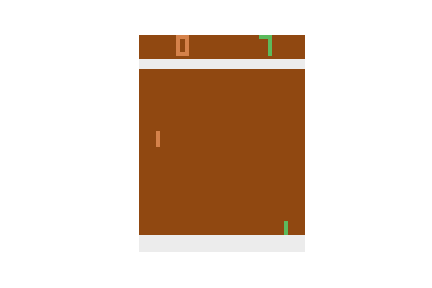
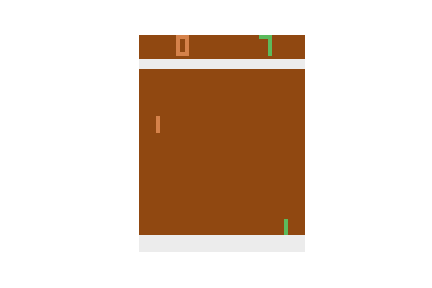
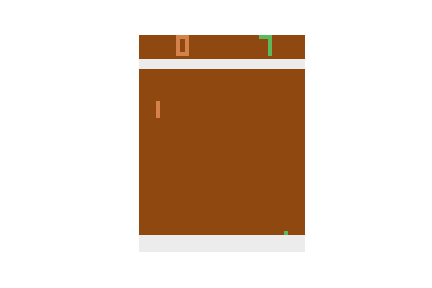
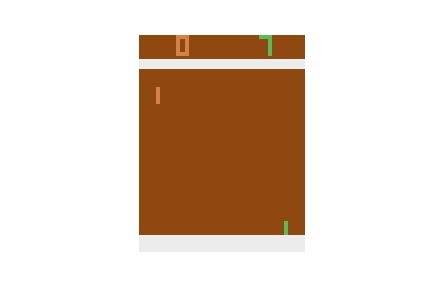
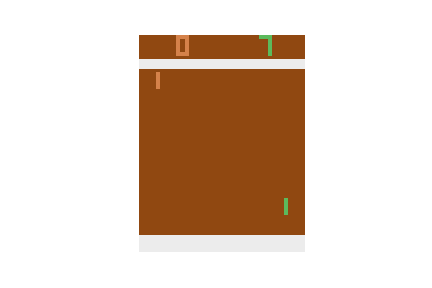
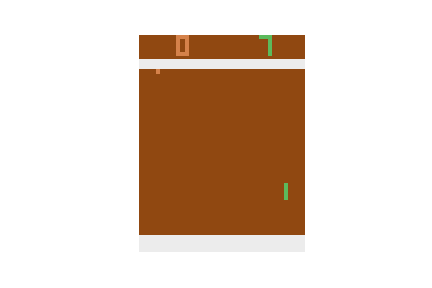
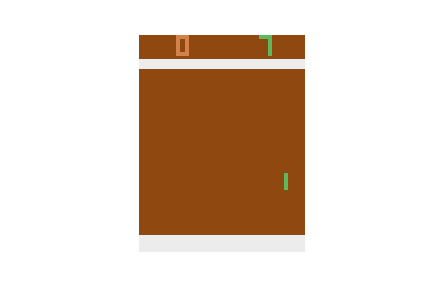
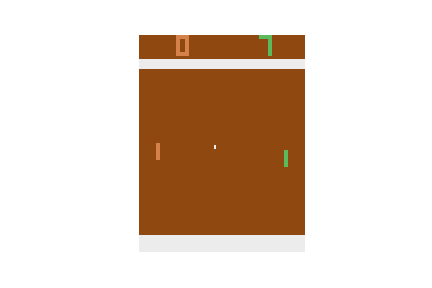
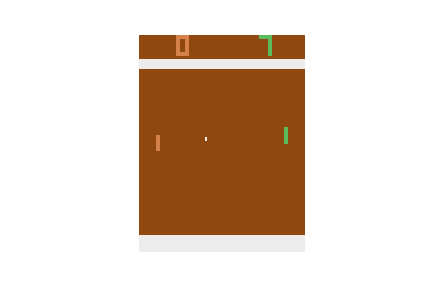
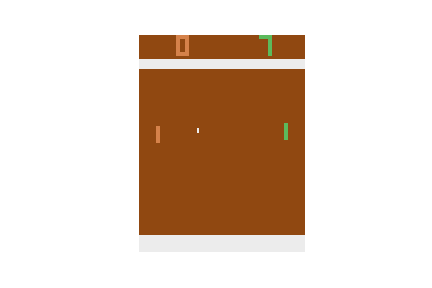
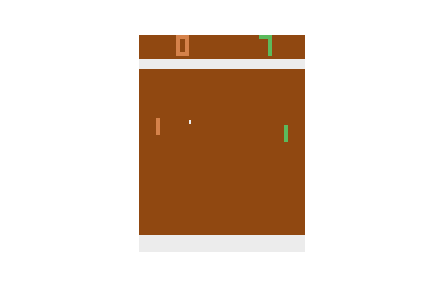
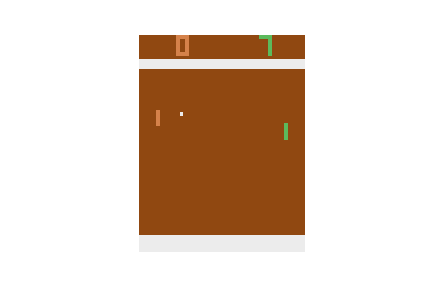
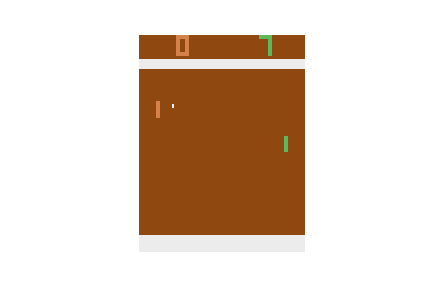
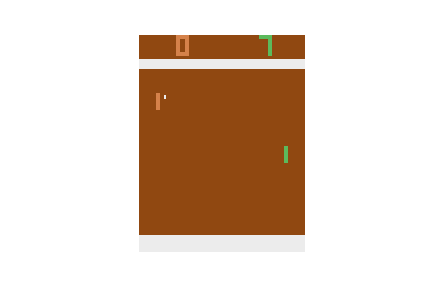
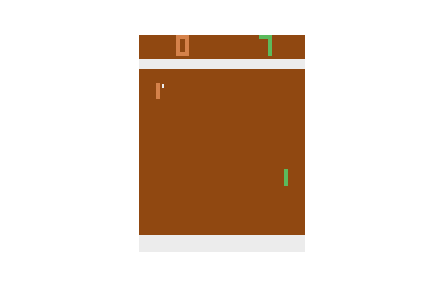
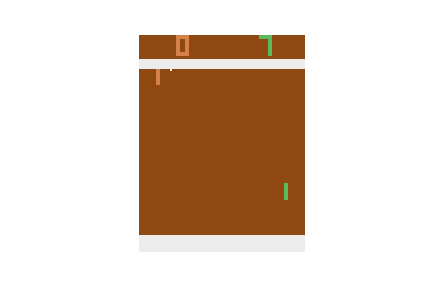
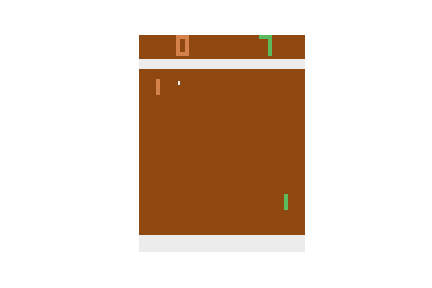
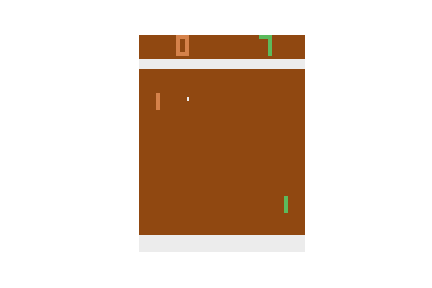
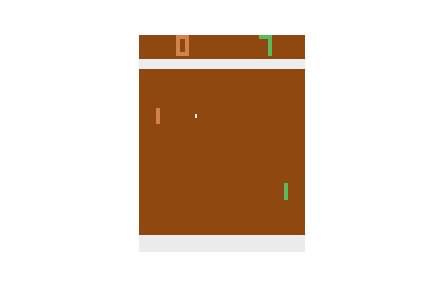
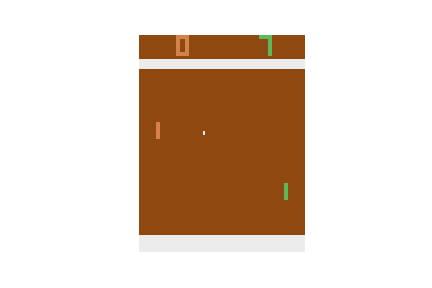
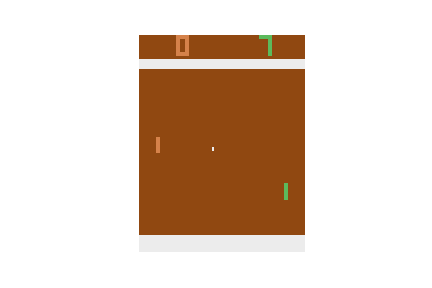
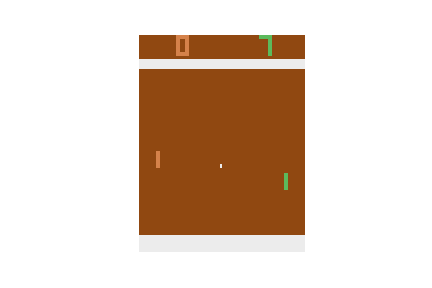
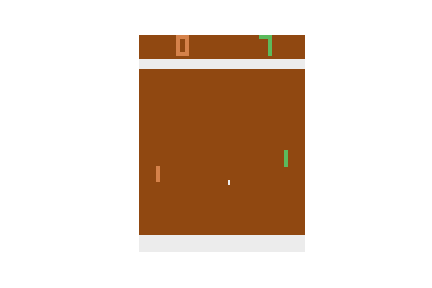
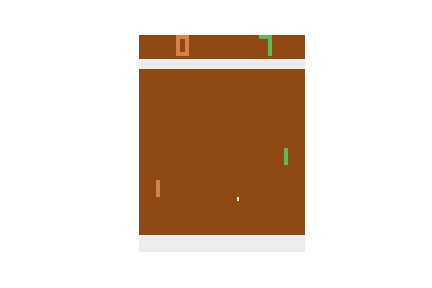
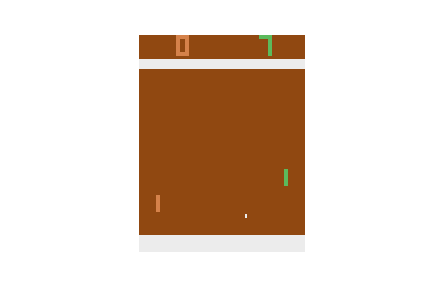
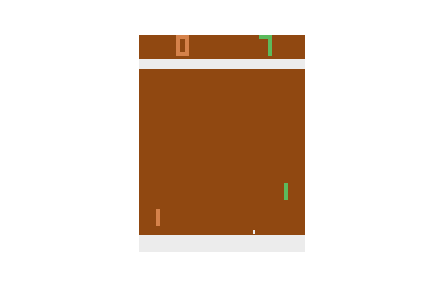
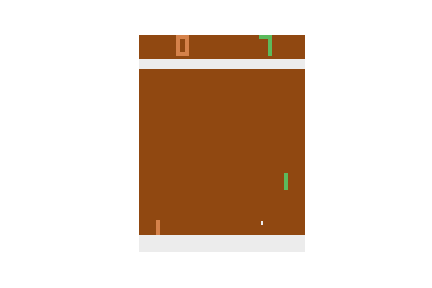
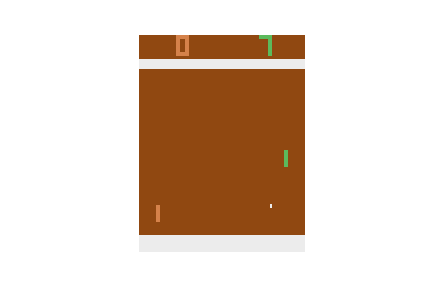
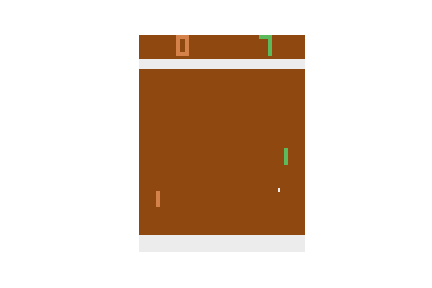
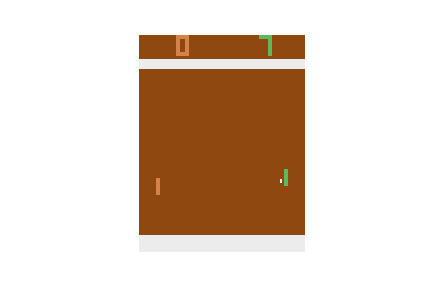
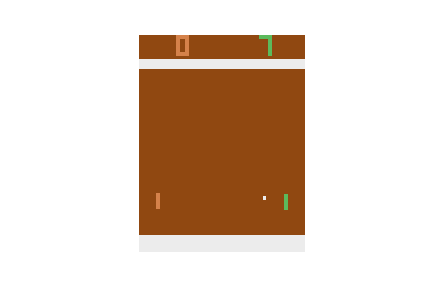
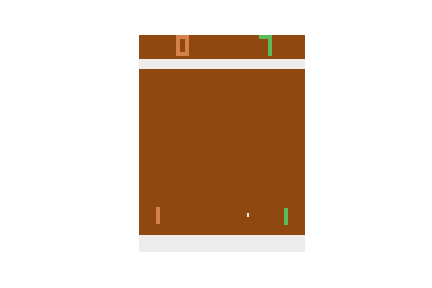
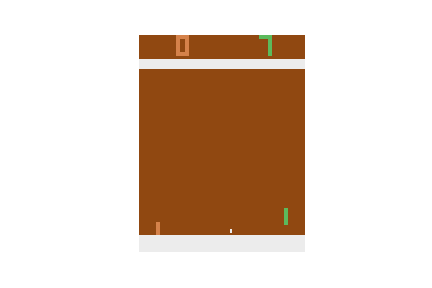
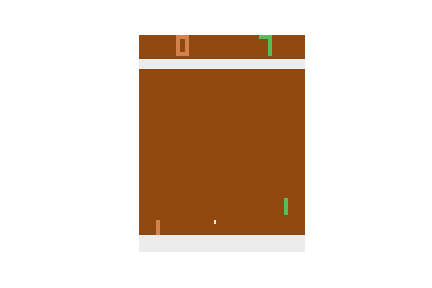
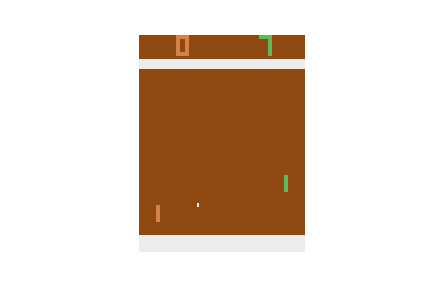
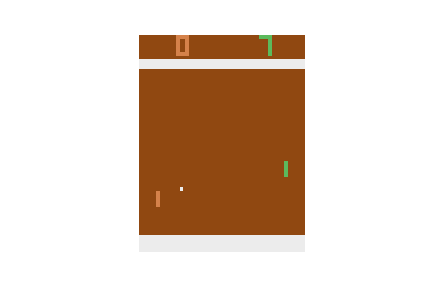
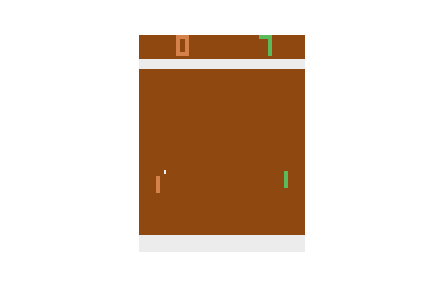
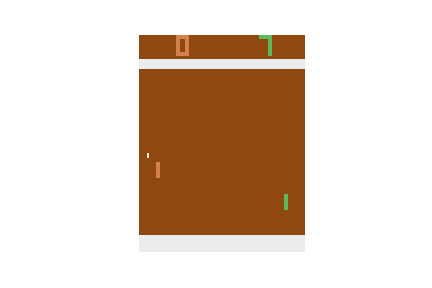
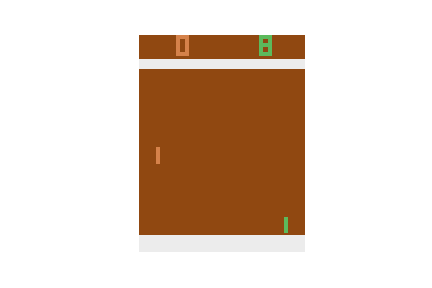
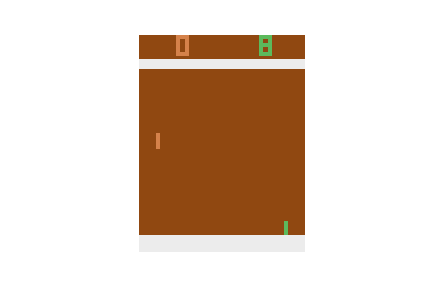
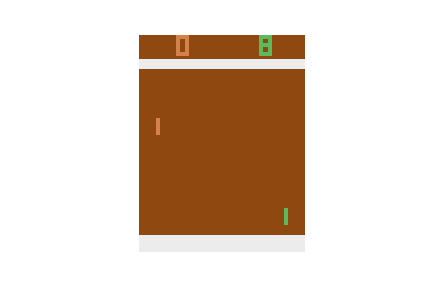
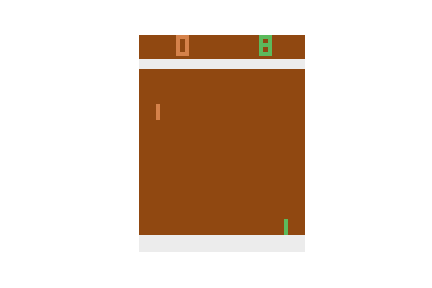
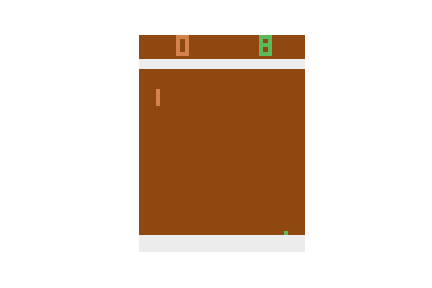
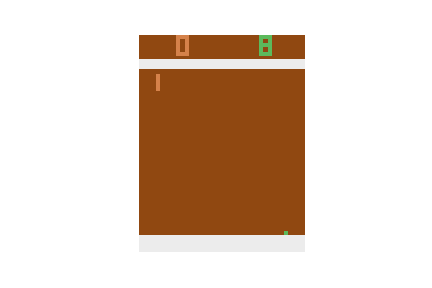
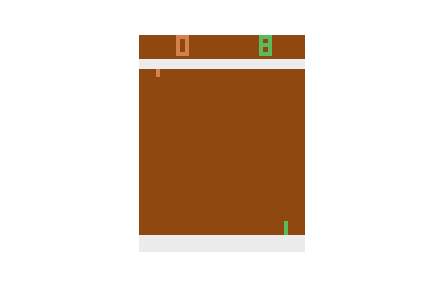
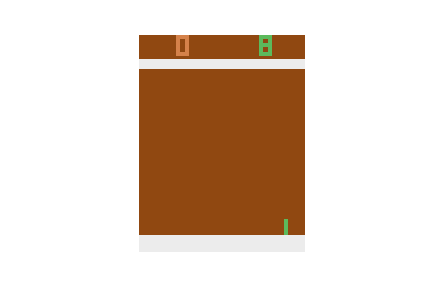
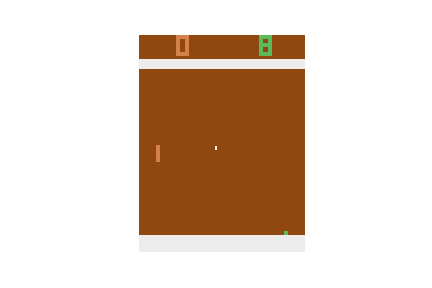
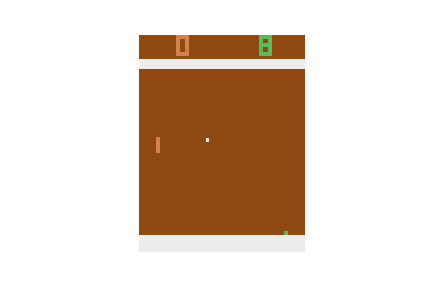
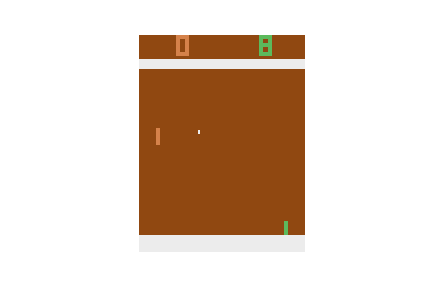
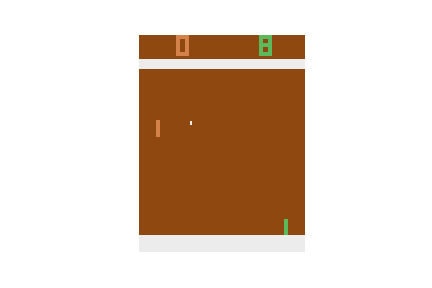
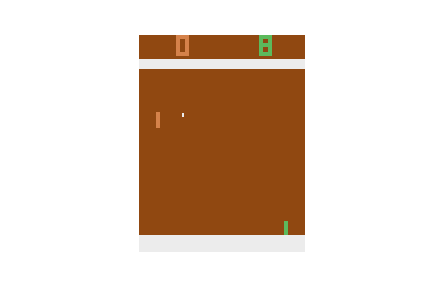
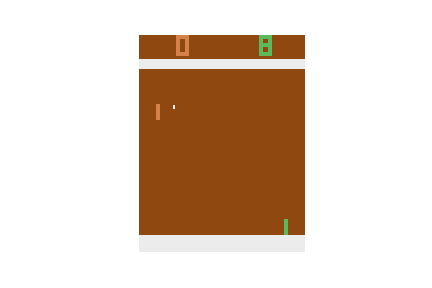
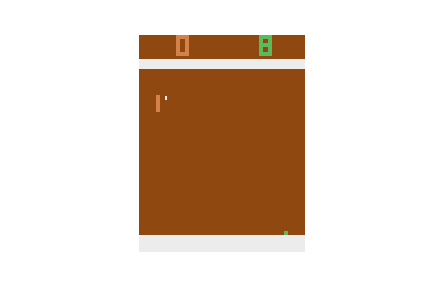
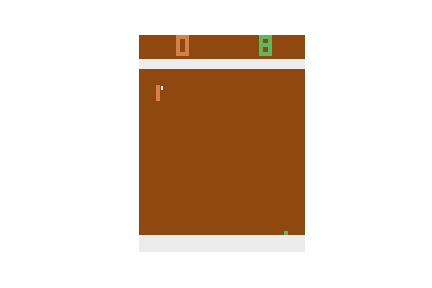
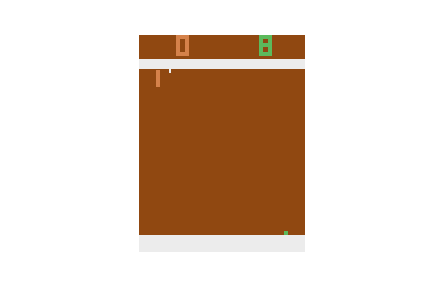
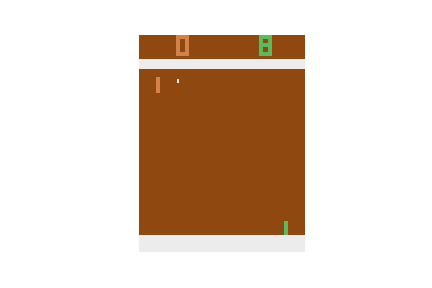
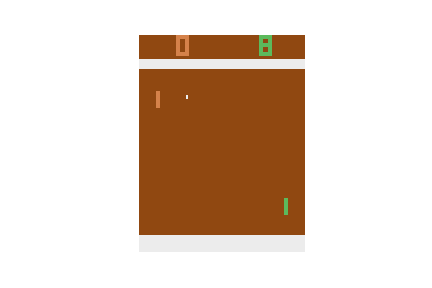
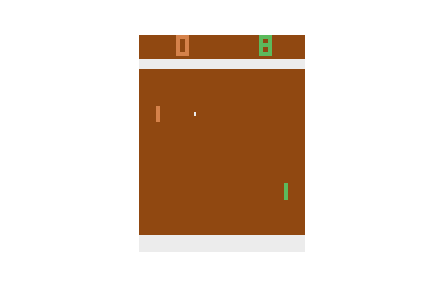
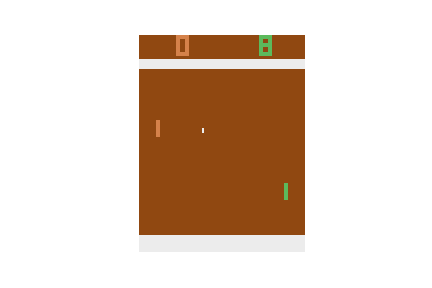
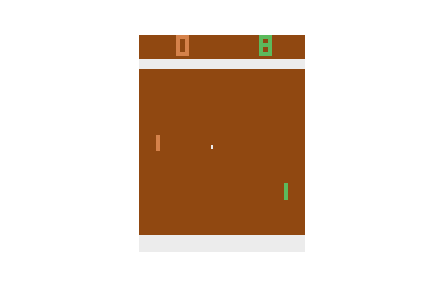
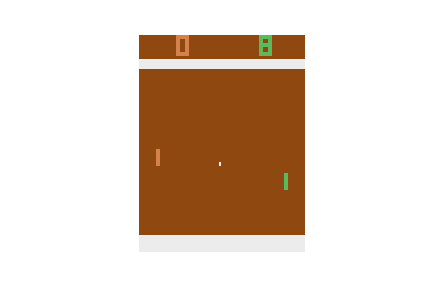
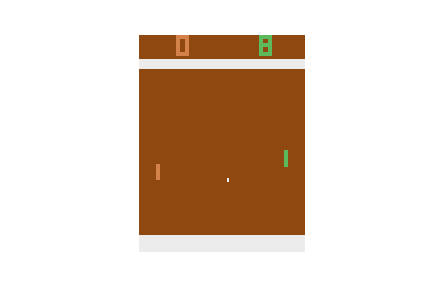
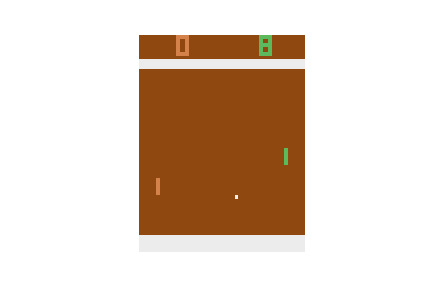
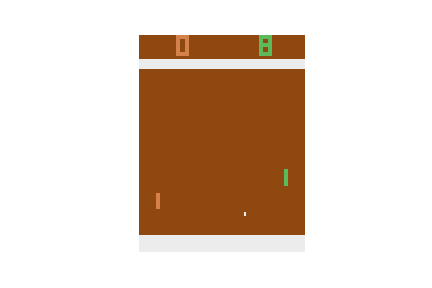
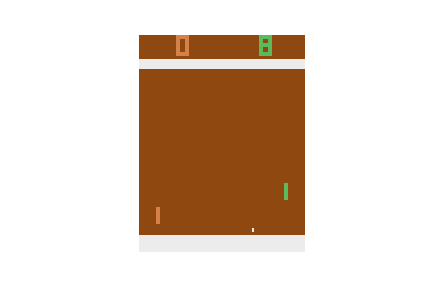
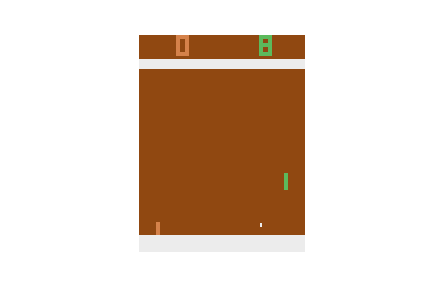
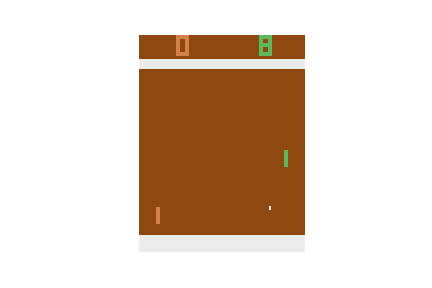
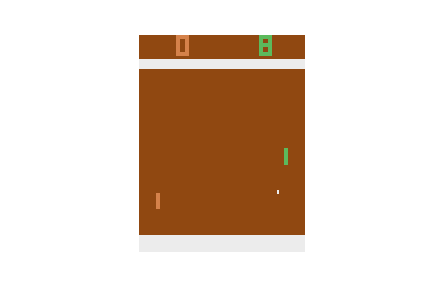
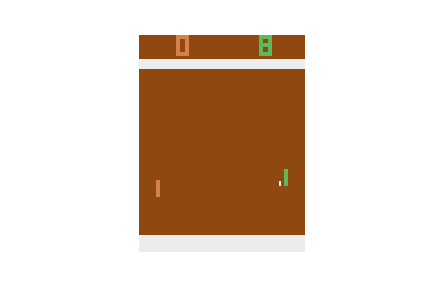
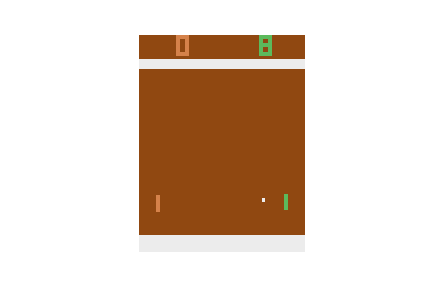
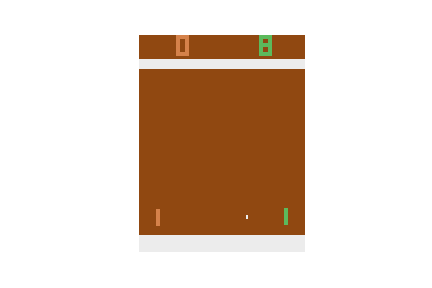
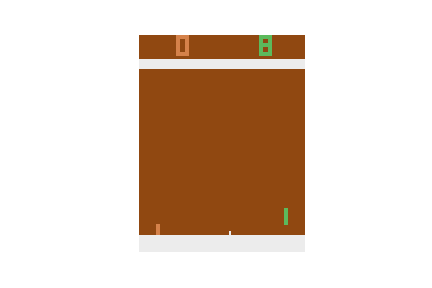
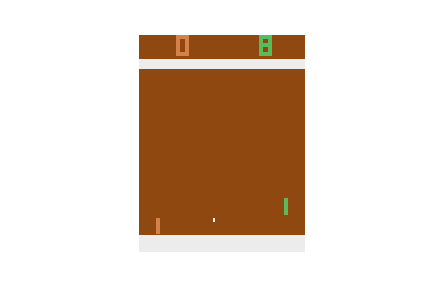
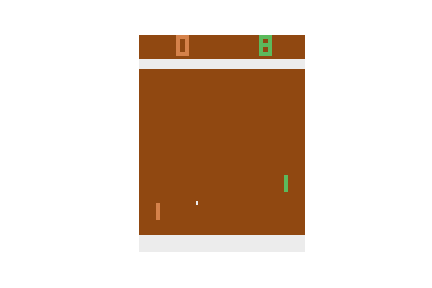
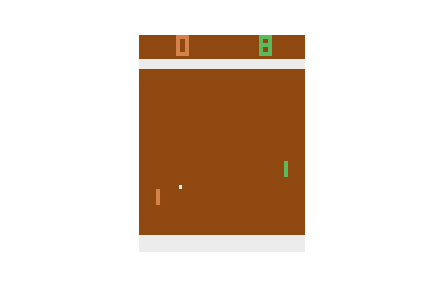
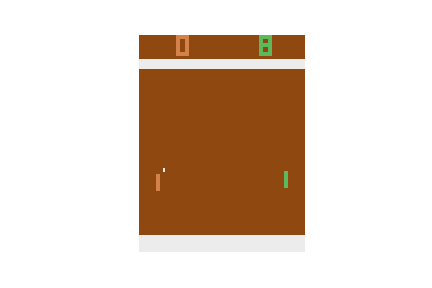
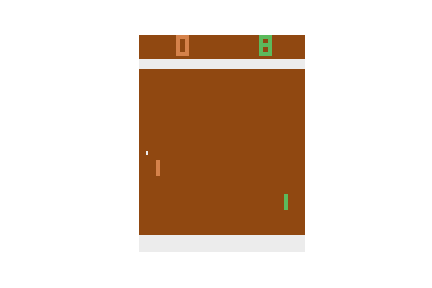
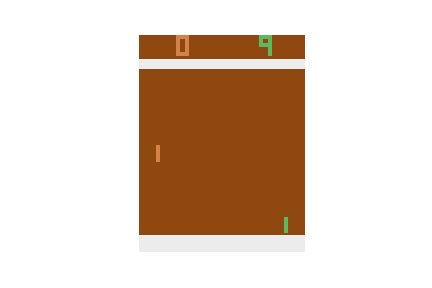
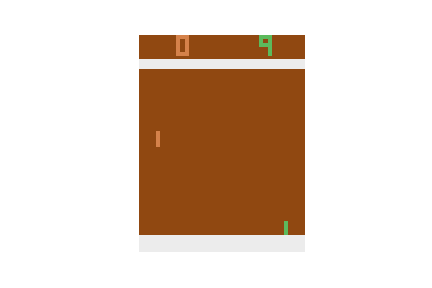
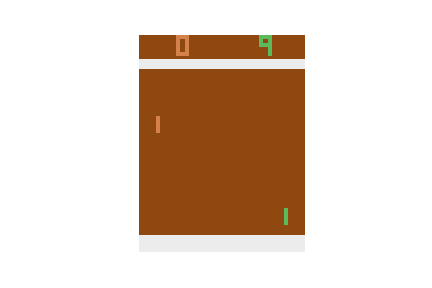
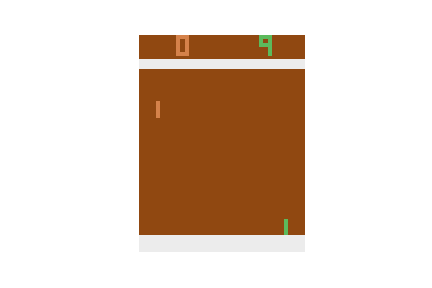
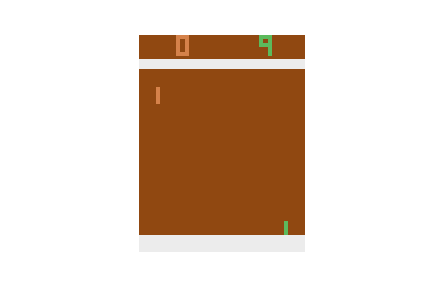
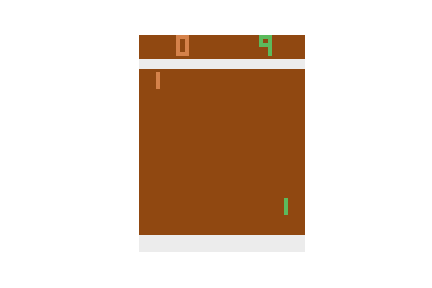
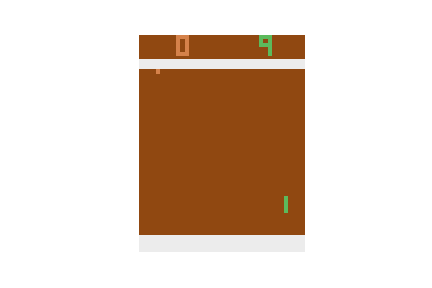
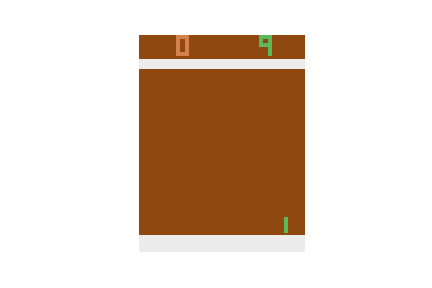
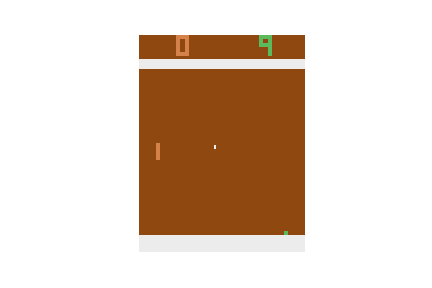
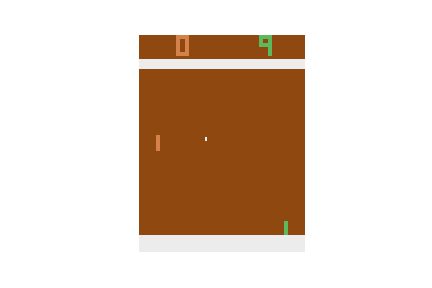
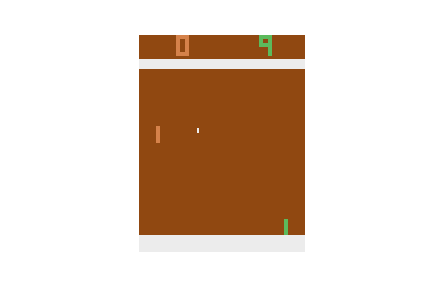
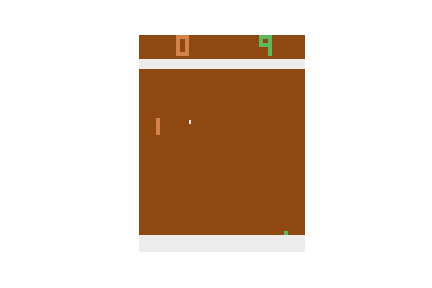
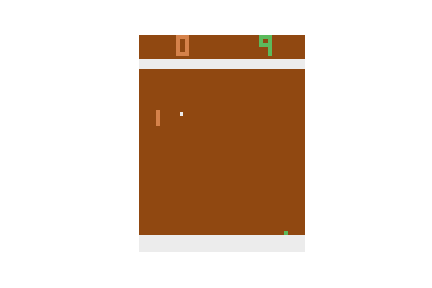
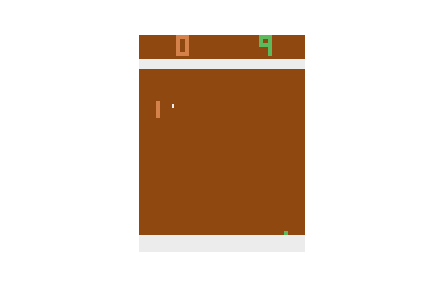
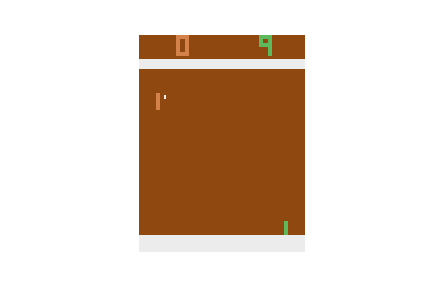
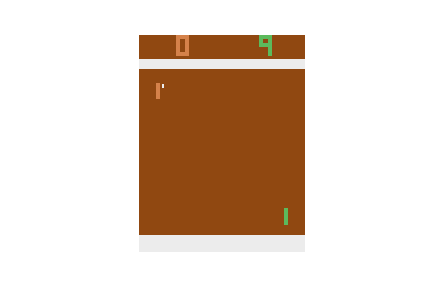
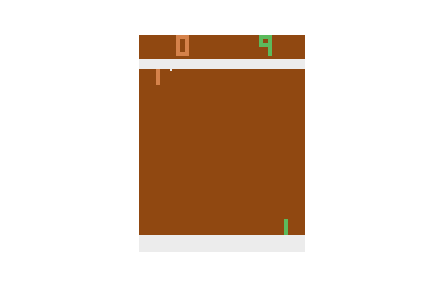
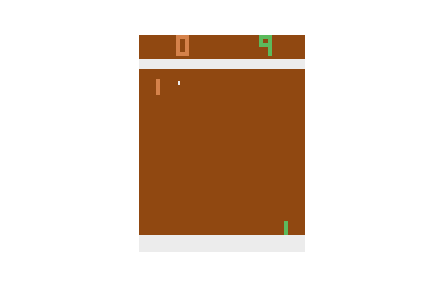
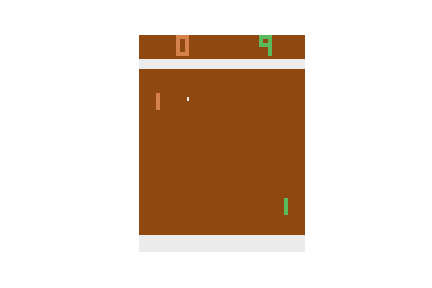
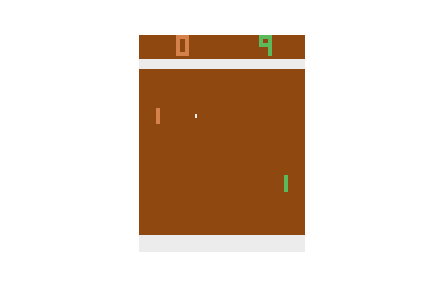
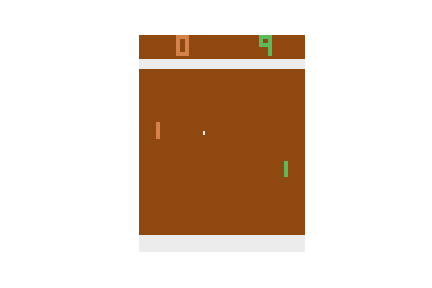
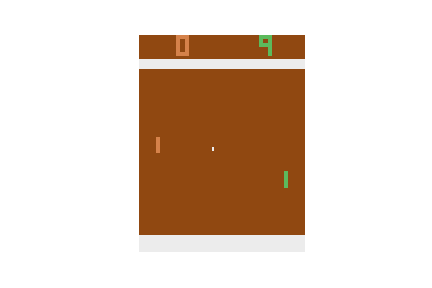
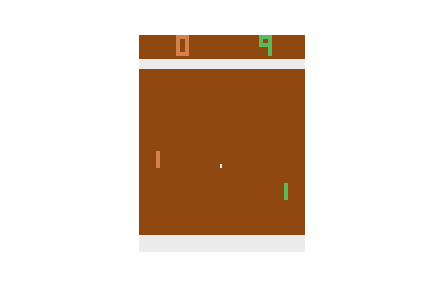
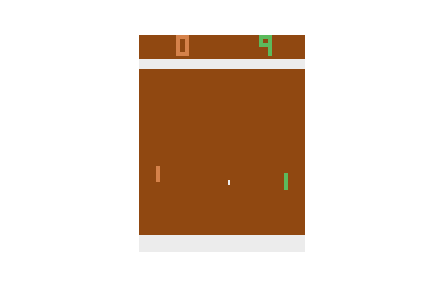
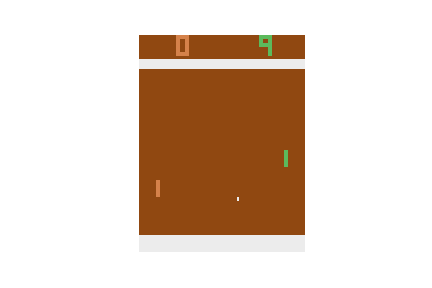
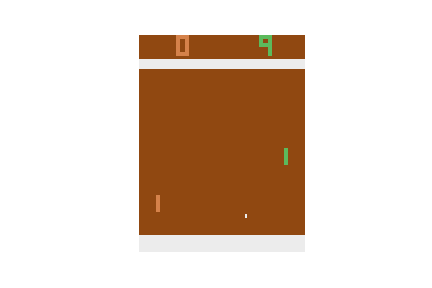
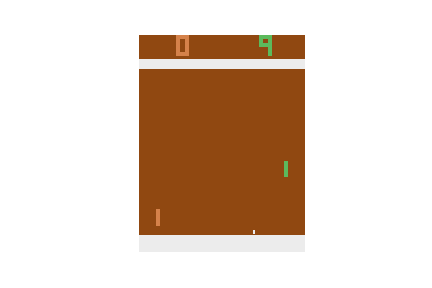
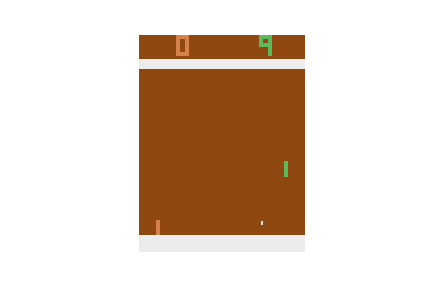
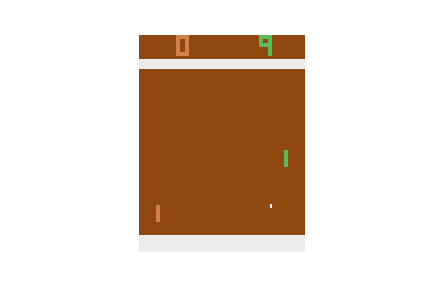
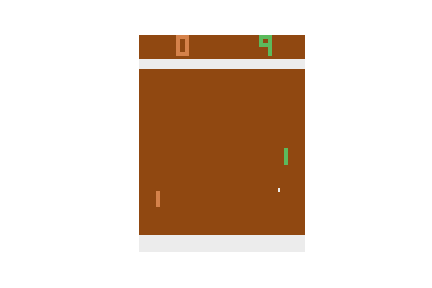
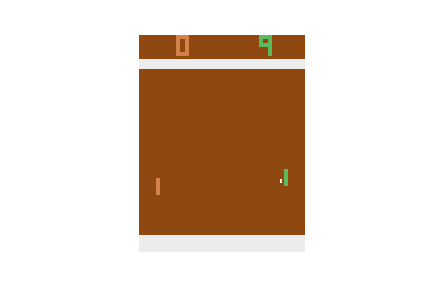
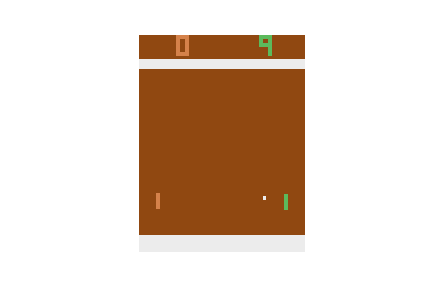
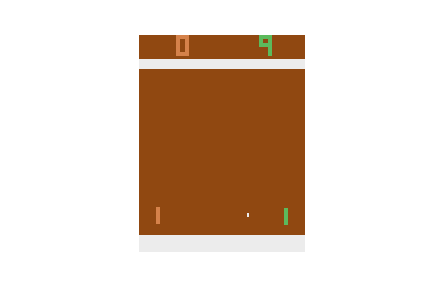
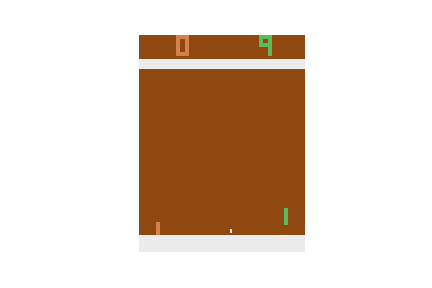
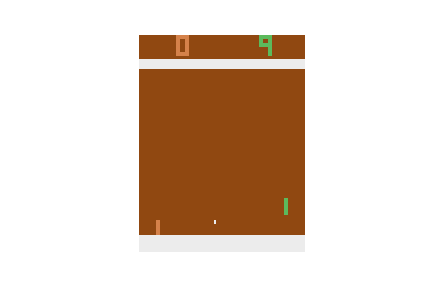
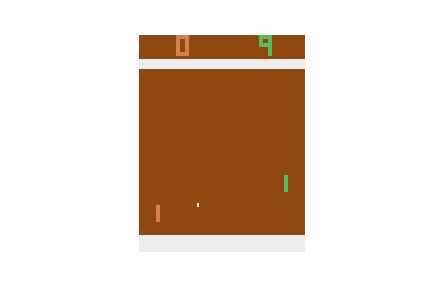
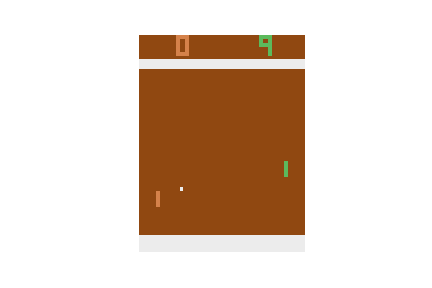
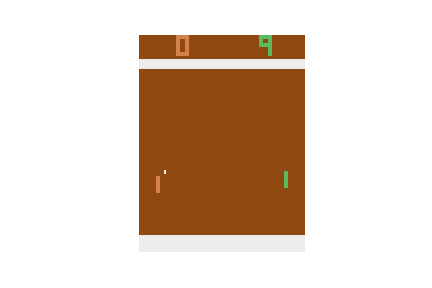
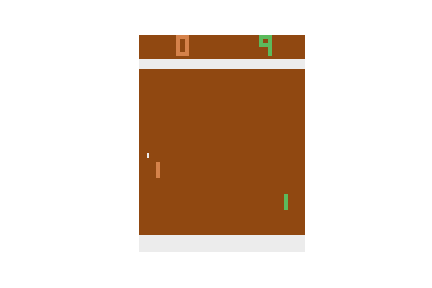
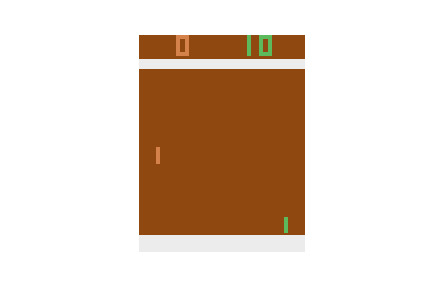
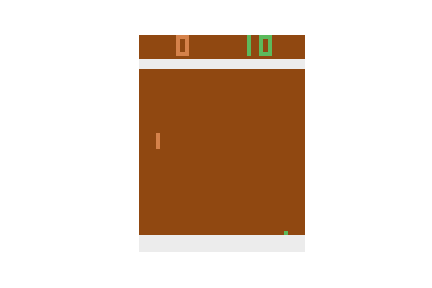
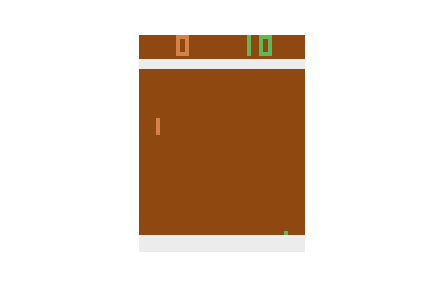
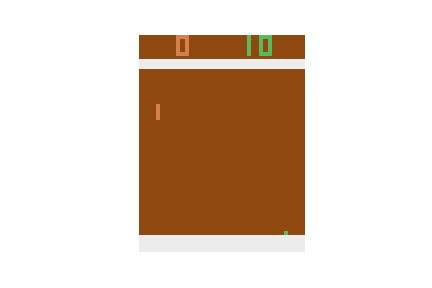
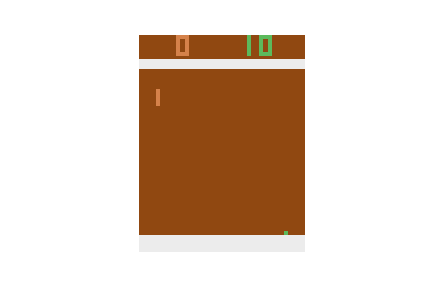
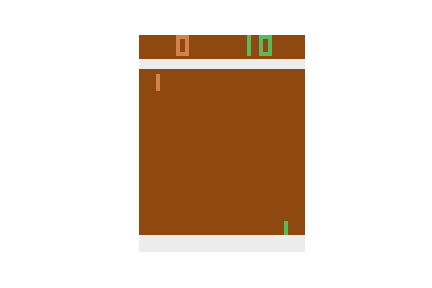
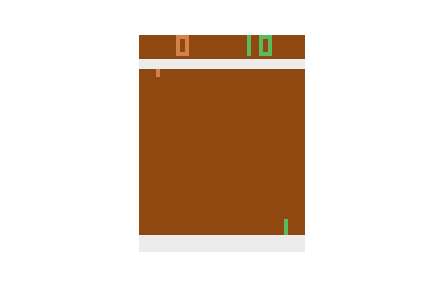
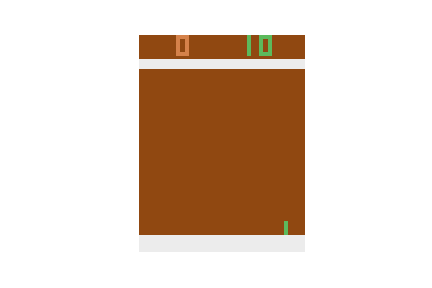
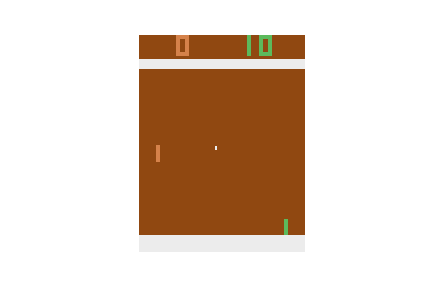
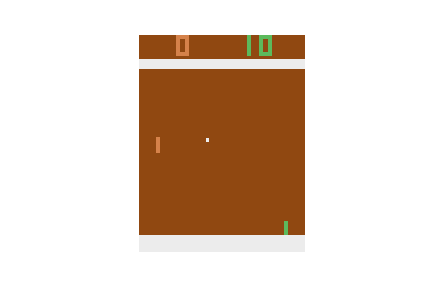
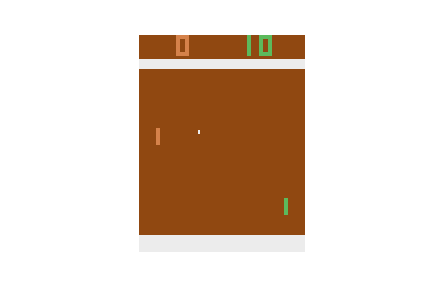
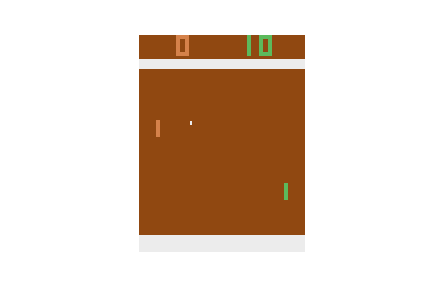
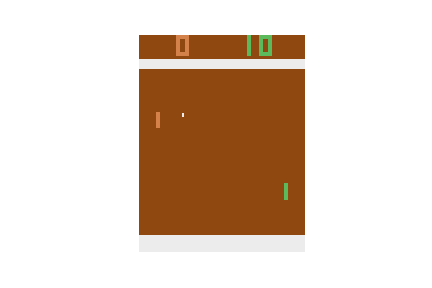
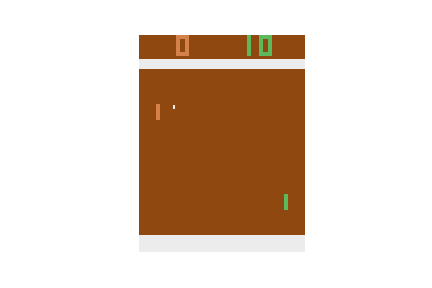
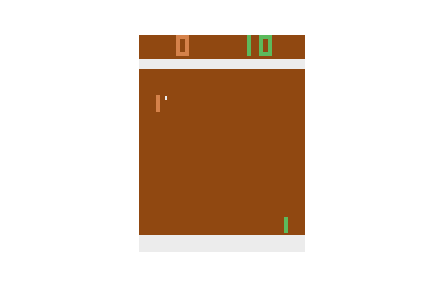
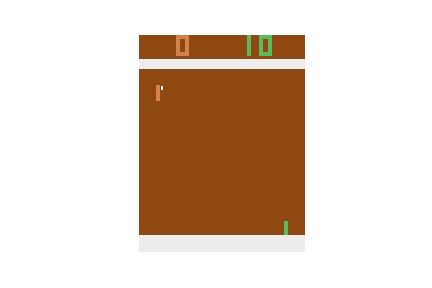
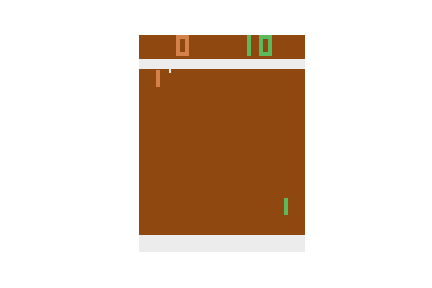
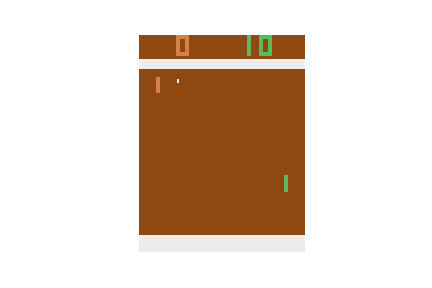
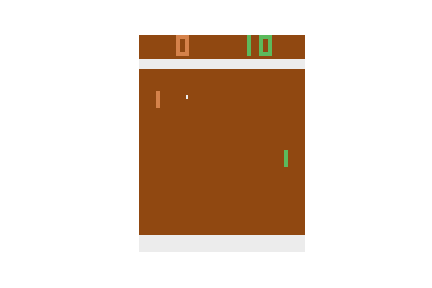
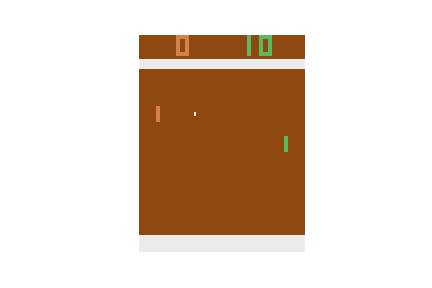
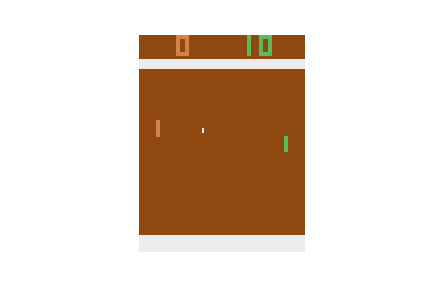
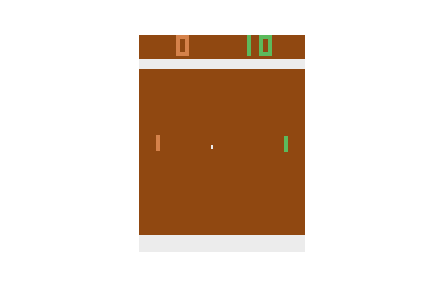
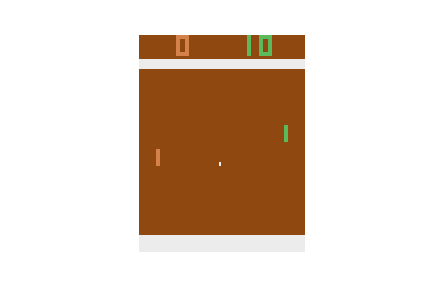
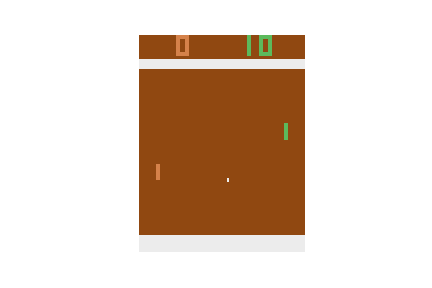
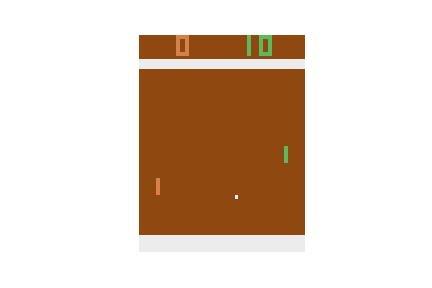
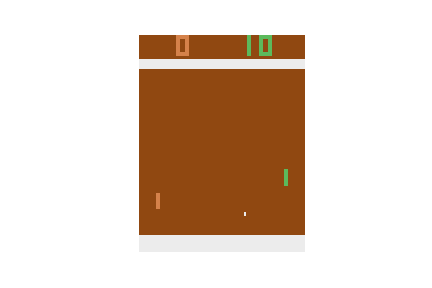
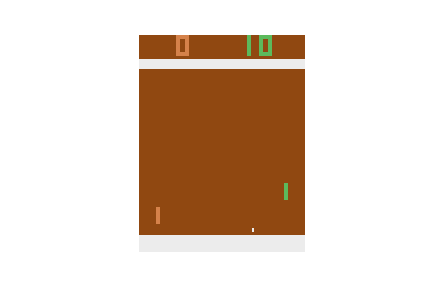
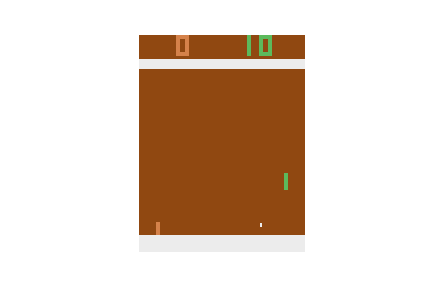
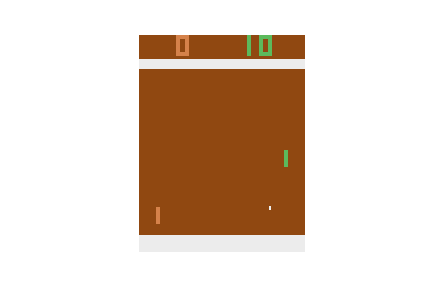
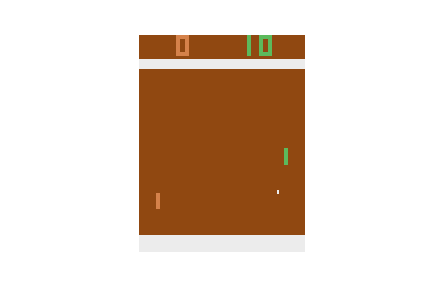
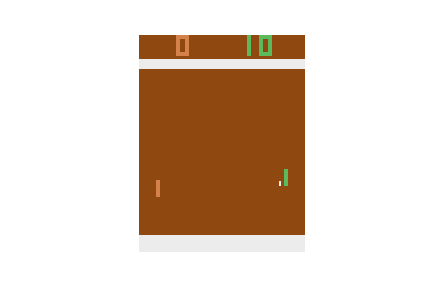
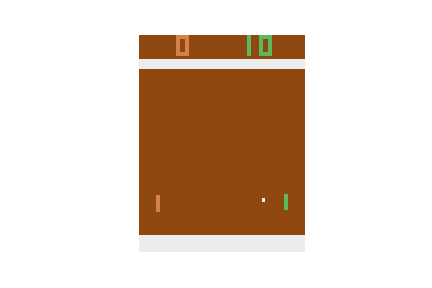
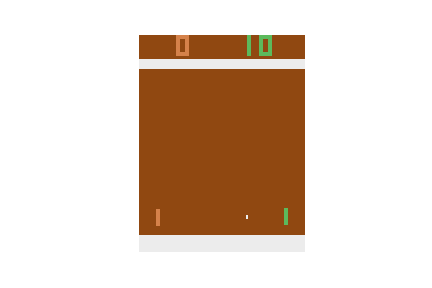
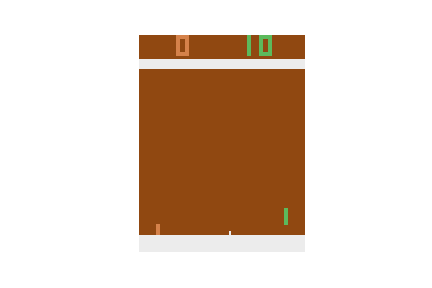
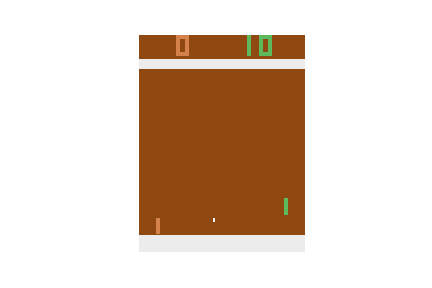
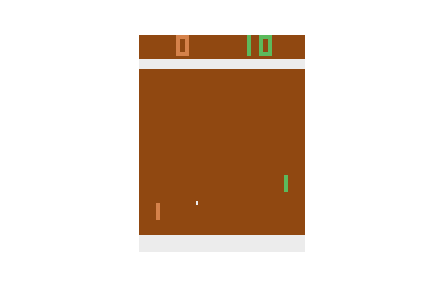
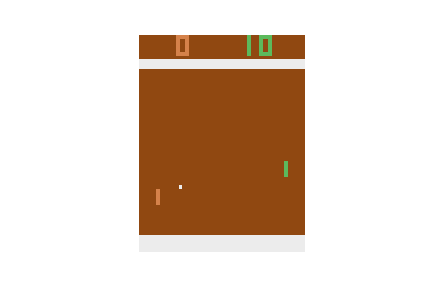
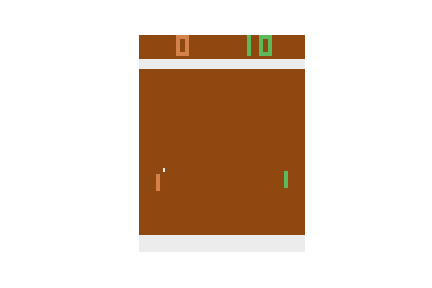
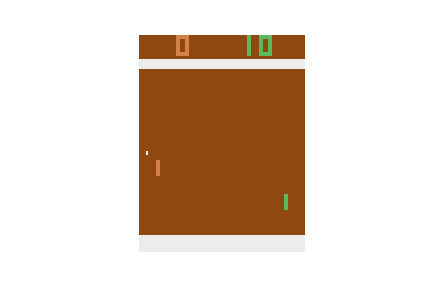
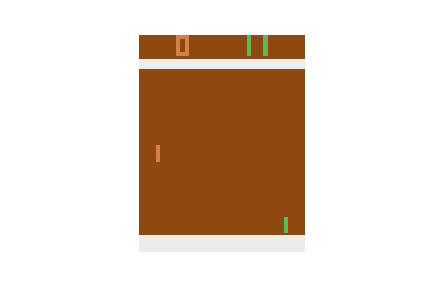
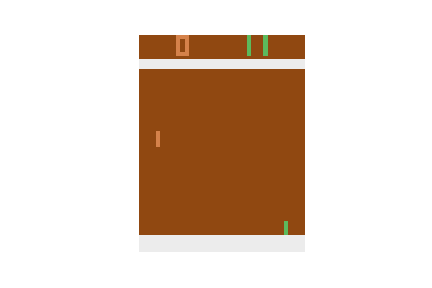
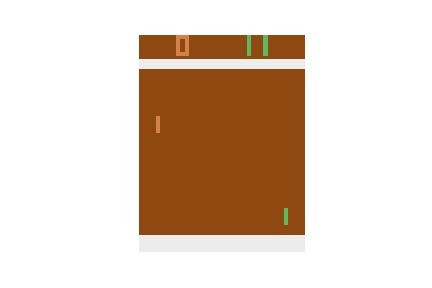
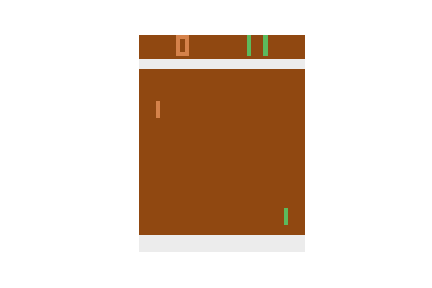
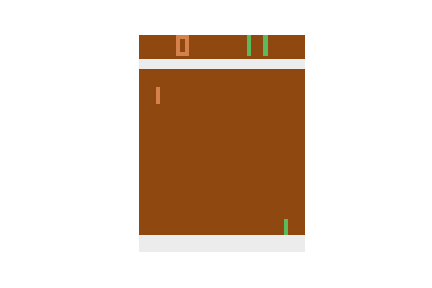
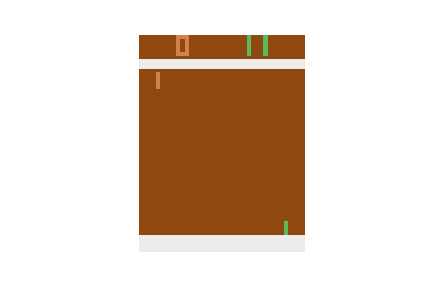
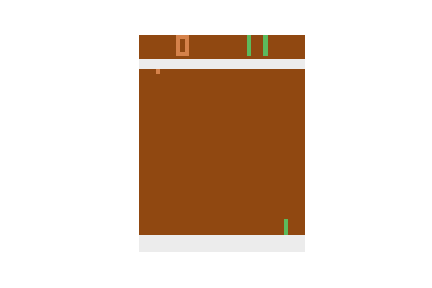
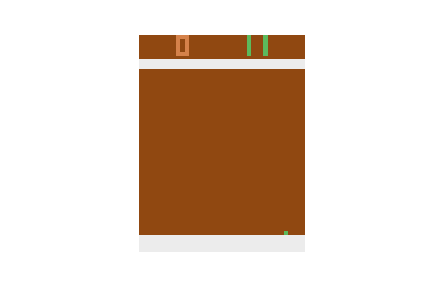
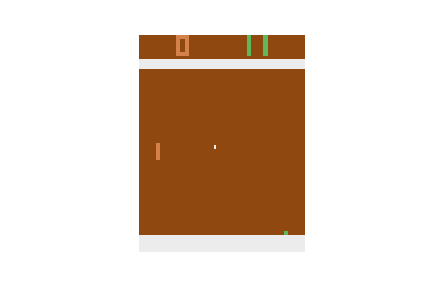
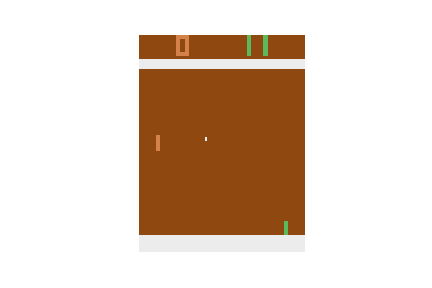
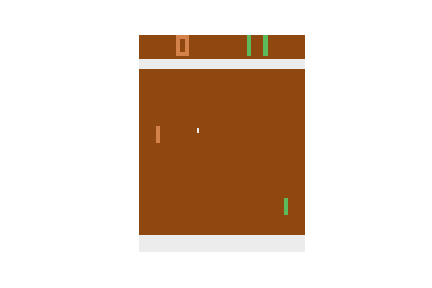
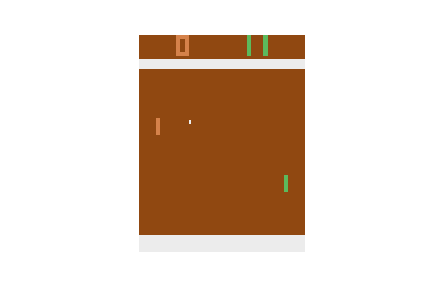
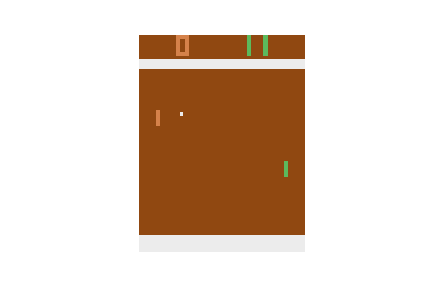
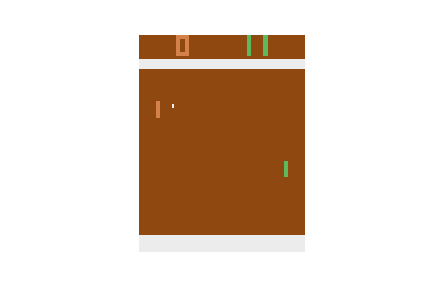
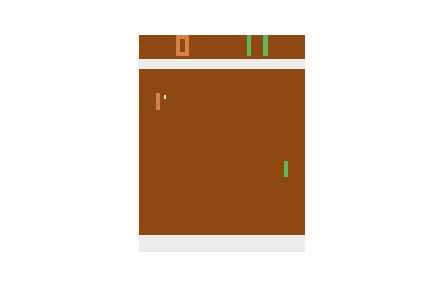
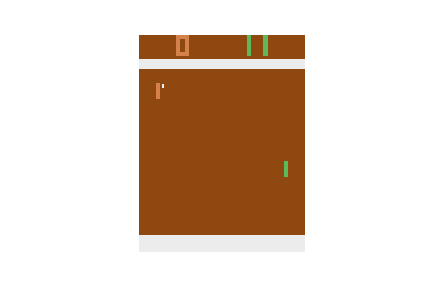
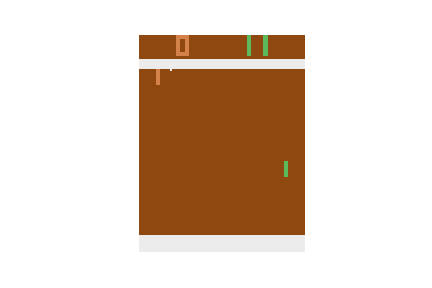
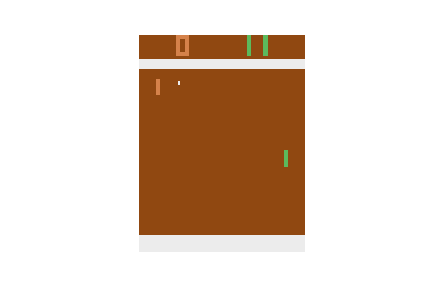
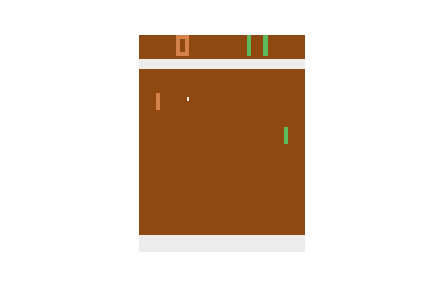
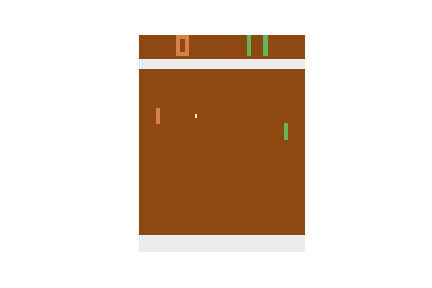
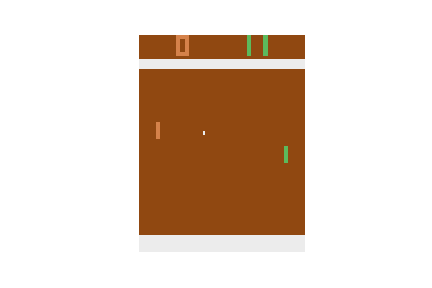
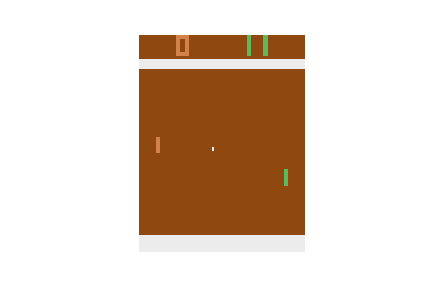
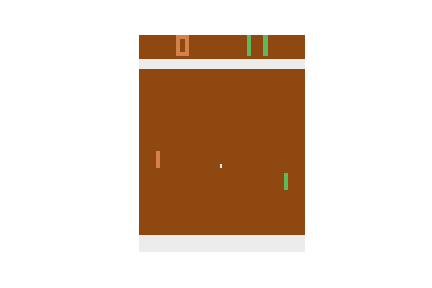
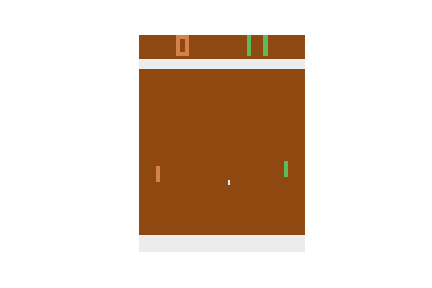
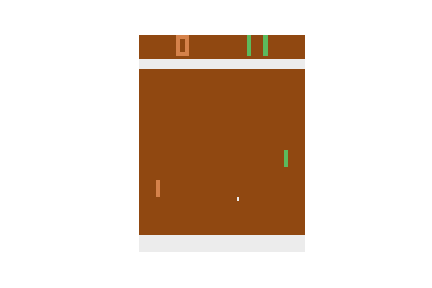
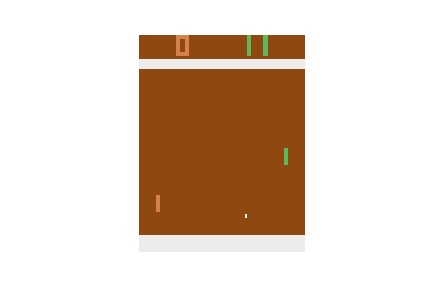
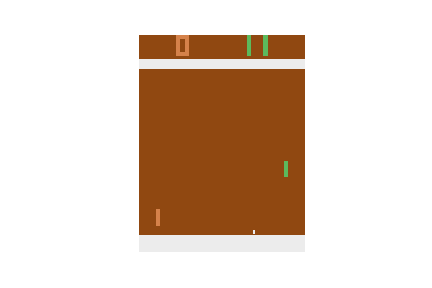
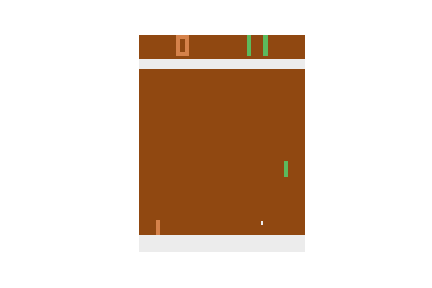
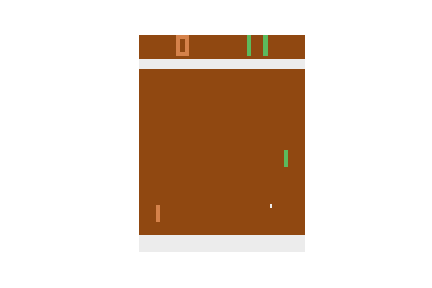
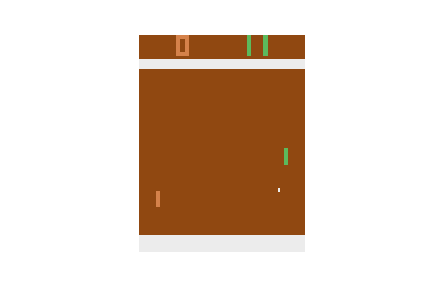
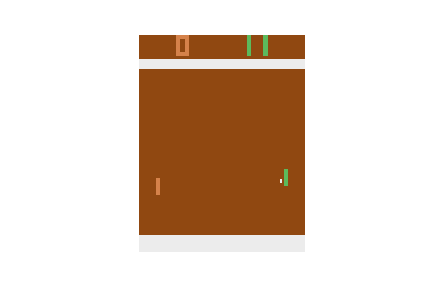
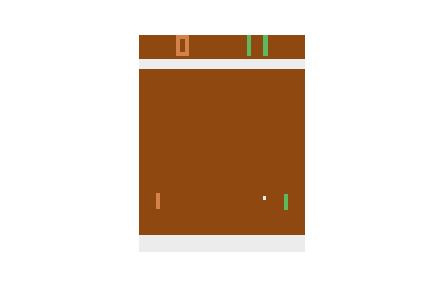
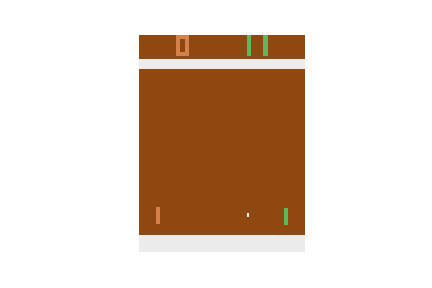
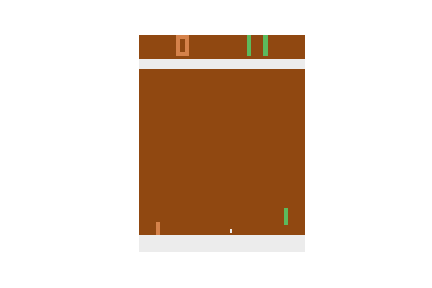
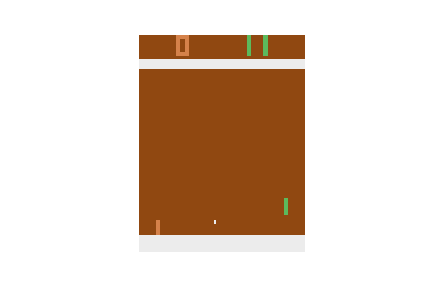
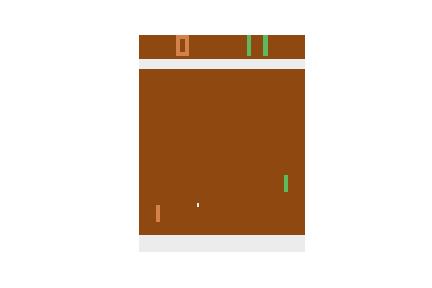
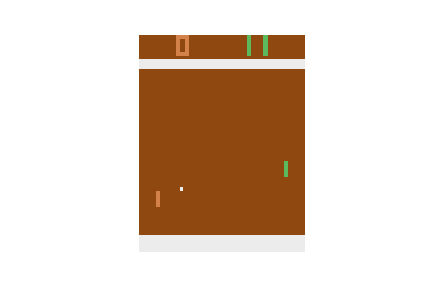
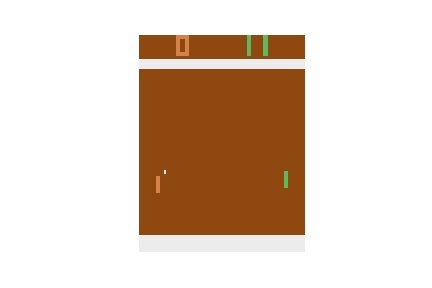
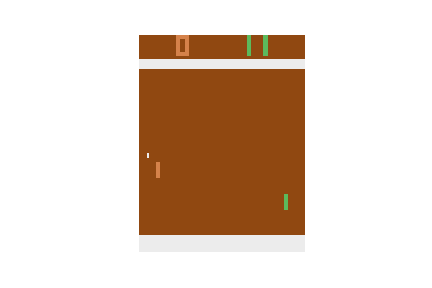
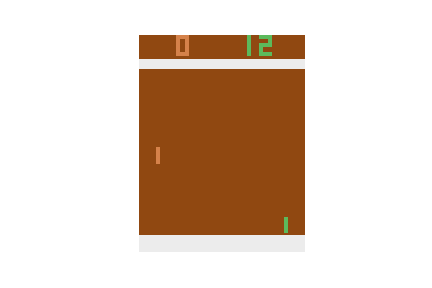
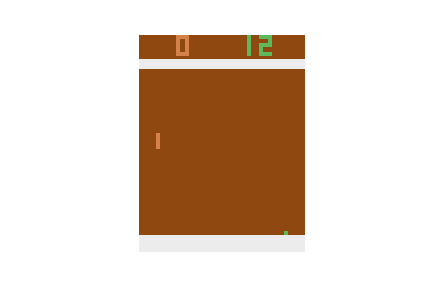
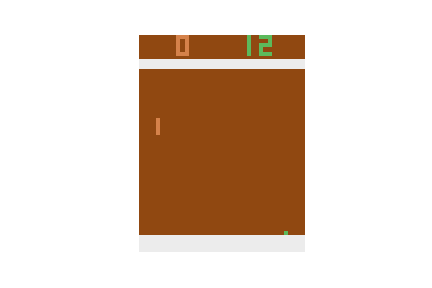
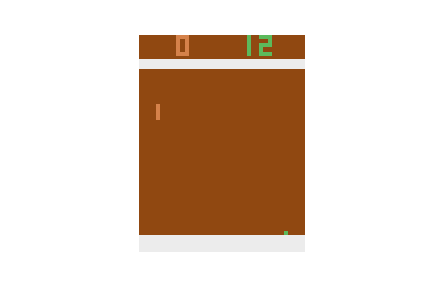
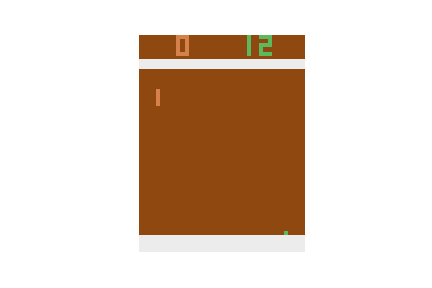
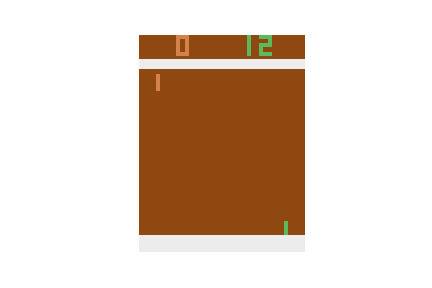
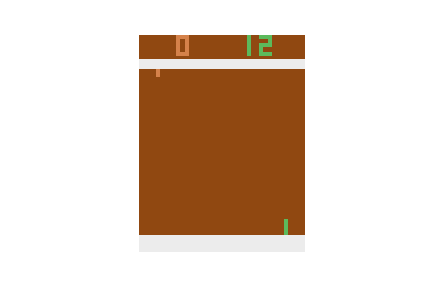
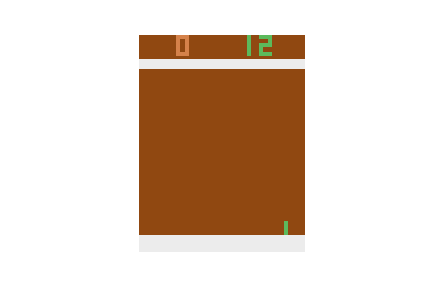

In [5]:
policy.load_state_dict(torch.load('PPO.pth'))
pong_utils.play(env, policy, time=500) 